## Load and explore dataset

In [1]:
# check gpu being used
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9184101163731982378
]


In [2]:
import os
import pathlib
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import shap
import dill
from pickle import dump, load
import joblib
from sklearn import metrics
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from numpy import unique
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from itertools import zip_longest
from pycm import ConfusionMatrix
from scipy.stats import ttest_ind

C:\Users\arl3n\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
# function to load a single file as a numpy array
def load_file(filepath):
    # load file, depending on which filepath is inputted
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [4]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

load_train_test = {}

# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
    loaded = list()
    # make a variable to differentiate between saved scalers
    a = 0
    b = 0
    # for each filename found in load_dataset_group, call load_file to load that file, and append it to the 'loaded' list
    for name in filenames:        
        # load each file
        data = load_file(prefix + name)
        # normalise the data
        scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
        # if training data, fit the scaler
        if (load_train_test['which'] == 'train'):
            scaler.fit(data)
            # save the scaler
            dump(scaler, open(str(a)+'scaler.pkl', 'wb'))
            # transform the data
            data = scaler.transform(data)
            a=a+1
        # if test data, load the relevant scaler then fit it
        elif (load_train_test['which'] == 'test'):
            # load relevant scaler
            scaler = load(open(str(b)+'scaler.pkl', 'rb'))
            # transform the data
            data = scaler.transform(data)   
            b=b+1
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    print("prefix:  ", prefix)
    return loaded
    

In [5]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    # group can be either train or test, depending on which part of load_dataset it was called in.
    # so, here, the filepath will either be:'train/Inertial Signals/' or 'test/Inertial Signals/'
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # this part gets the file names of each of the 9 files in test/train inertial signals, ie:
    # 'total_acc_x_train.txt'
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # call load_group, using the filenames list made just above, and the filepath variable made above that
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    # this gets the y_train or y_test file, depending on group, by calling the load_file function defined earlier
    y = load_file(prefix + group + '/y_'+group+'.txt')
    # return X and y to be used as either trainX and trainy or testX and testY
    return X, y

In [6]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

# load the dataset, returns train and test X and y elements
def load_dataset(prefix='datasets/'):
    # run load_dataset_group for the training dataset
    # load all train
    load_train_test['which'] = 'train'
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print("trainX.shape:  ", trainX.shape, "trainy.shape:  ", trainy.shape)
    # run load_dataset_group for the testing dataset
    # load all test
    load_train_test['which'] = 'test'
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print("testX.shape:  ", testX.shape, "testy.shape:  ", testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX.shape:  ", trainX.shape, "trainy.shape:  ", trainy.shape, "testX.shape:  ", testX.shape, "testy.shape:  ", testy.shape)
    return trainX, trainy, testX, testy

So, these functions are defined in this order. Then when it actually comes to using the functions, the last function, `load_dataset`, calls the second last function, `load_dataset_group`, which calls   `load_group`, which calls `load_file`.

So, `load_dataset` basically specifies whether to get the training or testing group, `load_dataset_group` gets the filenames for each group, `load_group` loads a list of files into a 3D array of `[samples, timesteps, features]`, and then `load_file` actually loads each file.

`load_dataset` also one-hot encodes trainy and testy, as it has 6 classes.

### See how balanced/imbalanced dataset is

In [7]:
# set figure size globally
sns.set(rc={'figure.figsize':(15,12)})
sns.set_style('whitegrid')

Training:

In [8]:
# for exploration purposes, make variables for train and test data
load_train_test['which'] = 'train'
trainX, trainy = load_dataset_group('train', 'datasets/HARDataset/')
load_train_test['which'] = 'test'
testX, testy = load_dataset_group('test', 'datasets/HARDataset/')

prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/


In [9]:
# change to dataframes for sns
trainy_df = pd.DataFrame(trainy)
testy_df = pd.DataFrame(testy)

In [10]:
# make list of activity labels, from activity_labels document
activity_labels=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


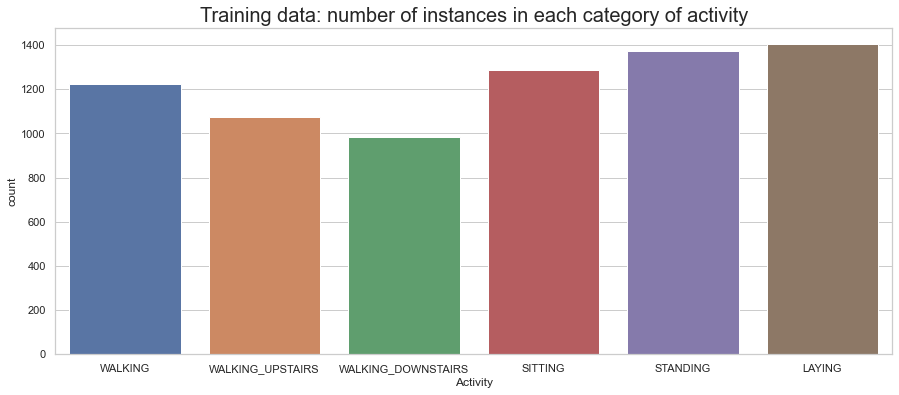

In [11]:
# plot balance of classes in training data
sns.set_style('whitegrid')

plt.figure(figsize=(15,6))
plt.title('Training data: number of instances in each category of activity', fontsize=20)
ax = sns.countplot(trainy_df[0])
ax.set(xlabel='Activity')
ax.set_xticklabels(activity_labels)
plt.show()

In [12]:
# make df with both trainy and testy
trainy_df['test_train'] = '\n\n Training'
testy_df['test_train'] = '\n\n Testing'

y_df = pd.concat([trainy_df, testy_df])
y_df['class'] = y_df[0]
y_df

0     test_train  class
0     5  \n\n Training      5
1     5  \n\n Training      5
2     5  \n\n Training      5
3     5  \n\n Training      5
4     5  \n\n Training      5
...  ..            ...    ...
2942  2   \n\n Testing      2
2943  2   \n\n Testing      2
2944  2   \n\n Testing      2
2945  2   \n\n Testing      2
2946  2   \n\n Testing      2

[10299 rows x 3 columns]

In [13]:
# make list of activity labels a bit prettier
activity_labels_neat=['Walking','Walking upstairs','Walking downstairs','Sitting','Standing','Laying']

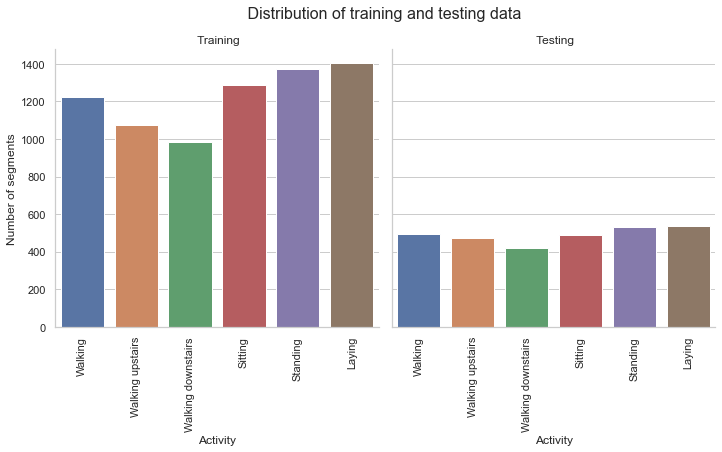

In [14]:
# plot test and train side-bu-side
ax = sns.catplot(x='class', col='test_train', kind='count', data=y_df)
ax.fig.suptitle('       Distribution of training and testing data', fontsize = 16)
ax.set_axis_labels(x_var="Activity", y_var="Number of segments")
ax.set_titles("{col_name}")
ax.set_xticklabels(activity_labels_neat)
ax.set_xticklabels(rotation=90)

Testing:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


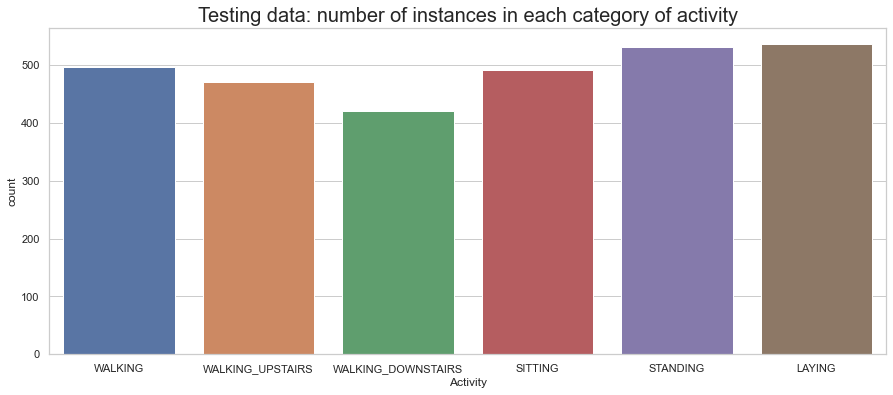

In [15]:
# plot balance of classes in test data
plt.figure(figsize=(15,6))
plt.title('Testing data: number of instances in each category of activity', fontsize=20)
ax = sns.countplot(testy_df[0])
ax.set(xlabel='Activity')
ax.set_xticklabels(activity_labels)
plt.show()

Though not 100% equal, the classes in the training and testing sets both seem to be pretty balanced. It doesn't really matter if the test set is balanced, but it at least shows that the training and testing data are representative of the full dataset - given also their similarity to each other. 

### Visualise movement data for a single participant

In [16]:
# adapted from https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/
# get list with each unique subject 
sub_map = load_file('datasets/HARDataset/train/subject_train.txt')
train_subjects = unique(sub_map)
print(train_subjects)

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]


In [18]:
# adapted from https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/
# get all data for one participant
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

In [19]:
# adapted from https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/
# convert a series of windows to a 1D list, and remove overlap
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

In [78]:
# adapted from https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/
# plot the data for one participant
def plot_subject(X, y):
    plt.figure(figsize=(15,20))
    # determine the total number of plots
    n, off = X.shape[2] + 1, 0
    # plot total acc
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        if (i == 0):
            direction = "x"
        elif (i == 1):
            direction = "y"
        else:
            direction = "z"
        plt.title('total acc '+str(direction), y=0, loc='left')
        off += 1
        plt.vlines(6200, -1, 1, colors='red')
        plt.xlabel("Time step")
    # plot body acc
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        if (i == 0):
            direction = "x"
        elif (i == 1):
            direction = "y"
        else:
            direction = "z"
        plt.title('body acc '+str(direction), y=0, loc='left')
        off += 1
        plt.xlabel("Time step")
        plt.vlines(6200, -1, 1, colors='red')
    # plot body gyro
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        if (i == 0):
            direction = "x"
        elif (i == 1):
            direction = "y"
        else:
            direction = "z"
        plt.title('body gyro '+str(direction), y=0, loc='left')
        off += 1
        plt.xlabel("Time step")
        plt.vlines(6200, -1, 1, colors='red')
    # plot activities
    plt.subplot(n, 1, n)
    plt.xlabel("Time step")
    
    # make space so plots don't overlap
    plt.tight_layout()
    plt.plot(y)
    plt.vlines(6200, 0, 7, colors='red')
    plt.ylim(0,7)
    plt.title('activity', y=0, loc='left')
    plt.show()
    

train_subjects:  [ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
test_subjects:  [ 2  4  9 10 12 13 18 20 24]
(344, 128, 9) (344, 1)


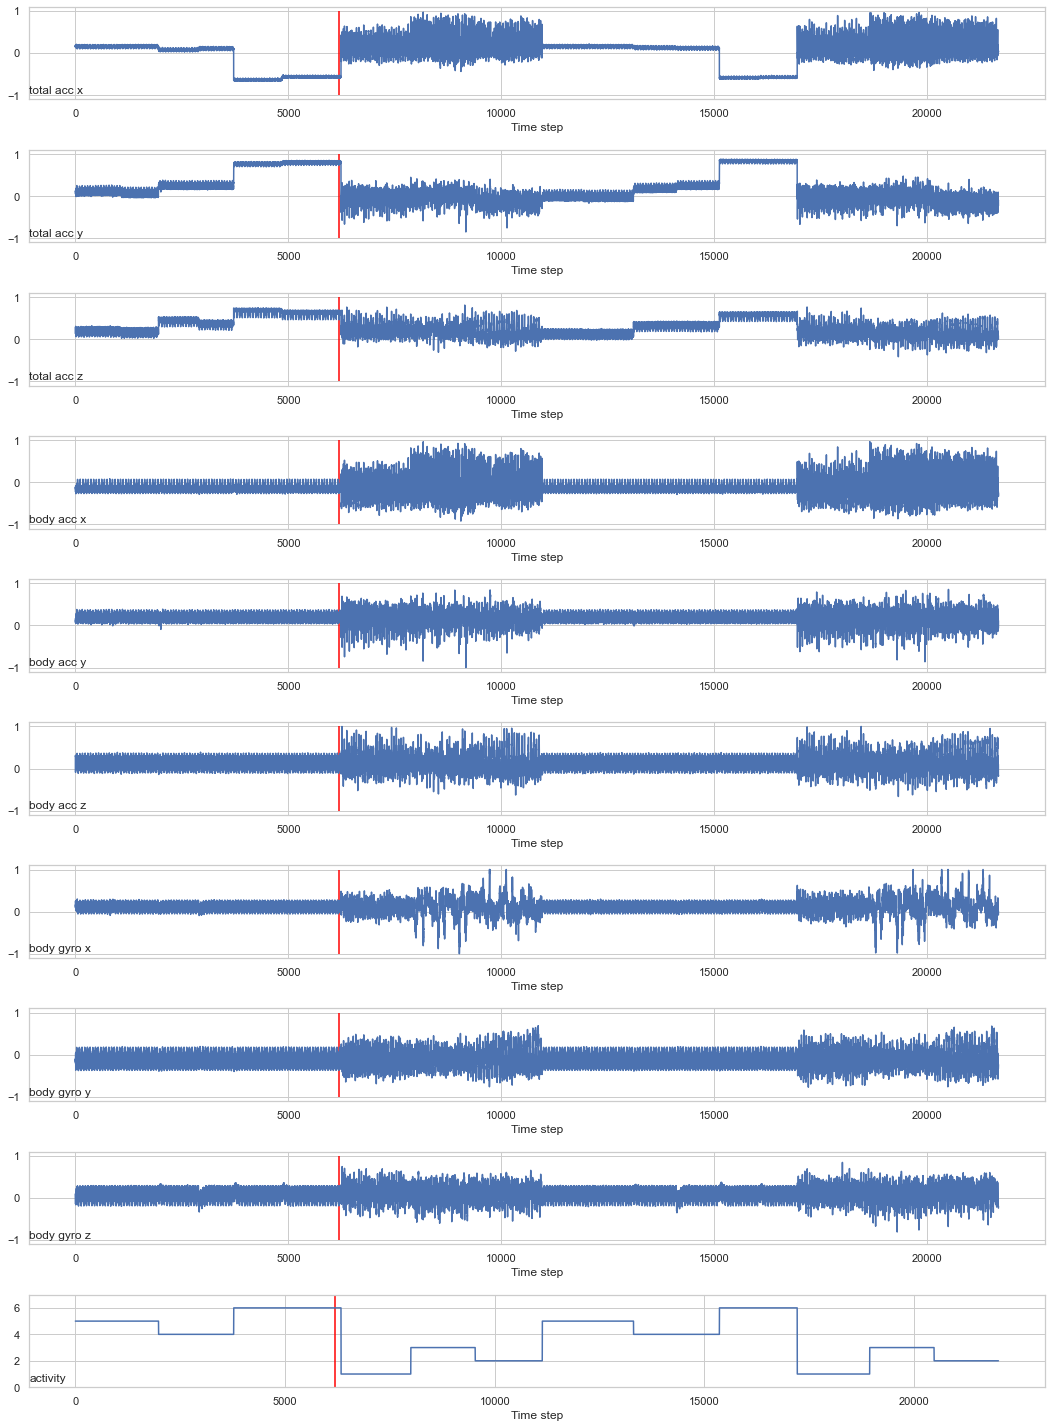

In [79]:
# adapted from https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/
# use all the functions above to visualiase the accelerometer data for one ppant

# load mapping of rows to subjects
sub_map_train = load_file('datasets/HARDataset/train/subject_train.txt')
train_subjects = unique(sub_map_train)
print("train_subjects: ", train_subjects)
sub_map_test = load_file('datasets/HARDataset/test/subject_test.txt')
test_subjects = unique(sub_map_test)
print("test_subjects: ", test_subjects)

# get the data for ith train subject
sub_id = train_subjects[19]
subX, suby = data_for_subject(trainX, trainy, sub_map_train, sub_id)
print(subX.shape, suby.shape)

# plot data for subject
plot_subject(subX, np.repeat(suby, 64))

Here, I've plotted the x,y,z movement data for the 10th participant in the training set. The last subplot, "activity" shows which activity the participant is doing at each time. As earlier, the activities are coded 1-6, where 1 is walking etc.

Here, it is visible that the moving activites (coded 1-3) correspond to higher accelerometer activity, which is a good sogn.

The 9 movement variables also seem to have a lot in common, meaning that the number of features used in a model could possibly be reduced

Also clear now that 21 subjects were used for training, and 9 for testing:
- Training: [ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
- Testing: [ 2  4  9 10 12 13 18 20 24]

### Also, check data provided by each user: how much time does each user spend doing each activity?

In [22]:
# make dataframe to show each window, the participant, and the class of the winfdow side by side for train data
y_train_subject = {'subject': sub_map_train.flatten(), 'activity': trainy.flatten()}
y_train_subject = pd.DataFrame(y_train_subject)
y_train_subject

subject  activity
0           1         5
1           1         5
2           1         5
3           1         5
4           1         5
...       ...       ...
7347       30         2
7348       30         2
7349       30         2
7350       30         2
7351       30         2

[7352 rows x 2 columns]

In [23]:
# do same for test data
y_test_subject = {'subject': sub_map_test.flatten(), 'activity': testy.flatten()}
y_test_subject = pd.DataFrame(y_test_subject)
y_test_subject

subject  activity
0           2         5
1           2         5
2           2         5
3           2         5
4           2         5
...       ...       ...
2942       24         2
2943       24         2
2944       24         2
2945       24         2
2946       24         2

[2947 rows x 2 columns]

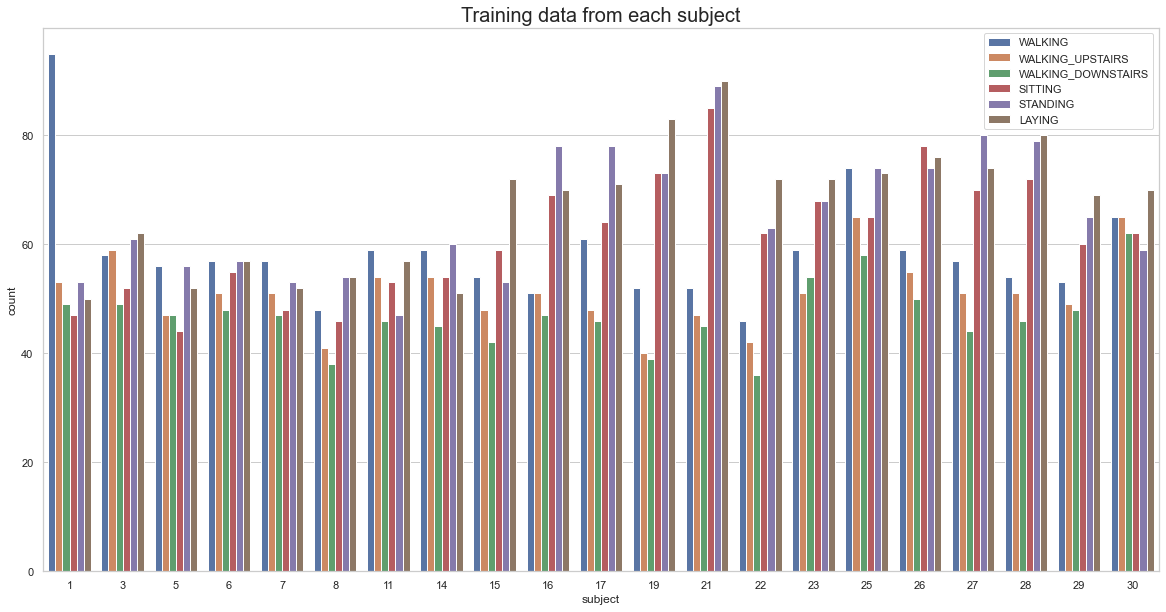

In [24]:
# plot training data from each ppant
plt.figure(figsize=(20,10))
plt.title('Training data from each subject', fontsize=20)
sns.countplot(x='subject',hue='activity', data = y_train_subject)
plt.legend(activity_labels, bbox_to_anchor=(1,1))
plt.show()

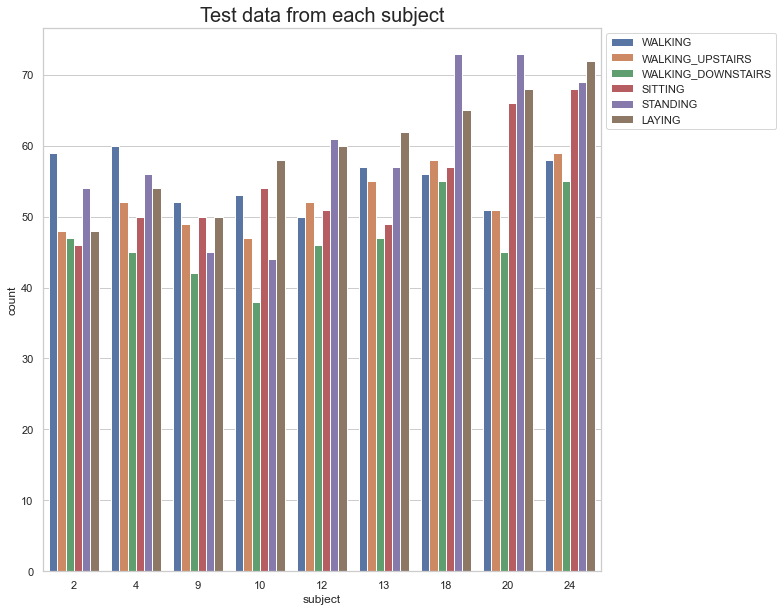

In [25]:
# plot test data from each ppant
plt.figure(figsize=(10,10))
plt.title('Test data from each subject', fontsize=20)
sns.countplot(x='subject',hue='activity', data = y_test_subject)
plt.legend(activity_labels, bbox_to_anchor=(1,1))
plt.show()

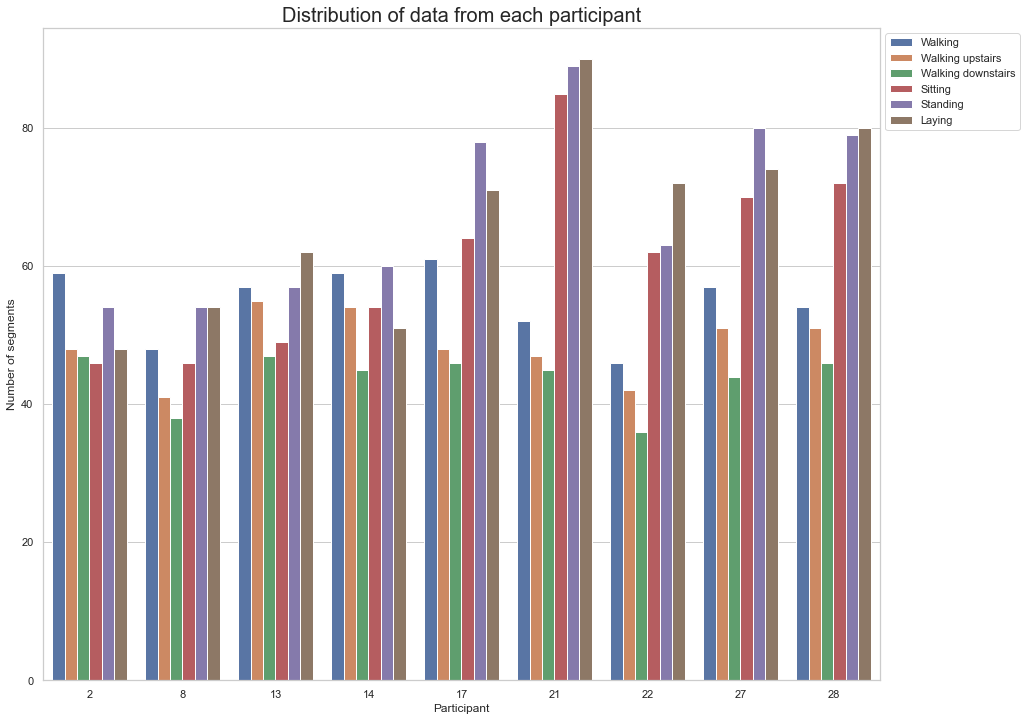

In [26]:
# visualise data for all subjects, but limit to 10 random
y_subject = pd.concat([y_train_subject, y_test_subject])
ax = sns.countplot(x='subject',hue='activity',
                   data = y_subject[y_subject['subject'].isin(np.random.randint(low=0, high=30, size=12))])
ax.set_title("Distribution of data from each participant", fontsize=20)
ax.set(xlabel='Participant',
      ylabel='Number of segments')
ax.legend(activity_labels_neat, bbox_to_anchor=(1,1))

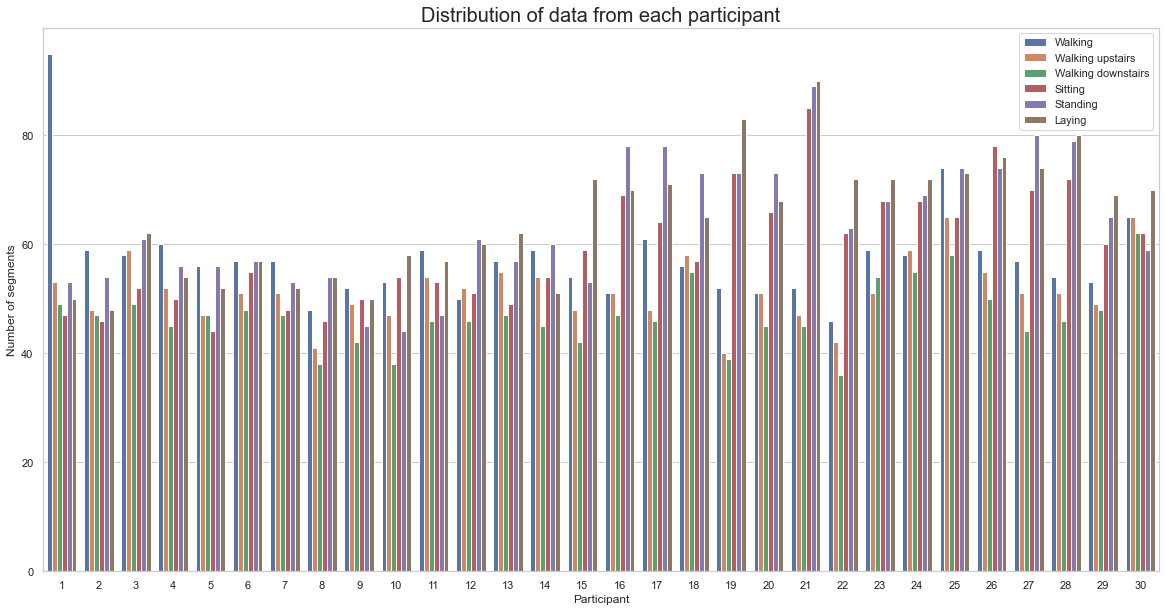

In [27]:
# visualise data for all subjects
plt.figure(figsize=(20,10))
plt.title('Distribution of data from each participant', fontsize=20)
sns.countplot(x='subject',hue='activity', data = y_subject)
plt.legend(activity_labels_neat, bbox_to_anchor=(1,1))
plt.xlabel('Participant')
plt.ylabel('Number of segments')
plt.show()

## Build models

#### Epochs and Batch size are set globally to keep consistency across models

In [28]:
# set epochs and batch size globally
EPOCHS = 5000
BATCH_SIZE = 16
REPEATS = 10

### LSTM Model

In [29]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
# fit and evaluate a model
def fit_model_LSTM(trainX, trainy, testX, testy, epochs = EPOCHS):
    
    # print model type
    print('LSTM')
    
    # extract input and output dimensions fromt the dataset
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    #print(n_outputs)
    
    # define keras sequential model
    model = Sequential()
    # add single lstm hidden layer
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    # add dropout layer intended to reduce overfitting of model to training data
    model.add(Dropout(0.5))
    # add fully connected layer to interpret features extracted by the LSTM hidden layer
    model.add(Dense(100, activation='relu'))
    # add final output layer is used to make predictions
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # change callbacks_list, depending on whether model is being run for dac etc
    if Experiment_type["type"] == "standard":
        callbacks_list = callbacks_list_standard
    elif Experiment_type["type"] == "dac":
        callbacks_list = callbacks_list_dac
    else:
        callbacks_list = callbacks_list_dac_split
       
    # fit network
    history = model.fit(trainX, trainy, epochs=epochs, batch_size=BATCH_SIZE, validation_data=(testX, testy), callbacks=callbacks_list)
#    print("HISTORY", history.history)
    
    # make predictions
    y_pred_train = model.predict(trainX)
    y_pred_test = model.predict(testX)
    
    # make data into array, suitable for confusion matrix
    max_y_pred_train = np.argmax(y_pred_train, axis=1)
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(testy, axis=1)

    return history, max_y_test, max_y_pred_test, max_y_pred_train, time_callback.times

This is a pretty simnple LSTM model, so should be a decent baseline to measure the other models against.

### CNN-LSTM model

In [30]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
# cnn lstm model
# fit and evaluate a model
def fit_model_CNN_LSTM(trainX, trainy, testX, testy, epochs = EPOCHS):
    
    # print model type
    print("CNN-LSTM")
    
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 4, 32
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # change callbacks_list, depending on whether model is being run for dac etc
    if Experiment_type["type"] == "standard":
        callbacks_list = callbacks_list_standard
    elif Experiment_type["type"] == "dac":
        callbacks_list = callbacks_list_dac
    else:
        callbacks_list = callbacks_list_dac_split
       
    # fit network
    history = model.fit(trainX, trainy, epochs=epochs, batch_size=BATCH_SIZE, validation_data=(testX, testy), callbacks=callbacks_list)
    
    # make predictions
    y_pred_train = model.predict(trainX)
    y_pred_test = model.predict(testX)
    
    # make data into array, suitable for confusion matrix
    max_y_pred_train = np.argmax(y_pred_train, axis=1)
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(testy, axis=1)

    return history, max_y_test, max_y_pred_test, max_y_pred_train, time_callback.times

### ConvLSTM Network Model

In [31]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
# convlstm model

# fit and evaluate a model
def fit_model_ConvLSTM(trainX, trainy, testX, testy, epochs = EPOCHS):
    
    # Run on CPU
    with tf.device('/cpu:0'):
    
        # print model type
        print("ConvLSTM")

        # define model
        n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
        # reshape into subsequences (samples, time steps, rows, cols, channels)
        n_steps, n_length = 4, 32
        trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
        testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
        # define model
        model = Sequential()
        model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
        model.add(Dropout(0.5))
        model.add(Flatten())
        model.add(Dense(100, activation='relu'))
        model.add(Dense(n_outputs, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # change callbacks_list, depending on whether model is being run for dac etc
        if Experiment_type["type"] == "standard":
            callbacks_list = callbacks_list_standard
        elif Experiment_type["type"] == "dac":
            callbacks_list = callbacks_list_dac
        else:
            callbacks_list = callbacks_list_dac_split


        # fit network
        history = model.fit(trainX, 
                            trainy, 
                            epochs=epochs, 
                            batch_size=BATCH_SIZE,
                            validation_data=(testX, testy), 
                            callbacks=callbacks_list)

        # make predictions
        y_pred_train = model.predict(trainX)
        y_pred_test = model.predict(testX)

        # make data into array, suitable for confusion matrix
        max_y_pred_train = np.argmax(y_pred_train, axis=1)
        max_y_pred_test = np.argmax(y_pred_test, axis=1)
        max_y_test = np.argmax(testy, axis=1)

    return history, max_y_test, max_y_pred_test, max_y_pred_train, time_callback.times

### Bi-LSTM model

In [32]:
# fit and evaluate a model
def fit_model_Bi_LSTM(trainX, trainy, testX, testy, epochs = EPOCHS):
    
    # print model type
    print("Bi-LSTM")
    
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # define model
    model = Sequential()
    model.add(Bidirectional(LSTM(100,input_shape=(n_timesteps, n_features))))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    

    # change callbacks_list, depending on whether model is being run for dac etc
    if Experiment_type["type"] == "standard":
        callbacks_list = callbacks_list_standard
    elif Experiment_type["type"] == "dac":
        callbacks_list = callbacks_list_dac
    else:
        callbacks_list = callbacks_list_dac_split
    
    # fit network
    history = model.fit(trainX, trainy, epochs=epochs, batch_size=BATCH_SIZE, validation_data=(testX, testy), callbacks=callbacks_list)
    
    # make predictions
    y_pred_train = model.predict(trainX)
    y_pred_test = model.predict(testX)
    
    # make data into array, suitable for confusion matrix
    max_y_pred_train = np.argmax(y_pred_train, axis=1)
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(testy, axis=1)

    return history, max_y_test, max_y_pred_test, max_y_pred_train, time_callback.times

## Run models

### Useful functions

In [33]:
# adapted from https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

# store computation time for models
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [34]:
# define callbacks to be used

# store computation time
time_callback = TimeHistory()

# make model stop training after MINUTES minutes
MINUTES = 5
SECONDS = MINUTES * 60 
# for standard models, set model to run for full time
timeout_standard = tfa.callbacks.TimeStopping(seconds=SECONDS, verbose=1)
# for dac models, where the model is trained in 3 stages, need to set run time to be shorter for consistency
# the split usually works pretty quickly, so can do this in a shorter time
timeout_dac_split = tfa.callbacks.TimeStopping(seconds=int(SECONDS/10), verbose=1)
# allow stationary and moving data equal proportion of remaining time
timeout_dac = tfa.callbacks.TimeStopping(seconds=int(9*SECONDS/20), verbose=1)

# make lists of callbacks used
callbacks_list_standard = [time_callback, timeout_standard]
callbacks_list_dac_split = [time_callback, timeout_dac_split]
callbacks_list_dac = [time_callback, timeout_dac]

In [35]:
# dictionary to store what type of model is being ran
Experiment_type = {}
Experiment_type["type"] = "standard"

In [36]:
# adapted from https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0
# make a pretty confusion matrix
def show_confusion_matrix(validations, predictions):

    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 7))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=activity_labels,
                yticklabels=activity_labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

This function makes a nice confusion matrix, and is useful to have so it can be simply called for each model

In [37]:
# Define dictionaries which store model accuracy, training time, etc

# model accuracy per epoch
epoch_accuracies_train = {}
epoch_accuracies_test = {}

# final model accuracy after training completed
final_model_accuracies_train = {}
final_model_accuracies_test = {}

# get training times per model
training_times = {}

# F1 etc
precision = {}
recall = {}
f1_score = {}

In [38]:
# run an experiment, output loss and accuracy graphs. default as base LSTM
def run_experiment(model_type="lstm"):
    
    # dictionary to store what type of model is being ran
    Experiment_type["type"] = "standard"
    
    # select model type, based on user input 
    if (model_type == 'lstm'):
        fit_model = fit_model_LSTM
    elif (model_type == 'cnnlstm'):
        fit_model = fit_model_CNN_LSTM
    elif (model_type == 'convlstm'):
        fit_model = fit_model_ConvLSTM
    elif (model_type == 'bilstm'):
        fit_model = fit_model_Bi_LSTM
    # print message if wrong input given
    else:
        print('INPUT ERROR. Please see the following possible inputs: ')
        print('For a LSTM model, input "lstm"')
        print('For a CNN-LSTM model, input "cnnlstm"')
        print('For a ConvLSTM model, input "convlstm"')
        print('For a Bi-LSTM model, input "bilstm"')
        return
        
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # run model
    history, max_y_test, max_y_pred_test, max_y_pred_train, times = fit_model(trainX, trainy, testX, testy)
    # get training and test set loss
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    # get training and test accuracy
    train_accuracy = history.history['accuracy']
    test_accuracy = history.history['val_accuracy']    
    # set number of epochs to be dynamic, depending how long experiment runs for
    epochs = range(0,len(test_accuracy))
    
    # plot loss
    plt.plot(epochs, train_loss, 'r', label='Training set loss')
    plt.plot(epochs, test_loss, 'b', label='Test set loss')
    plt.title('Training and Test set loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim([0, 2.0])
    plt.legend()
    plt.show()
    
    # plot accuracy
    plt.plot(epochs, train_accuracy, 'r', label='Training set accuracy')
    plt.plot(epochs, test_accuracy, 'b', label='Test set accuracy')
    plt.title('Training and Test set accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0.6, 1.0])
    plt.legend()
    plt.show()
    
    #get confusion matrix
    show_confusion_matrix(max_y_test, max_y_pred_test)
    
    # show training time
    print("Training time for the model = ", sum(times), " seconds")
    
    # update dictionaries
    epoch_accuracies_train[model_type] = train_accuracy
    epoch_accuracies_test[model_type] = test_accuracy
    final_model_accuracies_train[model_type] = train_accuracy[-1]
    final_model_accuracies_test[model_type] = test_accuracy[-1]
    training_times[model_type] = times = np.cumsum(times)
    precision[model_type] = metrics.precision_score(max_y_test, max_y_pred_test, average='weighted')
    recall[model_type] = metrics.recall_score(max_y_test, max_y_pred_test, average='weighted')
    f1_score[model_type] = metrics.f1_score(max_y_test, max_y_pred_test, average='weighted')
    
    # return metrics
    return (epoch_accuracies_train[model_type], 
    epoch_accuracies_test[model_type],
    final_model_accuracies_train[model_type],
    final_model_accuracies_test[model_type],
    training_times[model_type],
    precision[model_type],
    recall[model_type],
    f1_score[model_type]
    )

## 'Divide and conquer' method

In [39]:
def data_to_binary(data):
    # code testy so that it is either a stationary activity, or a moving activity
    data = data.flatten()

    # empty dictionary to store binary class variable
    data_binary = list()

    # binary class vairable - if stationary = 0, if moving = 1
    for i in range(len(data)):
        if (data[i]) > 3:
            #print(trainy_flat[i])
            data_binary.append(0)
        else:
            data_binary.append(1)

    # change to array for model
    data_binary = np.array(data_binary)
    
    return(data_binary)

In [40]:
# adapted from https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0
# make a pretty confusion matrix, specifically for the d.a.c. model
def show_confusion_matrix_dac(validations, predictions):

    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 7))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=activity_labels_dac,
                yticklabels=activity_labels_dac,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [41]:
# make function that splits data, based on the predicted class
def split_data(data, predictions):
    # set variables to count number of stationary and  moving rows 
    stationary_count = 0
    moving_count = 0

    # count rows
    for i in range(len(data)):
        if predictions[i] == 0:
            stationary_count = stationary_count + 1
        else:
            moving_count = moving_count + 1

    #    print(stationary_count, moving_count)

    # variables to move through arrays in loop
    j = 0
    k = 0

    # initialize arrays to store stationary and moving data
    # if 2d array:
    if (len(data.shape)==2):
        # set shape same as y data
        stationary = np.full([stationary_count, data.shape[1]], 111)
        moving = np.full([moving_count, data.shape[1]], 111)
        # store data
        for i in range(len(data)):    
            if predictions[i] == 0:
                stationary[j] = data[i]
                j = j + 1
            else:
                moving[k] = data[i]
                k = k + 1

    # if 3d array:
    if (len(data.shape)==3):
        # set same shape as X data. also use 5 decimal points so it doesn't round data
        stationary = np.full([stationary_count, data.shape[1], data.shape[2]], 111.11111)
        moving = np.full([moving_count, data.shape[1], data.shape[2]], 111.11111)  
        # store data
        for i in range(len(data)):    
            if predictions[i] == 0:
                stationary[j] = data[i]
                j = j + 1

            else:
                moving[k] = data[i]
                k = k + 1
                
    return(stationary, moving)

In [42]:
# run an experiment using the divide and conquer method. this part classifies the data as either stationary or moving
def run_experiment_dac_split(trainX, trainy, testX, testy, model_type):
    
    # dictionary to store what type of model is being ran
    Experiment_type["type"] = "split"
    
    # select model type, based on user input in previous function
    if (model_type == 'lstm'):
        fit_model = fit_model_LSTM
    elif (model_type == 'cnnlstm'):
        fit_model = fit_model_CNN_LSTM
    elif (model_type == 'convlstm'):
        fit_model = fit_model_ConvLSTM
    elif (model_type == 'bilstm'):
        fit_model = fit_model_Bi_LSTM
    
    # get shape of trainy and testy. required for model to work
    trainy_shape = trainy.shape
    testy_shape = testy.shape
    
    # convert to binary
    trainy = data_to_binary(trainy)
    testy = data_to_binary(testy)
    
    # reshape data to be consistent with earlier method
    trainy = np.reshape(trainy, trainy_shape)
    testy = np.reshape(testy, testy_shape)
    
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    
    # print message to distinguish different output stages
    print("Classify data as either stationary or moving:")
    
    # store computation time
    time_callback = TimeHistory()
    
    # run model
    history, max_y_test, max_y_pred_test, max_y_pred_train, times = fit_model(trainX, trainy, testX, testy, epochs=10)
    
    # change experiment type to dac for next part of model
    Experiment_type["type"] = "dac"
    
    return history, max_y_test, max_y_pred_test, max_y_pred_train, times

In [43]:
# function to get weighted average accuracy of DAC models
def weighted_average(stationary_accuracy,stationary_predictions, moving_accuracy, moving_predictions):
    
    weighted = (stationary_accuracy[-1] * len(stationary_predictions))+(moving_accuracy[-1] * len(moving_predictions))
    
    avg = weighted/(len(stationary_predictions) + len(moving_predictions))
    
    return avg

In [44]:
# function to get weighted average accuracy for each epoch
def weighted_average_per_epoch(stationary_accuracy,stationary_predictions, moving_accuracy, moving_predictions):
    
    weighted_list = list()
    
    # need to make sure it works when number of epochs used in moving and stationary are not equal
    if (len(moving_accuracy) == len(stationary_accuracy)):   
        for i in range(len(stationary_accuracy)):
            weighted = (stationary_accuracy[i] * len(stationary_predictions))+(moving_accuracy[i] * len(moving_predictions))
            avg = weighted/(len(stationary_predictions) + len(moving_predictions))
            weighted_list.append(avg)
    else:
        # if more epochs for moving
        if (len(moving_accuracy) > len(stationary_accuracy)):
            for i in range(len(moving_accuracy)):
                # if at epoch only moving_accuracy has reached
                if (i >= len(stationary_accuracy) - 1):
                    weighted = (stationary_accuracy[-1] * len(stationary_predictions))+(moving_accuracy[i] * len(moving_predictions))
                    avg = weighted/(len(stationary_predictions) + len(moving_predictions))
                    weighted_list.append(avg)
                # when at a number of epochs both have reached
                else:
                    weighted = (stationary_accuracy[i] * len(stationary_predictions))+(moving_accuracy[i] * len(moving_predictions))
                    avg = weighted/(len(stationary_predictions) + len(moving_predictions))
                    weighted_list.append(avg)
        else:
            # if more epochs for stationary
            for i in range(len(stationary_accuracy)):
                # if at epoch only stationary_accuracy has reached
                if (i >= len(moving_accuracy) - 1):
                    weighted = (stationary_accuracy[i] * len(stationary_predictions))+(moving_accuracy[-1] * len(moving_predictions))
                    avg = weighted/(len(stationary_predictions) + len(moving_predictions))
                    weighted_list.append(avg)
                # when at a number of epochs both have reached
                else:
                    weighted = (stationary_accuracy[i] * len(stationary_predictions))+(moving_accuracy[i] * len(moving_predictions))
                    avg = weighted/(len(stationary_predictions) + len(moving_predictions))
                    weighted_list.append(avg)          
        

    return weighted_list

In [45]:
# run an experiment using the divide and conquer method. this part calls the classifiers, then outputs visuals
def run_experiment_dac(model_type="lstm"):
    
    # dictionary to store what type of model is being ran
    Experiment_type["type"] = "dac"
    
    # select model type, based on user input 
    if (model_type == 'lstm'):
        fit_model = fit_model_LSTM
    elif (model_type == 'cnnlstm'):
        fit_model = fit_model_CNN_LSTM
    elif (model_type == 'convlstm'):
        fit_model = fit_model_ConvLSTM
    elif (model_type == 'bilstm'):
        fit_model = fit_model_Bi_LSTM
    # print message if wrong input given
    else:
        print('INPUT ERROR. Please see the following possible inputs: ')
        print('For a LSTM model, input "lstm"')
        print('For a CNN-LSTM model, input "cnnlstm"')
        print('For a ConvLSTM model, input "convlstm"')
        print('For a Bi-LSTM model, input "bilstm"')
        return
        
    # load data, using load_dataset_group instead of load_dataset as we don't want the class one-hot encoded yet
    trainX, trainy = load_dataset_group('train', 'datasets/HARDataset/')
    testX, testy = load_dataset_group('test', 'datasets/HARDataset/')
    
    
    print("SPLITTING DATA:")
    
    # run first classifier, classifying as either stationary or moving
    history_split, max_y_test_split, max_y_pred_test_split, max_y_pred_train_split, times_split = run_experiment_dac_split(trainX,
                                                                                                              trainy,
                                                                                                              testX,
                                                                                                              testy,
                                                                                                              model_type
                                                                                                             )
    
    # use results from first classifier to split data
    # split training and testing data based on the predictions of the model
    trainX_stationary, trainX_moving = split_data(trainX, max_y_pred_train_split)
    testX_stationary, testX_moving = split_data(testX, max_y_pred_test_split)
    trainy_stationary, trainy_moving = split_data(trainy, max_y_pred_train_split)
    testy_stationary, testy_moving = split_data(testy, max_y_pred_test_split)
    
    print("trainy_stationary")
    print(unique(trainy_stationary))
    print("trainy_moving")
    print(unique(trainy_moving))
    print("testy_stationary")
    print(unique(testy_stationary))
    print("testy_moving")
    print(unique(testy_moving))
    
    # one hot encode y
    trainy_stationary = to_categorical(trainy_stationary, num_classes=7)
    testy_stationary = to_categorical(testy_stationary, num_classes=7)
    trainy_moving = to_categorical(trainy_moving, num_classes=7)
    testy_moving = to_categorical(testy_moving, num_classes=7)
    
    
    print()
    print("STATIONARY")

    # input these variables into a classifier for each of stationary and moving
    history_stationary, max_y_test_stationary, max_y_pred_test_stationary, max_y_pred_train_stationary, times_stationary = fit_model(trainX_stationary,
                                                                                                                           trainy_stationary,
                                                                                                                           testX_stationary,
                                                                                                                           testy_stationary)

    print()
    print("MOVING")
    history_moving, max_y_test_moving, max_y_pred_test_moving, max_y_pred_train_moving, times_moving = fit_model(trainX_moving,
                                                                                                           trainy_moving,
                                                                                                           testX_moving,
                                                                                                           testy_moving)
    

    # get training and test set loss for stationary data
    train_loss_stationary = history_stationary.history['loss']
    test_loss_stationary = history_stationary.history['val_loss']
    # get training and test accuracy
    train_accuracy_stationary = history_stationary.history['accuracy']
    test_accuracy_stationary = history_stationary.history['val_accuracy']    
    # set number of epochs to be dynamic, depending how long experiment runs for
    epochs_stationary = range(0,len(test_accuracy_stationary))

    # plot loss for stationary data
    plt.plot(epochs_stationary, train_loss_stationary, 'r', label='Training set loss')
    plt.plot(epochs_stationary, test_loss_stationary, 'b', label='Test set loss')
    plt.title('Training and Test set loss for stationary data')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim([0, 2.0])
    plt.legend()
    plt.show()

    # plot accuracyfor stationary data
    plt.plot(epochs_stationary, train_accuracy_stationary, 'r', label='Training set accuracy')
    plt.plot(epochs_stationary, test_accuracy_stationary, 'b', label='Test set accuracy')
    plt.title('Training and Test set accuracy for stationary data')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0.6, 1.0])
    plt.legend()
    plt.show()

    # get training and test set loss for moving data
    train_loss_moving = history_moving.history['loss']
    test_loss_moving = history_moving.history['val_loss']
    # get training and test accuracy
    train_accuracy_moving = history_moving.history['accuracy']
    test_accuracy_moving = history_moving.history['val_accuracy']    
    # set number of epochs to be dynamic, depending how long experiment runs for
    epochs_moving = range(0,len(test_accuracy_moving))

    # plot loss for moving data
    plt.plot(epochs_moving, train_loss_moving, 'r', label='Training set loss')
    plt.plot(epochs_moving, test_loss_moving, 'b', label='Test set loss')
    plt.title('Training and Test set loss for moving data')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim([0, 2.0])
    plt.legend()
    plt.show()

    # plot accuracy for moving data
    plt.plot(epochs_moving, train_accuracy_moving, 'r', label='Training set accuracy')
    plt.plot(epochs_moving, test_accuracy_moving, 'b', label='Test set accuracy')
    plt.title('Training and Test set accuracy for moving data')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0.6, 1.0])
    plt.legend()
    plt.show()

    # show overall confusion matrix
    max_y_test = np.concatenate((max_y_test_stationary, max_y_test_moving), axis=None)
    max_y_pred_test = np.concatenate((max_y_pred_test_stationary, max_y_pred_test_moving), axis=None)
    print("Overall confusion matrix:")    
    show_confusion_matrix(max_y_test, max_y_pred_test)
    
    # show training time  
    times = [sum(n) for n in zip_longest(times_split, times_stationary, times_moving, fillvalue=0)]
    print("Training time for the model = ", sum(times_split) + sum(times_stationary) + sum(times_moving), " seconds")
    
    
    # get weighted average accuracy
    weighted_accuracy_train = weighted_average(train_accuracy_stationary, max_y_pred_train_stationary, train_accuracy_moving, max_y_pred_train_moving)
    weighted_accuracy_test = weighted_average(test_accuracy_stationary, max_y_pred_test_stationary, test_accuracy_moving, max_y_pred_test_moving)
    print("Weighted average accuracy = ", weighted_accuracy_test)
    
    # get weighted average accuracy per epoch
    weighted_accuracy_per_epoch_train = weighted_average_per_epoch(train_accuracy_stationary,max_y_pred_train_stationary, train_accuracy_moving, max_y_pred_train_moving)
    weighted_accuracy_per_epoch_test = weighted_average_per_epoch(test_accuracy_stationary,max_y_pred_test_stationary, test_accuracy_moving, max_y_pred_test_moving)
    
    # update dictionaries
    epoch_accuracies_train[model_type +"_dac"] = weighted_accuracy_per_epoch_train
    epoch_accuracies_test[model_type +"_dac"] = weighted_accuracy_per_epoch_test
    final_model_accuracies_train[model_type +"_dac"] = weighted_accuracy_train
    final_model_accuracies_test[model_type+"_dac"] = weighted_accuracy_test
    training_times[model_type+"_dac"] = np.cumsum(times)
    precision[model_type + "_dac"] = metrics.precision_score(max_y_test, max_y_pred_test, average='weighted')
    recall[model_type + "_dac"] = metrics.recall_score(max_y_test, max_y_pred_test, average='weighted')
    f1_score[model_type + "_dac"] = metrics.f1_score(max_y_test, max_y_pred_test, average='weighted')
    
    # return metrics etc
    return (epoch_accuracies_train[model_type +"_dac"], 
    epoch_accuracies_test[model_type +"_dac"],
    final_model_accuracies_train[model_type +"_dac"],
    final_model_accuracies_test[model_type +"_dac"],
    training_times[model_type +"_dac"],
    precision[model_type +"_dac"],
    recall[model_type +"_dac"],
    f1_score[model_type +"_dac"]
    )

## Dimensionality reduction

Rather than stacking in a 3d array, aim for a dataframe with one row per timestamp and each column representing a component of acceleration. Then use function to select most important features. One possible issue here, which may stop feature reduction successfully imporving the model, is that the data provided does not provide the activity at each time step but the activity at each window of 128 timesteps. Therefore the activity at each timestep will not neccesarily be accurate.

The features selected may increase overfitting, rather than decrease it for this dataset.

In [46]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
# function to load a single file as a numpy array
def load_file_fr(filepath):
    # load file, depending on which filepath is inputted
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [47]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

load_train_test = {}

# load a list of files into a 3D array of [samples, timesteps, features]
def load_group_fr(filenames, prefix=''):
    loaded = list()
    # make a variable to differentiate between saved scalers
    a = 0
    b = 0
    # for each filename found in load_dataset_group, call load_file_fr to load that file, and append it to the 'loaded' list
    for name in filenames:        
        # load each file
        data = load_file_fr(prefix + name)
        # normalise the data
        scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
        # if training data, fit the scaler
        if (load_train_test['which'] == 'train'):
            scaler.fit(data)
            # save the scaler
            dump(scaler, open(str(a)+'scaler.pkl', 'wb'))
            # transform the data
            data = scaler.transform(data)
            a=a+1
        # if test data, load the relevant scaler then fit it
        elif (load_train_test['which'] == 'test'):
            # load relevant scaler
            scaler = load(open(str(b)+'scaler.pkl', 'rb'))
            # transform the data
            data = scaler.transform(data)   
            b=b+1
        loaded.append(data)
    # stack group so that features are the 3rd dimension
#     loaded = dstack(loaded)
    print("prefix:  ", prefix)
    return loaded
    

In [48]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
# load a dataset group, such as train or test
def load_dataset_group_fr(group, prefix=''):
    # group can be either train or test, depending on which part of load_dataset it was called in.
    # so, here, the filepath will either be:'train/Inertial Signals/' or 'test/Inertial Signals/'
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # this part gets the file names of each of the 9 files in test/train inertial signals, ie:
    # 'total_acc_x_train.txt'
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # call load_group_fr, using the filenames list made just above, and the filepath variable made above that
    # load input data
    X = load_group_fr(filenames, filepath)
    # load class output
    # this gets the y_train or y_test file, depending on group, by calling the load_file_fr function defined earlier
    y = load_file_fr(prefix + group + '/y_'+group+'.txt')
    # return X and y to be used as either trainX and trainy or testX and testY
    return X, y, filenames

In [49]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

# load the dataset, returns train and test X and y elements
def load_dataset_fr(prefix='datasets/'):
    # run load_dataset_group_fr for the training dataset
    # load all train
    load_train_test['which'] = 'train'
    trainX, trainy, filenames_train = load_dataset_group_fr('train', prefix + 'HARDataset/')
#     print("trainX.shape:  ", trainX.shape, "trainy.shape:  ", trainy.shape)
    # run load_dataset_group_fr for the testing dataset
    # load all test
    load_train_test['which'] = 'test'
    testX, testy, filenames_test= load_dataset_group_fr('test', prefix + 'HARDataset/')
#     print("testX.shape:  ", testX.shape, "testy.shape:  ", testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
#     trainy = to_categorical(trainy)
    testy = to_categorical(testy)
#     print("trainX.shape:  ", trainX.shape, "trainy.shape:  ", trainy.shape, "testX.shape:  ", testX.shape, "testy.shape:  ", testy.shape)
    return trainX, trainy, testX, testy, filenames_train, filenames_test

In [ ]:
# load the dataset slightly differently
trainX1, trainy1, testX1, testy1, filenames_train, filenames_test = load_dataset_fr()

In [ ]:
trainX1

In [ ]:
# flatten each array in the trainX1 list
for i in range(len(trainX1)):
    trainX1[i] = trainX1[i].flatten()
    
trainX1

Now each element in the list includes all time steps. The 9 elements in the list correspond to the 9 inertial signal accelerations.

In [ ]:
# make a dictionary for the 9 signals
trainX1_dict = {}
for i in range (len(filenames_train)):
    trainX1_dict[str(filenames_train[i])] = trainX1[i]

# convert to dataframe
trainX1_df = pd.DataFrame(trainX1_dict)
trainX1_df

In [ ]:
# repeat trainy1 128 times, to (roughly) get the activity class at each time step
trainy1_rep = np.repeat(trainy1, 128)
len(trainy1_rep)

In [ ]:
# find most imortant cols in training set
classifier = SelectFromModel(RandomForestClassifier())
classifier.fit(trainX1_df, trainy1_rep)

In [ ]:
# show important cols
features = trainX1_df.columns[(classifier.get_support())]
print(len(features))
print(features)

Now, change the load functions so that only the important features are selected

In [ ]:
# first, need to make it possible to get test features as well
train_features = list(features)
test_features = [feature.replace('train', 'test') for feature in train_features]

print(train_features)
print(test_features)

In [ ]:
# make list of feature names
feature_names = list()
for i in range(len(train_features)):
    feature_names.append(train_features[i][:-4])

In [ ]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
# function to load a single file as a numpy array
def load_file_fr2(filepath):
    # load file, depending on which filepath is inputted
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [ ]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

load_train_test = {}

# load a list of files into a 3D array of [samples, timesteps, features]
def load_group_fr2(filenames, prefix=''):
    loaded = list()
    # make a variable to differentiate between saved scalers
    a = 0
    b = 0
    # for each filename found in load_dataset_group, call load_file_fr2 to load that file, and append it to the 'loaded' list
    for name in filenames:        
        # load each file
        data = load_file_fr2(prefix + name)
        # normalise the data
        scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
        # if training data, fit the scaler
        if (load_train_test['which'] == 'train'):
            scaler.fit(data)
            # save the scaler
            dump(scaler, open(str(a)+'scaler.pkl', 'wb'))
            # transform the data
            data = scaler.transform(data)
            a=a+1
        # if test data, load the relevant scaler then fit it
        elif (load_train_test['which'] == 'test'):
            # load relevant scaler
            scaler = load(open(str(b)+'scaler.pkl', 'rb'))
            # transform the data
            data = scaler.transform(data)   
            b=b+1
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    print("prefix:  ", prefix)
    return loaded
    

In [ ]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
# load a dataset group, such as train or test
def load_dataset_group_fr2(group, filenames, prefix=''):
    # group can be either train or test, depending on which part of load_dataset it was called in.
    # so, here, the filepath will either be:'train/Inertial Signals/' or 'test/Inertial Signals/'
    filepath = prefix + group + '/Inertial Signals/'
    # call load_group_fr2, using the filenames list made just above, and the filepath variable made above that
    # load input data
    X = load_group_fr2(filenames, filepath)
    # load class output
    # this gets the y_train or y_test file, depending on group, by calling the load_file_fr2 function defined earlier
    y = load_file_fr2(prefix + group + '/y_'+group+'.txt')
    # return X and y to be used as either trainX and trainy or testX and testY
    return X, y

In [ ]:
# adapted from https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

# load the dataset, returns train and test X and y elements
def load_dataset_fr2(prefix='datasets/'):
    # run load_dataset_group_fr2 for the training dataset
    print("features selected: ", feature_names)
    # load all train
    load_train_test['which'] = 'train'
    trainX, trainy = load_dataset_group_fr2('train', train_features, prefix + 'HARDataset/')
    print("trainX.shape:  ", trainX.shape, "trainy.shape:  ", trainy.shape)
    # run load_dataset_group_fr2 for the testing dataset
    # load all test
    load_train_test['which'] = 'test'
    testX, testy = load_dataset_group_fr2('test', test_features, prefix + 'HARDataset/')
    print("testX.shape:  ", testX.shape, "testy.shape:  ", testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX.shape:  ", trainX.shape, "trainy.shape:  ", trainy.shape, "testX.shape:  ", testX.shape, "testy.shape:  ", testy.shape)
    return trainX, trainy, testX, testy

In [ ]:
trainX_fr, trainy_fr, testX_fr, testy_fr = load_dataset_fr2()

Now, only the features selectewd above have been loaded for the dataset. This reduced dataset can now be loaded later.

## Repeat Experiments

Finally, to judge more definitively the performance of models, the model training and testing process will be repeated 10 timeas for each model.

In [ ]:
# make variables to store average metrics etc

# model accuracy per epoch
repeat_epoch_accuracies_train = {}
repeat_epoch_accuracies_test = {}

# model accuracy after training completed
repeat_final_model_accuracies_train = {}
repeat_final_model_accuracies_test = {}

# get training times per model
repeat_training_times = {}

# F1 etc
repeat_precision = {}
repeat_recall = {}
repeat_f1_score = {}

In [ ]:
# metrics to store mean values of the runs for each model

mean_final_model_accuracies_train = {}
mean_final_model_accuracies_test = {}
mean_precision  = {}
mean_recall = {}
mean_f1_score = {}


std_final_model_accuracies_train= {}
std_final_model_accuracies_test = {}
std_precision= {}
std_recall = {}
std_f1_score = {}

### Standard models

In [ ]:
# make trimmed down vversion of run_experiment for the repeat experiments
def run_experiment_r(model_type="lstm", data = "original"):
    
    Experiment_type["type"] = "standard"
    
    print(data)
    
    # select model type, based on user input 
    if (model_type == 'lstm'):
        fit_model = fit_model_LSTM
    elif (model_type == 'cnnlstm'):
        fit_model = fit_model_CNN_LSTM
    elif (model_type == 'convlstm'):
        fit_model = fit_model_ConvLSTM
    elif (model_type == 'bilstm'):
        fit_model = fit_model_Bi_LSTM
    # print message if wrong input given
    else:
        print('INPUT ERROR. Please see the following possible inputs: ')
        print('For a LSTM model, input "lstm"')
        print('For a CNN-LSTM model, input "cnnlstm"')
        print('For a ConvLSTM model, input "convlstm"')
        print('For a Bi-LSTM model, input "bilstm"')
        return
    
    # use different datasets depending on user selection
    if (data == "original"):
        trainX_, trainy_, testX_, testy_ = load_dataset()
    elif (data == "reduced"):
        trainX_, trainy_, testX_, testy_ = load_dataset_fr2()
    else:
        print('INPUT ERROR. Please see the following possible inputs: ')
        print('To use the original dataset, input "original"')
        print('To use the feature reduced dataset, input "reduced"')
        return

    # run model
    history, max_y_test, max_y_pred_test, max_y_pred_train, times = fit_model(trainX_, trainy_, testX_, testy_)
    # get training and test set loss
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    # get training and test accuracy
    train_accuracy = history.history['accuracy']
    test_accuracy = history.history['val_accuracy']    
    # set number of epochs to be dynamic, depending how long experiment runs for
    epochs = range(0,len(test_accuracy))
    
    # do normalised cm
    cm = ConfusionMatrix(actual_vector=max_y_test, predict_vector=max_y_pred_test) # Create CM From Data
    cm.plot(cmap=plt.cm.Reds,normalized=True,number_label=True,plot_lib="seaborn")
    
    # return metrics
    return (train_accuracy, 
    test_accuracy,
    train_accuracy[-1],
    test_accuracy[-1],
    np.cumsum(times),
    metrics.precision_score(max_y_test, max_y_pred_test, average='weighted'),
    metrics.recall_score(max_y_test, max_y_pred_test, average='weighted'),
    metrics.f1_score(max_y_test, max_y_pred_test, average='weighted')
    )

In [ ]:
# repeat experiment. choose "original" or "reduced"  dataset
def repeat_experiment(repeats=REPEATS, model_type="lstm", data = "original"):
    
    Experiment_type["type"] = "standard"
    
    
    final_model_accuracies_train = list() 
    final_model_accuracies_test = list()
    precision = list()
    recall = list()
    f1_score = list()
    
    # store model name for storage of results and analysis
    model_name = model_type + "_" + data
    
    # repeat model, storing values each time
    for i in range(repeats):
        print("Run: ", i+1)
        a,b,c,d,e,f,g,h = run_experiment_r(model_type=model_type, data = data)
        
        # add these to the metrics dictionaries
        repeat_epoch_accuracies_train[model_name + "_" + str(i+1)] = a
        repeat_epoch_accuracies_test[model_name + "_" + str(i+1)] = b
        repeat_final_model_accuracies_train[model_name + "_" + str(i+1)] = c
        repeat_final_model_accuracies_test[model_name + "_" + str(i+1)] = d
        repeat_training_times[model_name + "_" + str(i+1)] = e
        repeat_precision[model_name + "_" + str(i+1)] = f
        repeat_recall[model_name + "_" + str(i+1)] = g
        repeat_f1_score[model_name + "_" + str(i+1)] = h
        
        # get mean metrics for each model
        # first, store all metrics for each repeat in a list
        final_model_accuracies_train.append(c)
        final_model_accuracies_test.append(d)
        precision.append(f)
        recall.append(g)
        f1_score.append(h)
        # calculate means
        mean_final_model_accuracies_train[model_name] = mean(final_model_accuracies_train)
        mean_final_model_accuracies_test[model_name] = mean(final_model_accuracies_test)
        mean_precision[model_name] = mean(precision)
        mean_recall[model_name] = mean(recall)
        mean_f1_score[model_name] = mean(f1_score)
        # calculate dtandard deviation
        std_final_model_accuracies_train[model_name] = std(final_model_accuracies_train)
        std_final_model_accuracies_test[model_name] = std(final_model_accuracies_test)
        std_precision[model_name] = std(precision)
        std_recall[model_name] = std(recall)
        std_f1_score[model_name] = std(f1_score)

#### Test run

##### Original Data

In [ ]:
repeat_experiment(model_type="lstm")

In [ ]:
repeat_experiment(model_type="cnnlstm")

In [ ]:
repeat_experiment(model_type="convlstm")

In [ ]:
repeat_experiment(model_type="bilstm")

##### After feature reduction

Run:  1
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
LSTM
Epoch 1/5000
460/460 [==============================] - 5s 8ms/step - loss: 1.2314 - accuracy: 0.4546 - val_loss: 1.2289 - val_accuracy: 0.5158
Epoch 2/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.8199 - accuracy: 0.6254 - val_loss: 0.7429 - val_accuracy: 0.6457
Epoch 3/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.5807 - accuracy: 0.7288 - val_loss: 0.7010 - val_accuracy: 0.7482
Epoch 4/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.3928 - accuracy: 0.8497 - val_loss: 0.4731 - val_accur


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  2
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
LSTM
Epoch 1/5000
460/460 [==============================] - 5s 9ms/step - loss: 1.1447 - accuracy: 0.5110 - val_loss: 1.3697 - val_accuracy: 0.5097
Epoch 2/5000
460/460 [==============================] - 4s 9ms/step - loss: 0.7376 - accuracy: 0.6960 - val_loss: 0.6675 - val_accuracy: 0.7526
Epoch 3/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.4772 - accuracy: 0.8122 - val_loss: 0.5194 - val_accuracy: 0.8476
Epoch 4/5000
460/460 [==============================] - 4s 9ms/step - loss: 0.3196 - accuracy: 0.8818 - val_loss: 0.4298 - val_accur


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  3
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
LSTM
Epoch 1/5000
460/460 [==============================] - 5s 9ms/step - loss: 1.1115 - accuracy: 0.5107 - val_loss: 1.1712 - val_accuracy: 0.4818
Epoch 2/5000
460/460 [==============================] - 4s 8ms/step - loss: 1.1756 - accuracy: 0.5161 - val_loss: 1.3215 - val_accuracy: 0.4510
Epoch 3/5000
460/460 [==============================] - 4s 8ms/step - loss: 1.0033 - accuracy: 0.5834 - val_loss: 1.0660 - val_accuracy: 0.5901
Epoch 4/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.8665 - accuracy: 0.6419 - val_loss: 1.2264 - val_accur


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  4
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
LSTM
Epoch 1/5000
460/460 [==============================] - 5s 9ms/step - loss: 1.0971 - accuracy: 0.5216 - val_loss: 1.1047 - val_accuracy: 0.5324
Epoch 2/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.7190 - accuracy: 0.6956 - val_loss: 0.6754 - val_accuracy: 0.6861
Epoch 3/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.5037 - accuracy: 0.7867 - val_loss: 0.6503 - val_accuracy: 0.7842
Epoch 4/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.4852 - accuracy: 0.8120 - val_loss: 0.5261 - val_accur


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  5
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
LSTM
Epoch 1/5000
460/460 [==============================] - 5s 9ms/step - loss: 1.1886 - accuracy: 0.4771 - val_loss: 1.3370 - val_accuracy: 0.4374
Epoch 2/5000
460/460 [==============================] - 4s 8ms/step - loss: 1.0237 - accuracy: 0.5486 - val_loss: 1.1804 - val_accuracy: 0.4944
Epoch 3/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.7245 - accuracy: 0.6832 - val_loss: 0.7276 - val_accuracy: 0.6702
Epoch 4/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.5573 - accuracy: 0.7783 - val_loss: 0.8006 - val_accur


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  6
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
LSTM
Epoch 1/5000
460/460 [==============================] - 5s 9ms/step - loss: 1.1015 - accuracy: 0.5265 - val_loss: 1.1452 - val_accuracy: 0.5399
Epoch 2/5000
460/460 [==============================] - 4s 9ms/step - loss: 0.6891 - accuracy: 0.7013 - val_loss: 0.6587 - val_accuracy: 0.7598
Epoch 3/5000
460/460 [==============================] - 4s 9ms/step - loss: 0.5386 - accuracy: 0.8014 - val_loss: 0.8353 - val_accuracy: 0.6820
Epoch 4/5000
460/460 [==============================] - 4s 9ms/step - loss: 0.5036 - accuracy: 0.8024 - val_loss: 0.5358 - val_accur


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  7
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
LSTM
Epoch 1/5000
460/460 [==============================] - 5s 10ms/step - loss: 1.1583 - accuracy: 0.4995 - val_loss: 1.2092 - val_accuracy: 0.4985
Epoch 2/5000
460/460 [==============================] - 4s 9ms/step - loss: 0.9990 - accuracy: 0.5737 - val_loss: 1.0648 - val_accuracy: 0.5819
Epoch 3/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.5997 - accuracy: 0.7622 - val_loss: 0.7962 - val_accuracy: 0.7465
Epoch 4/5000
460/460 [==============================] - 4s 9ms/step - loss: 0.4534 - accuracy: 0.8256 - val_loss: 0.4887 - val_accu


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  8
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
LSTM
Epoch 1/5000
460/460 [==============================] - 5s 8ms/step - loss: 1.1034 - accuracy: 0.5203 - val_loss: 1.1382 - val_accuracy: 0.5338
Epoch 2/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.9737 - accuracy: 0.5932 - val_loss: 1.1302 - val_accuracy: 0.4873
Epoch 3/5000
460/460 [==============================] - 4s 8ms/step - loss: 1.1041 - accuracy: 0.5263 - val_loss: 1.1717 - val_accuracy: 0.5175
Epoch 4/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.7863 - accuracy: 0.6646 - val_loss: 0.6908 - val_accur


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  9
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
LSTM
Epoch 1/5000
460/460 [==============================] - 5s 9ms/step - loss: 1.1882 - accuracy: 0.4951 - val_loss: 1.3194 - val_accuracy: 0.4642
Epoch 2/5000
460/460 [==============================] - 4s 8ms/step - loss: 1.0525 - accuracy: 0.5438 - val_loss: 1.2722 - val_accuracy: 0.4941
Epoch 3/5000
460/460 [==============================] - 4s 8ms/step - loss: 1.0202 - accuracy: 0.5555 - val_loss: 1.2276 - val_accuracy: 0.5192
Epoch 4/5000
460/460 [==============================] - 4s 8ms/step - loss: 1.1839 - accuracy: 0.5058 - val_loss: 1.2623 - val_accur


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  10
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
LSTM
Epoch 1/5000
460/460 [==============================] - 5s 8ms/step - loss: 1.2061 - accuracy: 0.4641 - val_loss: 1.3085 - val_accuracy: 0.4985
Epoch 2/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.9528 - accuracy: 0.5949 - val_loss: 0.9194 - val_accuracy: 0.5585
Epoch 3/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.7190 - accuracy: 0.6904 - val_loss: 0.6737 - val_accuracy: 0.7387
Epoch 4/5000
460/460 [==============================] - 4s 8ms/step - loss: 0.4484 - accuracy: 0.8224 - val_loss: 0.4110 - val_accu


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


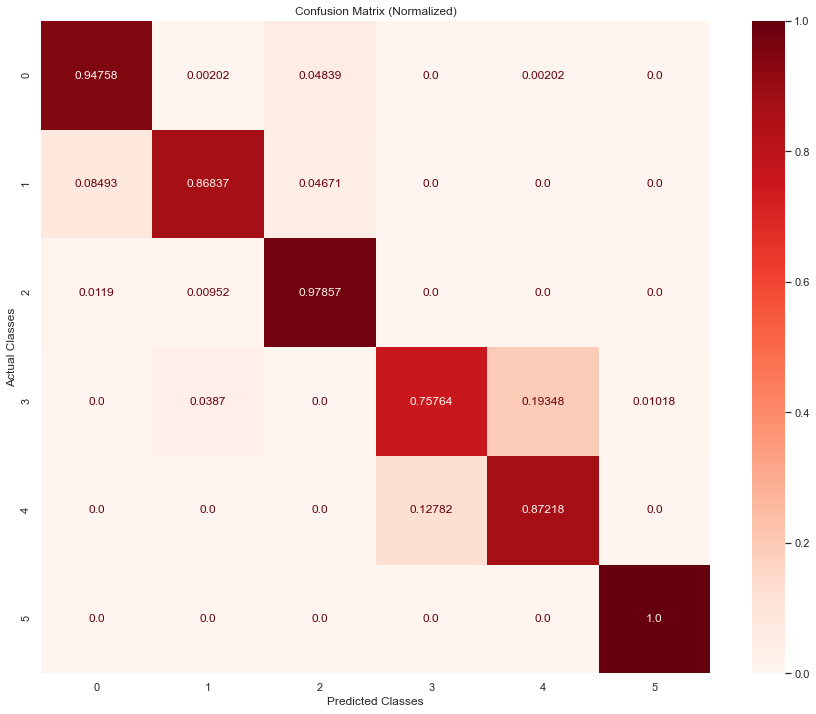

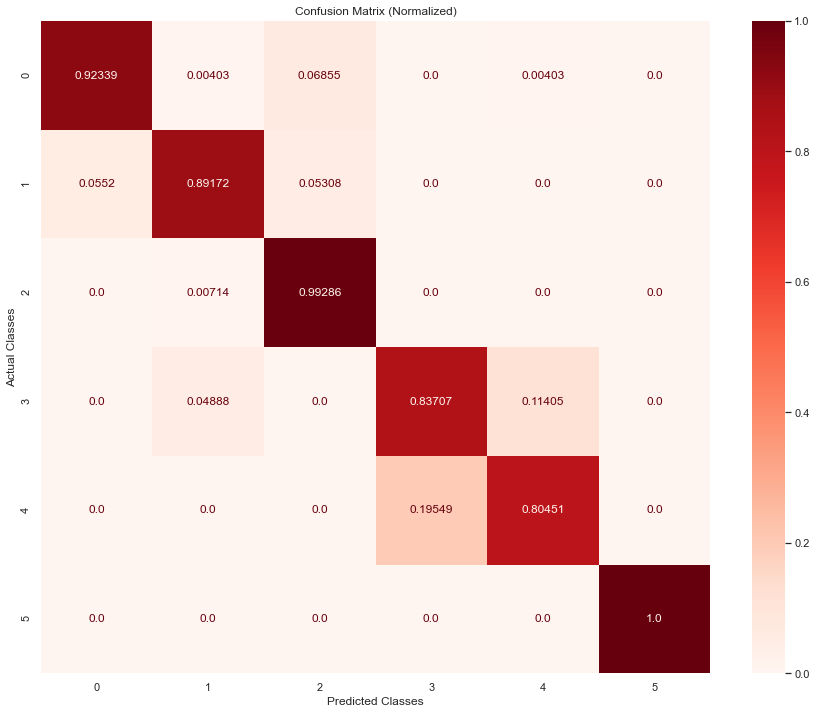

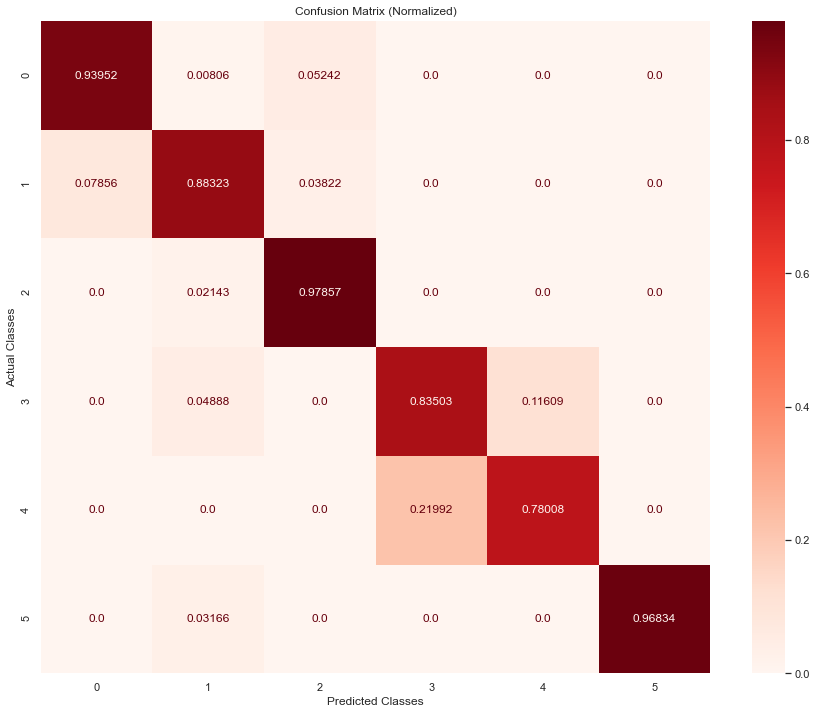

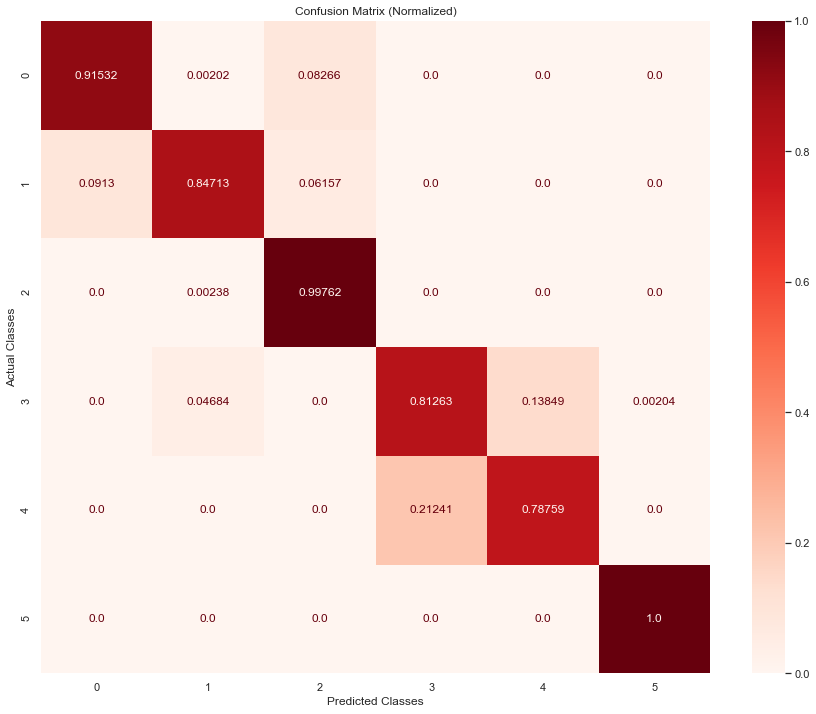

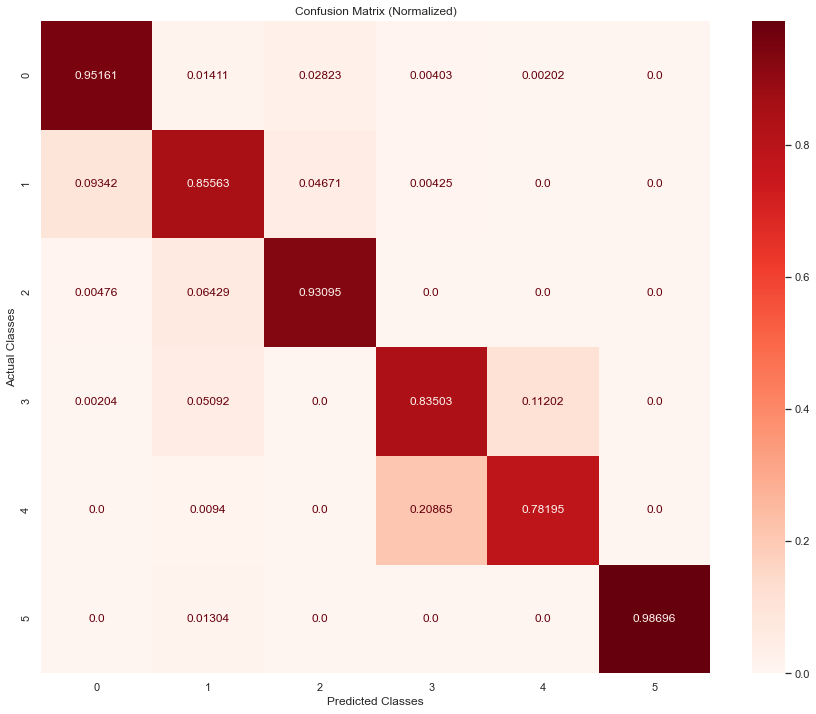

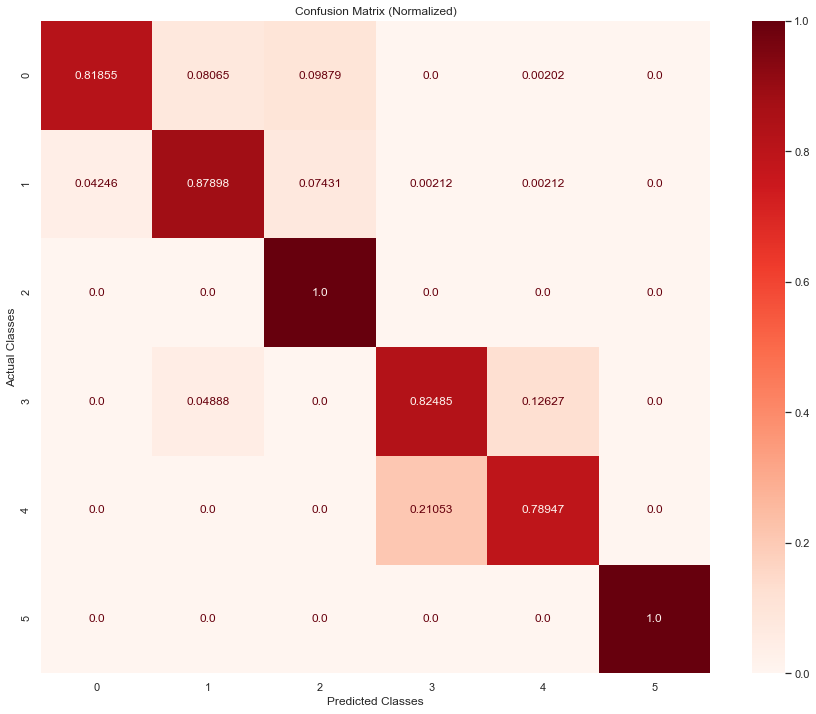

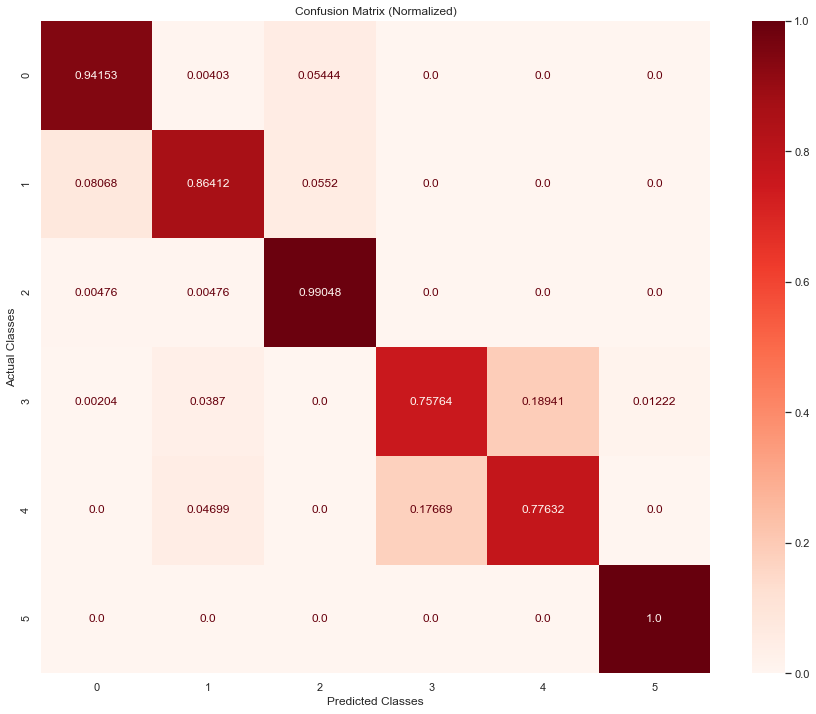

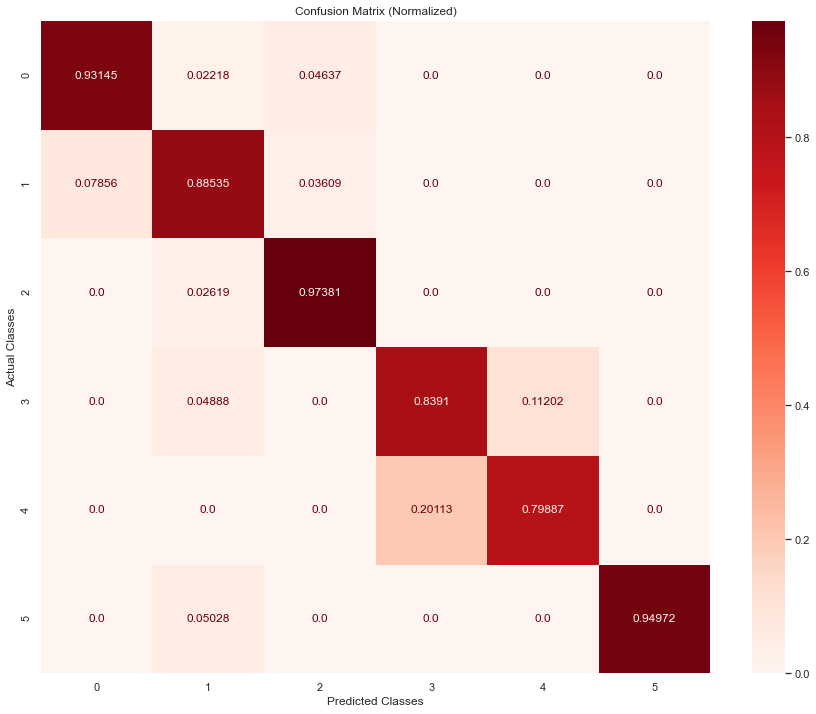

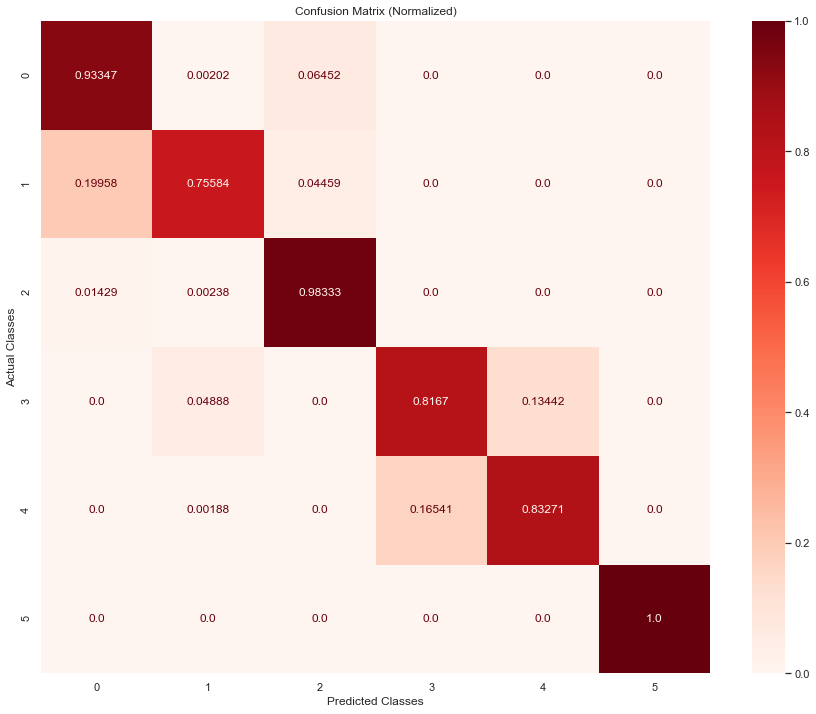

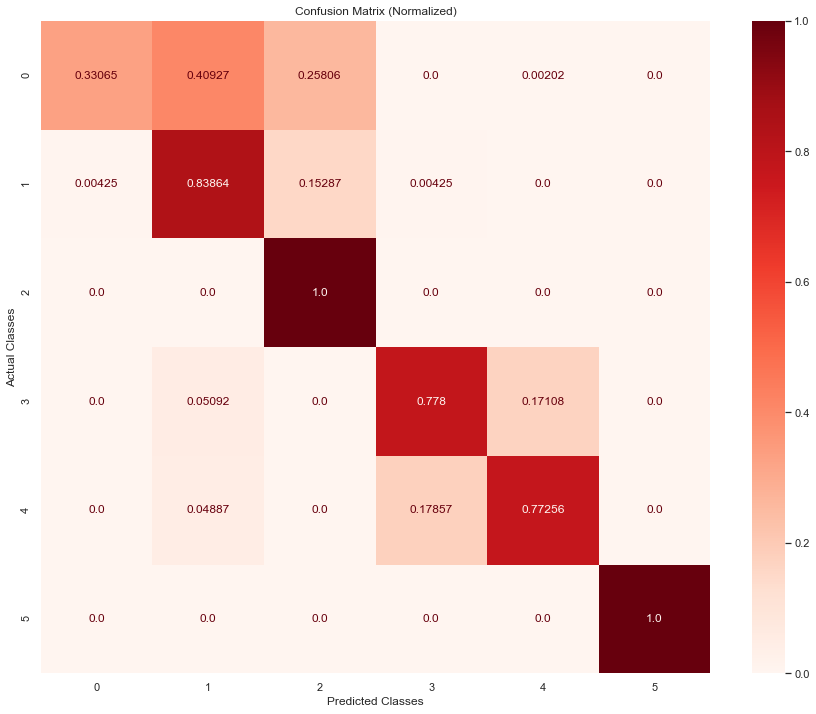

In [72]:
repeat_experiment(model_type="lstm", data = "reduced")

Run:  1
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
CNN-LSTM
Epoch 1/5000
460/460 [==============================] - 3s 5ms/step - loss: 0.5293 - accuracy: 0.7892 - val_loss: 0.5457 - val_accuracy: 0.7927
Epoch 2/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.2321 - accuracy: 0.9104 - val_loss: 0.4432 - val_accuracy: 0.8473
Epoch 3/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.1606 - accuracy: 0.9343 - val_loss: 0.4505 - val_accuracy: 0.8704
Epoch 4/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.1426 - accuracy: 0.9437 - val_loss: 0.5316 - val_a

460/460 [==============================] - 2s 4ms/step - loss: 0.0329 - accuracy: 0.9872 - val_loss: 1.1450 - val_accuracy: 0.8541
Epoch 111/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0304 - accuracy: 0.9872 - val_loss: 1.1630 - val_accuracy: 0.8612
Epoch 112/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0432 - accuracy: 0.9838 - val_loss: 1.2163 - val_accuracy: 0.8578
Epoch 113/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0281 - accuracy: 0.9864 - val_loss: 1.3409 - val_accuracy: 0.8517
Epoch 114/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0325 - accuracy: 0.9860 - val_loss: 1.2164 - val_accuracy: 0.8548
Epoch 115/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0295 - accuracy: 0.9869 - val_loss: 1.2558 - val_accuracy: 0.8649
Epoch 116/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0306 - accuracy: 0.9856 - val_loss: 1.3579 - val_accuracy: 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  2
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
CNN-LSTM
Epoch 1/5000
460/460 [==============================] - 4s 5ms/step - loss: 0.5359 - accuracy: 0.7767 - val_loss: 0.7108 - val_accuracy: 0.7482
Epoch 2/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.2336 - accuracy: 0.9056 - val_loss: 0.4601 - val_accuracy: 0.8476
Epoch 3/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.1651 - accuracy: 0.9331 - val_loss: 0.5242 - val_accuracy: 0.8571
Epoch 4/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.1394 - accuracy: 0.9445 - val_loss: 0.5706 - val_a

460/460 [==============================] - 2s 5ms/step - loss: 0.0283 - accuracy: 0.9861 - val_loss: 1.3388 - val_accuracy: 0.8738
Epoch 111/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0307 - accuracy: 0.9860 - val_loss: 1.3458 - val_accuracy: 0.8697
Epoch 112/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0327 - accuracy: 0.9841 - val_loss: 1.3161 - val_accuracy: 0.8677
Epoch 113/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0280 - accuracy: 0.9865 - val_loss: 1.5017 - val_accuracy: 0.8626
Epoch 114/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0403 - accuracy: 0.9827 - val_loss: 1.2037 - val_accuracy: 0.8795
Epoch 115/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0358 - accuracy: 0.9849 - val_loss: 1.3825 - val_accuracy: 0.8616
Epoch 116/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0330 - accuracy: 0.9864 - val_loss: 1.3828 - val_accuracy: 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  3
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
CNN-LSTM
Epoch 1/5000
460/460 [==============================] - 3s 5ms/step - loss: 0.5237 - accuracy: 0.7867 - val_loss: 0.5828 - val_accuracy: 0.7855
Epoch 2/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.2435 - accuracy: 0.9018 - val_loss: 0.5410 - val_accuracy: 0.8215
Epoch 3/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.1670 - accuracy: 0.9327 - val_loss: 0.5576 - val_accuracy: 0.8565
Epoch 4/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.1446 - accuracy: 0.9419 - val_loss: 0.5562 - val_a

460/460 [==============================] - 2s 5ms/step - loss: 0.0347 - accuracy: 0.9852 - val_loss: 1.5285 - val_accuracy: 0.8585
Epoch 111/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0275 - accuracy: 0.9872 - val_loss: 1.6070 - val_accuracy: 0.8595
Epoch 112/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0353 - accuracy: 0.9842 - val_loss: 1.5675 - val_accuracy: 0.8582
Epoch 113/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0367 - accuracy: 0.9846 - val_loss: 1.4802 - val_accuracy: 0.8473
Epoch 114/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0341 - accuracy: 0.9838 - val_loss: 1.4599 - val_accuracy: 0.8575
Epoch 115/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0318 - accuracy: 0.9868 - val_loss: 1.3357 - val_accuracy: 0.8629
Epoch 116/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0313 - accuracy: 0.9876 - val_loss: 1.5228 - val_accuracy: 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  4
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
CNN-LSTM
Epoch 1/5000
460/460 [==============================] - 3s 5ms/step - loss: 0.5434 - accuracy: 0.7792 - val_loss: 0.5734 - val_accuracy: 0.7838
Epoch 2/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.2073 - accuracy: 0.9169 - val_loss: 0.4023 - val_accuracy: 0.8677
Epoch 3/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.1558 - accuracy: 0.9353 - val_loss: 0.3582 - val_accuracy: 0.8884
Epoch 4/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.1455 - accuracy: 0.9421 - val_loss: 0.4571 - val_a

460/460 [==============================] - 2s 4ms/step - loss: 0.0293 - accuracy: 0.9863 - val_loss: 1.1652 - val_accuracy: 0.8748
Epoch 111/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0370 - accuracy: 0.9837 - val_loss: 1.1711 - val_accuracy: 0.8643
Epoch 112/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0332 - accuracy: 0.9854 - val_loss: 1.2776 - val_accuracy: 0.8619
Epoch 113/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0316 - accuracy: 0.9859 - val_loss: 1.3029 - val_accuracy: 0.8588
Epoch 114/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0391 - accuracy: 0.9842 - val_loss: 1.1060 - val_accuracy: 0.8629
Epoch 115/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0313 - accuracy: 0.9868 - val_loss: 0.9503 - val_accuracy: 0.8694
Epoch 116/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0342 - accuracy: 0.9846 - val_loss: 1.0409 - val_accuracy: 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  5
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
CNN-LSTM
Epoch 1/5000
460/460 [==============================] - 3s 5ms/step - loss: 0.5472 - accuracy: 0.7763 - val_loss: 0.5502 - val_accuracy: 0.7944
Epoch 2/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.2184 - accuracy: 0.9109 - val_loss: 0.5161 - val_accuracy: 0.8426
Epoch 3/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.1624 - accuracy: 0.9335 - val_loss: 0.4785 - val_accuracy: 0.8765
Epoch 4/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.1625 - accuracy: 0.9366 - val_loss: 0.4587 - val_a

460/460 [==============================] - 2s 4ms/step - loss: 0.0274 - accuracy: 0.9879 - val_loss: 1.2037 - val_accuracy: 0.8622
Epoch 111/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0278 - accuracy: 0.9880 - val_loss: 1.2121 - val_accuracy: 0.8656
Epoch 112/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0234 - accuracy: 0.9883 - val_loss: 1.3065 - val_accuracy: 0.8704
Epoch 113/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0325 - accuracy: 0.9856 - val_loss: 1.2514 - val_accuracy: 0.8643
Epoch 114/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0292 - accuracy: 0.9871 - val_loss: 1.2638 - val_accuracy: 0.8653
Epoch 115/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0297 - accuracy: 0.9871 - val_loss: 1.2548 - val_accuracy: 0.8772
Epoch 116/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0350 - accuracy: 0.9865 - val_loss: 1.1557 - val_accuracy: 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  6
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
CNN-LSTM
Epoch 1/5000
460/460 [==============================] - 3s 5ms/step - loss: 0.5366 - accuracy: 0.7831 - val_loss: 0.5080 - val_accuracy: 0.7835
Epoch 2/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.2309 - accuracy: 0.9091 - val_loss: 0.4450 - val_accuracy: 0.8544
Epoch 3/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.1645 - accuracy: 0.9339 - val_loss: 0.5777 - val_accuracy: 0.8120
Epoch 4/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.1388 - accuracy: 0.9442 - val_loss: 0.6160 - val_a

460/460 [==============================] - 2s 4ms/step - loss: 0.0316 - accuracy: 0.9868 - val_loss: 1.1112 - val_accuracy: 0.8633
Epoch 111/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0320 - accuracy: 0.9874 - val_loss: 1.0508 - val_accuracy: 0.8728
Epoch 112/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0327 - accuracy: 0.9864 - val_loss: 1.2697 - val_accuracy: 0.8622
Epoch 113/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0321 - accuracy: 0.9841 - val_loss: 1.3268 - val_accuracy: 0.8680
Epoch 114/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0252 - accuracy: 0.9879 - val_loss: 1.3635 - val_accuracy: 0.8683
Epoch 115/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0278 - accuracy: 0.9879 - val_loss: 1.3843 - val_accuracy: 0.8683
Epoch 116/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0309 - accuracy: 0.9872 - val_loss: 1.3669 - val_accuracy: 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  7
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
CNN-LSTM
Epoch 1/5000
460/460 [==============================] - 3s 5ms/step - loss: 0.5608 - accuracy: 0.7726 - val_loss: 0.4769 - val_accuracy: 0.7862
Epoch 2/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.2301 - accuracy: 0.9082 - val_loss: 0.4929 - val_accuracy: 0.8395
Epoch 3/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.1633 - accuracy: 0.9357 - val_loss: 0.5076 - val_accuracy: 0.8470
Epoch 4/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.1432 - accuracy: 0.9431 - val_loss: 0.4004 - val_a

460/460 [==============================] - 2s 4ms/step - loss: 0.0255 - accuracy: 0.9876 - val_loss: 1.2223 - val_accuracy: 0.8680
Epoch 111/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0358 - accuracy: 0.9833 - val_loss: 1.1657 - val_accuracy: 0.8599
Epoch 112/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0333 - accuracy: 0.9861 - val_loss: 1.3540 - val_accuracy: 0.8568
Epoch 113/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0376 - accuracy: 0.9837 - val_loss: 1.1712 - val_accuracy: 0.8633
Epoch 114/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0267 - accuracy: 0.9893 - val_loss: 1.0908 - val_accuracy: 0.8673
Epoch 115/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0270 - accuracy: 0.9876 - val_loss: 1.1728 - val_accuracy: 0.8711
Epoch 116/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0283 - accuracy: 0.9879 - val_loss: 1.1514 - val_accuracy: 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  8
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
CNN-LSTM
Epoch 1/5000
460/460 [==============================] - 3s 5ms/step - loss: 0.5569 - accuracy: 0.7692 - val_loss: 0.5207 - val_accuracy: 0.8117
Epoch 2/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.2257 - accuracy: 0.9106 - val_loss: 0.5047 - val_accuracy: 0.8453
Epoch 3/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.1734 - accuracy: 0.9339 - val_loss: 0.4489 - val_accuracy: 0.8500
Epoch 4/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.1539 - accuracy: 0.9397 - val_loss: 0.4034 - val_a

460/460 [==============================] - 2s 5ms/step - loss: 0.0270 - accuracy: 0.9874 - val_loss: 1.4497 - val_accuracy: 0.8700
Epoch 111/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0336 - accuracy: 0.9849 - val_loss: 1.3821 - val_accuracy: 0.8612
Epoch 112/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0308 - accuracy: 0.9861 - val_loss: 1.6239 - val_accuracy: 0.8341
Epoch 113/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0394 - accuracy: 0.9844 - val_loss: 1.1009 - val_accuracy: 0.8694
Epoch 114/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0329 - accuracy: 0.9846 - val_loss: 1.2678 - val_accuracy: 0.8826
Epoch 115/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0376 - accuracy: 0.9850 - val_loss: 1.2222 - val_accuracy: 0.8819
Epoch 116/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0291 - accuracy: 0.9861 - val_loss: 1.2756 - val_accuracy: 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  9
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
CNN-LSTM
Epoch 1/5000
460/460 [==============================] - 3s 5ms/step - loss: 0.5605 - accuracy: 0.7703 - val_loss: 0.7384 - val_accuracy: 0.7486
Epoch 2/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.2505 - accuracy: 0.9023 - val_loss: 0.4934 - val_accuracy: 0.8483
Epoch 3/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.1779 - accuracy: 0.9308 - val_loss: 0.5670 - val_accuracy: 0.8463
Epoch 4/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.1492 - accuracy: 0.9410 - val_loss: 0.5458 - val_a

460/460 [==============================] - 2s 4ms/step - loss: 0.0278 - accuracy: 0.9878 - val_loss: 1.5350 - val_accuracy: 0.8616
Epoch 111/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0280 - accuracy: 0.9876 - val_loss: 1.4802 - val_accuracy: 0.8602
Epoch 112/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0463 - accuracy: 0.9816 - val_loss: 1.8884 - val_accuracy: 0.8212
Epoch 113/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0473 - accuracy: 0.9795 - val_loss: 1.2902 - val_accuracy: 0.8534
Epoch 114/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0357 - accuracy: 0.9825 - val_loss: 1.3480 - val_accuracy: 0.8487
Epoch 115/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0326 - accuracy: 0.9859 - val_loss: 1.4601 - val_accuracy: 0.8436
Epoch 116/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0349 - accuracy: 0.9842 - val_loss: 1.3830 - val_accuracy: 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  10
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
CNN-LSTM
Epoch 1/5000
460/460 [==============================] - 3s 5ms/step - loss: 0.5489 - accuracy: 0.7756 - val_loss: 0.5435 - val_accuracy: 0.7838
Epoch 2/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.2428 - accuracy: 0.9045 - val_loss: 0.4238 - val_accuracy: 0.8432
Epoch 3/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.1780 - accuracy: 0.9304 - val_loss: 0.5315 - val_accuracy: 0.8497
Epoch 4/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.1397 - accuracy: 0.9431 - val_loss: 0.5291 - val_

460/460 [==============================] - 2s 5ms/step - loss: 0.0410 - accuracy: 0.9837 - val_loss: 1.2200 - val_accuracy: 0.8643
Epoch 111/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0348 - accuracy: 0.9819 - val_loss: 1.1399 - val_accuracy: 0.8680
Epoch 112/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0343 - accuracy: 0.9833 - val_loss: 1.2825 - val_accuracy: 0.8663
Epoch 113/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0335 - accuracy: 0.9853 - val_loss: 1.3362 - val_accuracy: 0.8599
Epoch 114/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0275 - accuracy: 0.9882 - val_loss: 1.2680 - val_accuracy: 0.8633
Epoch 115/5000
460/460 [==============================] - 2s 4ms/step - loss: 0.0326 - accuracy: 0.9854 - val_loss: 1.1999 - val_accuracy: 0.8639
Epoch 116/5000
460/460 [==============================] - 2s 5ms/step - loss: 0.0296 - accuracy: 0.9853 - val_loss: 1.4169 - val_accuracy: 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


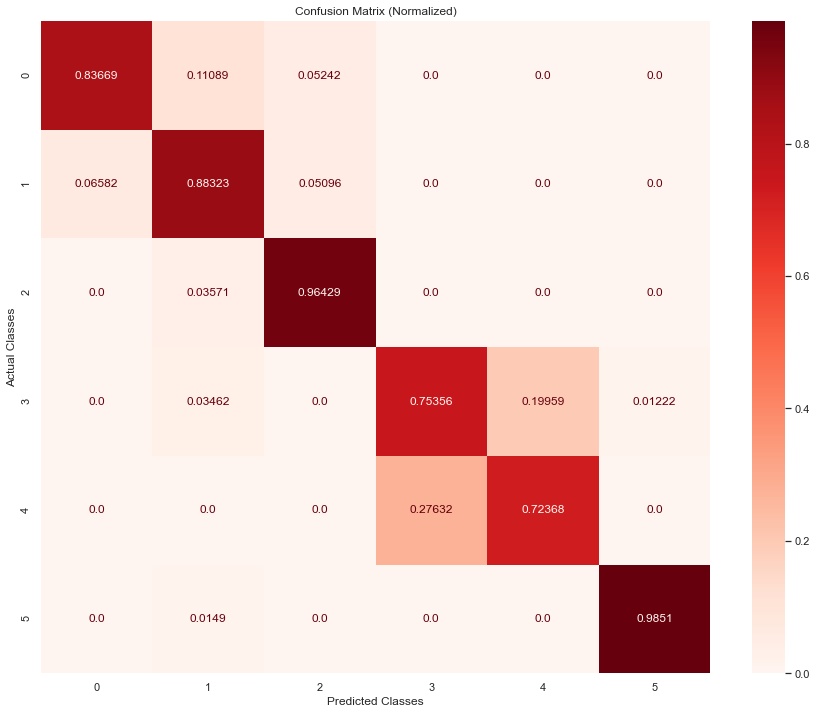

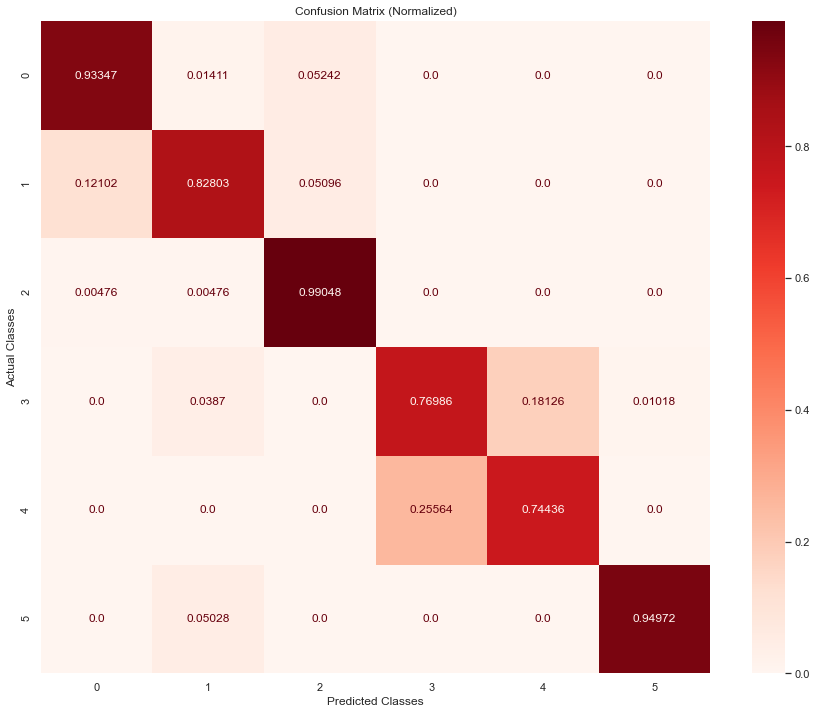

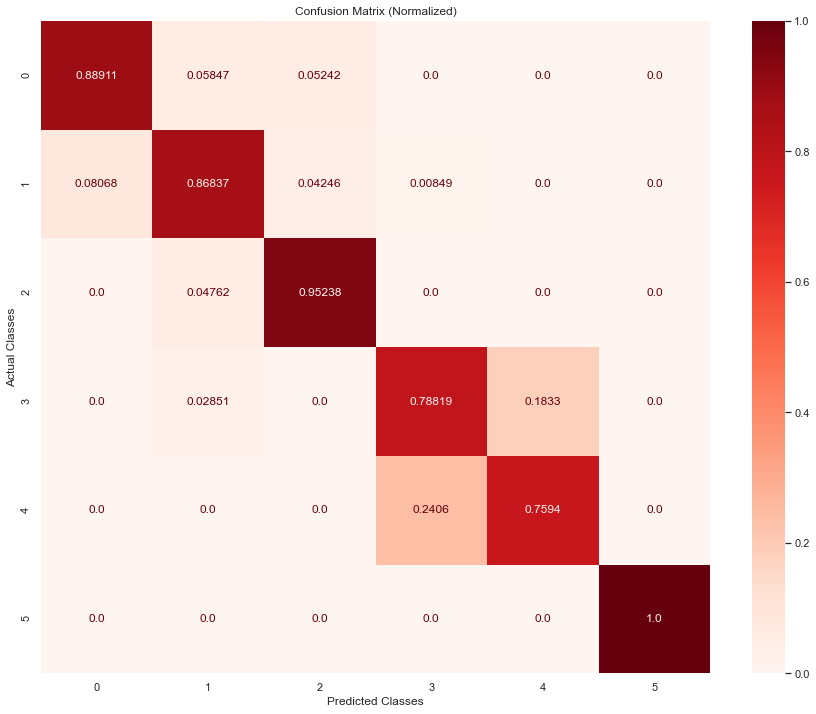

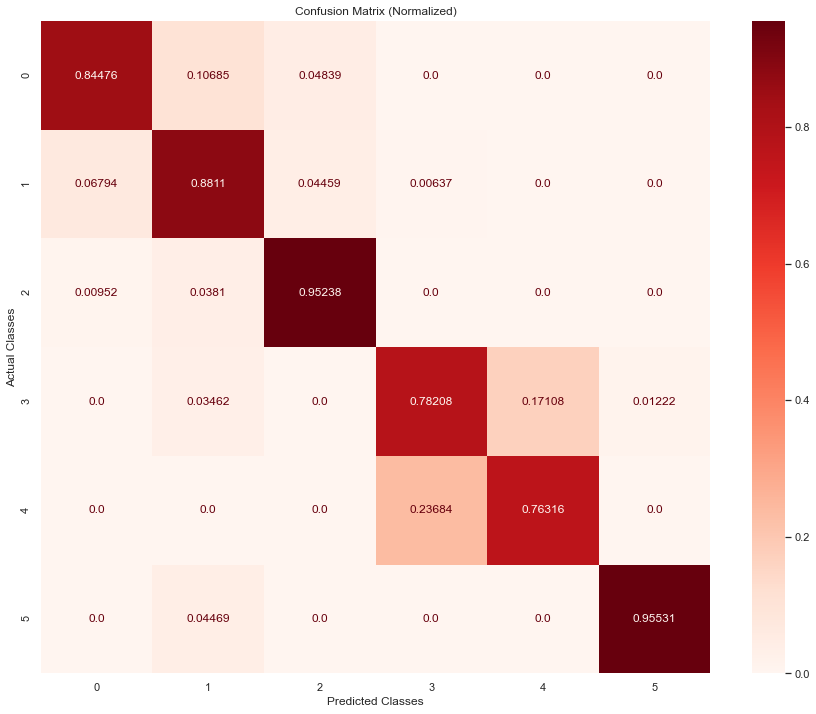

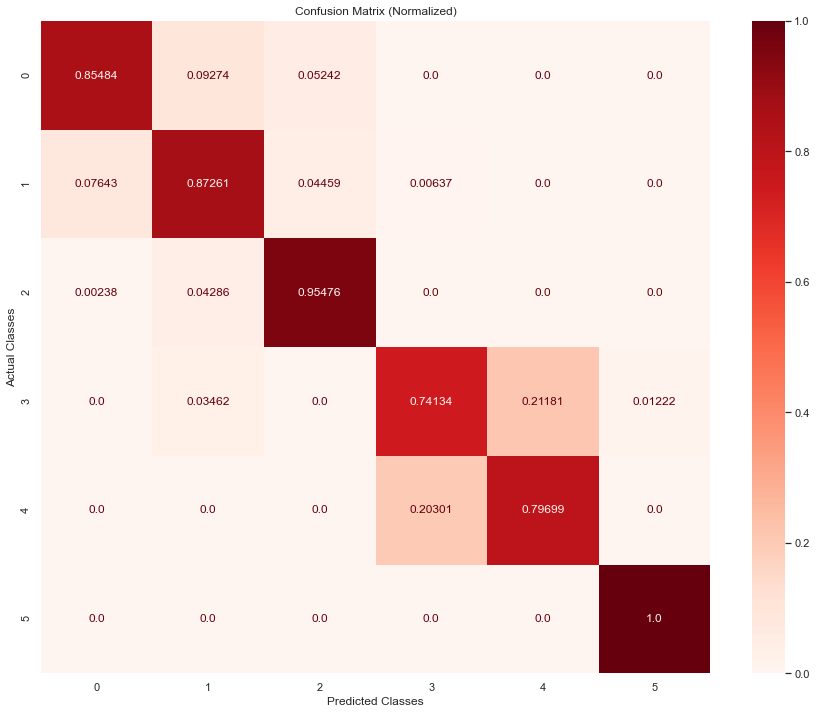

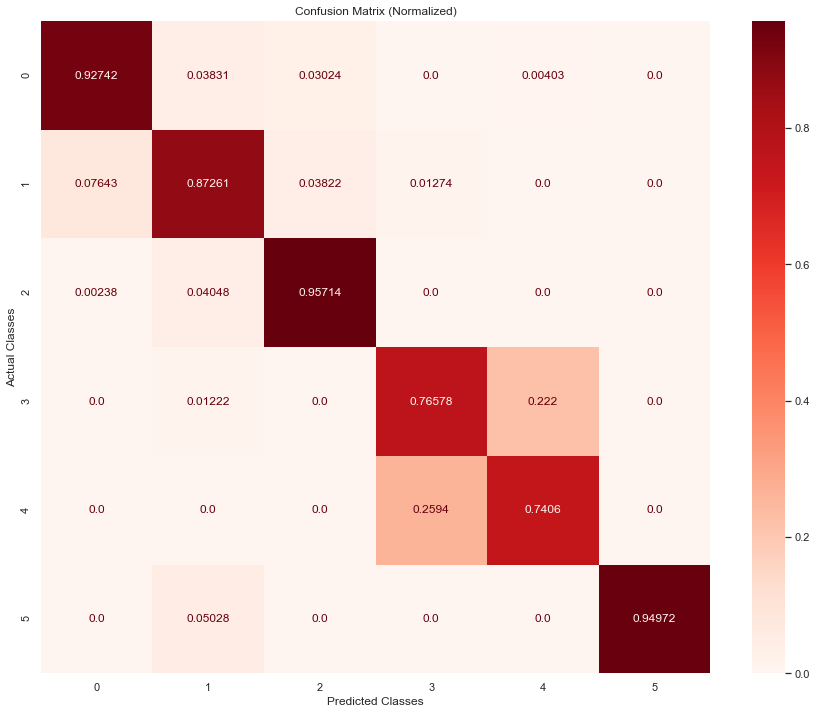

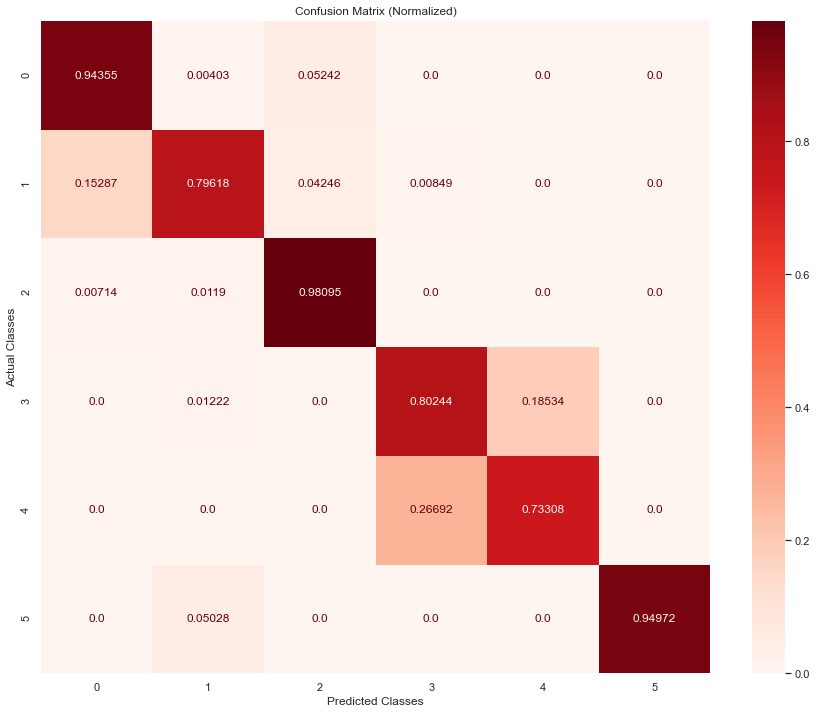

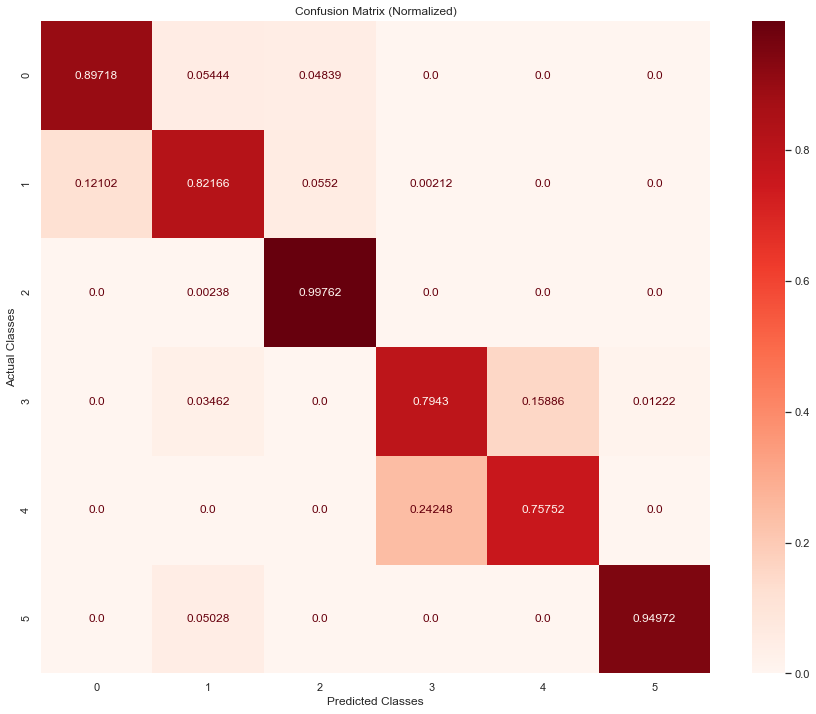

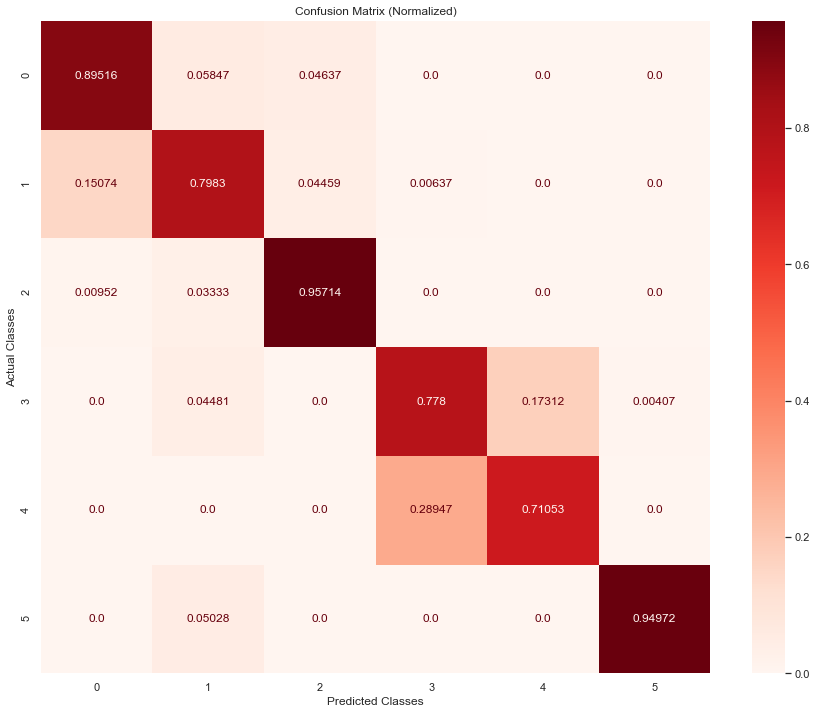

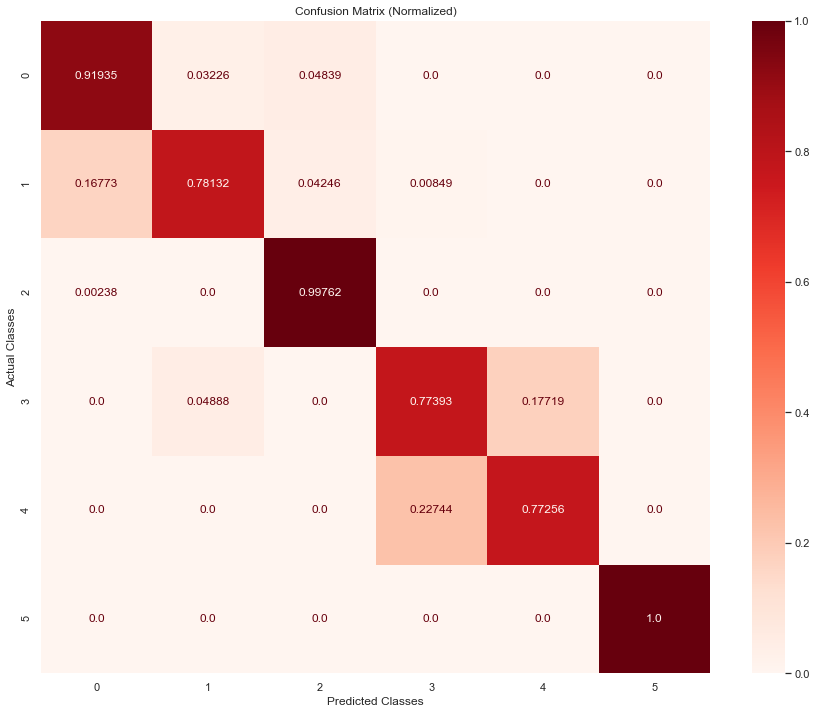

In [73]:
repeat_experiment(model_type="cnnlstm", data = "reduced")

Run:  1
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
ConvLSTM
Epoch 1/5000
460/460 [==============================] - 7s 13ms/step - loss: 0.5927 - accuracy: 0.7654 - val_loss: 0.6753 - val_accuracy: 0.7917
Epoch 2/5000
460/460 [==============================] - 6s 13ms/step - loss: 0.2990 - accuracy: 0.8815 - val_loss: 0.6617 - val_accuracy: 0.8039
Epoch 3/5000
460/460 [==============================] - 6s 13ms/step - loss: 0.2433 - accuracy: 0.9022 - val_loss: 0.5510 - val_accuracy: 0.8439
Epoch 4/5000
460/460 [==============================] - 6s 13ms/step - loss: 0.1967 - accuracy: 0.9187 - val_loss: 0.6062 - v


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  2
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
ConvLSTM
Epoch 1/5000
460/460 [==============================] - 7s 12ms/step - loss: 0.5836 - accuracy: 0.7678 - val_loss: 0.6602 - val_accuracy: 0.7944
Epoch 2/5000
460/460 [==============================] - 5s 12ms/step - loss: 0.2895 - accuracy: 0.8866 - val_loss: 0.5803 - val_accuracy: 0.8310
Epoch 3/5000
460/460 [==============================] - 5s 12ms/step - loss: 0.2174 - accuracy: 0.9124 - val_loss: 0.9880 - val_accuracy: 0.8286
Epoch 4/5000
460/460 [==============================] - 5s 12ms/step - loss: 0.2010 - accuracy: 0.9202 - val_loss: 1.1346 - v


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  3
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
ConvLSTM
Epoch 1/5000
460/460 [==============================] - 7s 14ms/step - loss: 0.6026 - accuracy: 0.7677 - val_loss: 0.6799 - val_accuracy: 0.7978
Epoch 2/5000
460/460 [==============================] - 6s 13ms/step - loss: 0.2963 - accuracy: 0.8806 - val_loss: 0.6757 - val_accuracy: 0.8032
Epoch 3/5000
460/460 [==============================] - 6s 13ms/step - loss: 0.2445 - accuracy: 0.9044 - val_loss: 0.5770 - val_accuracy: 0.8422
Epoch 4/5000
460/460 [==============================] - 6s 13ms/step - loss: 0.2053 - accuracy: 0.9177 - val_loss: 0.5656 - v


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  4
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
ConvLSTM
Epoch 1/5000
460/460 [==============================] - 7s 13ms/step - loss: 0.6037 - accuracy: 0.7654 - val_loss: 0.6261 - val_accuracy: 0.7947
Epoch 2/5000
460/460 [==============================] - 6s 12ms/step - loss: 0.2964 - accuracy: 0.8814 - val_loss: 0.6082 - val_accuracy: 0.8297
Epoch 3/5000
460/460 [==============================] - 6s 12ms/step - loss: 0.2515 - accuracy: 0.9021 - val_loss: 0.5866 - val_accuracy: 0.8446
Epoch 4/5000
460/460 [==============================] - 6s 12ms/step - loss: 0.2105 - accuracy: 0.9170 - val_loss: 0.7440 - v


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  5
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
ConvLSTM
Epoch 1/5000
460/460 [==============================] - 7s 13ms/step - loss: 0.5685 - accuracy: 0.7730 - val_loss: 0.6528 - val_accuracy: 0.7716
Epoch 2/5000
460/460 [==============================] - 6s 12ms/step - loss: 0.3029 - accuracy: 0.8817 - val_loss: 0.4889 - val_accuracy: 0.8314
Epoch 3/5000
460/460 [==============================] - 6s 12ms/step - loss: 0.2358 - accuracy: 0.9032 - val_loss: 0.8666 - val_accuracy: 0.8042
Epoch 4/5000
460/460 [==============================] - 6s 12ms/step - loss: 0.2208 - accuracy: 0.9173 - val_loss: 0.6042 - v


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  6
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
ConvLSTM
Epoch 1/5000
460/460 [==============================] - 7s 12ms/step - loss: 0.6063 - accuracy: 0.7678 - val_loss: 0.7588 - val_accuracy: 0.7832
Epoch 2/5000
460/460 [==============================] - 5s 12ms/step - loss: 0.3195 - accuracy: 0.8721 - val_loss: 0.5744 - val_accuracy: 0.8368
Epoch 3/5000
460/460 [==============================] - 5s 12ms/step - loss: 0.2413 - accuracy: 0.9022 - val_loss: 0.6125 - val_accuracy: 0.8561
Epoch 4/5000
460/460 [==============================] - 5s 12ms/step - loss: 0.2037 - accuracy: 0.9165 - val_loss: 0.8870 - v


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  7
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
ConvLSTM
Epoch 1/5000
460/460 [==============================] - 9s 16ms/step - loss: 0.6062 - accuracy: 0.7681 - val_loss: 0.7071 - val_accuracy: 0.7872
Epoch 2/5000
460/460 [==============================] - 7s 16ms/step - loss: 0.3076 - accuracy: 0.8780 - val_loss: 0.5573 - val_accuracy: 0.8212
Epoch 3/5000
460/460 [==============================] - 7s 16ms/step - loss: 0.2415 - accuracy: 0.9007 - val_loss: 0.5680 - val_accuracy: 0.8385
Epoch 4/5000
460/460 [==============================] - 7s 16ms/step - loss: 0.2142 - accuracy: 0.9184 - val_loss: 0.4811 - v


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  8
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
ConvLSTM
Epoch 1/5000
460/460 [==============================] - 8s 15ms/step - loss: 0.5603 - accuracy: 0.7850 - val_loss: 0.9014 - val_accuracy: 0.7302
Epoch 2/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.3022 - accuracy: 0.8776 - val_loss: 0.5946 - val_accuracy: 0.8229
Epoch 3/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.2489 - accuracy: 0.9032 - val_loss: 0.5341 - val_accuracy: 0.8442
Epoch 4/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.2081 - accuracy: 0.9158 - val_loss: 0.6646 - v


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  9
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
ConvLSTM
Epoch 1/5000
460/460 [==============================] - 8s 15ms/step - loss: 0.5897 - accuracy: 0.7769 - val_loss: 0.6901 - val_accuracy: 0.7801
Epoch 2/5000
460/460 [==============================] - 7s 16ms/step - loss: 0.2990 - accuracy: 0.8836 - val_loss: 0.6310 - val_accuracy: 0.8178
Epoch 3/5000
460/460 [==============================] - 7s 16ms/step - loss: 0.2415 - accuracy: 0.9059 - val_loss: 0.6432 - val_accuracy: 0.8354
Epoch 4/5000
460/460 [==============================] - 7s 16ms/step - loss: 0.2135 - accuracy: 0.9174 - val_loss: 0.6191 - v


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  10
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
ConvLSTM
Epoch 1/5000
460/460 [==============================] - 8s 15ms/step - loss: 0.5611 - accuracy: 0.7801 - val_loss: 0.6143 - val_accuracy: 0.7967
Epoch 2/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.2885 - accuracy: 0.8866 - val_loss: 0.5872 - val_accuracy: 0.8174
Epoch 3/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.2276 - accuracy: 0.9085 - val_loss: 0.7639 - val_accuracy: 0.8426
Epoch 4/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.2318 - accuracy: 0.9090 - val_loss: 0.5770 - 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


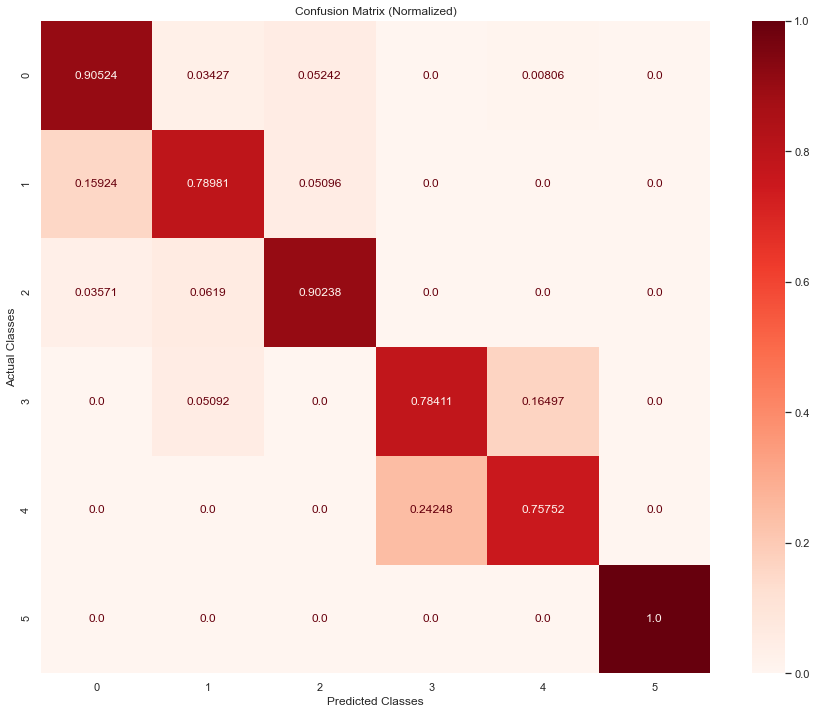

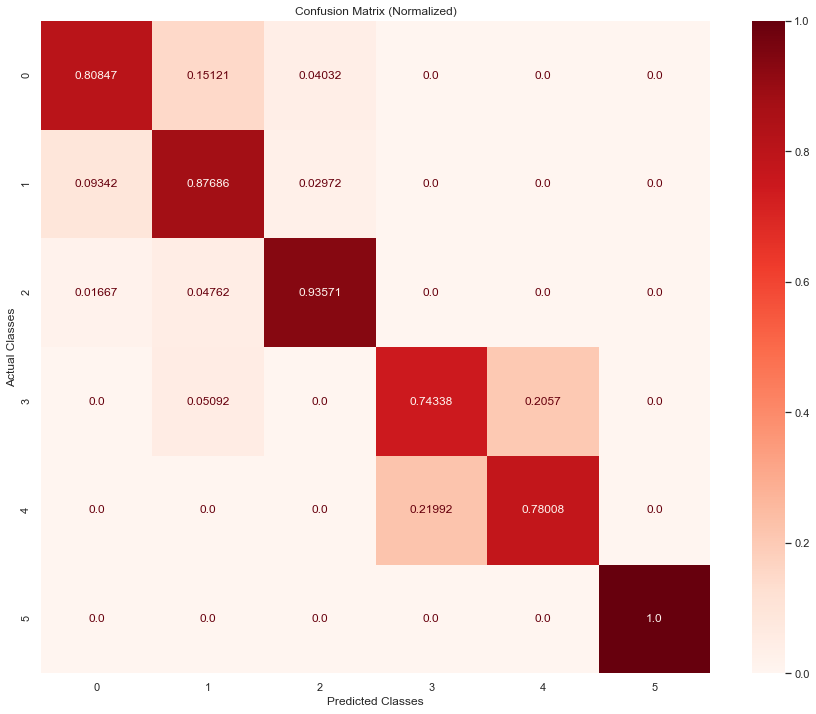

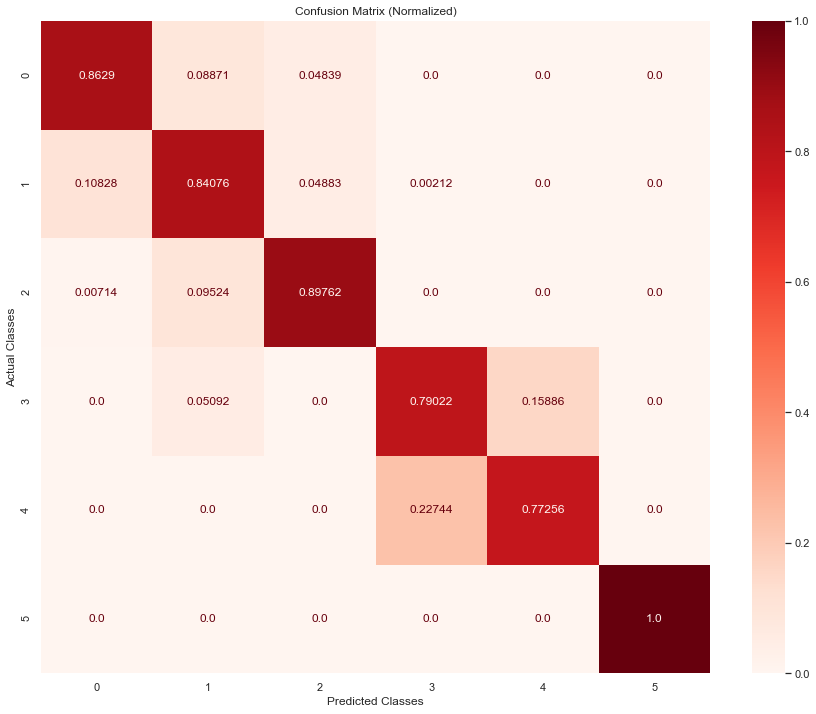

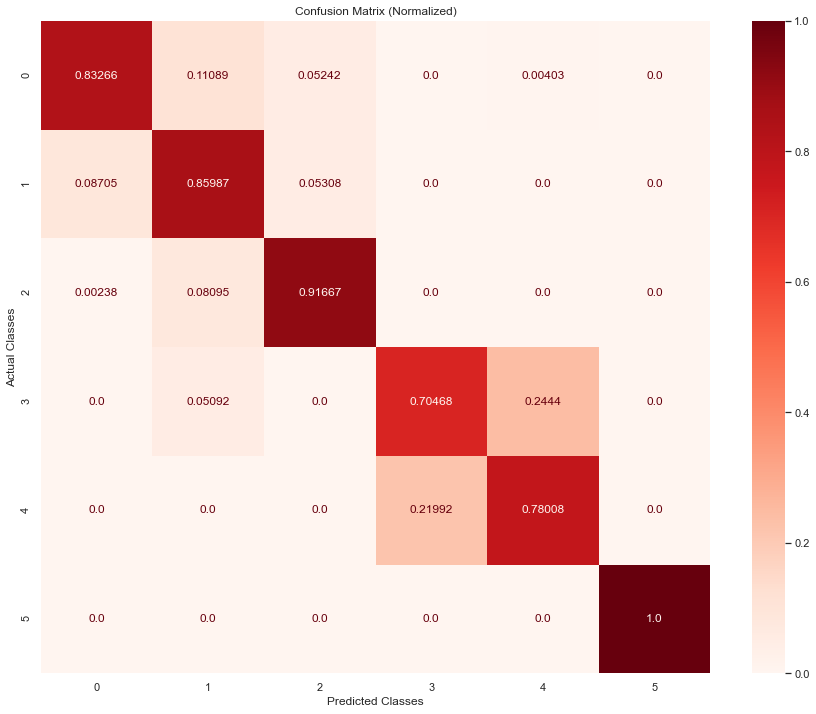

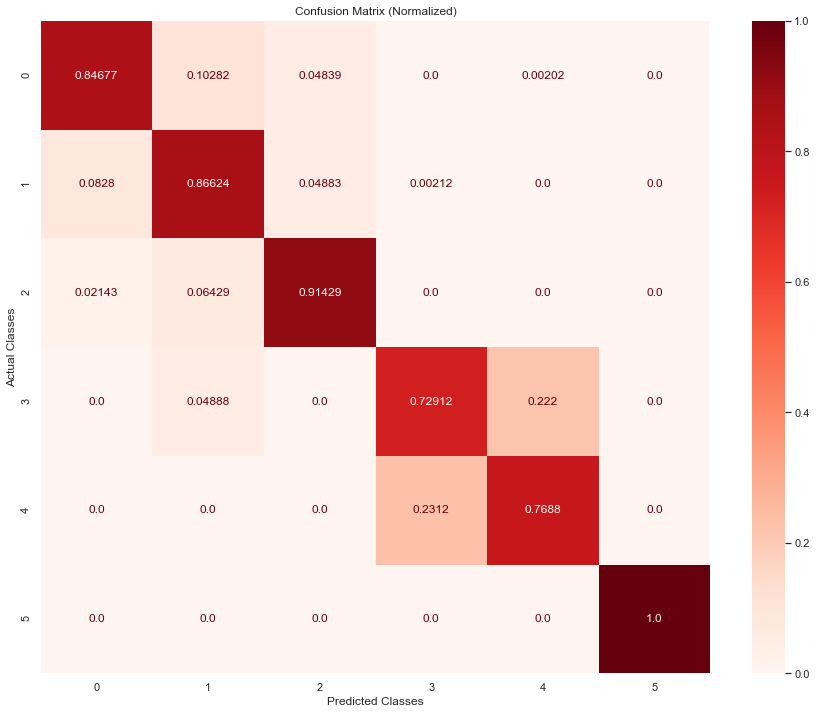

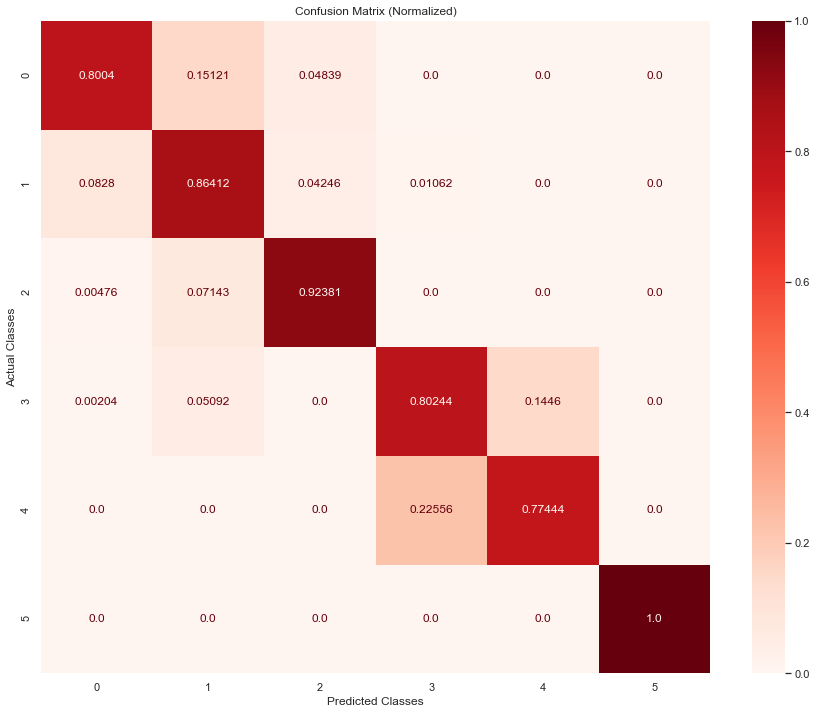

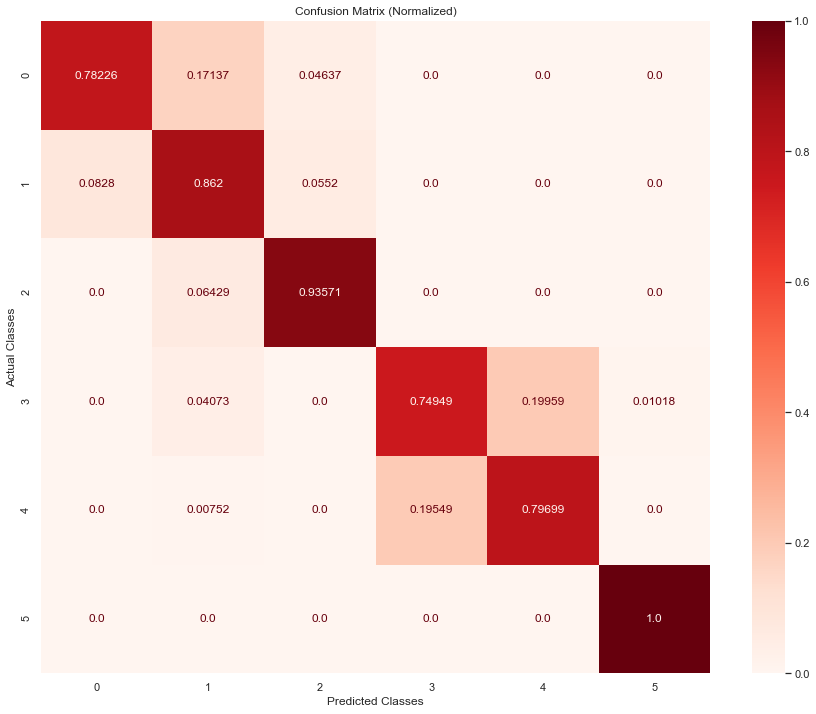

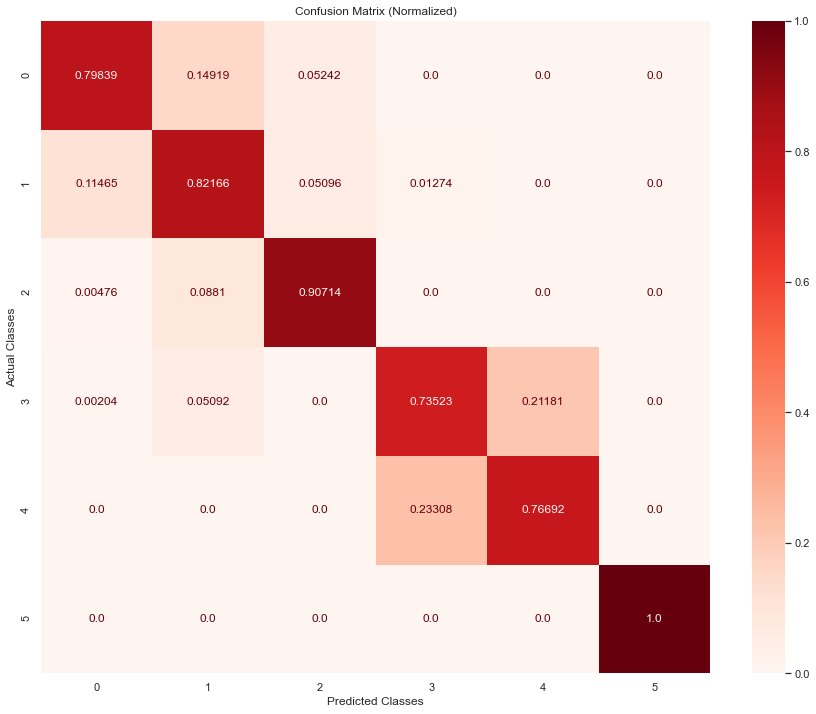

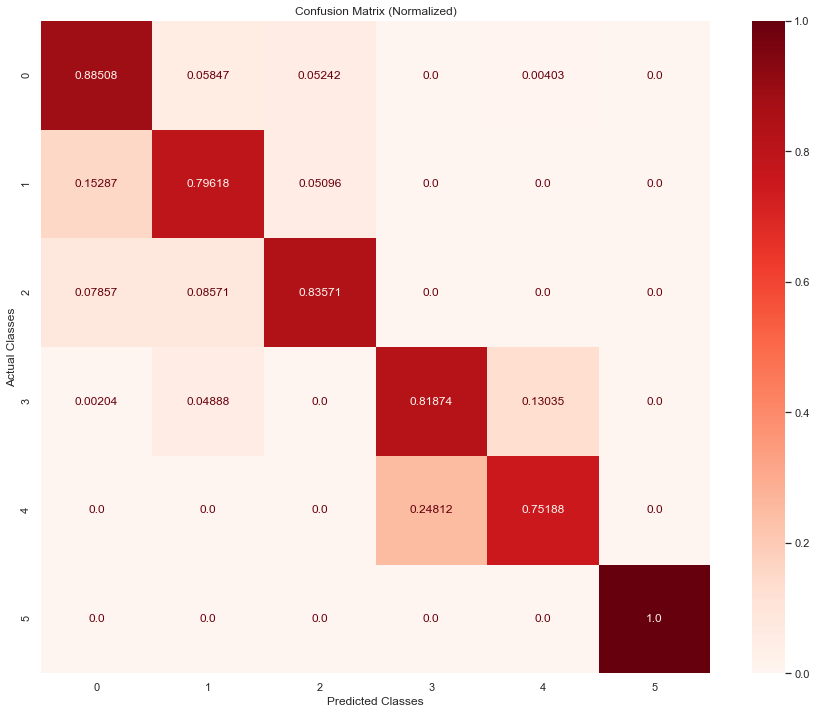

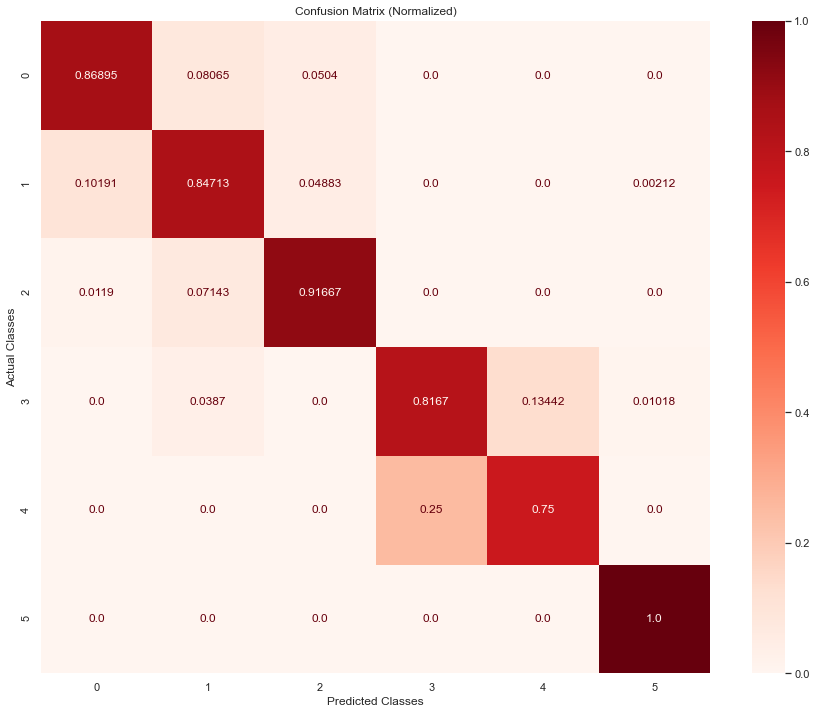

In [74]:
repeat_experiment(model_type="convlstm", data = "reduced")

Run:  1
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
Bi-LSTM
Epoch 1/5000
460/460 [==============================] - 9s 16ms/step - loss: 1.0676 - accuracy: 0.5276 - val_loss: 1.4573 - val_accuracy: 0.5015
Epoch 2/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.8090 - accuracy: 0.6563 - val_loss: 0.9278 - val_accuracy: 0.6040
Epoch 3/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.6304 - accuracy: 0.7184 - val_loss: 0.6991 - val_accuracy: 0.7299
Epoch 4/5000
460/460 [==============================] - 7s 16ms/step - loss: 0.3881 - accuracy: 0.8342 - val_loss: 0.5330 - va


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  2
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
Bi-LSTM
Epoch 1/5000
460/460 [==============================] - 8s 15ms/step - loss: 1.0984 - accuracy: 0.5290 - val_loss: 1.1583 - val_accuracy: 0.5053
Epoch 2/5000
460/460 [==============================] - 7s 14ms/step - loss: 0.8426 - accuracy: 0.6408 - val_loss: 0.9936 - val_accuracy: 0.6020
Epoch 3/5000
460/460 [==============================] - 6s 14ms/step - loss: 0.5275 - accuracy: 0.7693 - val_loss: 0.5802 - val_accuracy: 0.7825
Epoch 4/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.3856 - accuracy: 0.8523 - val_loss: 0.7712 - va


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  3
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
Bi-LSTM
Epoch 1/5000
460/460 [==============================] - 9s 15ms/step - loss: 1.0420 - accuracy: 0.5422 - val_loss: 1.2177 - val_accuracy: 0.4751
Epoch 2/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.7634 - accuracy: 0.6838 - val_loss: 0.7598 - val_accuracy: 0.7160
Epoch 3/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.4605 - accuracy: 0.8195 - val_loss: 0.5401 - val_accuracy: 0.7777
Epoch 4/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.3110 - accuracy: 0.8789 - val_loss: 0.8634 - va


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  4
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
Bi-LSTM
Epoch 1/5000
460/460 [==============================] - 9s 16ms/step - loss: 1.0786 - accuracy: 0.5288 - val_loss: 1.1627 - val_accuracy: 0.5087
Epoch 2/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.7951 - accuracy: 0.6479 - val_loss: 1.4468 - val_accuracy: 0.4404
Epoch 3/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.6242 - accuracy: 0.7186 - val_loss: 0.6813 - val_accuracy: 0.7061
Epoch 4/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.4431 - accuracy: 0.8192 - val_loss: 0.5326 - va


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  5
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
Bi-LSTM
Epoch 1/5000
460/460 [==============================] - 9s 15ms/step - loss: 1.0763 - accuracy: 0.5404 - val_loss: 1.2488 - val_accuracy: 0.4927
Epoch 2/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.9575 - accuracy: 0.5985 - val_loss: 0.8520 - val_accuracy: 0.6729
Epoch 3/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.5621 - accuracy: 0.7742 - val_loss: 0.5035 - val_accuracy: 0.7876
Epoch 4/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.4541 - accuracy: 0.8254 - val_loss: 0.7115 - va


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  6
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
Bi-LSTM
Epoch 1/5000
460/460 [==============================] - 9s 15ms/step - loss: 1.0652 - accuracy: 0.5345 - val_loss: 1.2118 - val_accuracy: 0.4737
Epoch 2/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.8398 - accuracy: 0.6450 - val_loss: 0.7756 - val_accuracy: 0.6848
Epoch 3/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.4846 - accuracy: 0.8022 - val_loss: 1.0098 - val_accuracy: 0.7153
Epoch 4/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.4831 - accuracy: 0.8248 - val_loss: 0.5798 - va


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  7
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
Bi-LSTM
Epoch 1/5000
460/460 [==============================] - 9s 16ms/step - loss: 1.0648 - accuracy: 0.5341 - val_loss: 1.1432 - val_accuracy: 0.4934
Epoch 2/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.9369 - accuracy: 0.6084 - val_loss: 0.9091 - val_accuracy: 0.6291
Epoch 3/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.5570 - accuracy: 0.7701 - val_loss: 0.6789 - val_accuracy: 0.6725
Epoch 4/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.5035 - accuracy: 0.8007 - val_loss: 0.7972 - va


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  8
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
Bi-LSTM
Epoch 1/5000
460/460 [==============================] - 9s 16ms/step - loss: 1.0474 - accuracy: 0.5390 - val_loss: 1.1715 - val_accuracy: 0.5022
Epoch 2/5000
460/460 [==============================] - 7s 14ms/step - loss: 0.8807 - accuracy: 0.6363 - val_loss: 0.9569 - val_accuracy: 0.5745
Epoch 3/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.6684 - accuracy: 0.6980 - val_loss: 0.7149 - val_accuracy: 0.7462
Epoch 4/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.4977 - accuracy: 0.7889 - val_loss: 0.5333 - va


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  9
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
Bi-LSTM
Epoch 1/5000
460/460 [==============================] - 9s 15ms/step - loss: 1.0497 - accuracy: 0.5378 - val_loss: 1.1452 - val_accuracy: 0.5134
Epoch 2/5000
460/460 [==============================] - 7s 14ms/step - loss: 0.9552 - accuracy: 0.5875 - val_loss: 1.2339 - val_accuracy: 0.4208
Epoch 3/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.8745 - accuracy: 0.6427 - val_loss: 0.8502 - val_accuracy: 0.6647
Epoch 4/5000
460/460 [==============================] - 7s 14ms/step - loss: 0.8600 - accuracy: 0.6453 - val_loss: 1.0109 - va


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  10
reduced
features selected:  ['total_acc_x_train', 'total_acc_y_train', 'total_acc_z_train']
prefix:   datasets/HARDataset/train/Inertial Signals/
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 1)
prefix:   datasets/HARDataset/test/Inertial Signals/
testX.shape:   (2947, 128, 3) testy.shape:   (2947, 1)
trainX.shape:   (7352, 128, 3) trainy.shape:   (7352, 6) testX.shape:   (2947, 128, 3) testy.shape:   (2947, 6)
Bi-LSTM
Epoch 1/5000
460/460 [==============================] - 9s 16ms/step - loss: 1.0950 - accuracy: 0.5261 - val_loss: 1.1987 - val_accuracy: 0.5249
Epoch 2/5000
460/460 [==============================] - 7s 14ms/step - loss: 0.7411 - accuracy: 0.6944 - val_loss: 0.6249 - val_accuracy: 0.7662
Epoch 3/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.8298 - accuracy: 0.6268 - val_loss: 0.6867 - val_accuracy: 0.6956
Epoch 4/5000
460/460 [==============================] - 7s 15ms/step - loss: 0.6079 - accuracy: 0.7174 - val_loss: 0.7171 - v


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


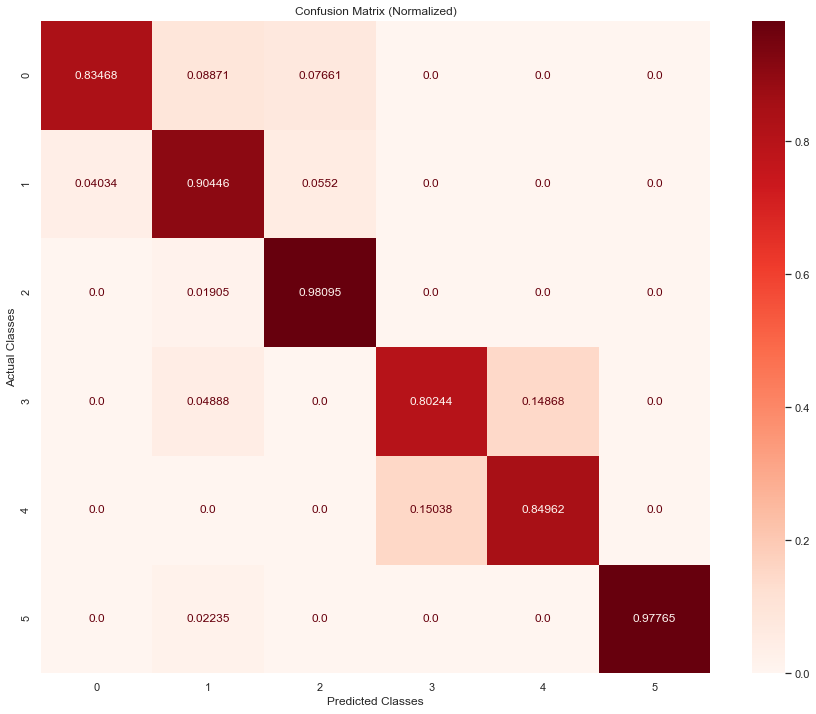

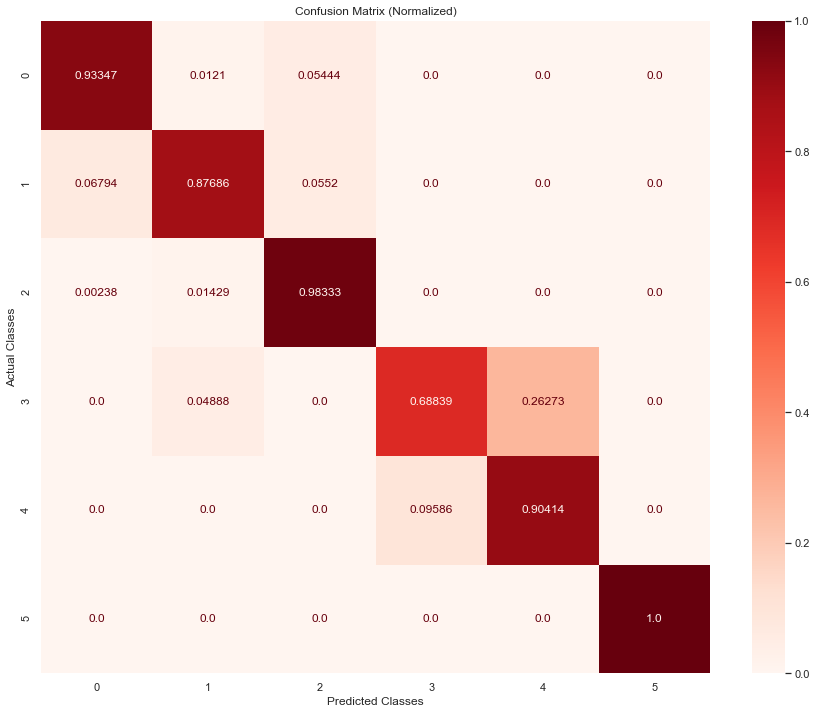

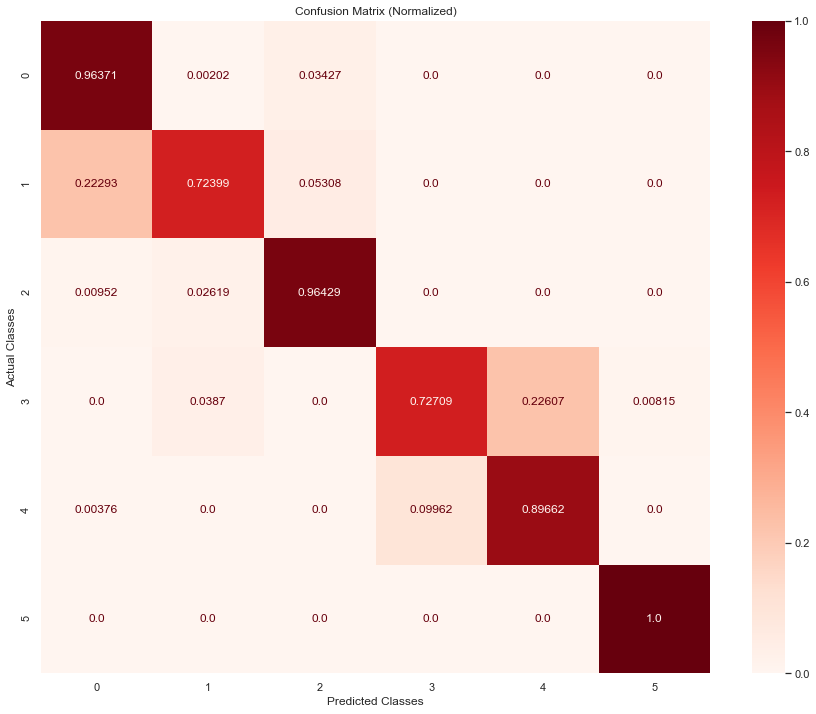

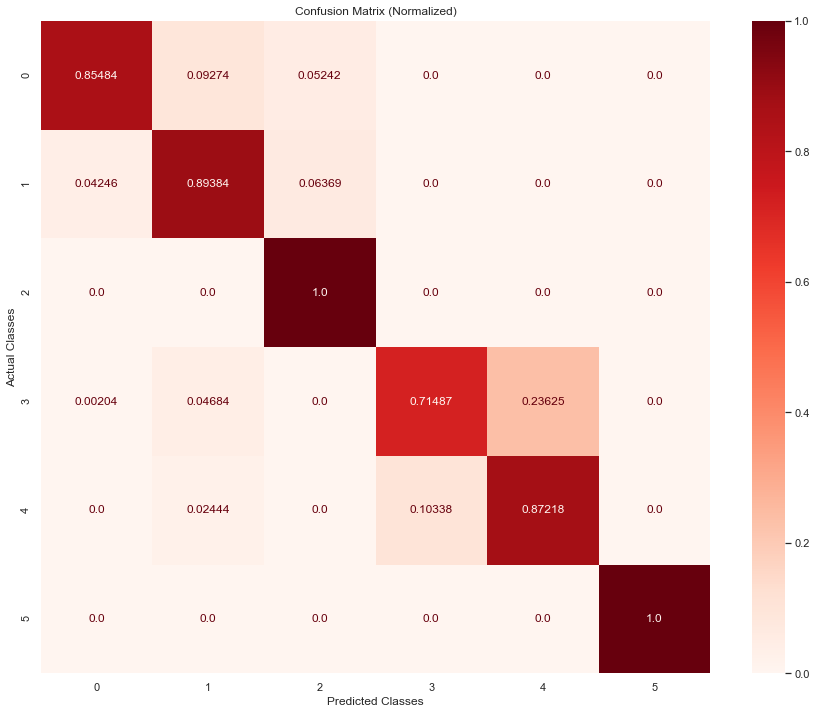

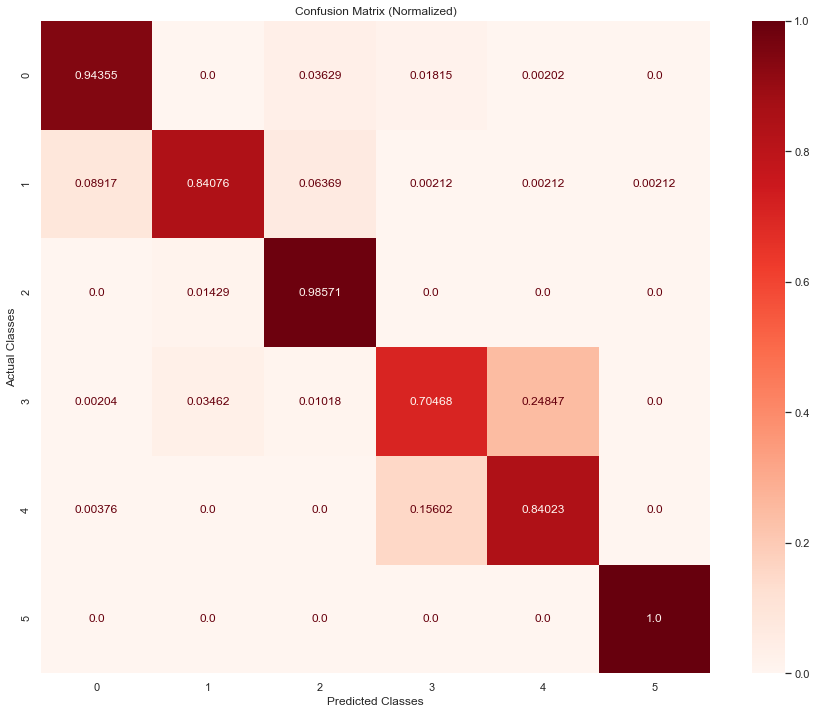

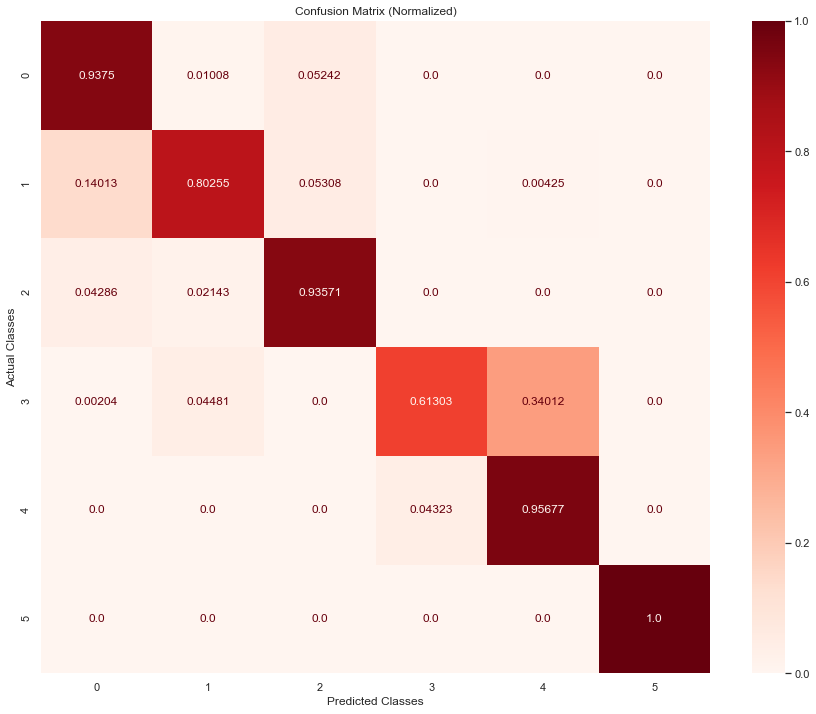

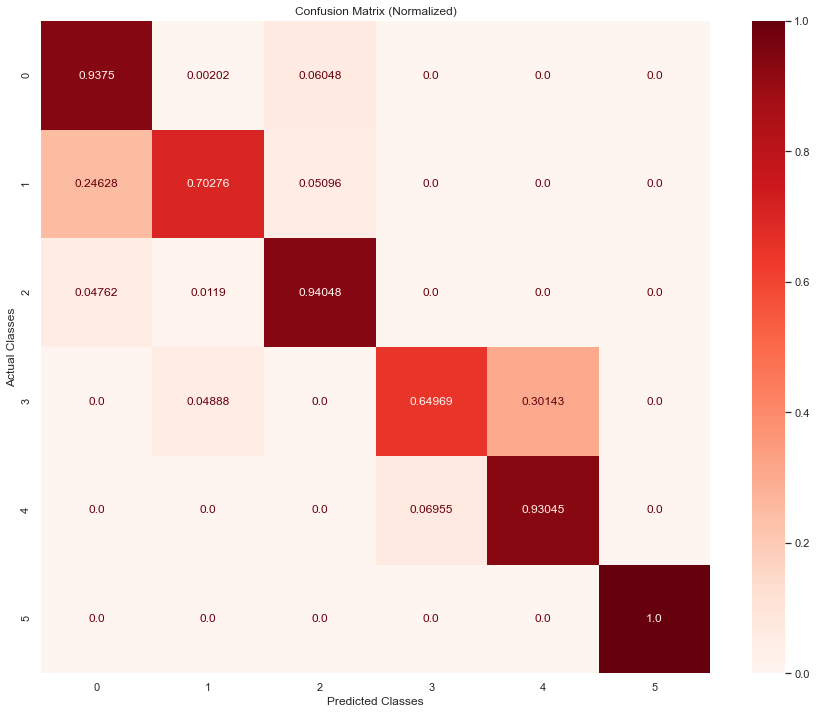

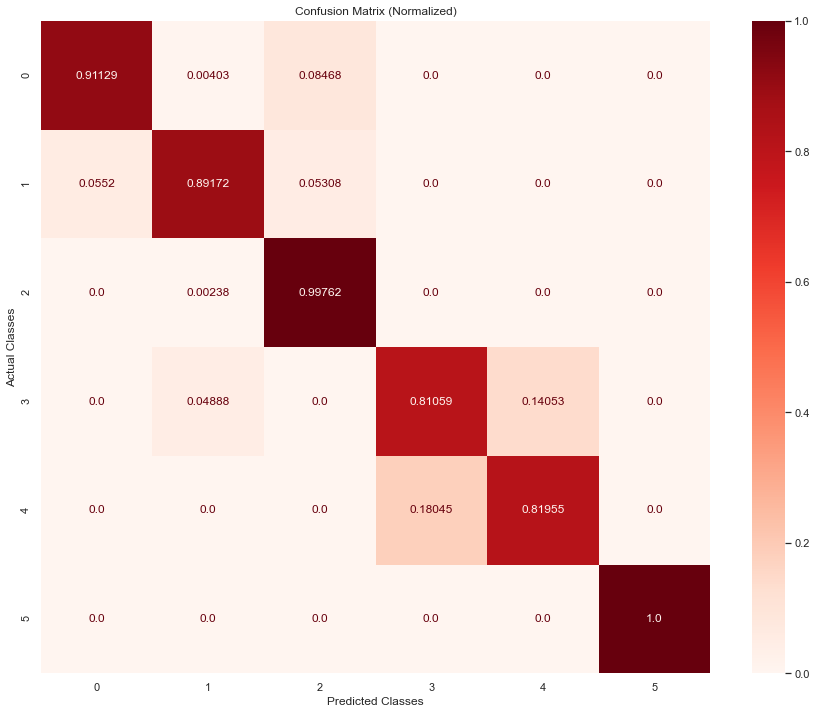

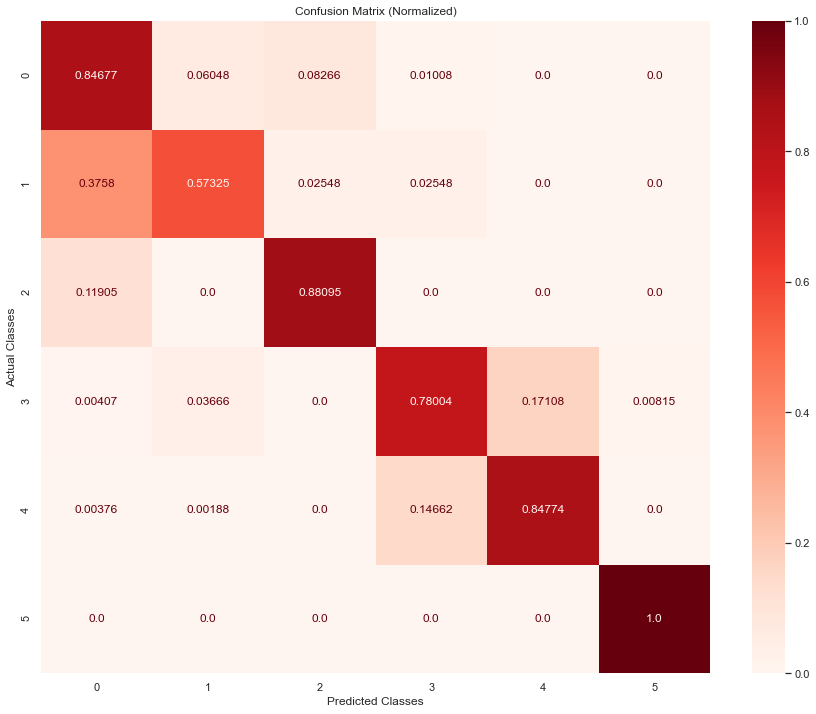

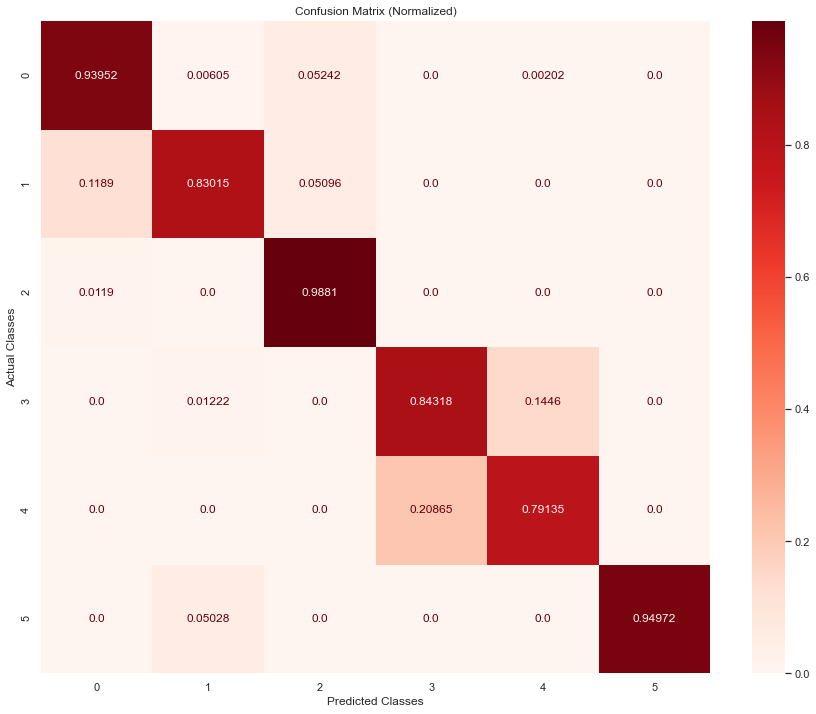

In [75]:
repeat_experiment(model_type="bilstm", data = "reduced")

### Divide and conquer

In [76]:
# make trimmed down vversion of run_experiment_dac for the repeat experiments
def run_experiment_dac_r(model_type="lstm", data = "original"):
    
    Experiment_type["type"] = "dac"
    
    print(data)
    
    # select model type, based on user input 
    if (model_type == 'lstm'):
        fit_model = fit_model_LSTM
    elif (model_type == 'cnnlstm'):
        fit_model = fit_model_CNN_LSTM
    elif (model_type == 'convlstm'):
        fit_model = fit_model_ConvLSTM
    elif (model_type == 'bilstm'):
        fit_model = fit_model_Bi_LSTM
    # print message if wrong input given
    else:
        print('INPUT ERROR. Please see the following possible inputs: ')
        print('For a LSTM model, input "lstm"')
        print('For a CNN-LSTM model, input "cnnlstm"')
        print('For a ConvLSTM model, input "convlstm"')
        print('For a Bi-LSTM model, input "bilstm"')
        return
        
    # load data, using load_dataset_group instead of load_dataset as we don't want the class one-hot encoded yet
    trainX, trainy = load_dataset_group('train', 'datasets/HARDataset/')
    testX, testy = load_dataset_group('test', 'datasets/HARDataset/')
    
    # use different datasets depending on user selection
    if (data == "original"):
        trainX_, trainy_ = load_dataset_group('train', 'datasets/HARDataset/')
        testX_, testy_ = load_dataset_group('test', 'datasets/HARDataset/')   
    elif (data == "reduced"):
        trainX_, trainy_ = load_dataset_group_fr2('train', filenames_train, 'datasets/HARDataset/')
        testX_, testy_ = load_dataset_group_fr2('test', filenames_test, 'datasets/HARDataset/')
    else:
        print('INPUT ERROR. Please see the following possible inputs: ')
        print('To use the original dataset, input "original"')
        print('To use the feature reduced dataset, input "reduced"')
        return
       
    print("SPLITTING DATA:")
    
    # run first classifier, classifying as either stationary or moving
    history_split, max_y_test_split, max_y_pred_test_split, max_y_pred_train_split, times_split = run_experiment_dac_split(trainX_,
                                                                                                              trainy_,
                                                                                                              testX_,
                                                                                                              testy_,
                                                                                                              model_type
                                                                                                             )
    
    # use results from first classifier to split data
    # split training and testing data based on the predictions of the model
    trainX_stationary, trainX_moving = split_data(trainX_, max_y_pred_train_split)
    testX_stationary, testX_moving = split_data(testX_, max_y_pred_test_split)
    trainy_stationary, trainy_moving = split_data(trainy_, max_y_pred_train_split)
    testy_stationary, testy_moving = split_data(testy_, max_y_pred_test_split)
    
    # one hot encode y
    trainy_stationary = to_categorical(trainy_stationary, num_classes=7)
    testy_stationary = to_categorical(testy_stationary, num_classes=7)
    trainy_moving = to_categorical(trainy_moving, num_classes=7)
    testy_moving = to_categorical(testy_moving, num_classes=7)
      
    print()
    print("STATIONARY")

    # input these variables into a classifier for each of stationary and moving
    history_stationary, max_y_test_stationary, max_y_pred_test_stationary, max_y_pred_train_stationary, times_stationary = fit_model(trainX_stationary,
                                                                                                                           trainy_stationary,
                                                                                                                           testX_stationary,
                                                                                                                           testy_stationary)

    print()
    print("MOVING")
    history_moving, max_y_test_moving, max_y_pred_test_moving, max_y_pred_train_moving, times_moving = fit_model(trainX_moving,
                                                                                                           trainy_moving,
                                                                                                           testX_moving,
                                                                                                           testy_moving)
    

    # get training and test set loss for stationary data
    train_loss_stationary = history_stationary.history['loss']
    test_loss_stationary = history_stationary.history['val_loss']
    # get training and test accuracy
    train_accuracy_stationary = history_stationary.history['accuracy']
    test_accuracy_stationary = history_stationary.history['val_accuracy']    
    # set number of epochs to be dynamic, depending how long experiment runs for
    epochs_stationary = range(0,len(test_accuracy_stationary))

    # get training and test set loss for moving data
    train_loss_moving = history_moving.history['loss']
    test_loss_moving = history_moving.history['val_loss']
    # get training and test accuracy
    train_accuracy_moving = history_moving.history['accuracy']
    test_accuracy_moving = history_moving.history['val_accuracy']    
    # set number of epochs to be dynamic, depending how long experiment runs for
    epochs_moving = range(0,len(test_accuracy_moving))

    # show overall confusion matrix
    max_y_test = np.concatenate((max_y_test_stationary, max_y_test_moving), axis=None)
    max_y_pred_test = np.concatenate((max_y_pred_test_stationary, max_y_pred_test_moving), axis=None)
    # dop normalised cm
    cm = ConfusionMatrix(actual_vector=max_y_test, predict_vector=max_y_pred_test) # Create CM From Data
    cm.plot(cmap=plt.cm.Reds,normalized=True,number_label=True,plot_lib="seaborn")
    
    # show training time
    times = [sum(n) for n in zip_longest(times_split, times_stationary, times_moving, fillvalue=0)]   

    # get weighted average accuracy
    weighted_accuracy_train = weighted_average(train_accuracy_stationary, max_y_pred_train_stationary, train_accuracy_moving, max_y_pred_train_moving)
    weighted_accuracy_test = weighted_average(test_accuracy_stationary, max_y_pred_test_stationary, test_accuracy_moving, max_y_pred_test_moving)

    # get weighted average accuracy per epoch
    weighted_accuracy_per_epoch_train = weighted_average_per_epoch(train_accuracy_stationary,max_y_pred_train_stationary, train_accuracy_moving, max_y_pred_train_moving)
    weighted_accuracy_per_epoch_test = weighted_average_per_epoch(test_accuracy_stationary,max_y_pred_test_stationary, test_accuracy_moving, max_y_pred_test_moving)
    
    # return metrics etc
    return (weighted_accuracy_per_epoch_train, 
    weighted_accuracy_per_epoch_test,
    weighted_accuracy_train,
    weighted_accuracy_test,
    np.cumsum(times),
    metrics.precision_score(max_y_test, max_y_pred_test, average='weighted'),
    metrics.recall_score(max_y_test, max_y_pred_test, average='weighted'),
    metrics.f1_score(max_y_test, max_y_pred_test, average='weighted')
    )

In [77]:
# do the same for divide and conquer
def repeat_experiment_dac(repeats=REPEATS, model_type="lstm", data = "original"):
    
    Experiment_type["type"] = "dac"
    
    final_model_accuracies_train = list() 
    final_model_accuracies_test = list()
    precision = list()
    recall = list()
    f1_score = list()
    
    # store model name for storage of results and analysis
    model_name = model_type + "_" + data
    
    # repeat model, storing values each time
    for i in range(repeats):
        print("Run: ", i+1)
        a,b,c,d,e,f,g,h = run_experiment_dac_r(model_type=model_type, data = data)
        
        # add these to the metrics dictionaries
        repeat_epoch_accuracies_train[model_name + "_" + "_dac_" + str(i+1)] = a
        repeat_epoch_accuracies_test[model_name + "_" + "_dac_" + str(i+1)] = b
        repeat_final_model_accuracies_train[model_name + "_" + "_dac_" + str(i+1)] = c
        repeat_final_model_accuracies_test[model_name + "_" + "_dac_" + str(i+1)] = d
        repeat_training_times[model_name + "_" + "_dac_" + str(i+1)] = e
        repeat_precision[model_name + "_" + "_dac_" + str(i+1)] = f
        repeat_recall[model_name + "_" + "_dac_" + str(i+1)] = g
        repeat_f1_score[model_name + "_" + "_dac_" + str(i+1)] = h
        
        # get mean metrics for each model
        # first, store all metrics for each repeat in a list
        final_model_accuracies_train.append(c)
        final_model_accuracies_test.append(d)
        precision.append(f)
        recall.append(g)
        f1_score.append(h)
        # calculate means
        mean_final_model_accuracies_train[model_name + "_dac"] = mean(final_model_accuracies_train)
        mean_final_model_accuracies_test[model_name + "_dac"] = mean(final_model_accuracies_test)
        mean_precision[model_name + "_dac"] = mean(precision)
        mean_recall[model_name + "_dac"] = mean(recall)
        mean_f1_score[model_name + "_dac"] = mean(f1_score)
        # calculate dtandard deviation
        std_final_model_accuracies_train[model_name + "_dac"] = std(final_model_accuracies_train)
        std_final_model_accuracies_test[model_name + "_dac"] = std(final_model_accuracies_test)
        std_precision[model_name + "_dac"] = std(precision)
        std_recall[model_name + "_dac"] = std(recall)
        std_f1_score[model_name + "_dac"] = std(f1_score)  

#### Test run

##### Original Data

Run:  1
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.1679 - accuracy: 0.9227 - val_loss: 0.0081 - val_accuracy: 0.9993
Epoch 2/10
460/460 [==============================] - 4s 8ms/step - loss: 0.1621 - accuracy: 0.9087 - val_loss: 0.5512 - val_accuracy: 0.7078
Epoch 3/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0366 - accuracy: 0.9890 - val_loss: 0.0095 - val_accuracy: 0.9986
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0075 - accuracy: 0.9990 - val_loss: 0.0098 - val_accuracy: 0.9986
Epoch 5/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0063 - accuracy: 0.9992 - val_loss: 0.0093 - val_accuracy:

205/205 [==============================] - 2s 9ms/step - loss: 0.0135 - accuracy: 0.9960 - val_loss: 0.2853 - val_accuracy: 0.9494
Epoch 42/5000
205/205 [==============================] - 2s 9ms/step - loss: 0.0305 - accuracy: 0.9924 - val_loss: 0.1867 - val_accuracy: 0.9559
Epoch 43/5000
205/205 [==============================] - 2s 9ms/step - loss: 0.0295 - accuracy: 0.9942 - val_loss: 0.2124 - val_accuracy: 0.9530
Epoch 44/5000
205/205 [==============================] - 2s 9ms/step - loss: 0.0071 - accuracy: 0.9988 - val_loss: 0.1851 - val_accuracy: 0.9581
Epoch 45/5000
205/205 [==============================] - 2s 8ms/step - loss: 0.0267 - accuracy: 0.9948 - val_loss: 0.2572 - val_accuracy: 0.9335
Epoch 46/5000
205/205 [==============================] - 2s 8ms/step - loss: 0.0182 - accuracy: 0.9945 - val_loss: 0.2145 - val_accuracy: 0.9559
Epoch 47/5000
205/205 [==============================] - 2s 8ms/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 0.2158 - val_accuracy: 0.9581


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  2
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.2905 - accuracy: 0.8683 - val_loss: 0.0161 - val_accuracy: 0.9993
Epoch 2/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0098 - accuracy: 0.9988 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0172 - accuracy: 0.9976 - val_loss: 0.0064 - val_accuracy: 0.9993
Epoch 4/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0051 - accuracy: 0.9995 - val_loss: 0.0050 - val_accuracy: 0.9993
Epoch 5/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0036 - accuracy: 0.9997 - val_loss: 0.0029 - val_accuracy:

137/137 [==============================] - 1s 9ms/step - loss: 0.0191 - accuracy: 0.9945 - val_loss: 0.1429 - val_accuracy: 0.9719
Epoch 54/5000
137/137 [==============================] - 1s 9ms/step - loss: 0.0131 - accuracy: 0.9977 - val_loss: 0.1192 - val_accuracy: 0.9783
Epoch 55/5000
137/137 [==============================] - 1s 9ms/step - loss: 0.0092 - accuracy: 0.9986 - val_loss: 0.1411 - val_accuracy: 0.9744
Epoch 56/5000
137/137 [==============================] - 1s 9ms/step - loss: 0.1272 - accuracy: 0.9697 - val_loss: 0.2392 - val_accuracy: 0.9309
Epoch 57/5000
137/137 [==============================] - 1s 8ms/step - loss: 0.0255 - accuracy: 0.9936 - val_loss: 0.1757 - val_accuracy: 0.9706
Epoch 58/5000
137/137 [==============================] - 1s 8ms/step - loss: 0.0176 - accuracy: 0.9954 - val_loss: 0.2402 - val_accuracy: 0.9463
Epoch 59/5000
137/137 [==============================] - 1s 9ms/step - loss: 0.0620 - accuracy: 0.9849 - val_loss: 0.1169 - val_accuracy: 0.9616


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  3
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.2781 - accuracy: 0.8727 - val_loss: 0.3001 - val_accuracy: 0.9657
Epoch 2/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0348 - accuracy: 0.9950 - val_loss: 0.0210 - val_accuracy: 0.9969
Epoch 3/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0139 - accuracy: 0.9982 - val_loss: 0.0160 - val_accuracy: 0.9973
Epoch 4/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0114 - accuracy: 0.9985 - val_loss: 0.0078 - val_accuracy: 0.9990
Epoch 5/10
460/460 [==============================] - 4s 9ms/step - loss: 0.1298 - accuracy: 0.9616 - val_loss: 0.1932 - val_accuracy:

202/202 [==============================] - 2s 9ms/step - loss: 0.0111 - accuracy: 0.9978 - val_loss: 0.7570 - val_accuracy: 0.9392
Epoch 42/5000
202/202 [==============================] - 2s 8ms/step - loss: 0.0081 - accuracy: 0.9988 - val_loss: 0.8059 - val_accuracy: 0.9459
Epoch 43/5000
202/202 [==============================] - 2s 8ms/step - loss: 0.0065 - accuracy: 0.9991 - val_loss: 0.7607 - val_accuracy: 0.9518
Epoch 44/5000
202/202 [==============================] - 2s 8ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.7937 - val_accuracy: 0.9540
Epoch 45/5000
202/202 [==============================] - 2s 8ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.8438 - val_accuracy: 0.9474
Epoch 46/5000
202/202 [==============================] - 2s 8ms/step - loss: 0.0736 - accuracy: 0.9814 - val_loss: 0.4973 - val_accuracy: 0.9496
Epoch 47/5000
202/202 [==============================] - 2s 9ms/step - loss: 0.0135 - accuracy: 0.9981 - val_loss: 0.8754 - val_accuracy: 0.9251


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  4
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.1742 - accuracy: 0.9178 - val_loss: 0.0082 - val_accuracy: 0.9986
Epoch 2/10
460/460 [==============================] - 4s 8ms/step - loss: 0.5180 - accuracy: 0.7155 - val_loss: 0.5704 - val_accuracy: 0.7207
Epoch 3/10
460/460 [==============================] - 4s 9ms/step - loss: 0.4450 - accuracy: 0.7720 - val_loss: 0.1057 - val_accuracy: 0.9667
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.2289 - accuracy: 0.9063 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0204 - accuracy: 0.9955 - val_loss: 0.0057 - val_accuracy:

206/206 [==============================] - 2s 8ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.2107 - val_accuracy: 0.9632
Epoch 40/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0307 - accuracy: 0.9927 - val_loss: 0.2615 - val_accuracy: 0.9546
Epoch 41/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.0069 - accuracy: 0.9988 - val_loss: 0.4142 - val_accuracy: 0.9503
Epoch 42/5000
206/206 [==============================] - 2s 8ms/step - loss: 3.9408e-04 - accuracy: 1.0000 - val_loss: 0.3875 - val_accuracy: 0.9575
Epoch 43/5000
206/206 [==============================] - 2s 8ms/step - loss: 2.6801e-04 - accuracy: 1.0000 - val_loss: 0.4192 - val_accuracy: 0.9582
Epoch 44/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.5730 - accuracy: 0.8748 - val_loss: 1.2331 - val_accuracy: 0.3576
Epoch 45/5000
206/206 [==============================] - 2s 9ms/step - loss: 1.1072 - accuracy: 0.3846 - val_loss: 1.0390 - val_accuracy


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  5
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.2258 - accuracy: 0.8947 - val_loss: 0.0126 - val_accuracy: 0.9983
Epoch 2/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0270 - accuracy: 0.9927 - val_loss: 0.1428 - val_accuracy: 0.9752
Epoch 3/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0746 - accuracy: 0.9758 - val_loss: 0.1214 - val_accuracy: 0.9528
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0149 - accuracy: 0.9965 - val_loss: 0.0117 - val_accuracy: 0.9997
Epoch 5/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0882 - accuracy: 0.9740 - val_loss: 0.0092 - val_accuracy:

255/255 [==============================] - 2s 8ms/step - loss: 0.1734 - accuracy: 0.9272 - val_loss: 0.3566 - val_accuracy: 0.8660
Epoch 48/5000
255/255 [==============================] - 2s 8ms/step - loss: 0.1838 - accuracy: 0.9164 - val_loss: 0.3528 - val_accuracy: 0.8821
Epoch 49/5000
255/255 [==============================] - 2s 8ms/step - loss: 0.1750 - accuracy: 0.9179 - val_loss: 0.4395 - val_accuracy: 0.8635
Epoch 50/5000
255/255 [==============================] - 2s 8ms/step - loss: 0.1726 - accuracy: 0.9221 - val_loss: 0.4124 - val_accuracy: 0.8737
Epoch 51/5000
255/255 [==============================] - 2s 8ms/step - loss: 0.1712 - accuracy: 0.9206 - val_loss: 0.5377 - val_accuracy: 0.8615
Epoch 52/5000
255/255 [==============================] - 2s 8ms/step - loss: 0.1726 - accuracy: 0.9262 - val_loss: 0.3840 - val_accuracy: 0.8564
Epoch 53/5000
255/255 [==============================] - 2s 9ms/step - loss: 0.1722 - accuracy: 0.9253 - val_loss: 0.3752 - val_accuracy: 0.8609


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  6
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.1969 - accuracy: 0.9040 - val_loss: 0.0038 - val_accuracy: 0.9986
Epoch 2/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0180 - accuracy: 0.9966 - val_loss: 0.0019 - val_accuracy: 0.9997
Epoch 3/10
460/460 [==============================] - 4s 8ms/step - loss: 0.4119 - accuracy: 0.7952 - val_loss: 0.6809 - val_accuracy: 0.5294
Epoch 4/10
460/460 [==============================] - 4s 9ms/step - loss: 0.4626 - accuracy: 0.7433 - val_loss: 0.6694 - val_accuracy: 0.5321
Epoch 5/10
460/460 [==============================] - 4s 8ms/step - loss: 0.5279 - accuracy: 0.7006 - val_loss: 0.4958 - val_accuracy:

207/207 [==============================] - 2s 9ms/step - loss: 0.0157 - accuracy: 0.9945 - val_loss: 0.3344 - val_accuracy: 0.9518
Epoch 41/5000
207/207 [==============================] - 2s 9ms/step - loss: 0.0081 - accuracy: 0.9970 - val_loss: 0.4019 - val_accuracy: 0.9510
Epoch 42/5000
207/207 [==============================] - 2s 9ms/step - loss: 0.0369 - accuracy: 0.9894 - val_loss: 0.3678 - val_accuracy: 0.9496
Epoch 43/5000
207/207 [==============================] - 2s 9ms/step - loss: 0.0147 - accuracy: 0.9955 - val_loss: 0.3787 - val_accuracy: 0.9568
Epoch 44/5000
207/207 [==============================] - 2s 9ms/step - loss: 0.0075 - accuracy: 0.9976 - val_loss: 0.4680 - val_accuracy: 0.9525
Epoch 45/5000
207/207 [==============================] - 2s 9ms/step - loss: 0.0206 - accuracy: 0.9933 - val_loss: 0.5296 - val_accuracy: 0.9438
Epoch 46/5000
207/207 [==============================] - 2s 9ms/step - loss: 0.0050 - accuracy: 0.9982 - val_loss: 0.5137 - val_accuracy: 0.9482


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  7
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.2360 - accuracy: 0.8911 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 2/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0107 - accuracy: 0.9981 - val_loss: 0.0044 - val_accuracy: 0.9990
Epoch 3/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 8.2806e-06 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0030 - accuracy: 0.9999 - val_loss: 1.3558e-05 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0023 - accuracy: 0.9999 - val_loss: 6.2833e-06 - v

Epoch 47/5000
255/255 [==============================] - 2s 8ms/step - loss: 0.1691 - accuracy: 0.9272 - val_loss: 0.4184 - val_accuracy: 0.8691
Epoch 48/5000
255/255 [==============================] - 2s 8ms/step - loss: 0.1666 - accuracy: 0.9260 - val_loss: 0.4509 - val_accuracy: 0.8736
Epoch 49/5000
255/255 [==============================] - 2s 9ms/step - loss: 0.1713 - accuracy: 0.9228 - val_loss: 0.4731 - val_accuracy: 0.8704
Epoch 50/5000
255/255 [==============================] - 2s 8ms/step - loss: 0.1684 - accuracy: 0.9302 - val_loss: 0.3813 - val_accuracy: 0.8704
Epoch 51/5000
255/255 [==============================] - 2s 9ms/step - loss: 0.1688 - accuracy: 0.9265 - val_loss: 0.4520 - val_accuracy: 0.8659
Epoch 52/5000
255/255 [==============================] - 2s 9ms/step - loss: 0.1637 - accuracy: 0.9277 - val_loss: 0.3606 - val_accuracy: 0.8704
Epoch 53/5000
255/255 [==============================] - 2s 9ms/step - loss: 0.1651 - accuracy: 0.9282 - val_loss: 0.3988 - val_ac

206/206 [==============================] - 2s 8ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.4161 - val_accuracy: 0.9402
Epoch 41/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0032 - accuracy: 0.9985 - val_loss: 0.3426 - val_accuracy: 0.9496
Epoch 42/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0372 - accuracy: 0.9906 - val_loss: 0.2078 - val_accuracy: 0.9460
Epoch 43/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.0134 - accuracy: 0.9976 - val_loss: 0.2277 - val_accuracy: 0.9467
Epoch 44/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0270 - accuracy: 0.9927 - val_loss: 0.3658 - val_accuracy: 0.9323
Epoch 45/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.0111 - accuracy: 0.9970 - val_loss: 0.4102 - val_accuracy: 0.9575
Epoch 46/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.5628 - val_accuracy: 0.9553


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  8
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.2033 - accuracy: 0.9163 - val_loss: 0.1664 - val_accuracy: 0.9715
Epoch 2/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0645 - accuracy: 0.9814 - val_loss: 0.0187 - val_accuracy: 0.9969
Epoch 3/10
460/460 [==============================] - 4s 9ms/step - loss: 0.3293 - accuracy: 0.8293 - val_loss: 0.6622 - val_accuracy: 0.5327
Epoch 4/10
460/460 [==============================] - 4s 9ms/step - loss: 0.5736 - accuracy: 0.6651 - val_loss: 0.5709 - val_accuracy: 0.6295
Epoch 5/10
460/460 [==============================] - 4s 9ms/step - loss: 0.4766 - accuracy: 0.7548 - val_loss: 0.4707 - val_accuracy:

144/144 [==============================] - 1s 8ms/step - loss: 0.0373 - accuracy: 0.9826 - val_loss: 0.5383 - val_accuracy: 0.9523
Epoch 104/5000
144/144 [==============================] - 1s 8ms/step - loss: 0.0285 - accuracy: 0.9878 - val_loss: 0.5657 - val_accuracy: 0.9523
Epoch 105/5000
144/144 [==============================] - 1s 9ms/step - loss: 0.0434 - accuracy: 0.9852 - val_loss: 0.3535 - val_accuracy: 0.9560
Epoch 106/5000
144/144 [==============================] - 1s 8ms/step - loss: 0.0403 - accuracy: 0.9839 - val_loss: 0.4530 - val_accuracy: 0.9572
Epoch 107/5000
144/144 [==============================] - 1s 8ms/step - loss: 0.0324 - accuracy: 0.9839 - val_loss: 0.5019 - val_accuracy: 0.9535
Epoch 108/5000
144/144 [==============================] - 1s 9ms/step - loss: 0.0303 - accuracy: 0.9852 - val_loss: 0.5046 - val_accuracy: 0.9523
Epoch 109/5000
144/144 [==============================] - 1s 9ms/step - loss: 0.0317 - accuracy: 0.9839 - val_loss: 0.5279 - val_accuracy: 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  9
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.4335 - accuracy: 0.7814 - val_loss: 0.4390 - val_accuracy: 0.7886
Epoch 2/10
460/460 [==============================] - 4s 8ms/step - loss: 0.3961 - accuracy: 0.8116 - val_loss: 0.3094 - val_accuracy: 0.8687
Epoch 3/10
460/460 [==============================] - 4s 8ms/step - loss: 0.3561 - accuracy: 0.8339 - val_loss: 0.4619 - val_accuracy: 0.7625
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.3072 - accuracy: 0.8607 - val_loss: 0.2482 - val_accuracy: 0.8901
Epoch 5/10
460/460 [==============================] - 4s 9ms/step - loss: 0.2447 - accuracy: 0.9033 - val_loss: 0.4398 - val_accuracy:

206/206 [==============================] - 2s 8ms/step - loss: 0.0558 - accuracy: 0.9836 - val_loss: 0.3496 - val_accuracy: 0.9286
Epoch 40/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.0305 - accuracy: 0.9927 - val_loss: 0.3688 - val_accuracy: 0.9214
Epoch 41/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0682 - accuracy: 0.9826 - val_loss: 0.2985 - val_accuracy: 0.9416
Epoch 42/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.0742 - accuracy: 0.9762 - val_loss: 0.2560 - val_accuracy: 0.9214
Epoch 43/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0185 - accuracy: 0.9951 - val_loss: 0.3029 - val_accuracy: 0.9301
Epoch 44/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.0124 - accuracy: 0.9973 - val_loss: 0.3323 - val_accuracy: 0.9409
Epoch 45/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.0210 - accuracy: 0.9951 - val_loss: 0.2412 - val_accuracy: 0.9474


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  10
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.2128 - accuracy: 0.8953 - val_loss: 0.0078 - val_accuracy: 0.9986
Epoch 2/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0427 - accuracy: 0.9899 - val_loss: 0.0026 - val_accuracy: 0.9997
Epoch 3/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0254 - accuracy: 0.9963 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0034 - accuracy: 0.9996 - val_loss: 1.0118e-04 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 4s 8ms/step - loss: 1.1927e-04 - accuracy: 1.0000 - val_loss: 2.2934e-05 - 

Epoch 47/5000
255/255 [==============================] - 2s 8ms/step - loss: 0.1800 - accuracy: 0.9287 - val_loss: 0.3186 - val_accuracy: 0.8699
Epoch 48/5000
255/255 [==============================] - 2s 9ms/step - loss: 0.1772 - accuracy: 0.9248 - val_loss: 0.2971 - val_accuracy: 0.8955
Epoch 49/5000
255/255 [==============================] - 2s 8ms/step - loss: 0.1753 - accuracy: 0.9277 - val_loss: 0.3139 - val_accuracy: 0.8929
Epoch 50/5000
255/255 [==============================] - 2s 9ms/step - loss: 0.1824 - accuracy: 0.9208 - val_loss: 0.3164 - val_accuracy: 0.8872
Epoch 51/5000
255/255 [==============================] - 2s 8ms/step - loss: 0.1754 - accuracy: 0.9280 - val_loss: 0.3484 - val_accuracy: 0.8718
Epoch 52/5000
255/255 [==============================] - 2s 8ms/step - loss: 0.1719 - accuracy: 0.9277 - val_loss: 0.3232 - val_accuracy: 0.8801
Epoch 53/5000
255/255 [==============================] - 2s 8ms/step - loss: 0.1704 - accuracy: 0.9250 - val_loss: 0.3211 - val_ac

206/206 [==============================] - 2s 9ms/step - loss: 0.0197 - accuracy: 0.9945 - val_loss: 0.5315 - val_accuracy: 0.9488
Epoch 41/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0054 - accuracy: 0.9997 - val_loss: 0.4879 - val_accuracy: 0.9495
Epoch 42/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0296 - accuracy: 0.9930 - val_loss: 0.2190 - val_accuracy: 0.9625
Epoch 43/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0069 - accuracy: 0.9991 - val_loss: 0.3136 - val_accuracy: 0.9589
Epoch 44/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0042 - accuracy: 0.9997 - val_loss: 0.3339 - val_accuracy: 0.9603
Epoch 45/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.2805 - val_accuracy: 0.9589
Epoch 46/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0645 - accuracy: 0.9823 - val_loss: 0.0785 - val_accuracy: 0.9755


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


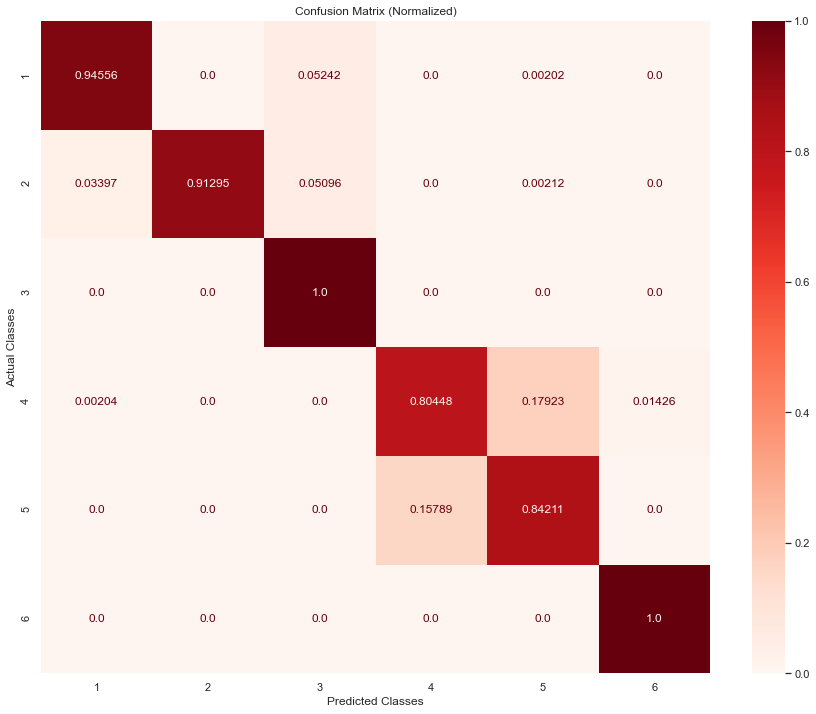

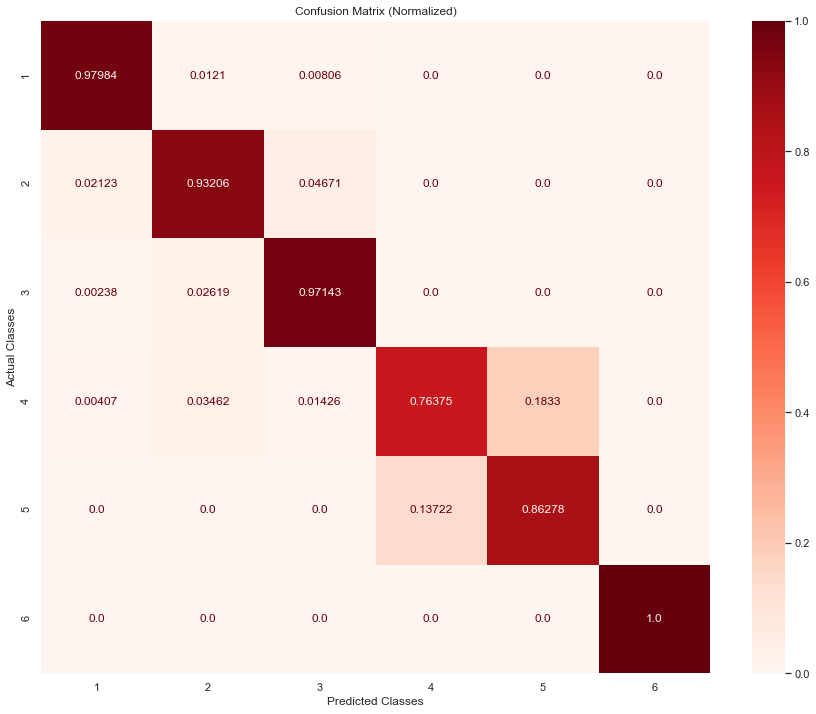

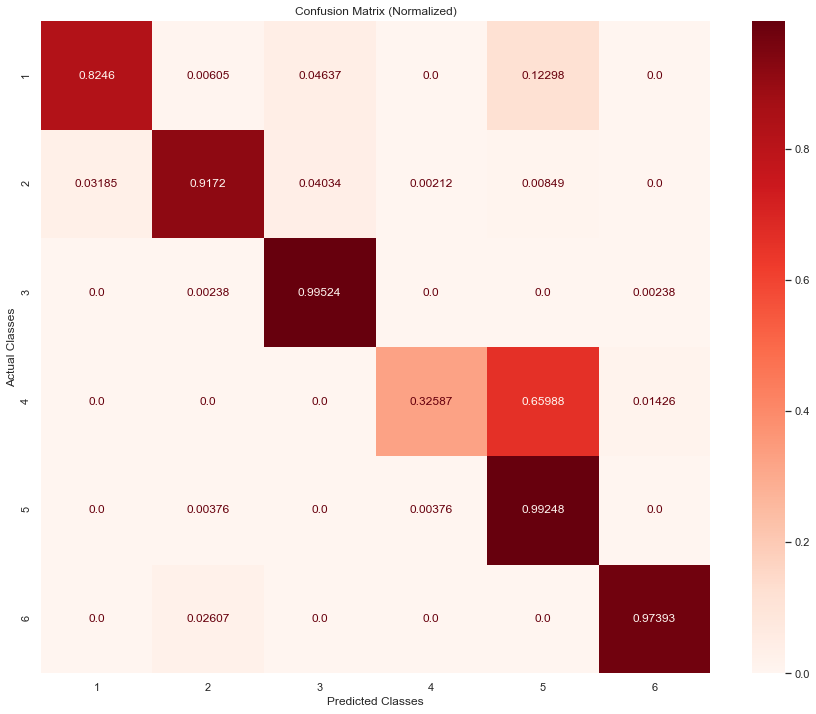

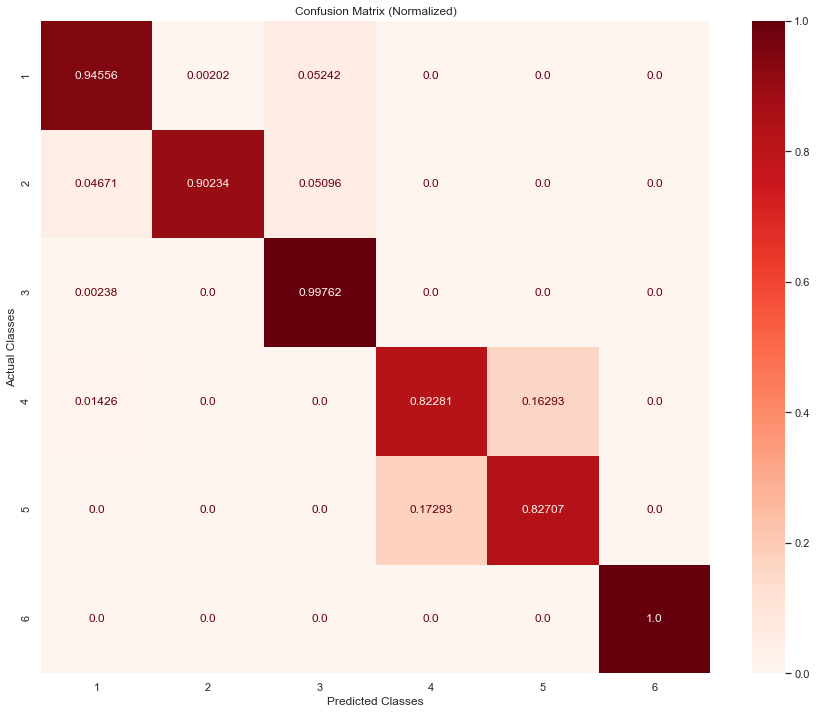

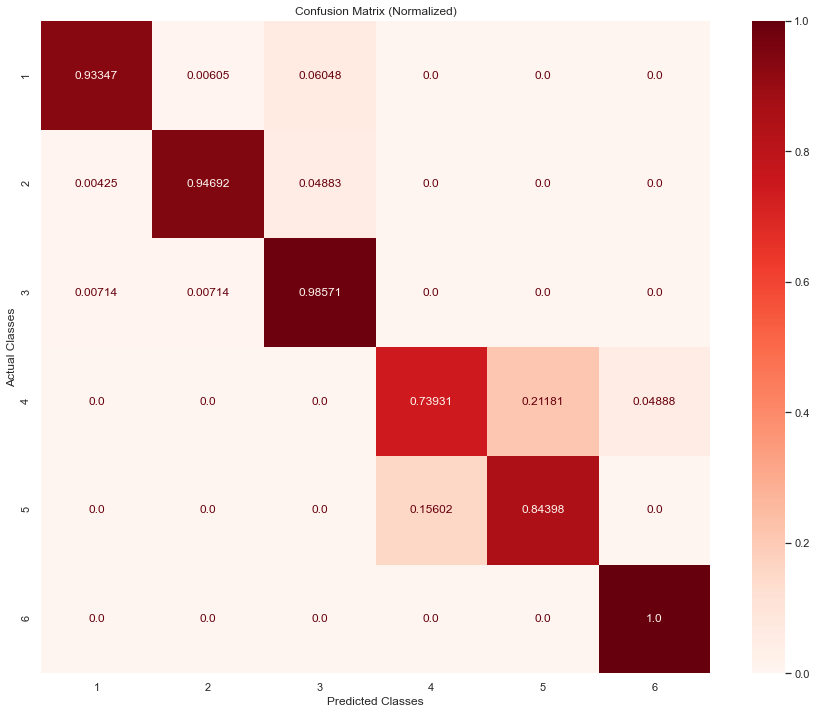

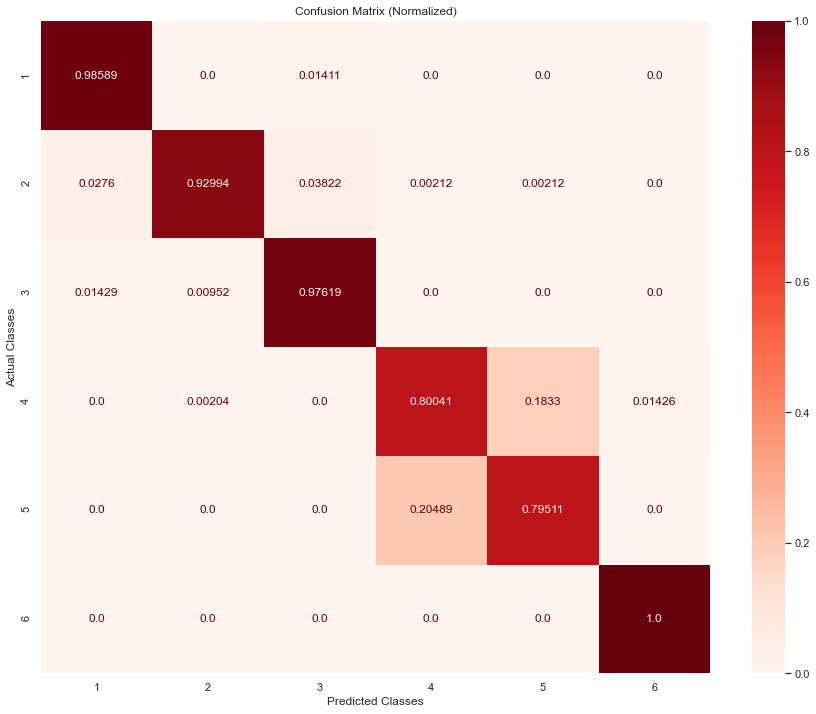

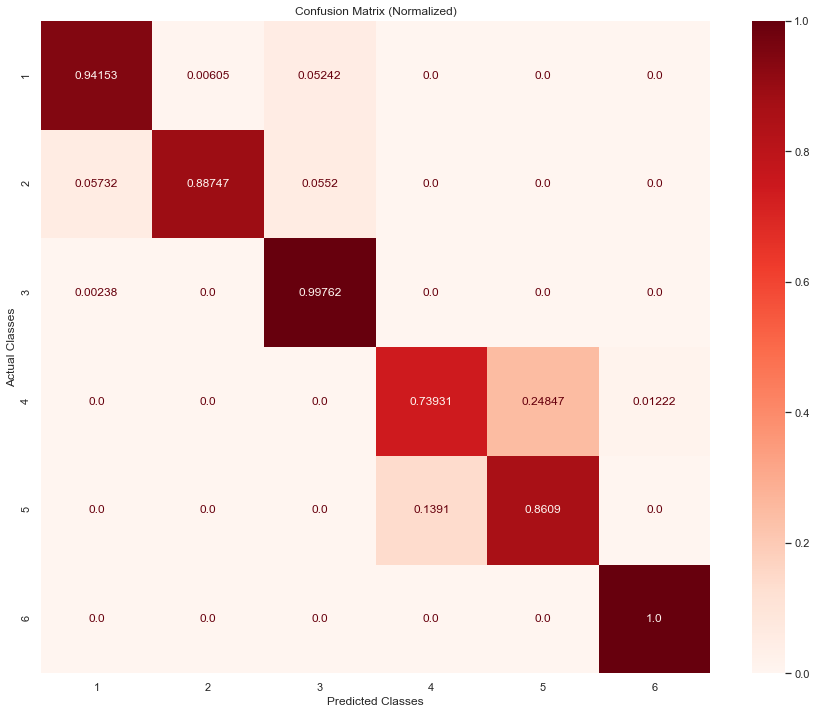

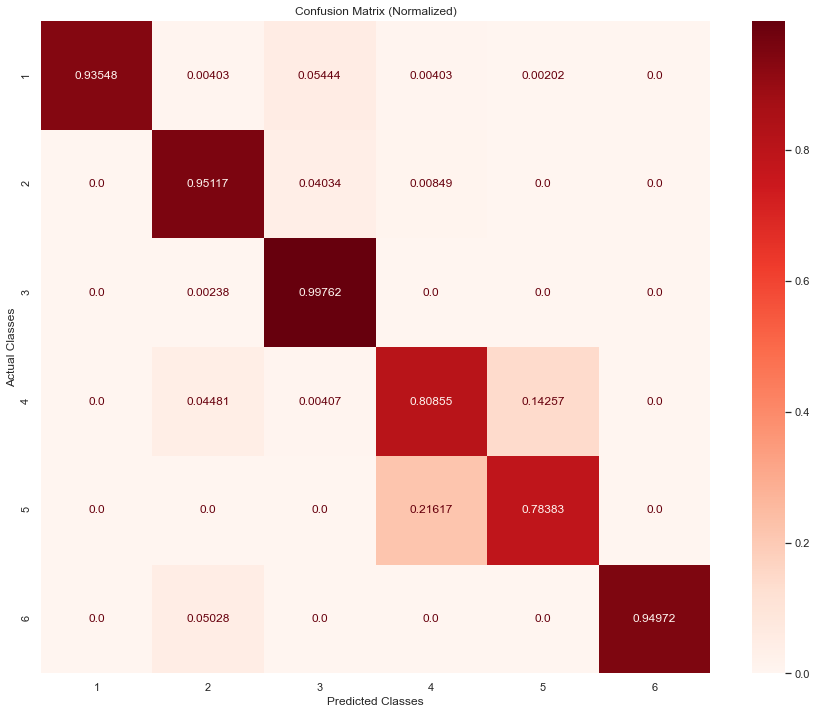

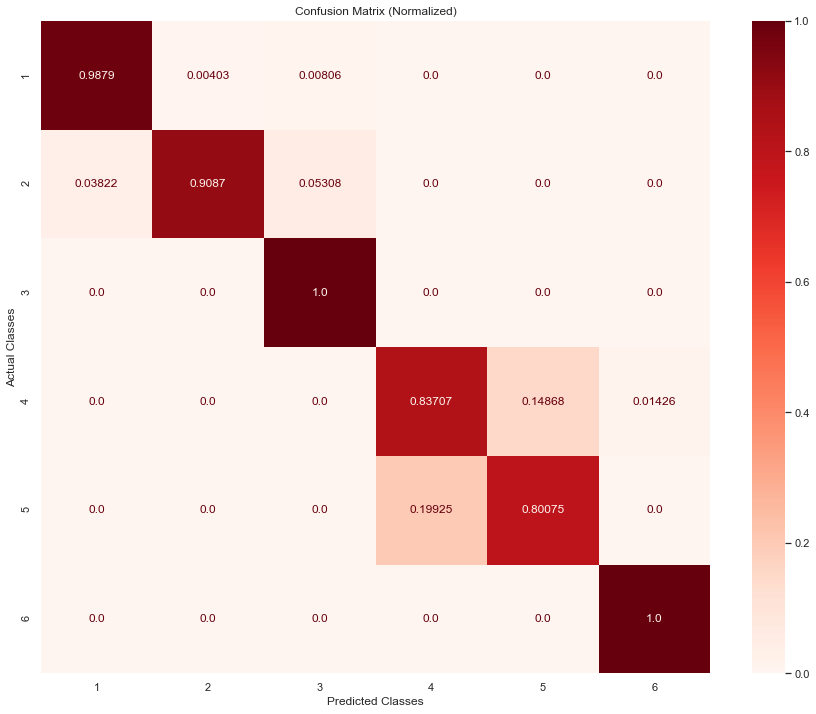

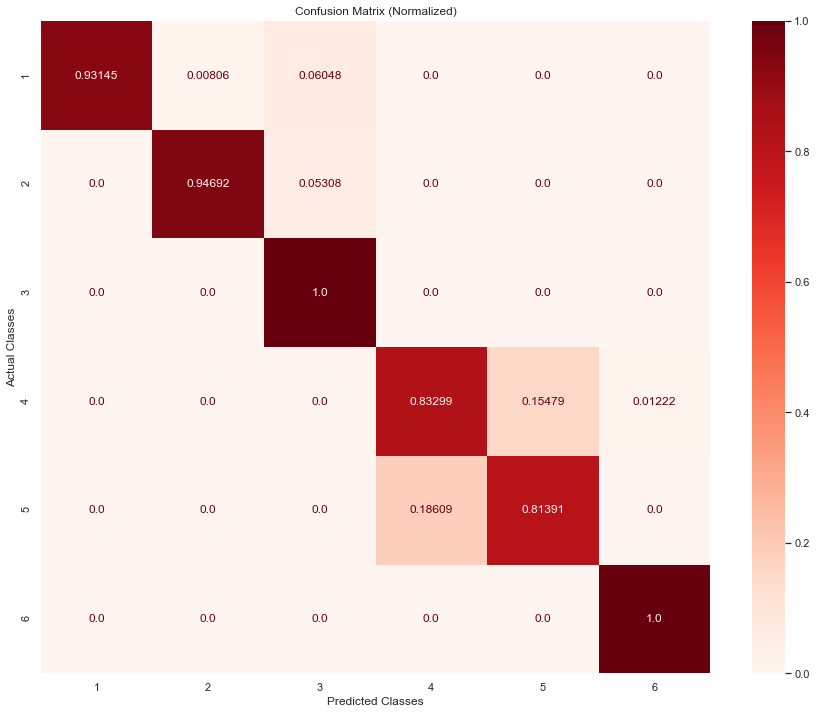

In [78]:
repeat_experiment_dac(model_type="lstm")

Run:  1
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 4s 5ms/step - loss: 0.0406 - accuracy: 0.9823 - val_loss: 0.0013 - val_accuracy: 0.9997
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 4.2138e-04 - accuracy: 0.9999 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 4.9636e-04 - accuracy: 0.9997 - val_loss: 7.4286e-04 - val_accuracy: 0.9997
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 1.8151e-05 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9993
Epoch 5/10
460/460 [==============================] - 2s 4ms/step - loss: 2.5114e-05 - accuracy: 1.0000 - val_loss

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0790 - accuracy: 0.9557 - val_loss: 0.8365 - val_accuracy: 0.8526
Epoch 46/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0833 - accuracy: 0.9577 - val_loss: 0.9827 - val_accuracy: 0.8442
Epoch 47/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0949 - accuracy: 0.9538 - val_loss: 0.7286 - val_accuracy: 0.8410
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0727 - accuracy: 0.9614 - val_loss: 0.9065 - val_accuracy: 0.8449
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0761 - accuracy: 0.9577 - val_loss: 0.8262 - val_accuracy: 0.8551
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0768 - accuracy: 0.9594 - val_loss: 0.8482 - val_accuracy: 0.8314
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0824 - accuracy: 0.9535 - val_loss: 0.7537 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 6.1806e-05 - accuracy: 1.0000 - val_loss: 0.2572 - val_accuracy: 0.9632
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.1402e-05 - accuracy: 1.0000 - val_loss: 0.2443 - val_accuracy: 0.9618
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.7983e-05 - accuracy: 1.0000 - val_loss: 0.2384 - val_accuracy: 0.9611
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.2005e-05 - accuracy: 1.0000 - val_loss: 0.2384 - val_accuracy: 0.9611
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.6591e-05 - accuracy: 1.0000 - val_loss: 0.1742 - val_accuracy: 0.9625
Epoch 48/5000
206/206 [==============================] - 1s 5ms/step - loss: 9.6881e-06 - accuracy: 1.0000 - val_loss: 0.1749 - val_accuracy: 0.9632
Epoch 49/5000
206/206 [==============================] - 1s 5ms/step - loss: 6.5256e-06 - accuracy: 1.0000 - val_loss: 0


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  2
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0268 - accuracy: 0.9878 - val_loss: 9.6540e-04 - val_accuracy: 0.9997
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0026 - val_accuracy: 0.9990
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 4.8046e-05 - accuracy: 1.0000 - val_loss: 2.4830e-04 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 9.2301e-06 - accuracy: 1.0000 - val_loss: 8.2424e-04 - val_accuracy: 0.9997
Epoch 5/10
460/460 [==============================] - 2s 5ms/step - loss: 9.0673e-06 - accuracy: 1.0000 - val_

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.1045 - accuracy: 0.9545 - val_loss: 0.5771 - val_accuracy: 0.8531
Epoch 46/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0840 - accuracy: 0.9572 - val_loss: 0.7827 - val_accuracy: 0.8493
Epoch 47/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0800 - accuracy: 0.9587 - val_loss: 0.7201 - val_accuracy: 0.8473
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.1003 - accuracy: 0.9548 - val_loss: 0.6599 - val_accuracy: 0.8255
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0755 - accuracy: 0.9604 - val_loss: 0.8684 - val_accuracy: 0.8403
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0824 - accuracy: 0.9570 - val_loss: 0.7128 - val_accuracy: 0.8422
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0815 - accuracy: 0.9639 - val_loss: 0.7208 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 9.4718e-05 - accuracy: 1.0000 - val_loss: 0.2902 - val_accuracy: 0.9546
Epoch 42/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0106 - accuracy: 0.9970 - val_loss: 0.3699 - val_accuracy: 0.9186
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0115 - accuracy: 0.9982 - val_loss: 0.3147 - val_accuracy: 0.9467
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0089 - accuracy: 0.9976 - val_loss: 0.4412 - val_accuracy: 0.9496
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.4766 - val_accuracy: 0.9409
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.4514e-04 - accuracy: 1.0000 - val_loss: 0.4776 - val_accuracy: 0.9532
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 9.4733e-05 - accuracy: 1.0000 - val_loss: 0.4716 - val_accu


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  3
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0386 - accuracy: 0.9842 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 6.6436e-04 - accuracy: 0.9999 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 4.3079e-05 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 0.9993
Epoch 5/10
460/460 [==============================] - 2s 5ms/step - loss: 2.7872e-05 - accuracy: 1.0000 - val_loss: 3.3364

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0942 - accuracy: 0.9557 - val_loss: 0.9946 - val_accuracy: 0.8314
Epoch 46/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0904 - accuracy: 0.9557 - val_loss: 1.0673 - val_accuracy: 0.8359
Epoch 47/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0892 - accuracy: 0.9540 - val_loss: 1.2197 - val_accuracy: 0.8218
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0896 - accuracy: 0.9570 - val_loss: 1.0762 - val_accuracy: 0.8346
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0941 - accuracy: 0.9567 - val_loss: 0.8956 - val_accuracy: 0.8160
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0732 - accuracy: 0.9621 - val_loss: 1.2335 - val_accuracy: 0.8154
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0808 - accuracy: 0.9599 - val_loss: 0.8768 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 1.8504e-06 - accuracy: 1.0000 - val_loss: 0.4468 - val_accuracy: 0.9589
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.0722e-06 - accuracy: 1.0000 - val_loss: 0.4542 - val_accuracy: 0.9582
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 9.1426e-07 - accuracy: 1.0000 - val_loss: 0.4571 - val_accuracy: 0.9582
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.3570e-06 - accuracy: 1.0000 - val_loss: 0.4908 - val_accuracy: 0.9589
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 8.8397e-07 - accuracy: 1.0000 - val_loss: 0.4874 - val_accuracy: 0.9582
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.3699e-06 - accuracy: 1.0000 - val_loss: 0.4857 - val_accuracy: 0.9596
Epoch 48/5000
206/206 [==============================] - 1s 5ms/step - loss: 6.3458e-07 - accuracy: 1.0000 - val_loss: 0


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  4
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0317 - accuracy: 0.9859 - val_loss: 0.0020 - val_accuracy: 0.9990
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.0029 - val_accuracy: 0.9986
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 4.5654e-05 - accuracy: 1.0000 - val_loss: 7.7570e-05 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 1.6246e-05 - accuracy: 1.0000 - val_loss: 3.3502e-04 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 2s 5ms/step - loss: 2.6965e-05 - accuracy: 1.0000 - val_loss

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0746 - accuracy: 0.9634 - val_loss: 1.0784 - val_accuracy: 0.8282
Epoch 46/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0887 - accuracy: 0.9555 - val_loss: 0.8453 - val_accuracy: 0.8494
Epoch 47/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0745 - accuracy: 0.9641 - val_loss: 1.1289 - val_accuracy: 0.8417
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0738 - accuracy: 0.9619 - val_loss: 0.9984 - val_accuracy: 0.8327
Epoch 49/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0724 - accuracy: 0.9639 - val_loss: 0.8874 - val_accuracy: 0.8327
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0692 - accuracy: 0.9641 - val_loss: 1.2673 - val_accuracy: 0.8372
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0735 - accuracy: 0.9634 - val_loss: 1.1821 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.3195 - val_accuracy: 0.9589
Epoch 42/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.6711e-04 - accuracy: 1.0000 - val_loss: 0.3111 - val_accuracy: 0.9618
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 4.7312e-05 - accuracy: 1.0000 - val_loss: 0.3054 - val_accuracy: 0.9596
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 4.6042e-05 - accuracy: 1.0000 - val_loss: 0.3300 - val_accuracy: 0.9625
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0131 - accuracy: 0.9957 - val_loss: 0.3454 - val_accuracy: 0.9416
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0077 - accuracy: 0.9973 - val_loss: 0.2910 - val_accuracy: 0.9539
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0013 - accuracy: 0.9994 - val_loss: 0.2324 - val_accu


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  5
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0328 - accuracy: 0.9857 - val_loss: 0.0082 - val_accuracy: 0.9973
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 0.0018 - accuracy: 0.9992 - val_loss: 2.2306e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 9.8229e-05 - accuracy: 1.0000 - val_loss: 2.5502e-05 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 1.5824e-05 - accuracy: 1.0000 - val_loss: 1.6199e-05 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 2s 5ms/step - loss: 8.0388e-06 - accuracy: 1.0000 - val_

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0789 - accuracy: 0.9602 - val_loss: 0.8525 - val_accuracy: 0.8481
Epoch 46/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.1032 - accuracy: 0.9545 - val_loss: 0.7844 - val_accuracy: 0.8442
Epoch 47/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0868 - accuracy: 0.9562 - val_loss: 1.0963 - val_accuracy: 0.8237
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0792 - accuracy: 0.9602 - val_loss: 1.0036 - val_accuracy: 0.8288
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0744 - accuracy: 0.9584 - val_loss: 1.1169 - val_accuracy: 0.8288
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0827 - accuracy: 0.9639 - val_loss: 0.7698 - val_accuracy: 0.8551
Epoch 51/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0768 - accuracy: 0.9614 - val_loss: 1.0363 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 0.0032 - accuracy: 0.9988 - val_loss: 0.1757 - val_accuracy: 0.9704
Epoch 42/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.6577e-04 - accuracy: 1.0000 - val_loss: 0.1683 - val_accuracy: 0.9719
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 6.0266e-04 - accuracy: 0.9997 - val_loss: 0.4076 - val_accuracy: 0.9193
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.1767 - val_accuracy: 0.9733
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 4.7385e-05 - accuracy: 1.0000 - val_loss: 0.1735 - val_accuracy: 0.9733
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0309 - accuracy: 0.9951 - val_loss: 0.1512 - val_accuracy: 0.9640
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 8.6603e-04 - accuracy: 1.0000 - val_loss: 0.1743 - val_


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  6
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0314 - accuracy: 0.9890 - val_loss: 0.0081 - val_accuracy: 0.9993
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 6.2222e-04 - accuracy: 0.9997 - val_loss: 3.2429e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 2.1970e-04 - accuracy: 1.0000 - val_loss: 3.6529e-04 - val_accuracy: 0.9997
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 1.8752e-05 - accuracy: 1.0000 - val_loss: 2.3205e-05 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 2s 5ms/step - loss: 6.3609e-06 - accuracy: 1.0000 - 

255/255 [==============================] - 1s 4ms/step - loss: 0.0505 - accuracy: 0.9766 - val_loss: 0.9080 - val_accuracy: 0.8404
Epoch 101/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0432 - accuracy: 0.9806 - val_loss: 1.0980 - val_accuracy: 0.8462
Epoch 102/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0512 - accuracy: 0.9739 - val_loss: 0.9718 - val_accuracy: 0.8378
Epoch 103/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0536 - accuracy: 0.9771 - val_loss: 0.9434 - val_accuracy: 0.8442
Epoch 104/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0430 - accuracy: 0.9803 - val_loss: 0.9633 - val_accuracy: 0.8455
Epoch 105/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0432 - accuracy: 0.9784 - val_loss: 1.0423 - val_accuracy: 0.8340
Epoch 106/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0511 - accuracy: 0.9769 - val_loss: 0.8450 - val_accuracy: 

206/206 [==============================] - 1s 5ms/step - loss: 1.0549e-04 - accuracy: 1.0000 - val_loss: 0.2517 - val_accuracy: 0.9712
Epoch 96/5000
206/206 [==============================] - 1s 5ms/step - loss: 3.0787e-05 - accuracy: 1.0000 - val_loss: 0.2462 - val_accuracy: 0.9733
Epoch 97/5000
206/206 [==============================] - 1s 5ms/step - loss: 4.0684e-05 - accuracy: 1.0000 - val_loss: 0.2438 - val_accuracy: 0.9726
Epoch 98/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.3882e-05 - accuracy: 1.0000 - val_loss: 0.2417 - val_accuracy: 0.9733
Epoch 99/5000
206/206 [==============================] - 1s 5ms/step - loss: 9.6803e-06 - accuracy: 1.0000 - val_loss: 0.2412 - val_accuracy: 0.9748
Epoch 100/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.0739e-05 - accuracy: 1.0000 - val_loss: 0.2406 - val_accuracy: 0.9748
Epoch 101/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.9587e-05 - accuracy: 1.0000 - val_loss:


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  7
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0279 - accuracy: 0.9884 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 2.8531e-04 - accuracy: 1.0000 - val_loss: 4.5775e-05 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 1.9854e-04 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 1.1602e-04 - accuracy: 1.0000 - val_loss: 3.1011e-05 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 2s 5ms/step - loss: 9.5600e-06 - accuracy: 1.0000 - val_

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0793 - accuracy: 0.9612 - val_loss: 1.1109 - val_accuracy: 0.8481
Epoch 46/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0828 - accuracy: 0.9589 - val_loss: 0.8657 - val_accuracy: 0.8673
Epoch 47/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0780 - accuracy: 0.9614 - val_loss: 1.1493 - val_accuracy: 0.8385
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0812 - accuracy: 0.9592 - val_loss: 1.3230 - val_accuracy: 0.8571
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0800 - accuracy: 0.9651 - val_loss: 1.0483 - val_accuracy: 0.8526
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0801 - accuracy: 0.9614 - val_loss: 1.2586 - val_accuracy: 0.8481
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.1016 - accuracy: 0.9602 - val_loss: 1.2732 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 2.6134e-04 - accuracy: 1.0000 - val_loss: 0.2345 - val_accuracy: 0.9618
Epoch 42/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.5082e-04 - accuracy: 1.0000 - val_loss: 0.2530 - val_accuracy: 0.9603
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 8.0254e-05 - accuracy: 1.0000 - val_loss: 0.2441 - val_accuracy: 0.9618
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 7.4349e-05 - accuracy: 1.0000 - val_loss: 0.2395 - val_accuracy: 0.9618
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 4.1049e-05 - accuracy: 1.0000 - val_loss: 0.2439 - val_accuracy: 0.9618
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 3.6297e-05 - accuracy: 1.0000 - val_loss: 0.2460 - val_accuracy: 0.9625
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.2671e-04 - accuracy: 1.0000 - val_loss: 0


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  8
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0359 - accuracy: 0.9830 - val_loss: 0.0087 - val_accuracy: 0.9980
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 1.0322e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 5.0562e-05 - accuracy: 1.0000 - val_loss: 3.7819e-05 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 2.0326e-05 - accuracy: 1.0000 - val_loss: 5.4375e-05 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 2s 5ms/step - loss: 5.4540e-06 - accuracy: 1.0000 - val_

Epoch 45/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0799 - accuracy: 0.9616 - val_loss: 0.8328 - val_accuracy: 0.8590
Epoch 46/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0875 - accuracy: 0.9599 - val_loss: 0.7574 - val_accuracy: 0.8462
Epoch 47/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0731 - accuracy: 0.9626 - val_loss: 0.8354 - val_accuracy: 0.8481
Epoch 48/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0765 - accuracy: 0.9629 - val_loss: 0.8406 - val_accuracy: 0.8667
Epoch 49/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0775 - accuracy: 0.9656 - val_loss: 0.7561 - val_accuracy: 0.8474
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0755 - accuracy: 0.9639 - val_loss: 0.7412 - val_accuracy: 0.8596
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0795 - accuracy: 0.9612 - val_loss: 0.6987 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 3.1992e-05 - accuracy: 1.0000 - val_loss: 0.1997 - val_accuracy: 0.9618
Epoch 42/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.8941e-05 - accuracy: 1.0000 - val_loss: 0.2055 - val_accuracy: 0.9618
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.8810e-05 - accuracy: 1.0000 - val_loss: 0.2110 - val_accuracy: 0.9618
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.6640e-05 - accuracy: 1.0000 - val_loss: 0.2229 - val_accuracy: 0.9632
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.1042e-05 - accuracy: 1.0000 - val_loss: 0.2307 - val_accuracy: 0.9632
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.6439e-05 - accuracy: 1.0000 - val_loss: 0.2410 - val_accuracy: 0.9618
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0218 - accuracy: 0.9936 - val_loss: 0.099


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  9
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0293 - accuracy: 0.9887 - val_loss: 0.0065 - val_accuracy: 0.9976
Epoch 2/10
460/460 [==============================] - 2s 4ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 1.7454e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 5.4856e-05 - accuracy: 1.0000 - val_loss: 8.7539e-05 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 9.6805e-06 - accuracy: 1.0000 - val_loss: 9.9760e-05 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 2s 4ms/step - loss: 9.9081e-06 - accuracy: 1.0000 - val_

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0982 - accuracy: 0.9557 - val_loss: 0.8459 - val_accuracy: 0.8385
Epoch 46/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0903 - accuracy: 0.9562 - val_loss: 0.7272 - val_accuracy: 0.8378
Epoch 47/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0876 - accuracy: 0.9599 - val_loss: 0.8357 - val_accuracy: 0.8385
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0895 - accuracy: 0.9584 - val_loss: 0.8673 - val_accuracy: 0.8500
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0860 - accuracy: 0.9589 - val_loss: 0.9818 - val_accuracy: 0.8295
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0842 - accuracy: 0.9584 - val_loss: 1.0809 - val_accuracy: 0.8500
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0845 - accuracy: 0.9557 - val_loss: 1.0812 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 2.8328e-04 - accuracy: 1.0000 - val_loss: 0.2007 - val_accuracy: 0.9618
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.2626e-04 - accuracy: 1.0000 - val_loss: 0.2173 - val_accuracy: 0.9603
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 6.0911e-05 - accuracy: 1.0000 - val_loss: 0.2221 - val_accuracy: 0.9603
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 3.9129e-05 - accuracy: 1.0000 - val_loss: 0.2193 - val_accuracy: 0.9618
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.0795e-04 - accuracy: 1.0000 - val_loss: 0.2419 - val_accuracy: 0.9438
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 7.9821e-05 - accuracy: 1.0000 - val_loss: 0.2733 - val_accuracy: 0.9611
Epoch 48/5000
206/206 [==============================] - 1s 5ms/step - loss: 3.2423e-05 - accuracy: 1.0000 - val_loss: 0


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  10
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0396 - accuracy: 0.9822 - val_loss: 8.7045e-04 - val_accuracy: 0.9997
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 2.6982e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 0.9997
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 3.8784e-05 - accuracy: 1.0000 - val_loss: 1.7552e-05 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 2s 4ms/step - loss: 1.5186e-05 - accuracy: 1.0000 - val_los

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0783 - accuracy: 0.9624 - val_loss: 0.7636 - val_accuracy: 0.8359
Epoch 46/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0800 - accuracy: 0.9614 - val_loss: 0.7752 - val_accuracy: 0.8346
Epoch 47/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0790 - accuracy: 0.9621 - val_loss: 0.8824 - val_accuracy: 0.8308
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0903 - accuracy: 0.9594 - val_loss: 1.0031 - val_accuracy: 0.8442
Epoch 49/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.1113 - accuracy: 0.9521 - val_loss: 0.8163 - val_accuracy: 0.8455
Epoch 50/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0789 - accuracy: 0.9629 - val_loss: 0.7860 - val_accuracy: 0.8359
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0722 - accuracy: 0.9639 - val_loss: 0.7637 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 5.6199e-05 - accuracy: 1.0000 - val_loss: 0.2989 - val_accuracy: 0.9539
Epoch 42/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.1140e-05 - accuracy: 1.0000 - val_loss: 0.3068 - val_accuracy: 0.9553
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 7.6804e-06 - accuracy: 1.0000 - val_loss: 0.3146 - val_accuracy: 0.9553
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 6.4188e-06 - accuracy: 1.0000 - val_loss: 0.3221 - val_accuracy: 0.9560
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0295 - accuracy: 0.9942 - val_loss: 0.2648 - val_accuracy: 0.9438
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 7.0639e-04 - accuracy: 1.0000 - val_loss: 0.1621 - val_accuracy: 0.9596
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0060 - accuracy: 0.9979 - val_loss: 0.2334 - 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


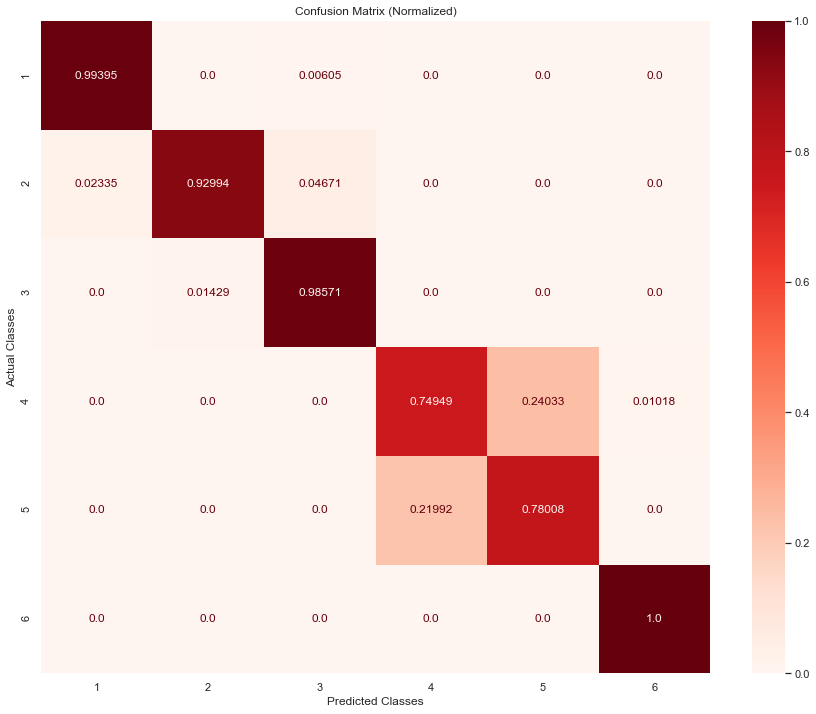

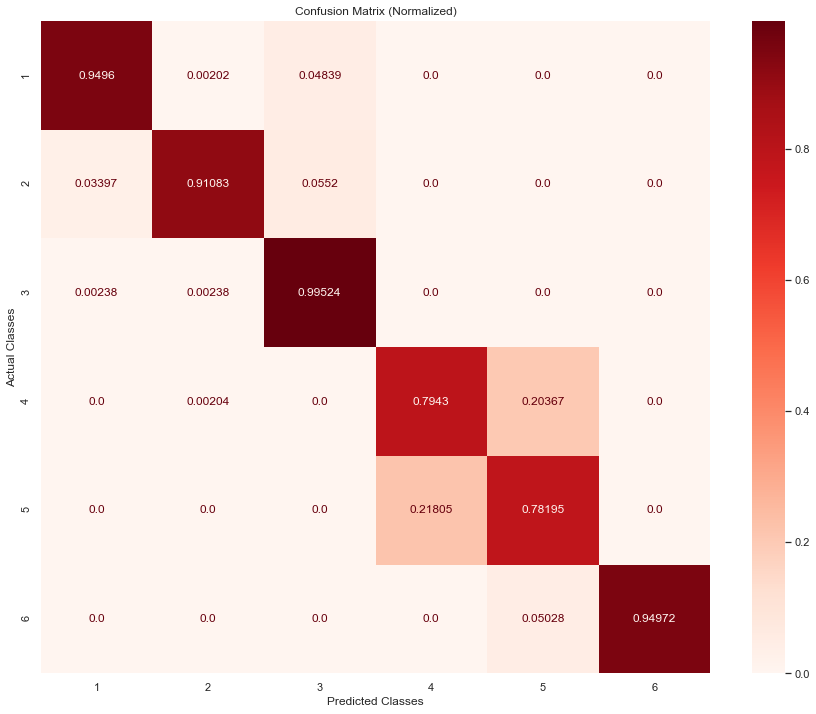

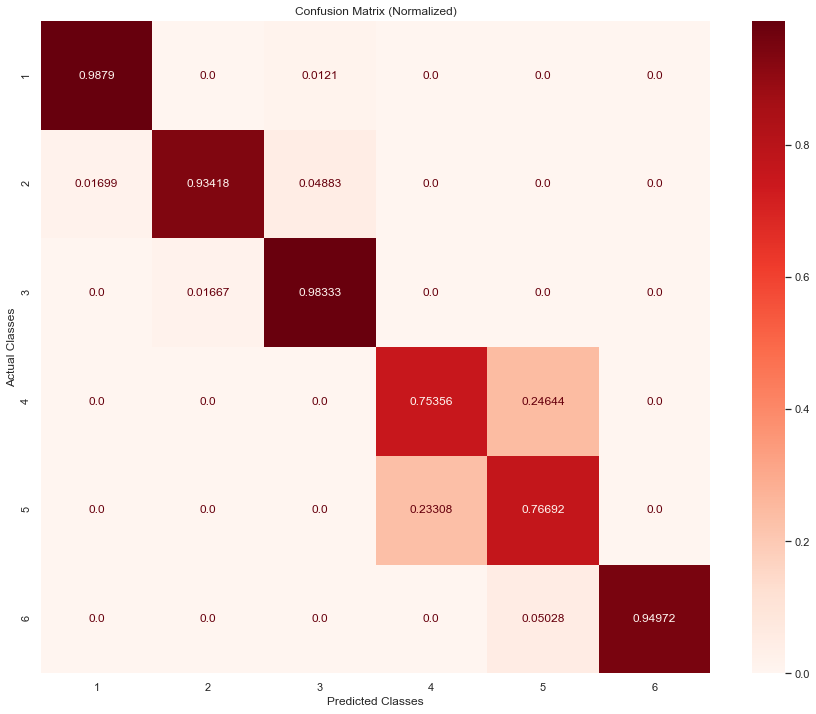

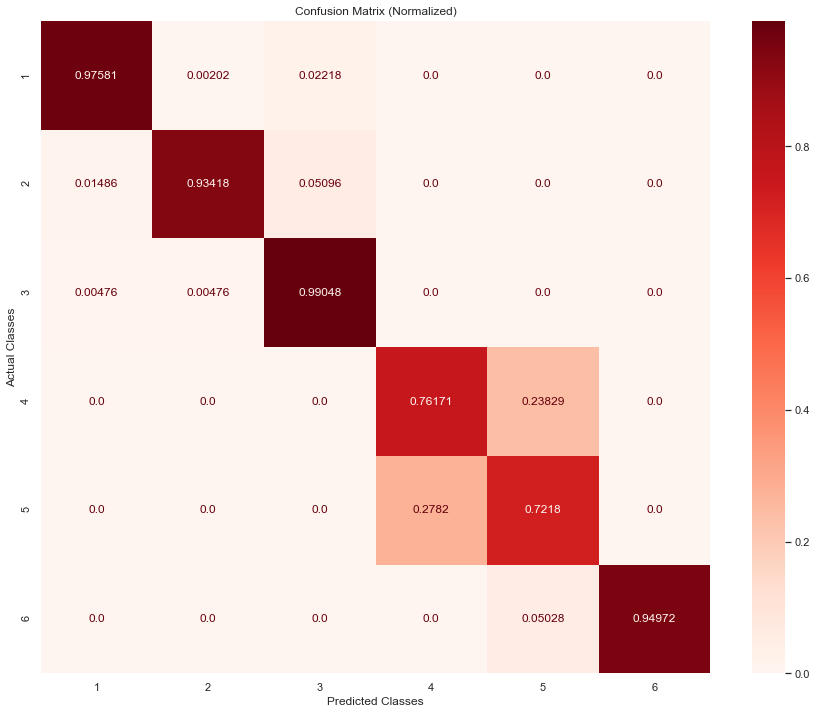

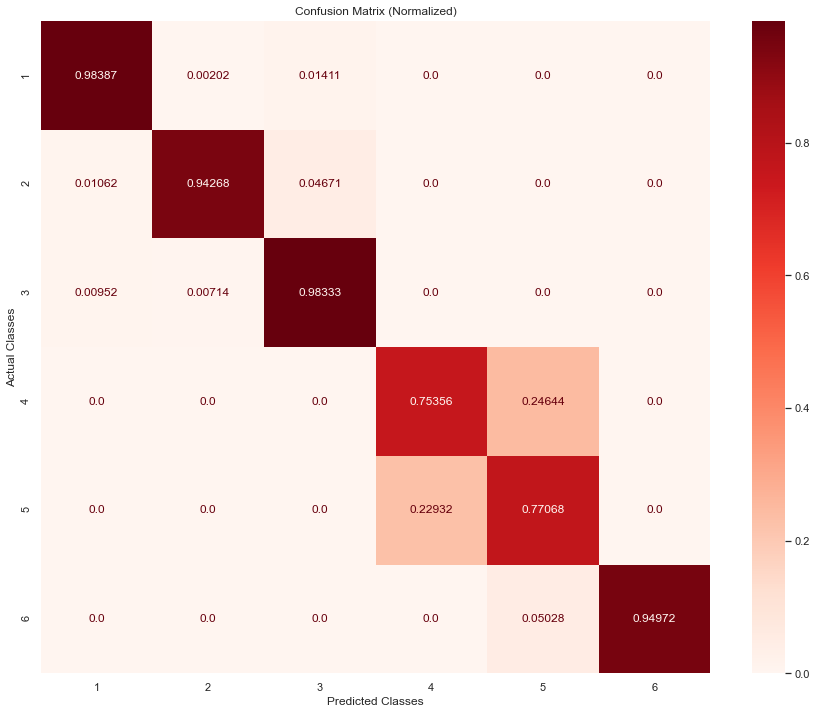

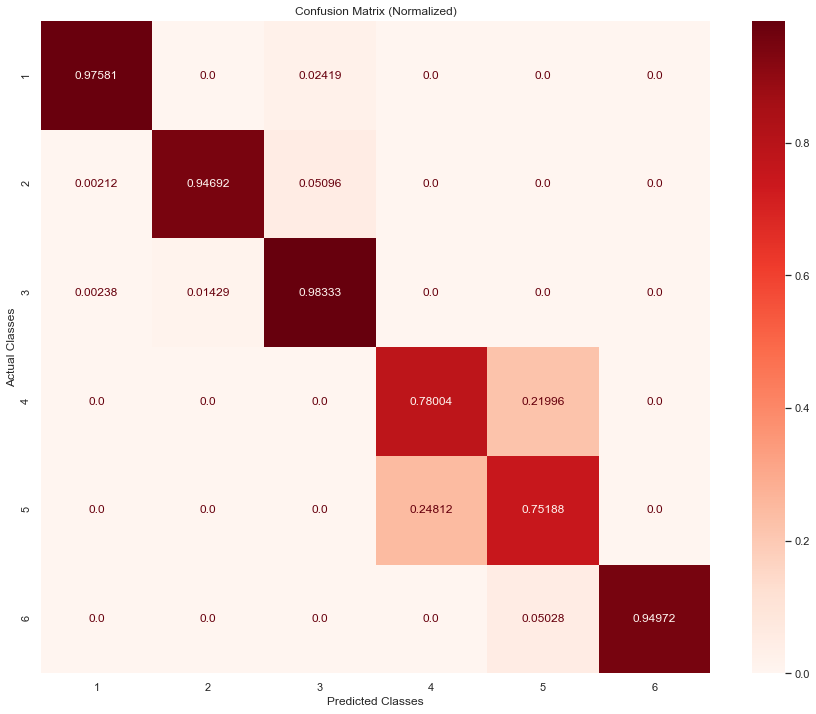

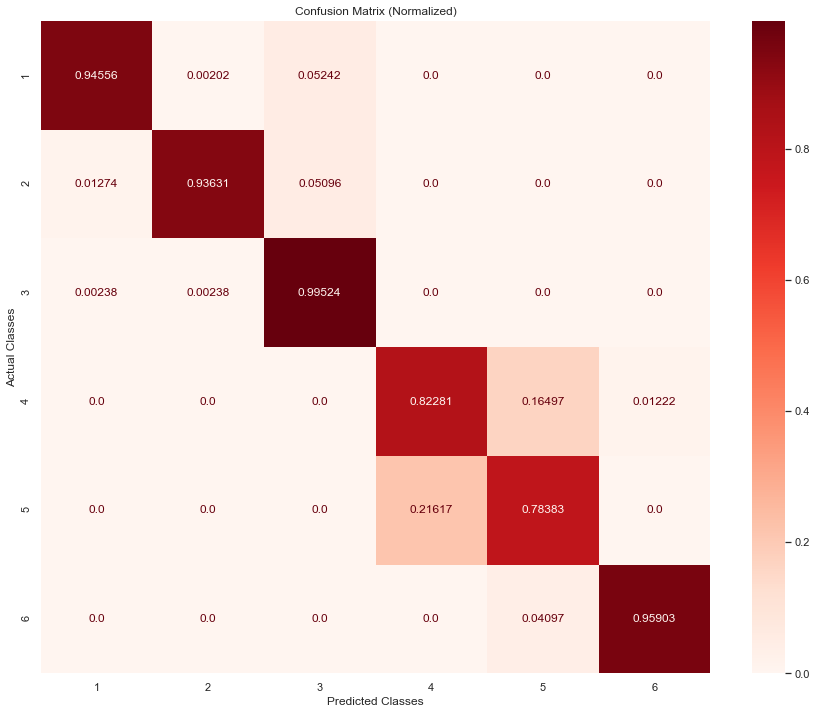

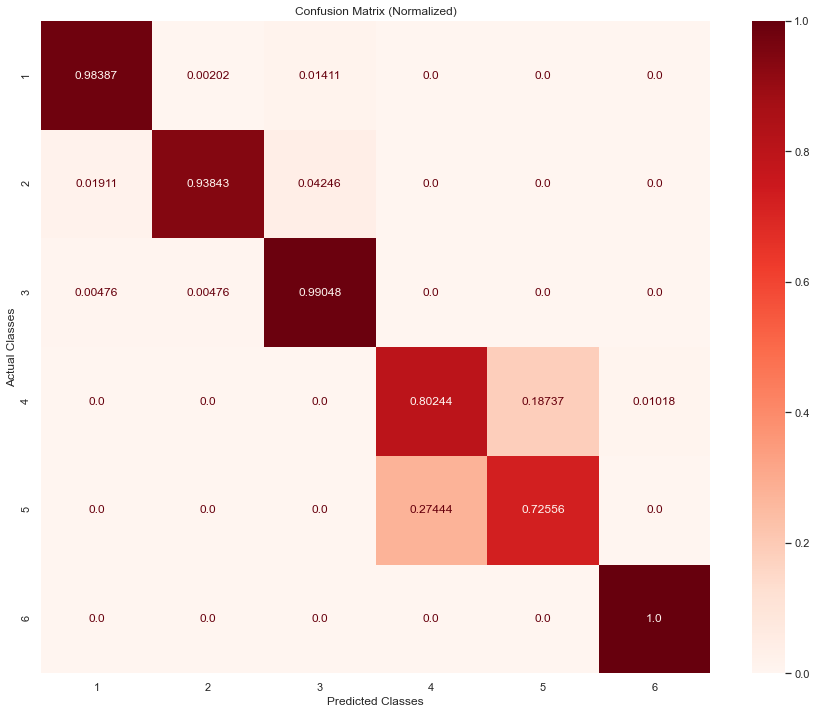

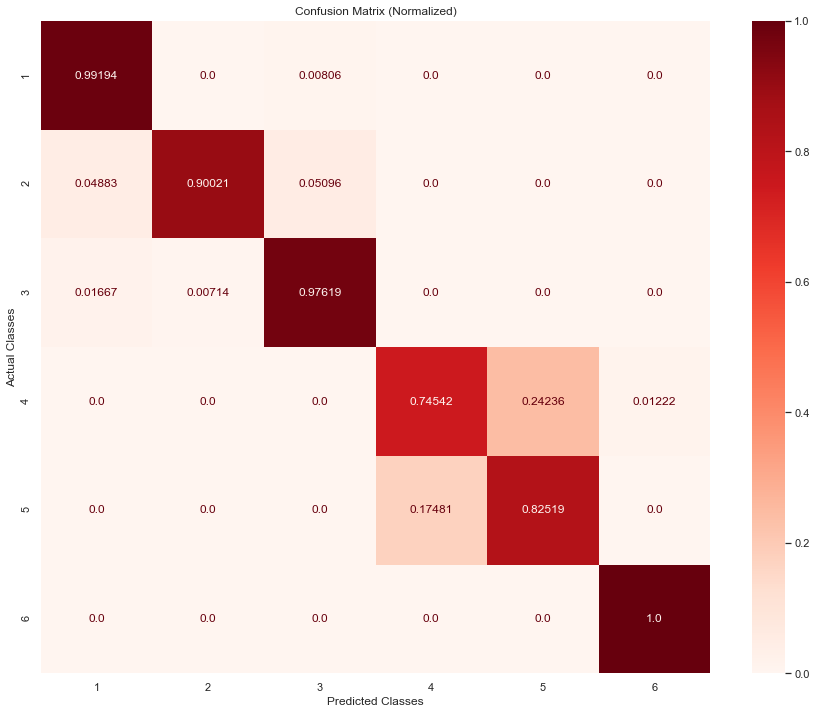

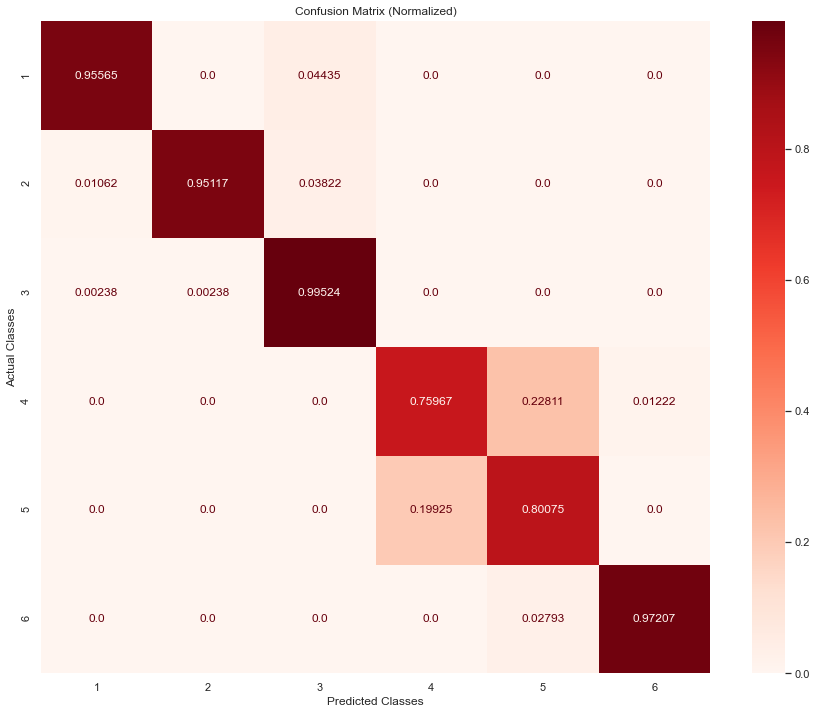

In [79]:
repeat_experiment_dac(model_type="cnnlstm")

Run:  1
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 8s 16ms/step - loss: 0.0364 - accuracy: 0.9853 - val_loss: 4.6655e-04 - val_accuracy: 1.0000
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 2.2468e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 7s 15ms/step - loss: 3.2701e-04 - accuracy: 0.9999 - val_loss: 0.0143 - val_accuracy: 0.9952
Epoch 4/10
460/460 [==============================] - 7s 15ms/step - loss: 3.4010e-04 - accuracy: 1.0000 - val_loss: 3.4399e-05 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 7s 15ms/step - loss: 1.4024e-04 - accuracy: 1.0000 -

206/206 [==============================] - 3s 14ms/step - loss: 0.0190 - accuracy: 0.9954 - val_loss: 0.4497 - val_accuracy: 0.9344
Epoch 12/5000
206/206 [==============================] - 3s 14ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 0.5359 - val_accuracy: 0.9409
Epoch 13/5000
206/206 [==============================] - 3s 14ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.5496 - val_accuracy: 0.9329
Epoch 14/5000
206/206 [==============================] - 3s 14ms/step - loss: 0.0103 - accuracy: 0.9954 - val_loss: 0.4347 - val_accuracy: 0.9409
Epoch 15/5000
206/206 [==============================] - 3s 14ms/step - loss: 0.0177 - accuracy: 0.9939 - val_loss: 0.3971 - val_accuracy: 0.9329
Epoch 16/5000
206/206 [==============================] - 3s 14ms/step - loss: 0.0076 - accuracy: 0.9976 - val_loss: 0.6214 - val_accuracy: 0.9402
Epoch 17/5000
206/206 [==============================] - 3s 14ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.5660 - val_accuracy:


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  2
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 11s 21ms/step - loss: 0.0326 - accuracy: 0.9891 - val_loss: 0.0019 - val_accuracy: 0.9993
Epoch 2/10
460/460 [==============================] - 9s 20ms/step - loss: 0.0012 - accuracy: 0.9993 - val_loss: 8.6233e-05 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 9s 20ms/step - loss: 9.9300e-04 - accuracy: 0.9997 - val_loss: 9.0581e-05 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 9s 20ms/step - loss: 7.7075e-04 - accuracy: 0.9999 - val_loss: 0.0158 - val_accuracy: 0.9966
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
254/254 [=============


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  3
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 11s 20ms/step - loss: 0.0352 - accuracy: 0.9857 - val_loss: 5.6241e-04 - val_accuracy: 1.0000
Epoch 2/10
460/460 [==============================] - 9s 20ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 2.0479e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 9s 20ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 4/10
460/460 [==============================] - 9s 20ms/step - loss: 8.1590e-04 - accuracy: 0.9999 - val_loss: 4.2711e-05 - val_accuracy: 1.0000
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [=============


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  4
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 10s 19ms/step - loss: 0.0378 - accuracy: 0.9838 - val_loss: 0.0017 - val_accuracy: 0.9993
Epoch 2/10
460/460 [==============================] - 8s 18ms/step - loss: 0.0035 - accuracy: 0.9995 - val_loss: 7.2318e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 8s 18ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0101 - val_accuracy: 0.9952
Epoch 4/10
460/460 [==============================] - 8s 18ms/step - loss: 9.3612e-04 - accuracy: 0.9999 - val_loss: 0.0022 - val_accuracy: 0.9990
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [=====================


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  5
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 10s 19ms/step - loss: 0.0364 - accuracy: 0.9844 - val_loss: 0.0025 - val_accuracy: 0.9993
Epoch 2/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0101 - val_accuracy: 0.9993
Epoch 3/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 4.6395e-04 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 9s 19ms/step - loss: 4.5942e-05 - accuracy: 1.0000 - val_loss: 7.1498e-04 - val_accuracy: 0.9997
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [=================


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  6
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 11s 21ms/step - loss: 0.0301 - accuracy: 0.9879 - val_loss: 0.0025 - val_accuracy: 0.9993
Epoch 2/10
460/460 [==============================] - 9s 20ms/step - loss: 0.0031 - accuracy: 0.9986 - val_loss: 4.5291e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 9s 20ms/step - loss: 2.2829e-04 - accuracy: 1.0000 - val_loss: 4.2074e-05 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 9s 20ms/step - loss: 6.8014e-04 - accuracy: 0.9999 - val_loss: 2.8333e-04 - val_accuracy: 1.0000
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [=========

206/206 [==============================] - 4s 18ms/step - loss: 2.9363e-04 - accuracy: 1.0000 - val_loss: 0.9724 - val_accuracy: 0.9351
Epoch 22/5000
206/206 [==============================] - 4s 18ms/step - loss: 0.0151 - accuracy: 0.9954 - val_loss: 0.3424 - val_accuracy: 0.9409
Epoch 23/5000
206/206 [==============================] - 4s 18ms/step - loss: 0.0075 - accuracy: 0.9963 - val_loss: 0.9563 - val_accuracy: 0.9286
Epoch 24/5000
206/206 [==============================] - 4s 18ms/step - loss: 0.0195 - accuracy: 0.9939 - val_loss: 0.5897 - val_accuracy: 0.9394
Epoch 25/5000
206/206 [==============================] - 4s 18ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 1.0033 - val_accuracy: 0.9185
Epoch 26/5000
206/206 [==============================] - 4s 18ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.5474 - val_accuracy: 0.9517
Epoch 27/5000
206/206 [==============================] - 4s 18ms/step - loss: 0.0013 - accuracy: 0.9994 - val_loss: 0.5583 - val_accur


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  7
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 11s 21ms/step - loss: 0.0300 - accuracy: 0.9891 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 2/10
460/460 [==============================] - 10s 21ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.0090 - val_accuracy: 0.9983
Epoch 3/10
460/460 [==============================] - 10s 21ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 8.2779e-05 - val_accuracy: 1.0000
Timed stopping at epoch 3 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [==============================] - 6s 20ms/step - loss: 0.2844 - accuracy: 0.8886 - val_loss: 0.3484 - val_accuracy: 0.8596
Epoch 2/5000
255/255 [=====================


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  8
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 11s 21ms/step - loss: 0.0338 - accuracy: 0.9849 - val_loss: 0.0072 - val_accuracy: 0.9990
Epoch 2/10
460/460 [==============================] - 9s 21ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 3.0751e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 9s 21ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0017 - val_accuracy: 1.0000
Timed stopping at epoch 3 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [==============================] - 6s 20ms/step - loss: 0.2907 - accuracy: 0.8800 - val_loss: 0.3076 - val_accuracy: 0.8679
Epoch 2/5000
255/255 [=======================


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  9
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 9s 18ms/step - loss: 0.0334 - accuracy: 0.9863 - val_loss: 7.6249e-04 - val_accuracy: 0.9997
Epoch 2/10
460/460 [==============================] - 8s 18ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0015 - val_accuracy: 0.9986
Epoch 3/10
460/460 [==============================] - 8s 18ms/step - loss: 1.0782e-04 - accuracy: 1.0000 - val_loss: 1.2571e-04 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 8s 18ms/step - loss: 4.8546e-05 - accuracy: 1.0000 - val_loss: 1.1800e-04 - val_accuracy: 1.0000
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [==========

206/206 [==============================] - 4s 19ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.7281 - val_accuracy: 0.9301
Epoch 24/5000
206/206 [==============================] - 4s 19ms/step - loss: 0.0079 - accuracy: 0.9976 - val_loss: 0.6845 - val_accuracy: 0.9351
Epoch 25/5000
206/206 [==============================] - 4s 19ms/step - loss: 0.0060 - accuracy: 0.9973 - val_loss: 0.6560 - val_accuracy: 0.9416
Epoch 26/5000
206/206 [==============================] - 4s 19ms/step - loss: 0.0073 - accuracy: 0.9985 - val_loss: 0.6372 - val_accuracy: 0.9423
Epoch 27/5000
206/206 [==============================] - 4s 19ms/step - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.6766 - val_accuracy: 0.9445
Epoch 28/5000
206/206 [==============================] - 4s 19ms/step - loss: 8.8225e-04 - accuracy: 1.0000 - val_loss: 0.7070 - val_accuracy: 0.9430
Epoch 29/5000
206/206 [==============================] - 4s 19ms/step - loss: 2.6052e-04 - accuracy: 1.0000 - val_loss: 0.7330 - val_a


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  10
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 9s 18ms/step - loss: 0.0341 - accuracy: 0.9876 - val_loss: 0.0094 - val_accuracy: 0.9976
Epoch 2/10
460/460 [==============================] - 8s 18ms/step - loss: 0.0020 - accuracy: 0.9992 - val_loss: 0.0012 - val_accuracy: 0.9993
Epoch 3/10
460/460 [==============================] - 8s 18ms/step - loss: 9.4560e-04 - accuracy: 0.9997 - val_loss: 9.5575e-05 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 8s 18ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0031 - val_accuracy: 0.9993
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
254/254 [=====================


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


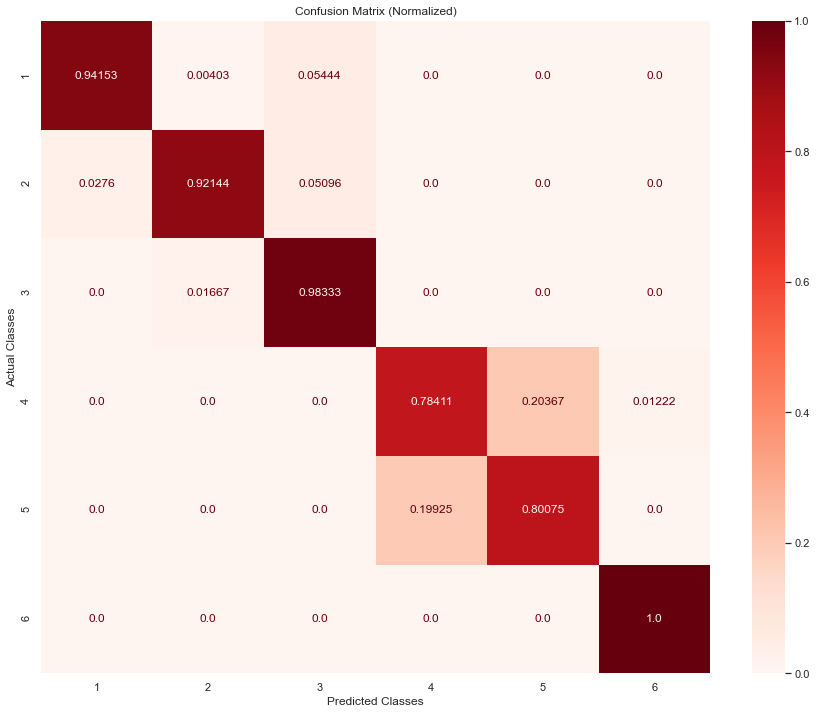

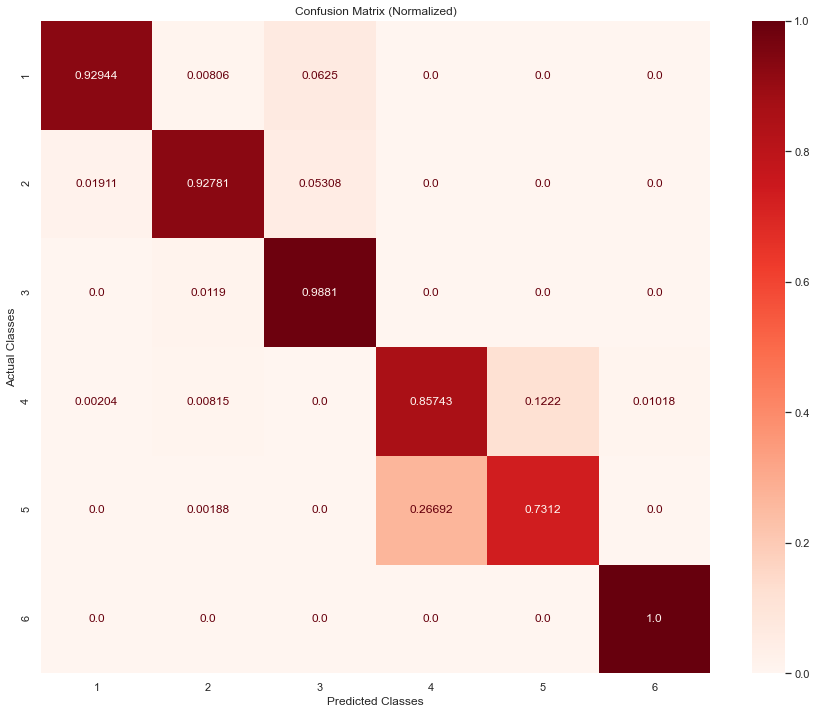

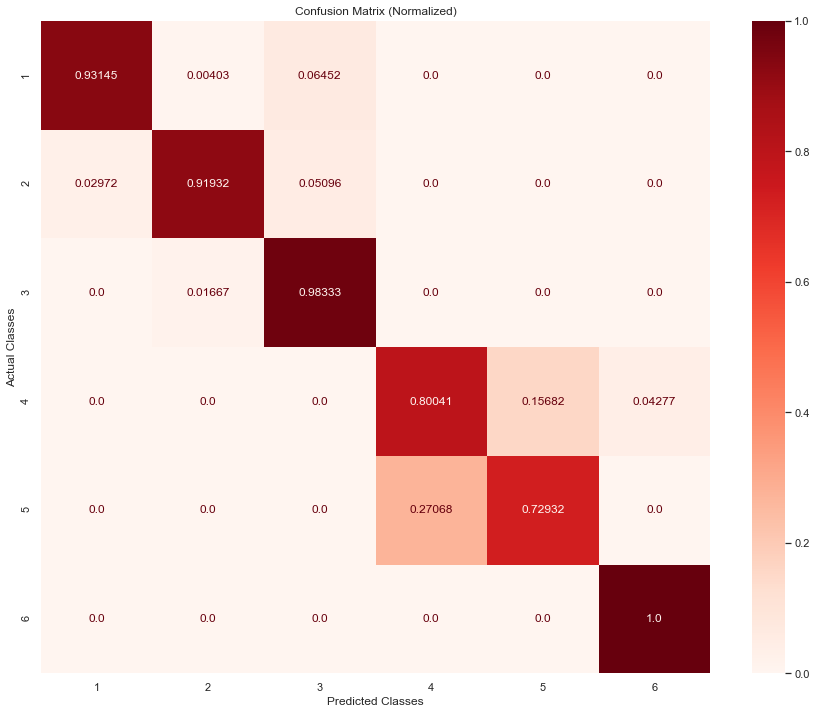

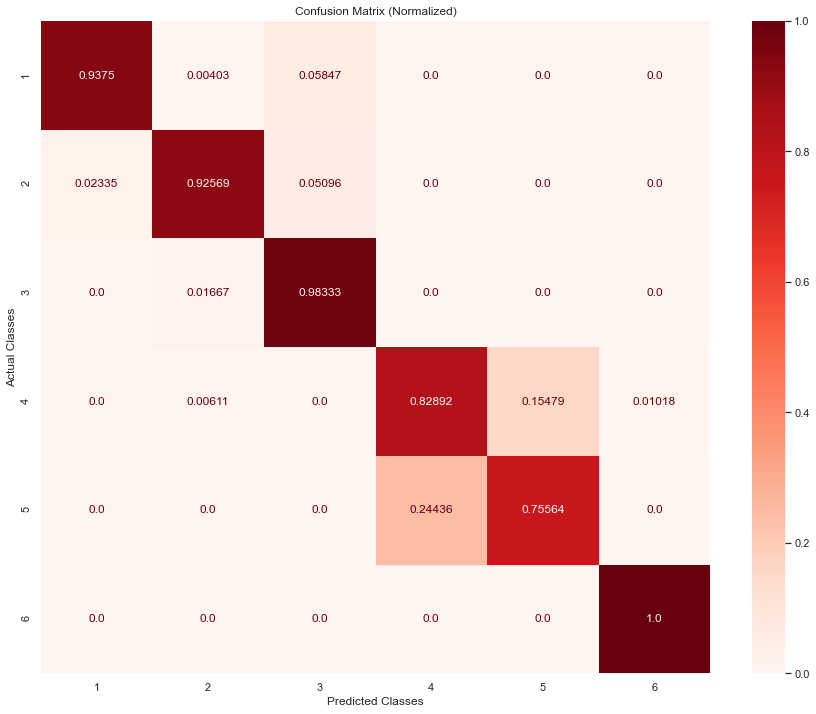

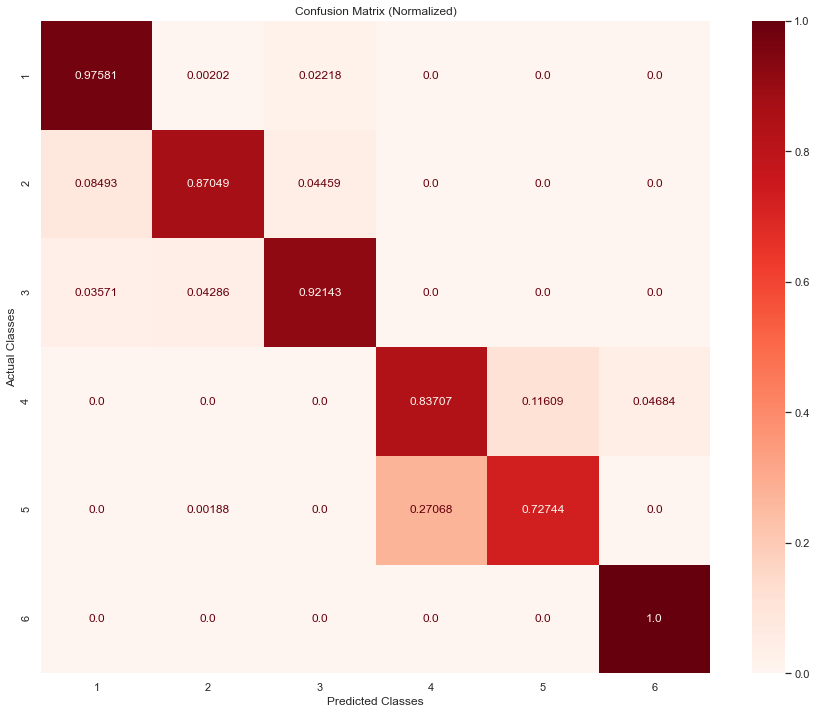

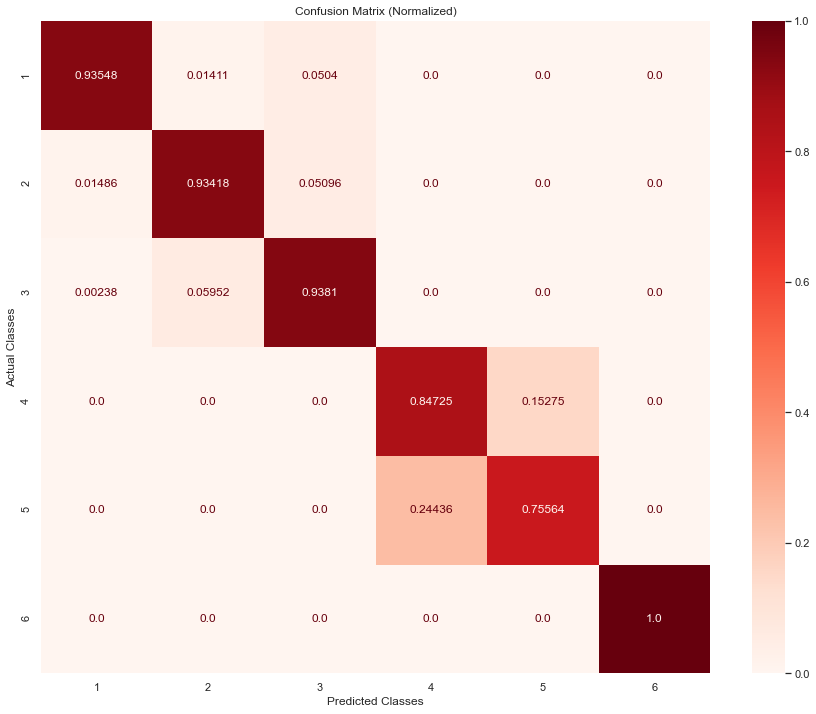

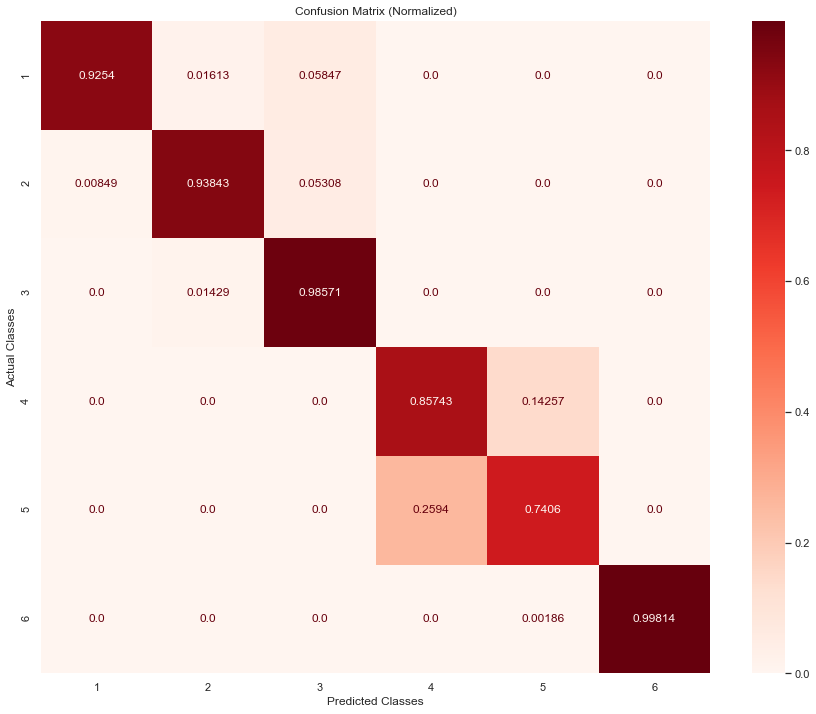

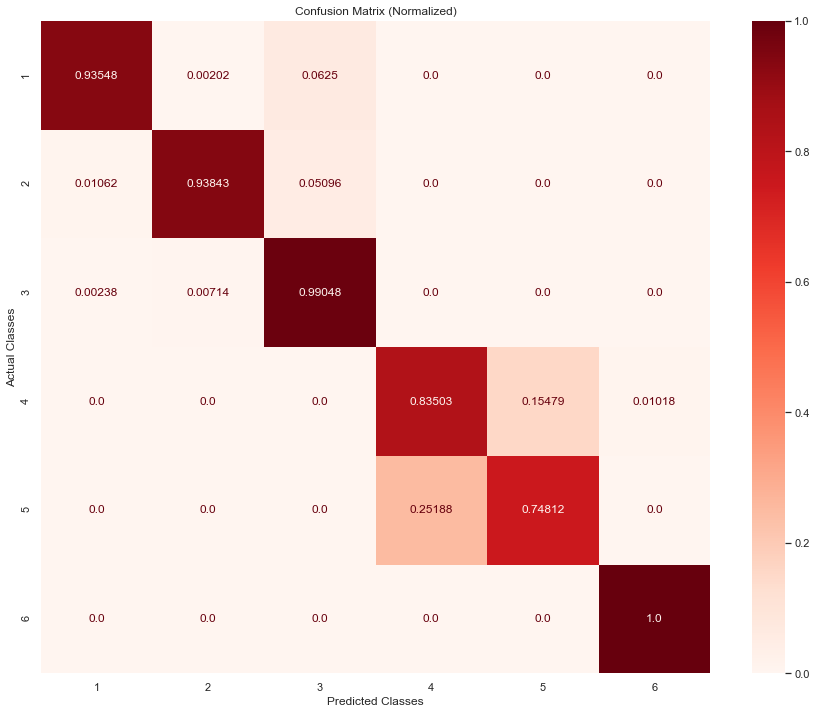

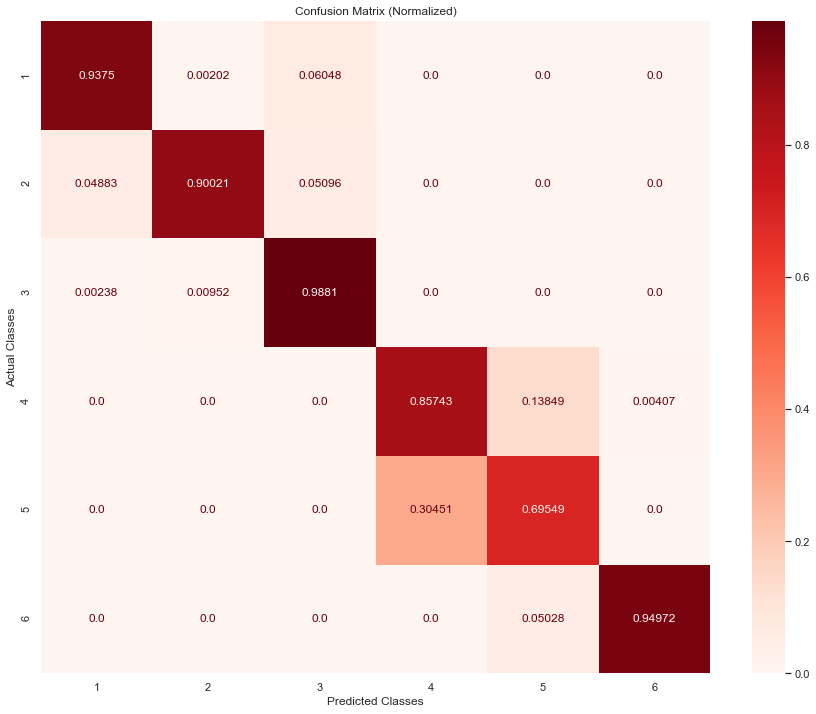

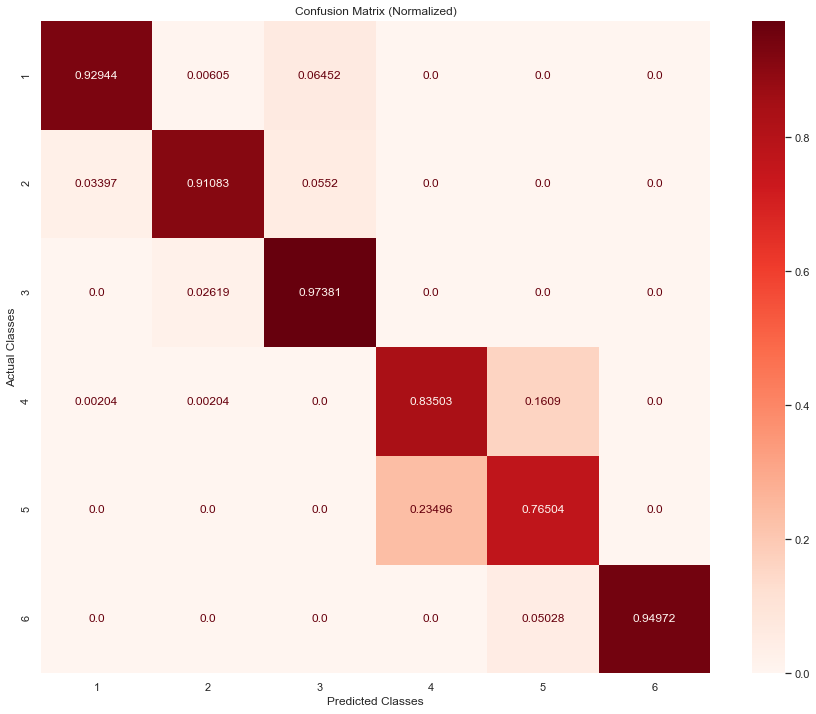

In [80]:
repeat_experiment_dac(model_type="convlstm")

Run:  1
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 16ms/step - loss: 0.3450 - accuracy: 0.8417 - val_loss: 0.4697 - val_accuracy: 0.8622
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0552 - accuracy: 0.9874 - val_loss: 0.0401 - val_accuracy: 0.9929
Epoch 3/10
460/460 [==============================] - 7s 15ms/step - loss: 0.5107 - accuracy: 0.7251 - val_loss: 0.2747 - val_accuracy: 0.8982
Epoch 4/10
460/460 [==============================] - 7s 15ms/step - loss: 0.2866 - accuracy: 0.8829 - val_loss: 0.1437 - val_accuracy: 0.9586
Epoch 5/10
460/460 [==============================] - 7s 15ms/step - loss: 0.3130 - accuracy: 0.8787 - val_loss: 0.4784 - val_a

Epoch 50/5000
160/160 [==============================] - 2s 15ms/step - loss: 0.0985 - accuracy: 0.9447 - val_loss: 0.2230 - val_accuracy: 0.9101
Epoch 51/5000
160/160 [==============================] - 2s 14ms/step - loss: 0.1513 - accuracy: 0.9353 - val_loss: 0.2331 - val_accuracy: 0.9317
Epoch 52/5000
160/160 [==============================] - 2s 15ms/step - loss: 0.1207 - accuracy: 0.9408 - val_loss: 0.2826 - val_accuracy: 0.9166
Epoch 53/5000
160/160 [==============================] - 2s 15ms/step - loss: 0.1036 - accuracy: 0.9439 - val_loss: 0.3398 - val_accuracy: 0.9101
Epoch 54/5000
160/160 [==============================] - 2s 15ms/step - loss: 0.1007 - accuracy: 0.9463 - val_loss: 0.3492 - val_accuracy: 0.9068
Epoch 55/5000
160/160 [==============================] - 2s 15ms/step - loss: 0.1098 - accuracy: 0.9415 - val_loss: 0.3612 - val_accuracy: 0.9101
Epoch 56/5000
160/160 [==============================] - 2s 15ms/step - loss: 0.1164 - accuracy: 0.9423 - val_loss: 0.4002 -


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  2
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 15ms/step - loss: 0.1799 - accuracy: 0.9253 - val_loss: 0.0065 - val_accuracy: 0.9990
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0030 - accuracy: 0.9997 - val_loss: 1.9382e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0093 - accuracy: 0.9986 - val_loss: 0.0150 - val_accuracy: 0.9976
Epoch 4/10
460/460 [==============================] - 7s 16ms/step - loss: 0.0083 - accuracy: 0.9989 - val_loss: 0.0161 - val_accuracy: 0.9963
Epoch 5/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0189 - accuracy: 0.9946 - val_loss: 0.0034 - v


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  3
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 16ms/step - loss: 0.1584 - accuracy: 0.9332 - val_loss: 0.0015 - val_accuracy: 0.9997
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.0034 - val_accuracy: 0.9997
Epoch 3/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0065 - accuracy: 0.9992 - val_loss: 0.0037 - val_accuracy: 0.9993
Epoch 4/10
460/460 [==============================] - 7s 15ms/step - loss: 7.7221e-05 - accuracy: 1.0000 - val_loss: 0.0161 - val_accuracy: 0.9983
Epoch 5/10
460/460 [==============================] - 6s 14ms/step - loss: 1.4242e-05 - accuracy: 1.0000 - val_loss: 0.0174


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  4
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 16ms/step - loss: 0.3015 - accuracy: 0.8560 - val_loss: 0.0103 - val_accuracy: 0.9990
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0605 - accuracy: 0.9865 - val_loss: 0.0206 - val_accuracy: 0.9963
Epoch 3/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0085 - accuracy: 0.9988 - val_loss: 0.0115 - val_accuracy: 0.9983
Epoch 4/10
460/460 [==============================] - 7s 14ms/step - loss: 0.0178 - accuracy: 0.9958 - val_loss: 0.0331 - val_accuracy: 0.9959
Epoch 5/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0150 - accuracy: 0.9981 - val_loss: 0.0091 - val_a


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  5
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 16ms/step - loss: 0.2141 - accuracy: 0.9018 - val_loss: 0.0246 - val_accuracy: 0.9959
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0644 - accuracy: 0.9845 - val_loss: 0.0671 - val_accuracy: 0.9759
Epoch 3/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0087 - accuracy: 0.9985 - val_loss: 0.0032 - val_accuracy: 0.9997
Epoch 4/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0034 - accuracy: 0.9996 - val_loss: 0.0056 - val_accuracy: 0.9993
Epoch 5/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0055 - accuracy: 0.9995 - val_loss: 0.0054 - val_a


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  6
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 15ms/step - loss: 0.1747 - accuracy: 0.9251 - val_loss: 0.0024 - val_accuracy: 0.9993
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0019 - val_accuracy: 0.9993
Epoch 3/10
460/460 [==============================] - 7s 14ms/step - loss: 0.0408 - accuracy: 0.9880 - val_loss: 8.0500e-04 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0118 - accuracy: 0.9976 - val_loss: 6.0587e-04 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0070 - accuracy: 0.9989 - val_loss: 0.0010


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  7
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 15ms/step - loss: 0.3032 - accuracy: 0.8728 - val_loss: 0.1688 - val_accuracy: 0.9657
Epoch 2/10
460/460 [==============================] - 7s 14ms/step - loss: 0.2781 - accuracy: 0.8732 - val_loss: 0.3707 - val_accuracy: 0.8181
Epoch 3/10
460/460 [==============================] - 7s 14ms/step - loss: 0.1451 - accuracy: 0.9471 - val_loss: 0.0098 - val_accuracy: 0.9990
Epoch 4/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0103 - accuracy: 0.9985 - val_loss: 0.0083 - val_accuracy: 0.9986
Epoch 5/10
460/460 [==============================] - 7s 16ms/step - loss: 0.0059 - accuracy: 0.9993 - val_loss: 0.0085 - val_a


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  8
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 16ms/step - loss: 0.2533 - accuracy: 0.8840 - val_loss: 0.1407 - val_accuracy: 0.9756
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0210 - accuracy: 0.9947 - val_loss: 0.0048 - val_accuracy: 0.9993
Epoch 3/10
460/460 [==============================] - 7s 15ms/step - loss: 0.2734 - accuracy: 0.8532 - val_loss: 0.4690 - val_accuracy: 0.7723
Epoch 4/10
460/460 [==============================] - 7s 15ms/step - loss: 0.5086 - accuracy: 0.7244 - val_loss: 0.4663 - val_accuracy: 0.7387
Epoch 5/10
460/460 [==============================] - 7s 15ms/step - loss: 0.4303 - accuracy: 0.7850 - val_loss: 0.4420 - val_a

Epoch 50/5000
148/148 [==============================] - 2s 15ms/step - loss: 0.0782 - accuracy: 0.9699 - val_loss: 0.1335 - val_accuracy: 0.9655
Epoch 51/5000
148/148 [==============================] - 2s 14ms/step - loss: 0.0669 - accuracy: 0.9699 - val_loss: 0.1579 - val_accuracy: 0.9655
Epoch 52/5000
148/148 [==============================] - 2s 15ms/step - loss: 0.0662 - accuracy: 0.9690 - val_loss: 0.1932 - val_accuracy: 0.9667
Epoch 53/5000
148/148 [==============================] - 2s 14ms/step - loss: 0.0588 - accuracy: 0.9707 - val_loss: 0.1875 - val_accuracy: 0.9655
Epoch 54/5000
148/148 [==============================] - 2s 15ms/step - loss: 0.0704 - accuracy: 0.9703 - val_loss: 0.2013 - val_accuracy: 0.9655
Epoch 55/5000
148/148 [==============================] - 2s 15ms/step - loss: 0.0716 - accuracy: 0.9703 - val_loss: 0.2173 - val_accuracy: 0.9655
Epoch 56/5000
148/148 [==============================] - 2s 15ms/step - loss: 0.0623 - accuracy: 0.9703 - val_loss: 0.1905 -


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  9
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 17ms/step - loss: 0.2638 - accuracy: 0.8818 - val_loss: 1.5549 - val_accuracy: 0.5853
Epoch 2/10
460/460 [==============================] - 7s 14ms/step - loss: 0.1078 - accuracy: 0.9601 - val_loss: 0.0098 - val_accuracy: 0.9986
Epoch 3/10
460/460 [==============================] - 7s 14ms/step - loss: 0.0125 - accuracy: 0.9981 - val_loss: 0.0111 - val_accuracy: 0.9980
Epoch 4/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0143 - accuracy: 0.9978 - val_loss: 0.0070 - val_accuracy: 0.9990
Epoch 5/10
460/460 [==============================] - 7s 14ms/step - loss: 0.0255 - accuracy: 0.9948 - val_loss: 0.1183 - val_a


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  10
original
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 15ms/step - loss: 0.1332 - accuracy: 0.9393 - val_loss: 0.0101 - val_accuracy: 0.9990
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 1.2038e-04 - accuracy: 1.0000 - val_loss: 0.0104 - val_accuracy: 0.9990
Epoch 3/10
460/460 [==============================] - 7s 14ms/step - loss: 0.0222 - accuracy: 0.9967 - val_loss: 0.0131 - val_accuracy: 0.9983
Epoch 4/10
460/460 [==============================] - 7s 14ms/step - loss: 0.0218 - accuracy: 0.9939 - val_loss: 7.0607e-05 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 7s 15ms/step - loss: 1.1172e-04 - accuracy: 1.0000 - val_loss: 2


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


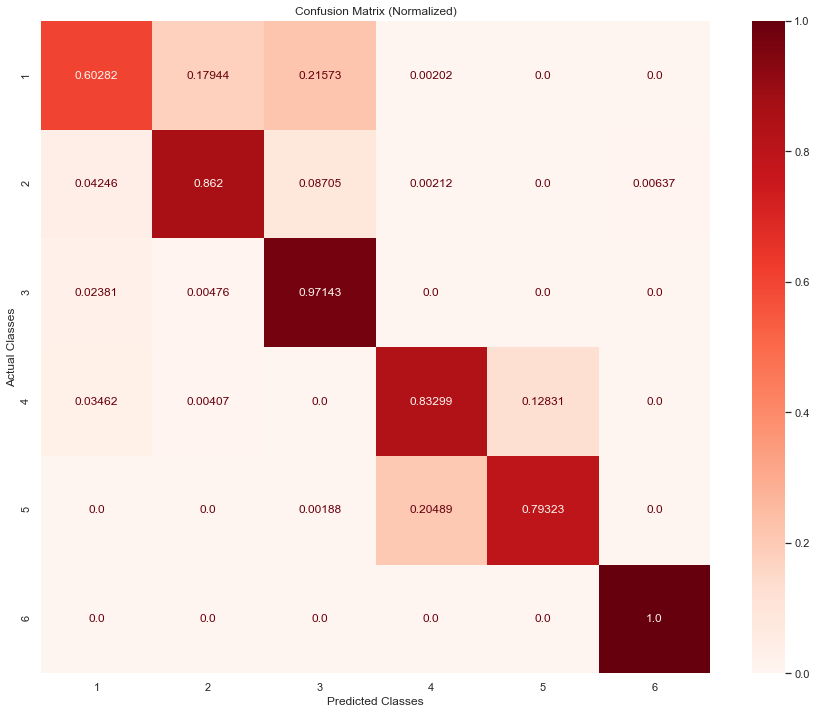

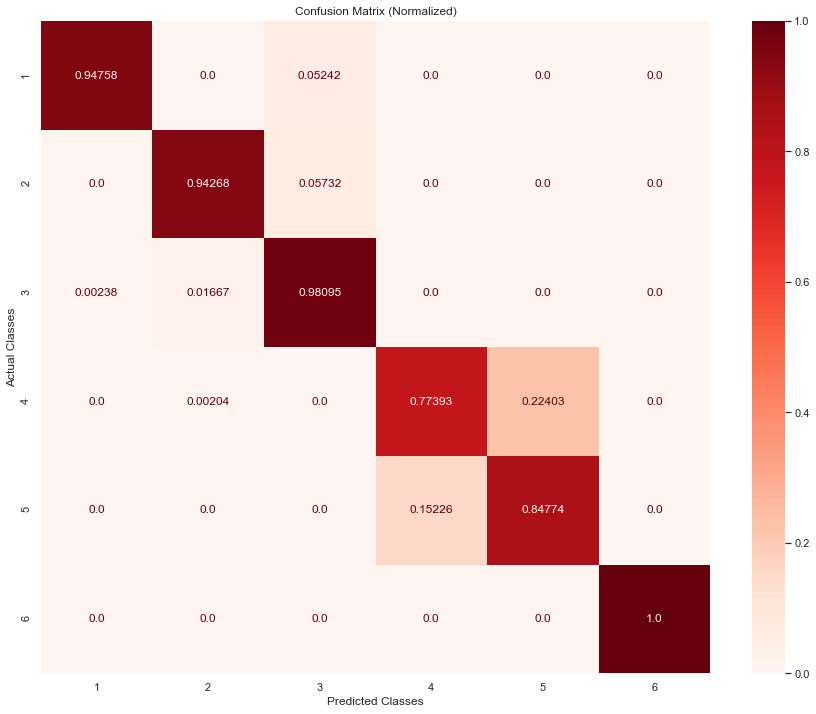

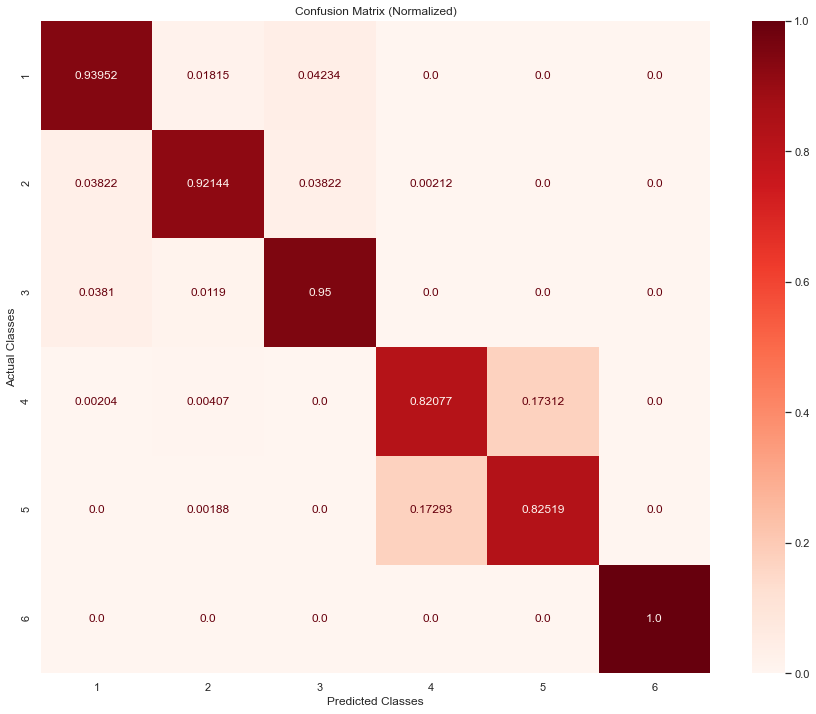

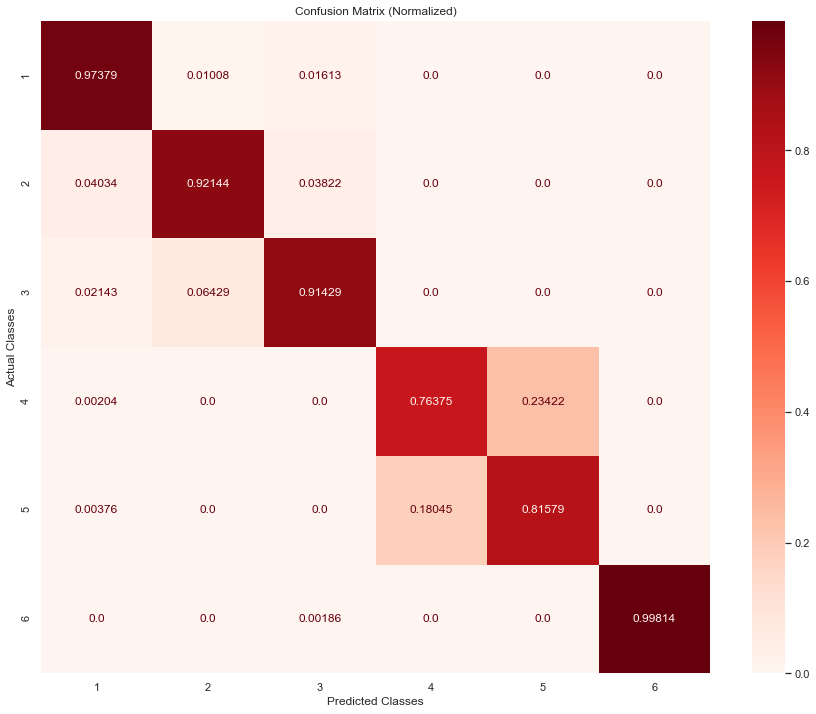

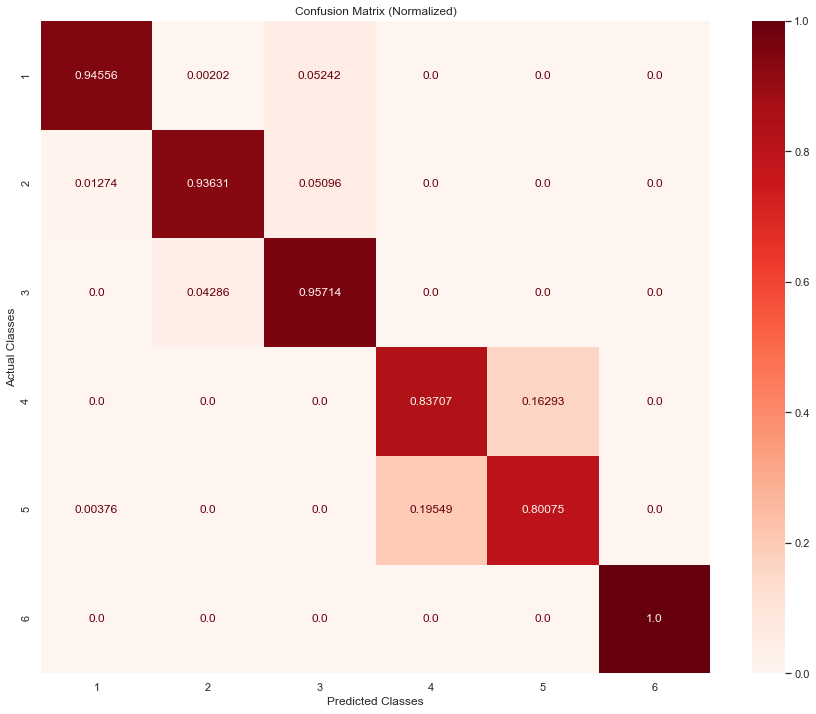

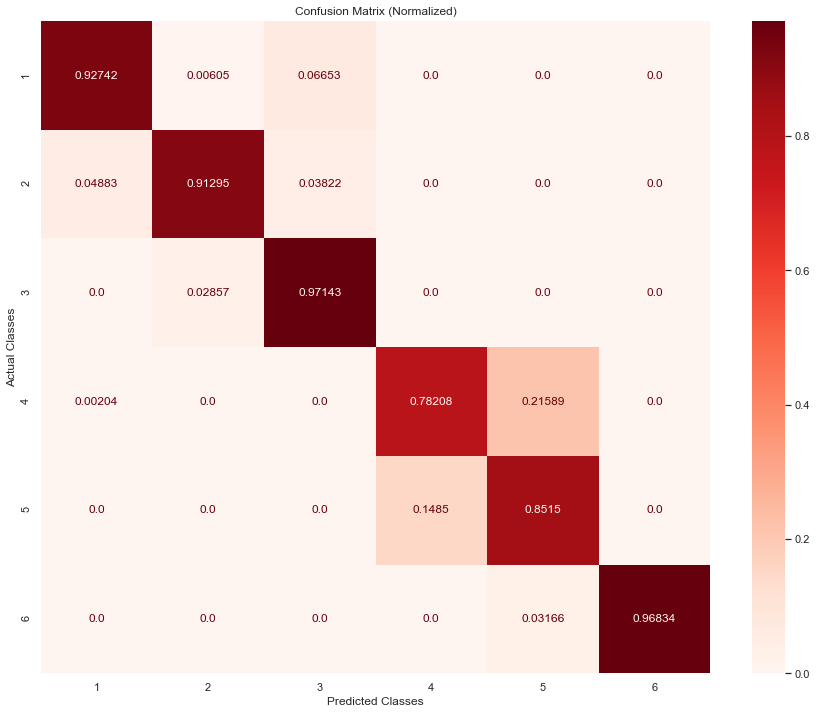

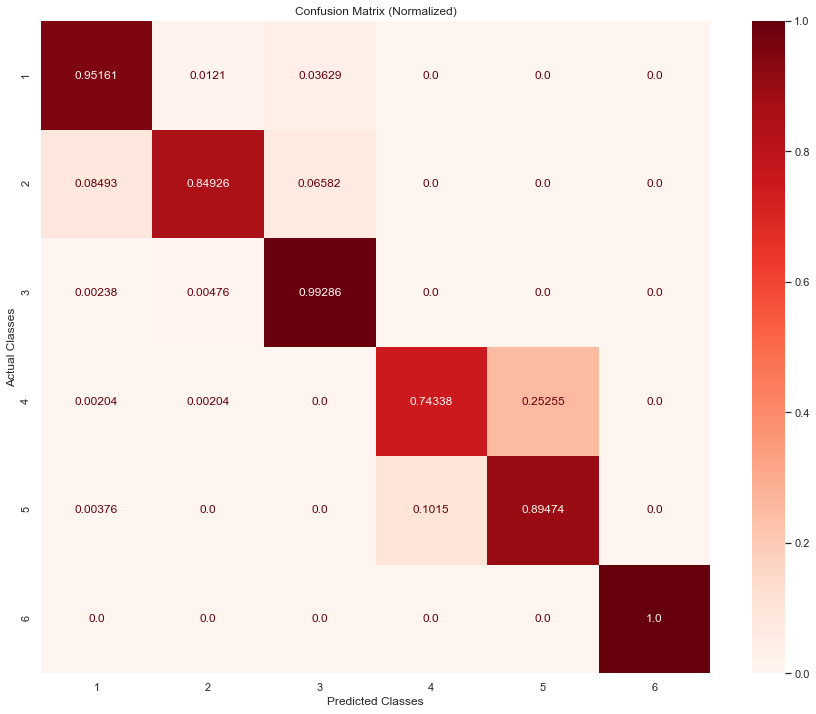

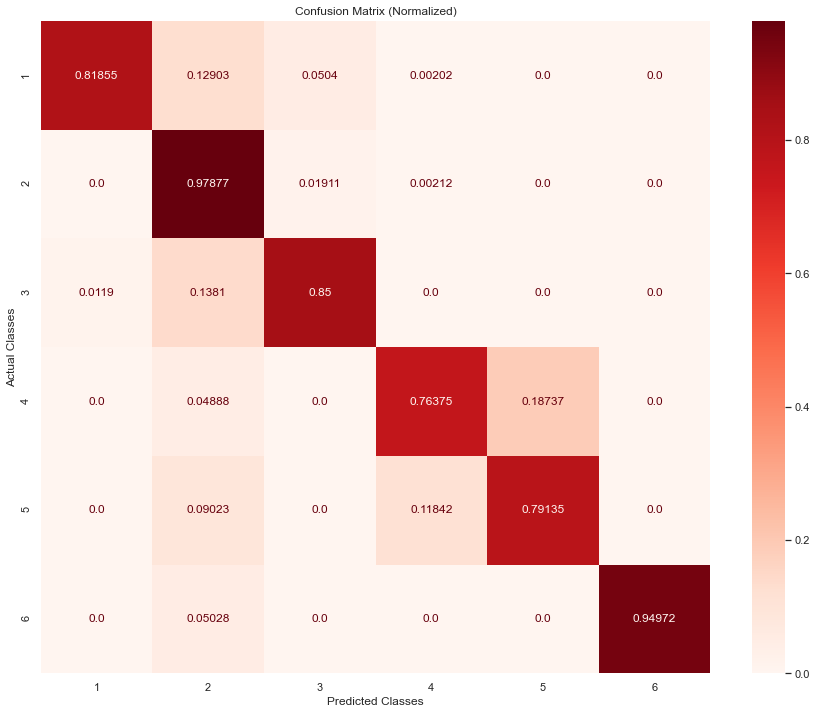

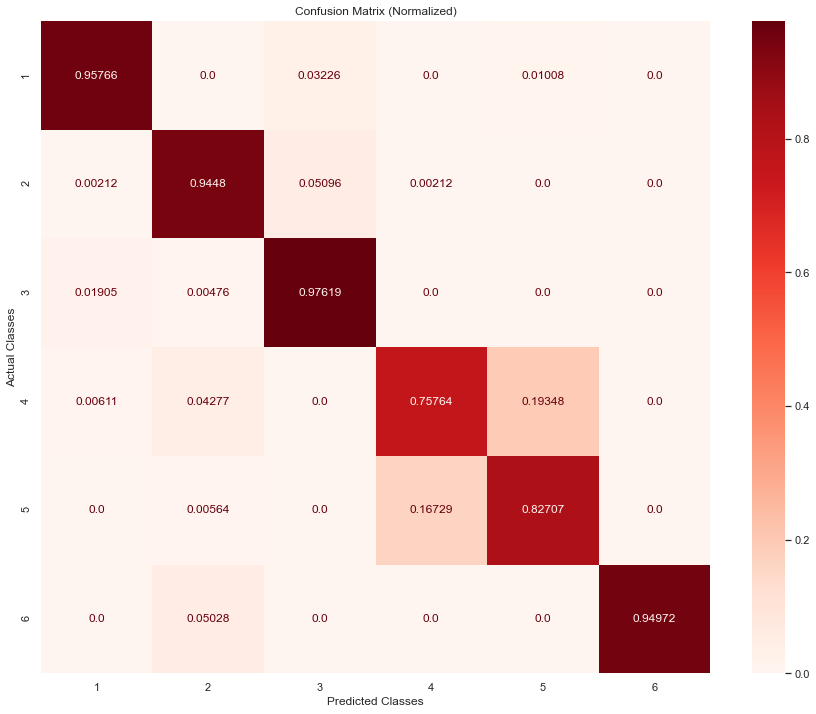

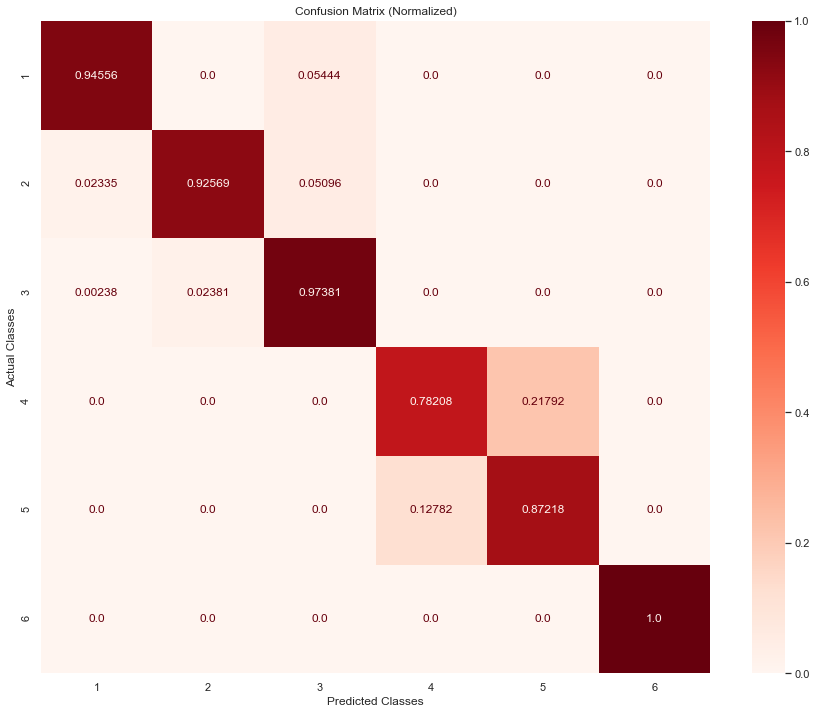

In [81]:
repeat_experiment_dac(model_type="bilstm")

##### After feature reduction

Run:  1
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.3260 - accuracy: 0.8599 - val_loss: 0.4398 - val_accuracy: 0.7645
Epoch 2/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0551 - accuracy: 0.9825 - val_loss: 0.0883 - val_accuracy: 0.9857
Epoch 3/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0046 - accuracy: 0.9996 - val_loss: 0.1368 - val_accuracy: 0.9844
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0278 - accuracy: 0.9928 - val_loss: 0.2929 - val_accuracy: 0.9199
Epoch 5/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0207 - accuracy: 0.9943 - val_loss: 0.0031 - val_accuracy: 

201/201 [==============================] - 2s 8ms/step - loss: 0.0367 - accuracy: 0.9906 - val_loss: 0.9466 - val_accuracy: 0.9217
Epoch 41/5000
201/201 [==============================] - 2s 9ms/step - loss: 0.0268 - accuracy: 0.9938 - val_loss: 0.9229 - val_accuracy: 0.9267
Epoch 42/5000
201/201 [==============================] - 2s 8ms/step - loss: 0.0225 - accuracy: 0.9947 - val_loss: 0.8722 - val_accuracy: 0.9361
Epoch 43/5000
201/201 [==============================] - 2s 8ms/step - loss: 0.0183 - accuracy: 0.9956 - val_loss: 0.9180 - val_accuracy: 0.9397
Epoch 44/5000
201/201 [==============================] - 2s 9ms/step - loss: 0.0105 - accuracy: 0.9969 - val_loss: 1.0500 - val_accuracy: 0.9260
Epoch 45/5000
201/201 [==============================] - 2s 9ms/step - loss: 0.0076 - accuracy: 0.9981 - val_loss: 1.0418 - val_accuracy: 0.9239
Epoch 46/5000
201/201 [==============================] - 2s 9ms/step - loss: 0.1497 - accuracy: 0.9635 - val_loss: 0.9580 - val_accuracy: 0.8017


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  2
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.1662 - accuracy: 0.9219 - val_loss: 0.0086 - val_accuracy: 0.9983
Epoch 2/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0054 - accuracy: 0.9995 - val_loss: 0.0122 - val_accuracy: 0.9980
Epoch 3/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0030 - accuracy: 0.9997 - val_loss: 0.0120 - val_accuracy: 0.9986
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 0.0076 - val_accuracy: 0.9986
Epoch 5/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0067 - accuracy: 0.9995 - val_loss: 0.1110 - val_accuracy: 

206/206 [==============================] - 2s 8ms/step - loss: 0.0053 - accuracy: 0.9994 - val_loss: 0.3506 - val_accuracy: 0.9575
Epoch 40/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.0048 - accuracy: 0.9994 - val_loss: 0.3658 - val_accuracy: 0.9589
Epoch 41/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.3834 - val_accuracy: 0.9589
Epoch 42/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0044 - accuracy: 0.9994 - val_loss: 0.3789 - val_accuracy: 0.9603
Epoch 43/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.3712 - val_accuracy: 0.9539
Epoch 44/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.3765 - val_accuracy: 0.9539
Epoch 45/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.3802 - val_accuracy: 0.9560


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  3
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.3307 - accuracy: 0.8509 - val_loss: 0.0673 - val_accuracy: 0.9905
Epoch 2/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0370 - accuracy: 0.9931 - val_loss: 0.0782 - val_accuracy: 0.9857
Epoch 3/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0117 - accuracy: 0.9977 - val_loss: 0.0416 - val_accuracy: 0.9949
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0140 - accuracy: 0.9977 - val_loss: 0.1692 - val_accuracy: 0.9746
Epoch 5/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0062 - accuracy: 0.9993 - val_loss: 0.0817 - val_accuracy: 

181/181 [==============================] - 2s 9ms/step - loss: 0.0732 - accuracy: 0.9865 - val_loss: 0.8552 - val_accuracy: 0.9204
Epoch 46/5000
181/181 [==============================] - 2s 9ms/step - loss: 0.0236 - accuracy: 0.9938 - val_loss: 0.6997 - val_accuracy: 0.9378
Epoch 47/5000
181/181 [==============================] - 2s 8ms/step - loss: 0.0214 - accuracy: 0.9955 - val_loss: 0.7665 - val_accuracy: 0.9403
Epoch 48/5000
181/181 [==============================] - 2s 8ms/step - loss: 0.0418 - accuracy: 0.9896 - val_loss: 0.7077 - val_accuracy: 0.9237
Epoch 49/5000
181/181 [==============================] - 1s 8ms/step - loss: 0.0104 - accuracy: 0.9958 - val_loss: 0.8125 - val_accuracy: 0.9229
Epoch 50/5000
181/181 [==============================] - 2s 8ms/step - loss: 0.0405 - accuracy: 0.9924 - val_loss: 0.5959 - val_accuracy: 0.9262
Epoch 51/5000
181/181 [==============================] - 2s 9ms/step - loss: 0.0196 - accuracy: 0.9948 - val_loss: 0.7729 - val_accuracy: 0.9362


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  4
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.1608 - accuracy: 0.9259 - val_loss: 0.0152 - val_accuracy: 0.9976
Epoch 2/10
460/460 [==============================] - 4s 8ms/step - loss: 0.2369 - accuracy: 0.8787 - val_loss: 0.5323 - val_accuracy: 0.6905
Epoch 3/10
460/460 [==============================] - 4s 8ms/step - loss: 0.5100 - accuracy: 0.7176 - val_loss: 0.6779 - val_accuracy: 0.6454
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.3866 - accuracy: 0.8171 - val_loss: 0.1550 - val_accuracy: 0.9620
Epoch 5/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0433 - accuracy: 0.9905 - val_loss: 0.0485 - val_accuracy: 

206/206 [==============================] - 2s 9ms/step - loss: 0.0206 - accuracy: 0.9954 - val_loss: 0.4266 - val_accuracy: 0.9221
Epoch 40/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.0126 - accuracy: 0.9963 - val_loss: 0.3751 - val_accuracy: 0.9423
Epoch 41/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.4260 - val_accuracy: 0.9408
Epoch 42/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0080 - accuracy: 0.9979 - val_loss: 0.4003 - val_accuracy: 0.9459
Epoch 43/5000
206/206 [==============================] - 2s 9ms/step - loss: 6.8074e-04 - accuracy: 1.0000 - val_loss: 0.4397 - val_accuracy: 0.9481
Epoch 44/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0478 - accuracy: 0.9839 - val_loss: 0.4208 - val_accuracy: 0.9444
Epoch 45/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.1144 - accuracy: 0.9616 - val_loss: 0.3454 - val_accuracy: 0.


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  5
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.1675 - accuracy: 0.9268 - val_loss: 0.0216 - val_accuracy: 0.9966
Epoch 2/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0694 - accuracy: 0.9782 - val_loss: 0.0085 - val_accuracy: 0.9990
Epoch 3/10
460/460 [==============================] - 4s 9ms/step - loss: 0.1128 - accuracy: 0.9635 - val_loss: 0.6981 - val_accuracy: 0.5294
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.4721 - accuracy: 0.7390 - val_loss: 0.1252 - val_accuracy: 0.9603
Epoch 5/10
460/460 [==============================] - 4s 9ms/step - loss: 0.1098 - accuracy: 0.9600 - val_loss: 0.0038 - val_accuracy: 

206/206 [==============================] - 2s 8ms/step - loss: 0.0278 - accuracy: 0.9909 - val_loss: 0.2938 - val_accuracy: 0.9394
Epoch 42/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0570 - accuracy: 0.9820 - val_loss: 0.9171 - val_accuracy: 0.8038
Epoch 43/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.1018 - accuracy: 0.9619 - val_loss: 0.1835 - val_accuracy: 0.9322
Epoch 44/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.0288 - accuracy: 0.9909 - val_loss: 0.2932 - val_accuracy: 0.9300
Epoch 45/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.0324 - accuracy: 0.9912 - val_loss: 0.3311 - val_accuracy: 0.9329
Epoch 46/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.0261 - accuracy: 0.9915 - val_loss: 0.2903 - val_accuracy: 0.9307
Epoch 47/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.1089 - accuracy: 0.9625 - val_loss: 0.4113 - val_accuracy: 0.9076


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  6
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.2608 - accuracy: 0.8847 - val_loss: 0.6979 - val_accuracy: 0.4988
Epoch 2/10
460/460 [==============================] - 4s 8ms/step - loss: 0.4869 - accuracy: 0.7399 - val_loss: 0.3731 - val_accuracy: 0.8381
Epoch 3/10
460/460 [==============================] - 4s 9ms/step - loss: 0.1302 - accuracy: 0.9603 - val_loss: 0.0817 - val_accuracy: 0.9847
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0104 - accuracy: 0.9985 - val_loss: 0.0092 - val_accuracy: 0.9986
Epoch 5/10
460/460 [==============================] - 4s 9ms/step - loss: 0.3021 - accuracy: 0.8683 - val_loss: 0.2319 - val_accuracy: 

208/208 [==============================] - 2s 9ms/step - loss: 0.0051 - accuracy: 0.9976 - val_loss: 0.4424 - val_accuracy: 0.9462
Epoch 41/5000
208/208 [==============================] - 2s 8ms/step - loss: 0.0051 - accuracy: 0.9973 - val_loss: 0.4663 - val_accuracy: 0.9469
Epoch 42/5000
208/208 [==============================] - 2s 9ms/step - loss: 0.0046 - accuracy: 0.9982 - val_loss: 0.4912 - val_accuracy: 0.9462
Epoch 43/5000
208/208 [==============================] - 2s 9ms/step - loss: 0.0040 - accuracy: 0.9982 - val_loss: 0.5146 - val_accuracy: 0.9454
Epoch 44/5000
208/208 [==============================] - 2s 9ms/step - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0.5298 - val_accuracy: 0.9462
Epoch 45/5000
208/208 [==============================] - 2s 9ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.5704 - val_accuracy: 0.9433
Epoch 46/5000
208/208 [==============================] - 2s 9ms/step - loss: 0.0094 - accuracy: 0.9982 - val_loss: 0.5534 - val_accuracy: 0.9383


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  7
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.1933 - accuracy: 0.9135 - val_loss: 0.0149 - val_accuracy: 0.9976
Epoch 2/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0204 - accuracy: 0.9965 - val_loss: 0.1228 - val_accuracy: 0.9905
Epoch 3/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0312 - accuracy: 0.9931 - val_loss: 0.0044 - val_accuracy: 0.9997
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0078 - accuracy: 0.9989 - val_loss: 0.0036 - val_accuracy: 0.9997
Epoch 5/10
460/460 [==============================] - 4s 9ms/step - loss: 0.3565 - accuracy: 0.8572 - val_loss: 0.2496 - val_accuracy: 

200/200 [==============================] - 2s 9ms/step - loss: 0.0219 - accuracy: 0.9934 - val_loss: 0.7151 - val_accuracy: 0.8846
Epoch 42/5000
200/200 [==============================] - 2s 9ms/step - loss: 0.0163 - accuracy: 0.9925 - val_loss: 0.8955 - val_accuracy: 0.9083
Epoch 43/5000
200/200 [==============================] - 2s 9ms/step - loss: 0.0154 - accuracy: 0.9947 - val_loss: 0.9131 - val_accuracy: 0.9120
Epoch 44/5000
200/200 [==============================] - 2s 9ms/step - loss: 0.1668 - accuracy: 0.9568 - val_loss: 0.6385 - val_accuracy: 0.8979
Epoch 45/5000
200/200 [==============================] - 2s 9ms/step - loss: 0.0538 - accuracy: 0.9840 - val_loss: 0.8686 - val_accuracy: 0.9164
Epoch 46/5000
200/200 [==============================] - 2s 9ms/step - loss: 0.0390 - accuracy: 0.9878 - val_loss: 0.6675 - val_accuracy: 0.9268
Epoch 47/5000
200/200 [==============================] - 2s 9ms/step - loss: 0.0217 - accuracy: 0.9909 - val_loss: 0.8124 - val_accuracy: 0.9246


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  8
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.2224 - accuracy: 0.8969 - val_loss: 0.0157 - val_accuracy: 0.9963
Epoch 2/10
460/460 [==============================] - 4s 8ms/step - loss: 0.2806 - accuracy: 0.8919 - val_loss: 0.4103 - val_accuracy: 0.8049
Epoch 3/10
460/460 [==============================] - 4s 8ms/step - loss: 0.2908 - accuracy: 0.8683 - val_loss: 0.1793 - val_accuracy: 0.9555
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0697 - accuracy: 0.9861 - val_loss: 0.1609 - val_accuracy: 0.9617
Epoch 5/10
460/460 [==============================] - 4s 8ms/step - loss: 0.3221 - accuracy: 0.8419 - val_loss: 0.3109 - val_accuracy: 

202/202 [==============================] - 2s 9ms/step - loss: 0.0422 - accuracy: 0.9891 - val_loss: 0.5140 - val_accuracy: 0.9220
Epoch 43/5000
202/202 [==============================] - 2s 9ms/step - loss: 0.0123 - accuracy: 0.9972 - val_loss: 0.5905 - val_accuracy: 0.9235
Epoch 44/5000
202/202 [==============================] - 2s 8ms/step - loss: 0.0108 - accuracy: 0.9978 - val_loss: 0.5454 - val_accuracy: 0.9272
Epoch 45/5000
202/202 [==============================] - 2s 8ms/step - loss: 0.0175 - accuracy: 0.9935 - val_loss: 0.6301 - val_accuracy: 0.9316
Epoch 46/5000
202/202 [==============================] - 2s 8ms/step - loss: 0.0164 - accuracy: 0.9960 - val_loss: 0.6035 - val_accuracy: 0.9205
Epoch 47/5000
202/202 [==============================] - 2s 8ms/step - loss: 0.0536 - accuracy: 0.9888 - val_loss: 0.5698 - val_accuracy: 0.9220
Epoch 48/5000
202/202 [==============================] - 2s 8ms/step - loss: 0.1649 - accuracy: 0.9550 - val_loss: 0.2883 - val_accuracy: 0.9324


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  9
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.1753 - accuracy: 0.9151 - val_loss: 0.0074 - val_accuracy: 0.9983
Epoch 2/10
460/460 [==============================] - 4s 9ms/step - loss: 0.2618 - accuracy: 0.8800 - val_loss: 0.1648 - val_accuracy: 0.9773
Epoch 3/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0432 - accuracy: 0.9906 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0413 - accuracy: 0.9891 - val_loss: 0.0049 - val_accuracy: 0.9993
Epoch 5/10
460/460 [==============================] - 4s 8ms/step - loss: 0.0053 - accuracy: 0.9992 - val_loss: 4.8715e-04 - val_accura

206/206 [==============================] - 2s 9ms/step - loss: 0.2382 - accuracy: 0.9138 - val_loss: 0.4098 - val_accuracy: 0.9164
Epoch 42/5000
206/206 [==============================] - 2s 9ms/step - loss: 0.2863 - accuracy: 0.9023 - val_loss: 0.4260 - val_accuracy: 0.8810
Epoch 43/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.2854 - accuracy: 0.9102 - val_loss: 0.4924 - val_accuracy: 0.8933
Epoch 44/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.4369 - accuracy: 0.8228 - val_loss: 0.4842 - val_accuracy: 0.8976
Epoch 45/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.1299 - accuracy: 0.9629 - val_loss: 0.4580 - val_accuracy: 0.8911
Epoch 46/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.0990 - accuracy: 0.9741 - val_loss: 0.3078 - val_accuracy: 0.9149
Epoch 47/5000
206/206 [==============================] - 2s 8ms/step - loss: 0.1417 - accuracy: 0.9592 - val_loss: 0.3351 - val_accuracy: 0.9084


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  10
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
LSTM
Epoch 1/10
460/460 [==============================] - 5s 9ms/step - loss: 0.4640 - accuracy: 0.7680 - val_loss: 0.6157 - val_accuracy: 0.6203
Epoch 2/10
460/460 [==============================] - 4s 8ms/step - loss: 0.4394 - accuracy: 0.7707 - val_loss: 0.3849 - val_accuracy: 0.8140
Epoch 3/10
460/460 [==============================] - 4s 8ms/step - loss: 0.3192 - accuracy: 0.8493 - val_loss: 0.1279 - val_accuracy: 0.9766
Epoch 4/10
460/460 [==============================] - 4s 9ms/step - loss: 0.0540 - accuracy: 0.9884 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 4s 8ms/step - loss: 0.1426 - accuracy: 0.9553 - val_loss: 0.4980 - val_accuracy:

104/104 [==============================] - 1s 9ms/step - loss: 7.7204e-05 - accuracy: 1.0000 - val_loss: 0.0327 - val_accuracy: 0.9966
Epoch 103/5000
104/104 [==============================] - 1s 8ms/step - loss: 4.9771e-05 - accuracy: 1.0000 - val_loss: 0.0332 - val_accuracy: 0.9966
Epoch 104/5000
104/104 [==============================] - 1s 9ms/step - loss: 4.9286e-05 - accuracy: 1.0000 - val_loss: 0.0340 - val_accuracy: 0.9966
Epoch 105/5000
104/104 [==============================] - 1s 9ms/step - loss: 3.1945e-05 - accuracy: 1.0000 - val_loss: 0.0346 - val_accuracy: 0.9966
Epoch 106/5000
104/104 [==============================] - 1s 9ms/step - loss: 2.4476e-05 - accuracy: 1.0000 - val_loss: 0.0351 - val_accuracy: 0.9966
Epoch 107/5000
104/104 [==============================] - 1s 8ms/step - loss: 1.6103e-04 - accuracy: 1.0000 - val_loss: 0.0369 - val_accuracy: 0.9966
Epoch 108/5000
104/104 [==============================] - 1s 9ms/step - loss: 1.1519e-05 - accuracy: 1.0000 - val_l


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


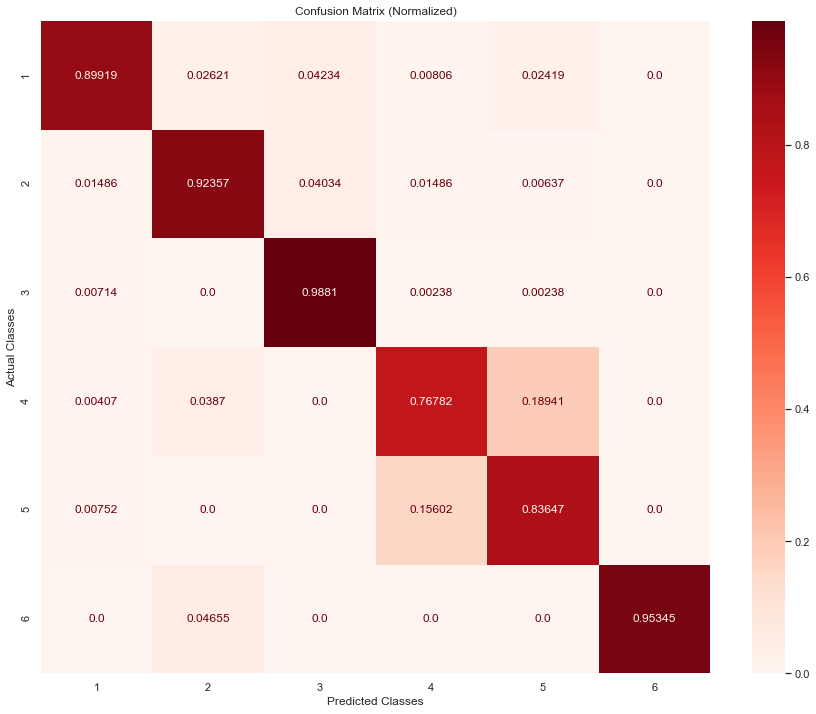

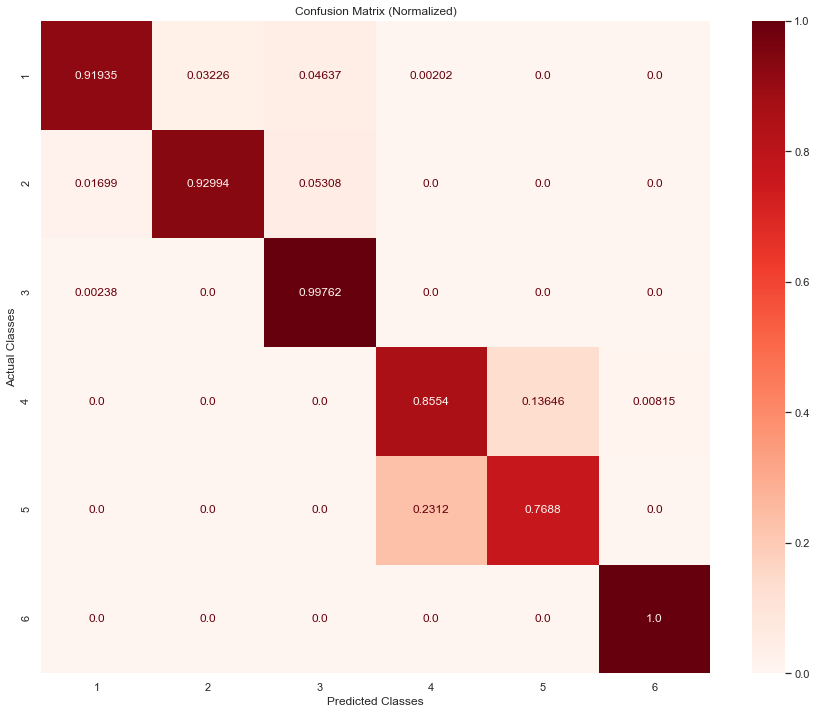

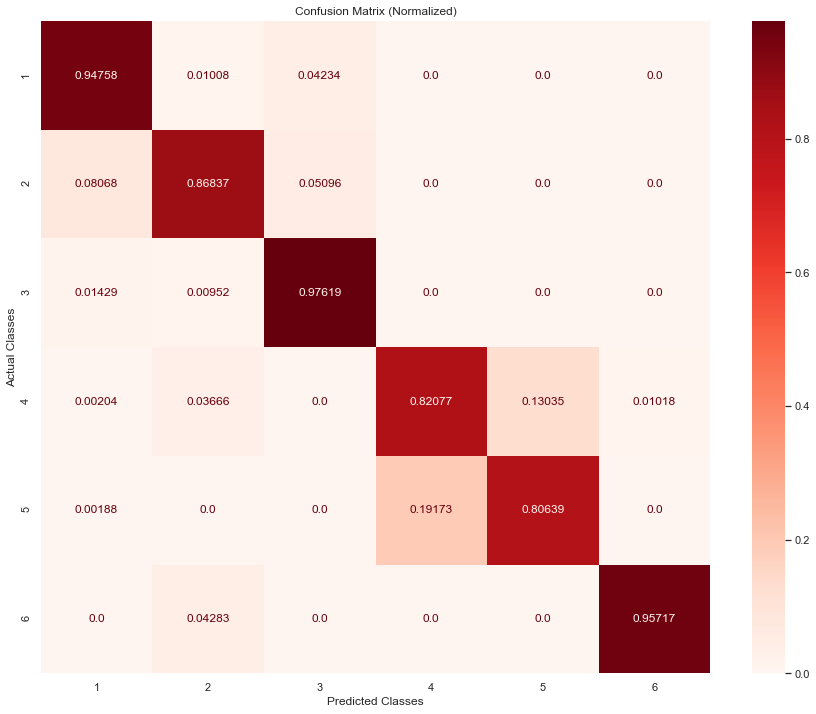

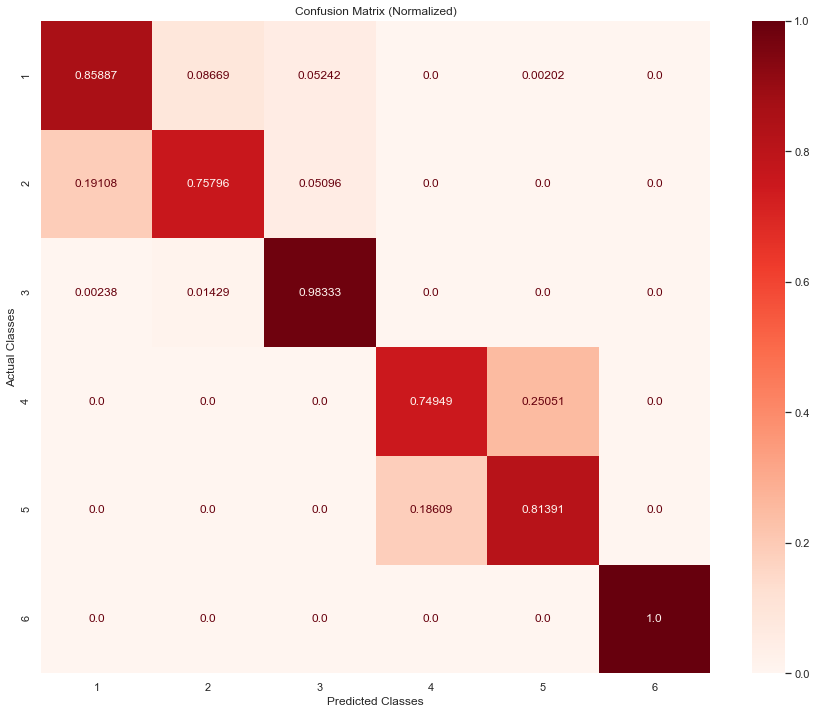

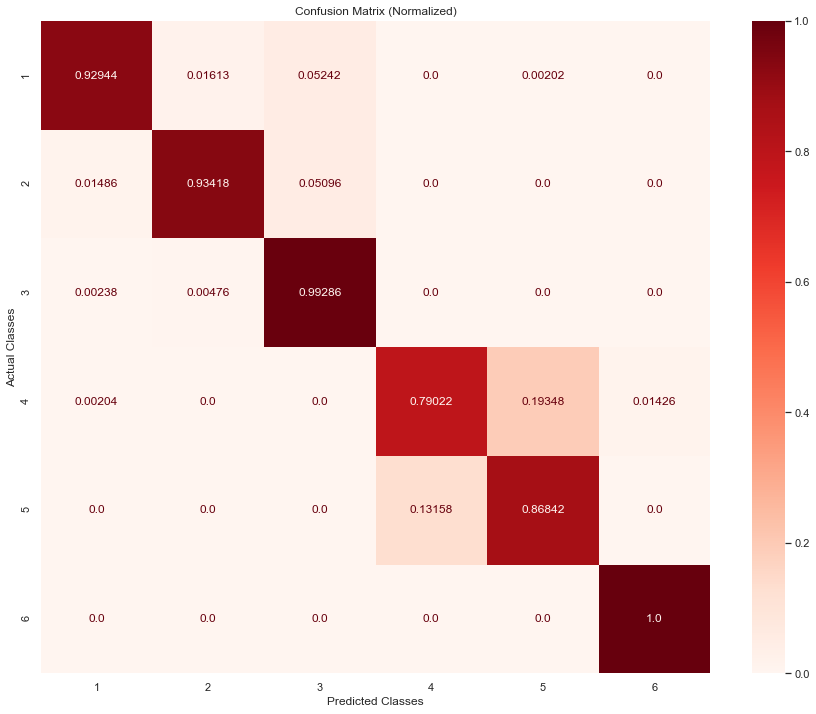

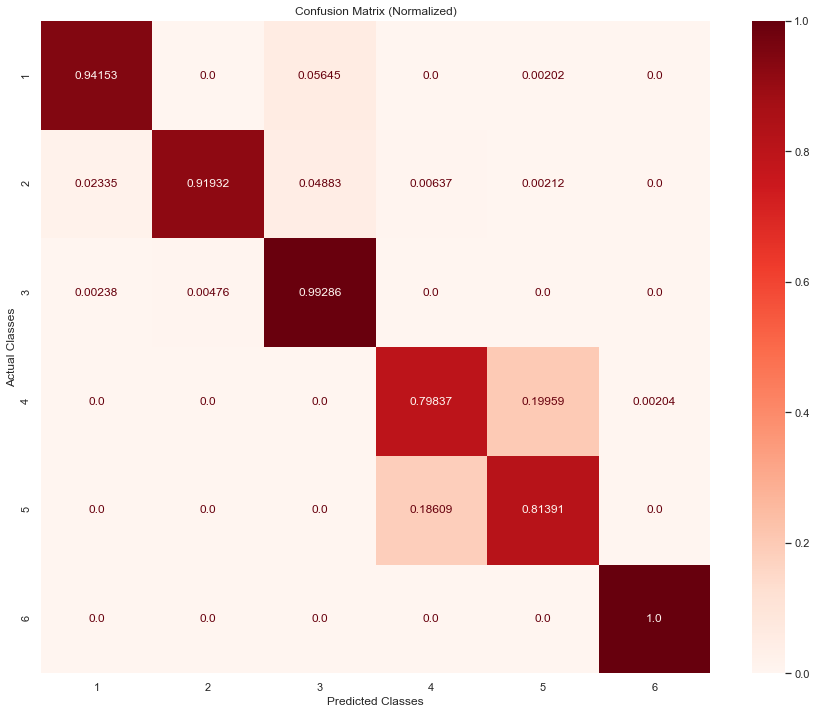

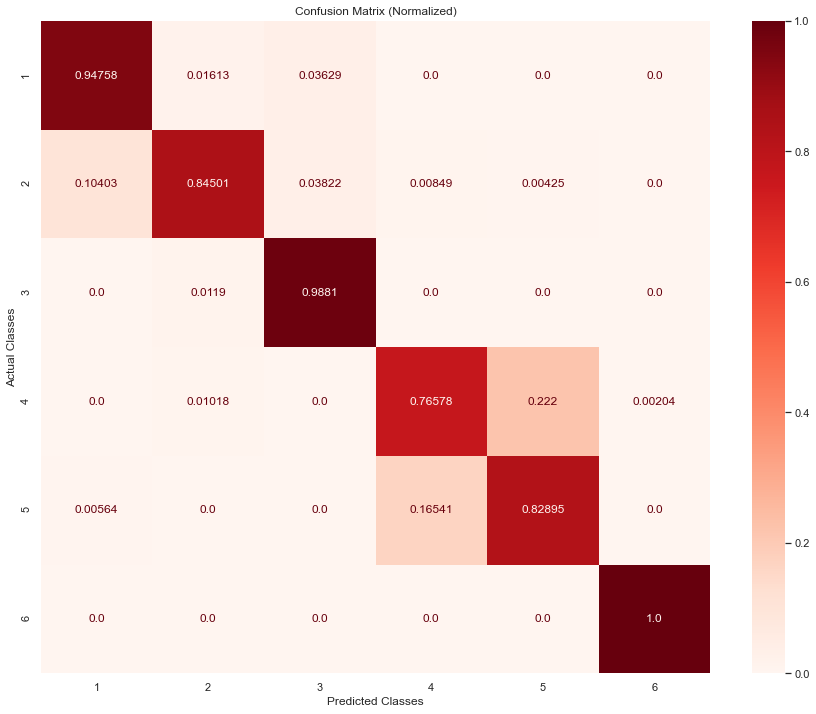

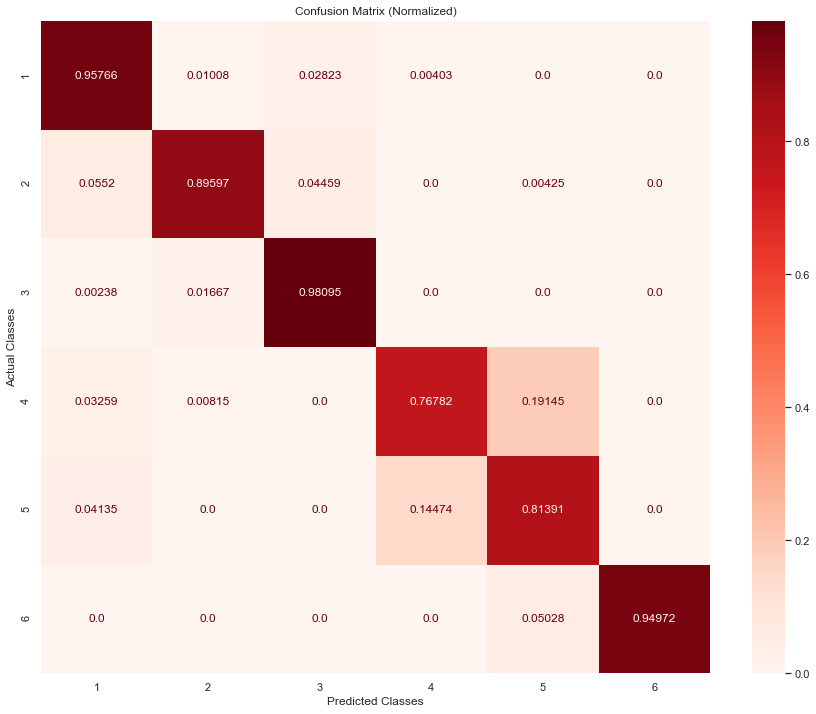

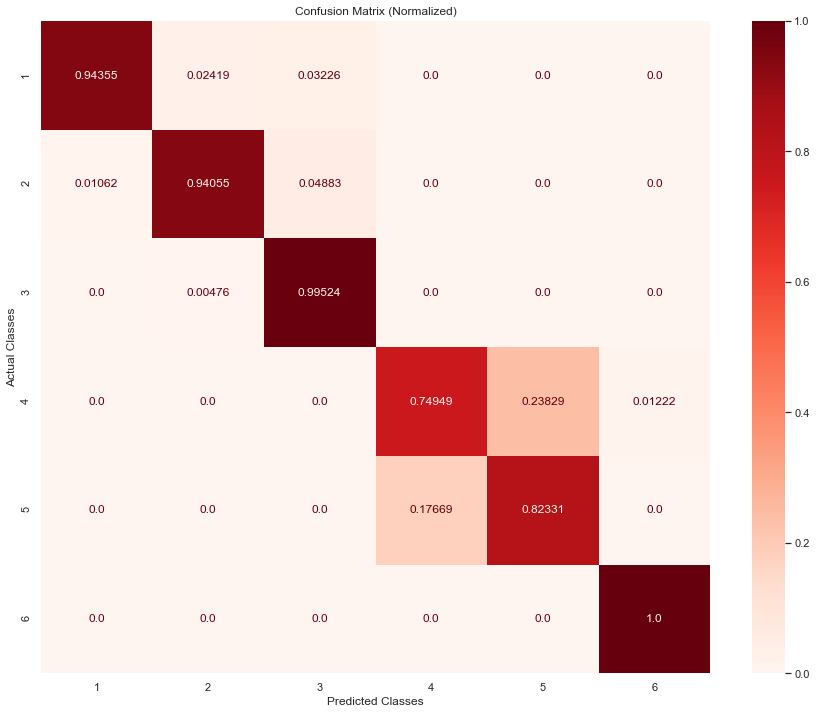

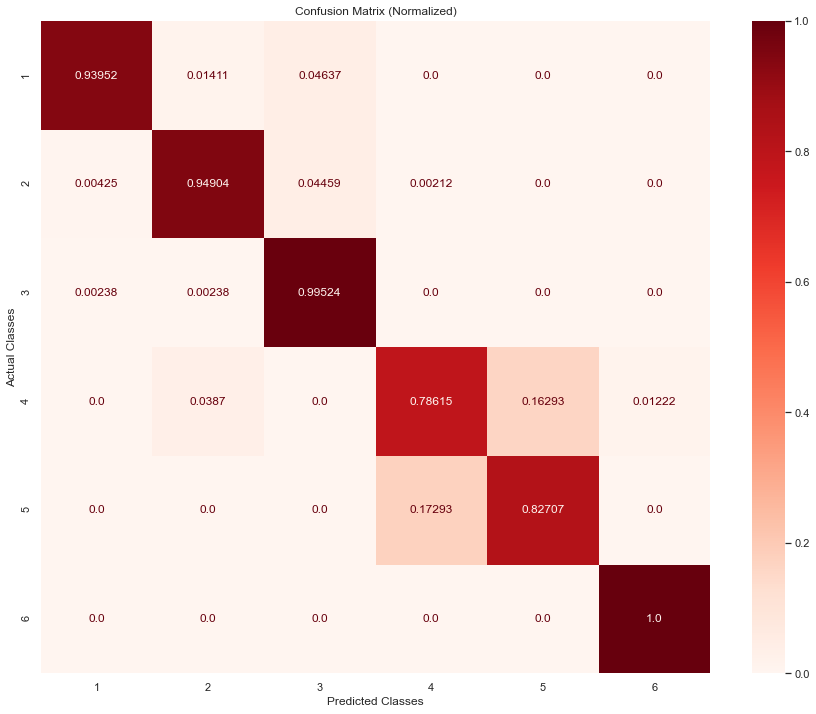

In [82]:
repeat_experiment_dac(model_type="lstm", data = "reduced")

Run:  1
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0301 - accuracy: 0.9849 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 2/10
460/460 [==============================] - 2s 4ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 4.4053e-05 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 2.2461e-05 - accuracy: 1.0000 - val_loss: 2.8526e-05 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 5.4202e-06 - accuracy: 1.0000 - val_loss: 2.5862e-05 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 2s 4ms/step - loss: 6.3794e-06 - accuracy: 1.0000 - val_l

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0843 - accuracy: 0.9602 - val_loss: 1.0712 - val_accuracy: 0.8506
Epoch 46/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0778 - accuracy: 0.9612 - val_loss: 1.1055 - val_accuracy: 0.8500
Epoch 47/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0777 - accuracy: 0.9626 - val_loss: 1.1749 - val_accuracy: 0.8436
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0784 - accuracy: 0.9589 - val_loss: 1.0124 - val_accuracy: 0.8340
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0838 - accuracy: 0.9602 - val_loss: 1.0875 - val_accuracy: 0.8321
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0808 - accuracy: 0.9602 - val_loss: 1.0989 - val_accuracy: 0.8340
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0731 - accuracy: 0.9621 - val_loss: 1.1959 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 9.2645e-05 - accuracy: 1.0000 - val_loss: 0.1301 - val_accuracy: 0.9733
Epoch 42/5000
206/206 [==============================] - 1s 5ms/step - loss: 5.0862e-05 - accuracy: 1.0000 - val_loss: 0.1349 - val_accuracy: 0.9712
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 3.0380e-04 - accuracy: 1.0000 - val_loss: 0.1477 - val_accuracy: 0.9748
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 9.4740e-05 - accuracy: 1.0000 - val_loss: 0.1860 - val_accuracy: 0.9632
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 3.6598e-05 - accuracy: 1.0000 - val_loss: 0.1813 - val_accuracy: 0.9654
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.8314e-05 - accuracy: 1.0000 - val_loss: 0.1681 - val_accuracy: 0.9654
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.8767e-05 - accuracy: 1.0000 - val_loss: 0


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  2
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0264 - accuracy: 0.9902 - val_loss: 0.0011 - val_accuracy: 0.9993
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 8.1305e-05 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 3.5339e-05 - accuracy: 1.0000 - val_loss: 9.1244e-05 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 3.0298e-04 - accuracy: 0.9999 - val_loss: 4.8030e-05 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 2s 5ms/step - loss: 1.2881e-05 - accuracy: 1.0000 - val_l

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0825 - accuracy: 0.9597 - val_loss: 0.7229 - val_accuracy: 0.8423
Epoch 46/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0918 - accuracy: 0.9548 - val_loss: 0.6220 - val_accuracy: 0.8481
Epoch 47/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0839 - accuracy: 0.9594 - val_loss: 0.7014 - val_accuracy: 0.8397
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0827 - accuracy: 0.9589 - val_loss: 0.6953 - val_accuracy: 0.8391
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0799 - accuracy: 0.9587 - val_loss: 0.8649 - val_accuracy: 0.8256
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0809 - accuracy: 0.9636 - val_loss: 0.7340 - val_accuracy: 0.8429
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0829 - accuracy: 0.9604 - val_loss: 0.7286 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 4.2966e-05 - accuracy: 1.0000 - val_loss: 0.1682 - val_accuracy: 0.9690
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.6192e-05 - accuracy: 1.0000 - val_loss: 0.1706 - val_accuracy: 0.9683
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 3.1802e-05 - accuracy: 1.0000 - val_loss: 0.1766 - val_accuracy: 0.9676
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.0035e-05 - accuracy: 1.0000 - val_loss: 0.1758 - val_accuracy: 0.9683
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.6227e-05 - accuracy: 1.0000 - val_loss: 0.1790 - val_accuracy: 0.9683
Epoch 48/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.1080e-05 - accuracy: 1.0000 - val_loss: 0.1833 - val_accuracy: 0.9676
Epoch 49/5000
206/206 [==============================] - 1s 5ms/step - loss: 8.7974e-06 - accuracy: 1.0000 - val_loss: 0


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  3
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 4s 5ms/step - loss: 0.0344 - accuracy: 0.9865 - val_loss: 0.0025 - val_accuracy: 0.9993
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 6.7622e-04 - accuracy: 0.9997 - val_loss: 8.9422e-04 - val_accuracy: 0.9997
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 5.8012e-05 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 0.9990
Epoch 4/10
460/460 [==============================] - 2s 4ms/step - loss: 2.7981e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9993
Epoch 5/10
460/460 [==============================] - 2s 4ms/step - loss: 4.4061e-06 - accuracy: 1.0000 - val_loss:

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0753 - accuracy: 0.9629 - val_loss: 1.1729 - val_accuracy: 0.8465
Epoch 46/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0749 - accuracy: 0.9621 - val_loss: 1.1344 - val_accuracy: 0.8561
Epoch 47/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0719 - accuracy: 0.9661 - val_loss: 1.4326 - val_accuracy: 0.8330
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0951 - accuracy: 0.9589 - val_loss: 1.1883 - val_accuracy: 0.8478
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0665 - accuracy: 0.9656 - val_loss: 1.3891 - val_accuracy: 0.8362
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0678 - accuracy: 0.9656 - val_loss: 1.3407 - val_accuracy: 0.8407
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0642 - accuracy: 0.9658 - val_loss: 1.2318 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 9.9297e-06 - accuracy: 1.0000 - val_loss: 0.4845 - val_accuracy: 0.9554
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.0233e-05 - accuracy: 1.0000 - val_loss: 0.4875 - val_accuracy: 0.9597
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0523 - accuracy: 0.9896 - val_loss: 0.2755 - val_accuracy: 0.9432
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0149 - accuracy: 0.9957 - val_loss: 0.2925 - val_accuracy: 0.9403
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0075 - accuracy: 0.9976 - val_loss: 0.2851 - val_accuracy: 0.9475
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 8.5364e-04 - accuracy: 1.0000 - val_loss: 0.2761 - val_accuracy: 0.9619
Epoch 48/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0032 - accuracy: 0.9979 - val_loss: 0.2941 - val_accu


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  4
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0273 - accuracy: 0.9884 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 1.7515e-04 - accuracy: 1.0000 - val_loss: 2.2392e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 2.5707e-05 - accuracy: 1.0000 - val_loss: 4.3992e-05 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 1.2025e-05 - accuracy: 1.0000 - val_loss: 4.2302e-04 - val_accuracy: 0.9997
Epoch 5/10
460/460 [==============================] - 2s 4ms/step - loss: 6.3648e-06 - accuracy: 1.0000 - v

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0875 - accuracy: 0.9607 - val_loss: 1.2776 - val_accuracy: 0.8417
Epoch 46/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0931 - accuracy: 0.9540 - val_loss: 1.0424 - val_accuracy: 0.8494
Epoch 47/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0969 - accuracy: 0.9570 - val_loss: 1.2159 - val_accuracy: 0.8429
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0825 - accuracy: 0.9616 - val_loss: 1.1410 - val_accuracy: 0.8481
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0769 - accuracy: 0.9614 - val_loss: 1.2148 - val_accuracy: 0.8365
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0836 - accuracy: 0.9643 - val_loss: 1.2030 - val_accuracy: 0.8353
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0837 - accuracy: 0.9597 - val_loss: 1.1464 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 2.6965e-06 - accuracy: 1.0000 - val_loss: 0.4237 - val_accuracy: 0.9531
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0516 - accuracy: 0.9912 - val_loss: 0.3606 - val_accuracy: 0.9092
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0448 - accuracy: 0.9875 - val_loss: 0.1587 - val_accuracy: 0.9625
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0143 - accuracy: 0.9976 - val_loss: 0.2059 - val_accuracy: 0.9531
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 7.8708e-04 - accuracy: 1.0000 - val_loss: 0.2066 - val_accuracy: 0.9575
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 8.2926e-04 - accuracy: 0.9997 - val_loss: 0.2147 - val_accuracy: 0.9603
Epoch 48/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.6843e-04 - accuracy: 1.0000 - val_loss: 0.2064 - val_


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  5
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0328 - accuracy: 0.9859 - val_loss: 7.1029e-04 - val_accuracy: 0.9997
Epoch 2/10
460/460 [==============================] - 2s 4ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 9.3742e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 2s 4ms/step - loss: 2.0019e-04 - accuracy: 1.0000 - val_loss: 3.5703e-04 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 6.0811e-05 - accuracy: 1.0000 - val_loss: 7.9605e-05 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 2s 5ms/step - loss: 1.5385e-05 - accuracy: 1.0000 - v

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0794 - accuracy: 0.9619 - val_loss: 0.6826 - val_accuracy: 0.8679
Epoch 46/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0843 - accuracy: 0.9594 - val_loss: 0.6191 - val_accuracy: 0.8263
Epoch 47/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0884 - accuracy: 0.9639 - val_loss: 0.6612 - val_accuracy: 0.8712
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0777 - accuracy: 0.9646 - val_loss: 0.7234 - val_accuracy: 0.8660
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0764 - accuracy: 0.9636 - val_loss: 0.7440 - val_accuracy: 0.8705
Epoch 50/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0808 - accuracy: 0.9641 - val_loss: 0.7362 - val_accuracy: 0.8660
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0883 - accuracy: 0.9597 - val_loss: 0.5884 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 2.4445e-06 - accuracy: 1.0000 - val_loss: 0.2669 - val_accuracy: 0.9632
Epoch 43/5000
206/206 [==============================] - 1s 4ms/step - loss: 2.8003e-06 - accuracy: 1.0000 - val_loss: 0.2704 - val_accuracy: 0.9640
Epoch 44/5000
206/206 [==============================] - 1s 4ms/step - loss: 4.7781e-06 - accuracy: 1.0000 - val_loss: 0.2621 - val_accuracy: 0.9668
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 3.7236e-06 - accuracy: 1.0000 - val_loss: 0.2737 - val_accuracy: 0.9647
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 5.3258e-06 - accuracy: 1.0000 - val_loss: 0.2851 - val_accuracy: 0.9676
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.7989e-06 - accuracy: 1.0000 - val_loss: 0.2883 - val_accuracy: 0.9661
Epoch 48/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.8461e-06 - accuracy: 1.0000 - val_loss: 0


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  6
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0300 - accuracy: 0.9841 - val_loss: 0.0085 - val_accuracy: 0.9973
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0022 - val_accuracy: 0.9993
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 3.2637e-05 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 0.9990
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 1.3659e-05 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 0.9990
Epoch 5/10
460/460 [==============================] - 2s 5ms/step - loss: 7.4839e-06 - accuracy: 1.0000 - val_loss: 0.0032 

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0972 - accuracy: 0.9556 - val_loss: 0.6322 - val_accuracy: 0.8588
Epoch 46/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.1180 - accuracy: 0.9485 - val_loss: 0.4851 - val_accuracy: 0.8745
Epoch 47/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0858 - accuracy: 0.9519 - val_loss: 0.7987 - val_accuracy: 0.8425
Epoch 48/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0841 - accuracy: 0.9588 - val_loss: 0.6595 - val_accuracy: 0.8366
Epoch 49/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0947 - accuracy: 0.9502 - val_loss: 0.5001 - val_accuracy: 0.8824
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.1018 - accuracy: 0.9529 - val_loss: 0.4265 - val_accuracy: 0.8379
Epoch 51/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0802 - accuracy: 0.9607 - val_loss: 0.6513 - val_ac

205/205 [==============================] - 1s 5ms/step - loss: 1.3981e-04 - accuracy: 1.0000 - val_loss: 0.9489 - val_accuracy: 0.9457
Epoch 43/5000
205/205 [==============================] - 1s 5ms/step - loss: 2.8587e-04 - accuracy: 1.0000 - val_loss: 0.9391 - val_accuracy: 0.9442
Epoch 44/5000
205/205 [==============================] - 1s 5ms/step - loss: 1.2737e-04 - accuracy: 1.0000 - val_loss: 1.0326 - val_accuracy: 0.9457
Epoch 45/5000
205/205 [==============================] - 1s 5ms/step - loss: 4.4827e-05 - accuracy: 1.0000 - val_loss: 1.0600 - val_accuracy: 0.9457
Epoch 46/5000
205/205 [==============================] - 1s 5ms/step - loss: 5.1637e-05 - accuracy: 1.0000 - val_loss: 1.1377 - val_accuracy: 0.9450
Epoch 47/5000
205/205 [==============================] - 1s 5ms/step - loss: 1.3347e-05 - accuracy: 1.0000 - val_loss: 1.1486 - val_accuracy: 0.9450
Epoch 48/5000
205/205 [==============================] - 1s 5ms/step - loss: 2.3126e-05 - accuracy: 1.0000 - val_loss: 1


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  7
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0413 - accuracy: 0.9818 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 8.6191e-04 - val_accuracy: 0.9997
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 2.1038e-04 - accuracy: 0.9999 - val_loss: 5.9900e-04 - val_accuracy: 0.9997
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 1.2115e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 0.9993
Epoch 5/10
460/460 [==============================] - 2s 4ms/step - loss: 1.2611e-05 - accuracy: 1.0000 - val_loss:

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0805 - accuracy: 0.9599 - val_loss: 1.1420 - val_accuracy: 0.8376
Epoch 46/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0788 - accuracy: 0.9626 - val_loss: 1.0054 - val_accuracy: 0.8588
Epoch 47/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0829 - accuracy: 0.9582 - val_loss: 1.1855 - val_accuracy: 0.8479
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0717 - accuracy: 0.9641 - val_loss: 1.2152 - val_accuracy: 0.8447
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0775 - accuracy: 0.9626 - val_loss: 1.1364 - val_accuracy: 0.8306
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0701 - accuracy: 0.9661 - val_loss: 1.0866 - val_accuracy: 0.8318
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0768 - accuracy: 0.9584 - val_loss: 1.2139 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 1.4661e-05 - accuracy: 1.0000 - val_loss: 0.3420 - val_accuracy: 0.9554
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.6118e-05 - accuracy: 1.0000 - val_loss: 0.3467 - val_accuracy: 0.9561
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.9647e-05 - accuracy: 1.0000 - val_loss: 0.3532 - val_accuracy: 0.9561
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.0598e-05 - accuracy: 1.0000 - val_loss: 0.3548 - val_accuracy: 0.9561
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.0974e-05 - accuracy: 1.0000 - val_loss: 0.3510 - val_accuracy: 0.9575
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.2985e-05 - accuracy: 1.0000 - val_loss: 0.3802 - val_accuracy: 0.9568
Epoch 48/5000
206/206 [==============================] - 1s 4ms/step - loss: 6.3814e-06 - accuracy: 1.0000 - val_loss: 0


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  8
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0316 - accuracy: 0.9865 - val_loss: 0.0363 - val_accuracy: 0.9868
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 3.2438e-04 - accuracy: 0.9999 - val_loss: 0.0084 - val_accuracy: 0.9946
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 0.0026 - accuracy: 0.9990 - val_loss: 1.9736e-04 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 2s 4ms/step - loss: 6.8140e-05 - accuracy: 1.0000 - val_loss: 2.0719e-05 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 2s 5ms/step - loss: 2.4270e-05 - accuracy: 1.0000 - val_loss:

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0903 - accuracy: 0.9550 - val_loss: 1.2568 - val_accuracy: 0.8519
Epoch 46/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0848 - accuracy: 0.9624 - val_loss: 1.2592 - val_accuracy: 0.8340
Epoch 47/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0801 - accuracy: 0.9597 - val_loss: 1.2301 - val_accuracy: 0.8308
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0682 - accuracy: 0.9643 - val_loss: 1.4294 - val_accuracy: 0.8321
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0659 - accuracy: 0.9668 - val_loss: 1.3207 - val_accuracy: 0.8263
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0790 - accuracy: 0.9592 - val_loss: 1.2423 - val_accuracy: 0.8449
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0805 - accuracy: 0.9621 - val_loss: 0.8841 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 6.4411e-05 - accuracy: 1.0000 - val_loss: 0.1899 - val_accuracy: 0.9575
Epoch 42/5000
206/206 [==============================] - 1s 5ms/step - loss: 3.0334e-05 - accuracy: 1.0000 - val_loss: 0.1914 - val_accuracy: 0.9575
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.4159e-05 - accuracy: 1.0000 - val_loss: 0.1912 - val_accuracy: 0.9596
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 3.1881e-05 - accuracy: 1.0000 - val_loss: 0.1926 - val_accuracy: 0.9596
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.5596e-05 - accuracy: 1.0000 - val_loss: 0.1956 - val_accuracy: 0.9596
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.3568e-05 - accuracy: 1.0000 - val_loss: 0.2093 - val_accuracy: 0.9596
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.2173e-05 - accuracy: 1.0000 - val_loss: 0

206/206 [==============================] - 1s 5ms/step - loss: 1.4624e-08 - accuracy: 1.0000 - val_loss: 0.3535 - val_accuracy: 0.9647
Epoch 97/5000
206/206 [==============================] - 1s 5ms/step - loss: 3.0700e-08 - accuracy: 1.0000 - val_loss: 0.3646 - val_accuracy: 0.9640
Epoch 98/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.1849 - accuracy: 0.9744 - val_loss: 0.2387 - val_accuracy: 0.9466
Epoch 99/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0113 - accuracy: 0.9979 - val_loss: 0.2225 - val_accuracy: 0.9625
Epoch 100/5000
206/206 [==============================] - 1s 5ms/step - loss: 4.8974e-04 - accuracy: 1.0000 - val_loss: 0.2298 - val_accuracy: 0.9676
Epoch 101/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.4545e-04 - accuracy: 1.0000 - val_loss: 0.2486 - val_accuracy: 0.9632
Epoch 102/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.1244e-04 - accuracy: 1.0000 - val_loss: 0.2539


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  9
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0346 - accuracy: 0.9845 - val_loss: 0.0033 - val_accuracy: 0.9986
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 5.0757e-04 - accuracy: 0.9999 - val_loss: 2.2695e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 7.9452e-04 - accuracy: 0.9996 - val_loss: 4.3498e-05 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 8.3208e-04 - accuracy: 0.9997 - val_loss: 0.0022 - val_accuracy: 0.9983
Epoch 5/10
460/460 [==============================] - 2s 5ms/step - loss: 4.2153e-05 - accuracy: 1.0000 - val_l

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.1044 - accuracy: 0.9491 - val_loss: 0.6079 - val_accuracy: 0.8244
Epoch 46/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0925 - accuracy: 0.9548 - val_loss: 0.6922 - val_accuracy: 0.8513
Epoch 47/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0940 - accuracy: 0.9562 - val_loss: 0.7331 - val_accuracy: 0.8173
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0904 - accuracy: 0.9560 - val_loss: 0.8125 - val_accuracy: 0.8474
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0838 - accuracy: 0.9572 - val_loss: 0.8006 - val_accuracy: 0.8205
Epoch 50/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0856 - accuracy: 0.9548 - val_loss: 0.9090 - val_accuracy: 0.8250
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0950 - accuracy: 0.9533 - val_loss: 0.7837 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 2.0606e-06 - accuracy: 1.0000 - val_loss: 0.4034 - val_accuracy: 0.9553
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 2.1012e-06 - accuracy: 1.0000 - val_loss: 0.4095 - val_accuracy: 0.9553
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0472 - accuracy: 0.9875 - val_loss: 0.2752 - val_accuracy: 0.9531
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 0.3616 - val_accuracy: 0.9495
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 4.2020e-04 - accuracy: 1.0000 - val_loss: 0.3601 - val_accuracy: 0.9481
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.4017e-04 - accuracy: 1.0000 - val_loss: 0.3595 - val_accuracy: 0.9452
Epoch 48/5000
206/206 [==============================] - 1s 5ms/step - loss: 9.4610e-05 - accuracy: 1.0000 - val_loss: 0.3333 - 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  10
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
CNN-LSTM
Epoch 1/10
460/460 [==============================] - 3s 5ms/step - loss: 0.0292 - accuracy: 0.9863 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 2/10
460/460 [==============================] - 2s 5ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 9.6061e-05 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 2s 5ms/step - loss: 1.0591e-04 - accuracy: 1.0000 - val_loss: 2.7491e-04 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 2s 5ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0021 - val_accuracy: 0.9993
Epoch 5/10
460/460 [==============================] - 2s 5ms/step - loss: 3.0681e-04 - accuracy: 1.0000 - val_loss: 2.

Epoch 45/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0861 - accuracy: 0.9592 - val_loss: 0.7565 - val_accuracy: 0.8545
Epoch 46/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0861 - accuracy: 0.9580 - val_loss: 0.8308 - val_accuracy: 0.8391
Epoch 47/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0872 - accuracy: 0.9636 - val_loss: 0.7802 - val_accuracy: 0.8468
Epoch 48/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0955 - accuracy: 0.9567 - val_loss: 0.6200 - val_accuracy: 0.8378
Epoch 49/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0749 - accuracy: 0.9641 - val_loss: 0.8113 - val_accuracy: 0.8494
Epoch 50/5000
255/255 [==============================] - 1s 4ms/step - loss: 0.0731 - accuracy: 0.9639 - val_loss: 0.8676 - val_accuracy: 0.8372
Epoch 51/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.0779 - accuracy: 0.9663 - val_loss: 0.8295 - val_ac

206/206 [==============================] - 1s 5ms/step - loss: 3.5138e-04 - accuracy: 1.0000 - val_loss: 0.3102 - val_accuracy: 0.9466
Epoch 43/5000
206/206 [==============================] - 1s 5ms/step - loss: 4.0012e-04 - accuracy: 1.0000 - val_loss: 0.3622 - val_accuracy: 0.9503
Epoch 44/5000
206/206 [==============================] - 1s 5ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.2688 - val_accuracy: 0.9625
Epoch 45/5000
206/206 [==============================] - 1s 5ms/step - loss: 3.2772e-04 - accuracy: 1.0000 - val_loss: 0.2745 - val_accuracy: 0.9625
Epoch 46/5000
206/206 [==============================] - 1s 5ms/step - loss: 1.2730e-04 - accuracy: 1.0000 - val_loss: 0.3172 - val_accuracy: 0.9611
Epoch 47/5000
206/206 [==============================] - 1s 5ms/step - loss: 6.7094e-05 - accuracy: 1.0000 - val_loss: 0.3137 - val_accuracy: 0.9632
Epoch 48/5000
206/206 [==============================] - 1s 5ms/step - loss: 5.6378e-05 - accuracy: 1.0000 - val_loss: 0.334


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


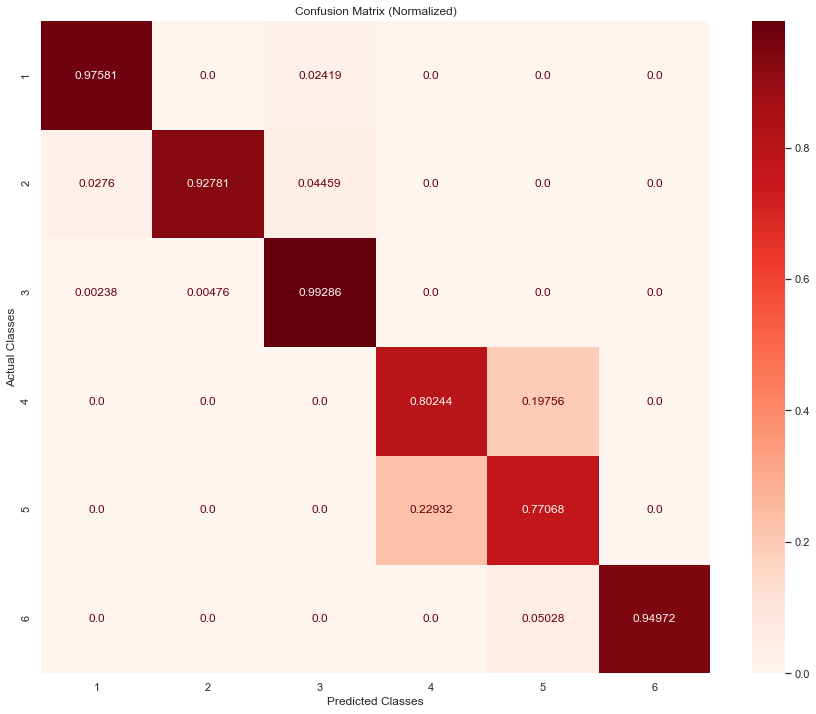

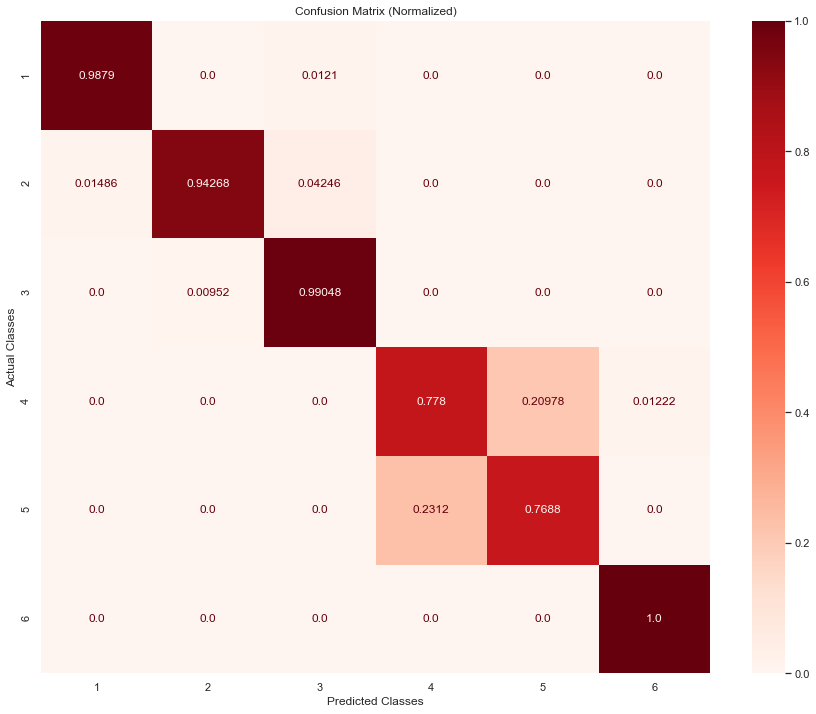

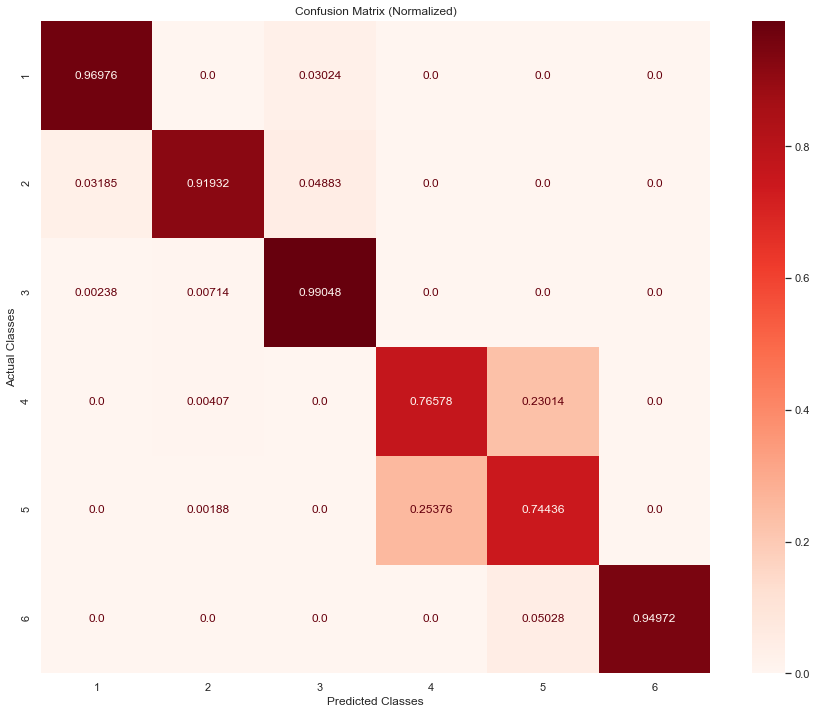

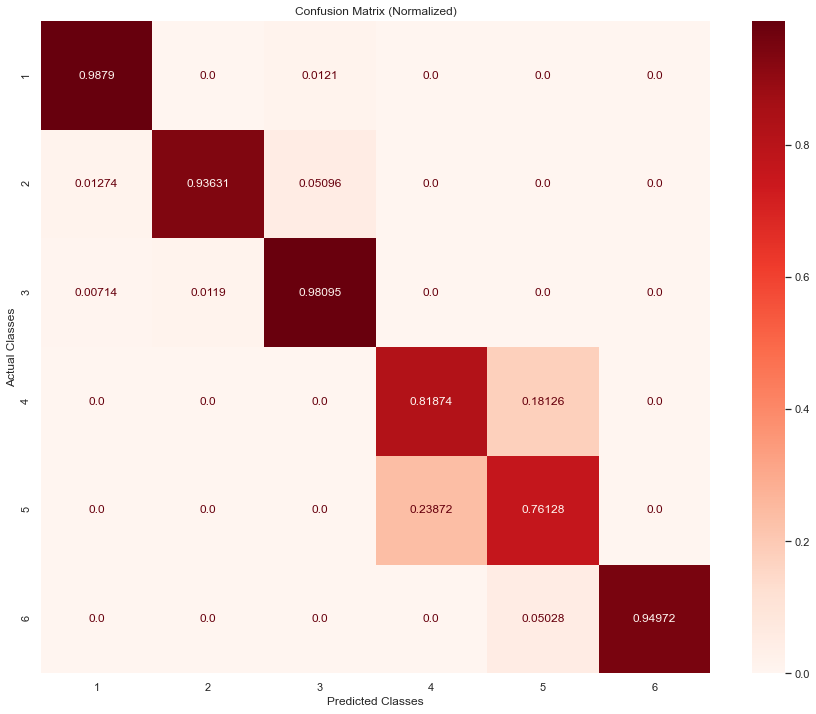

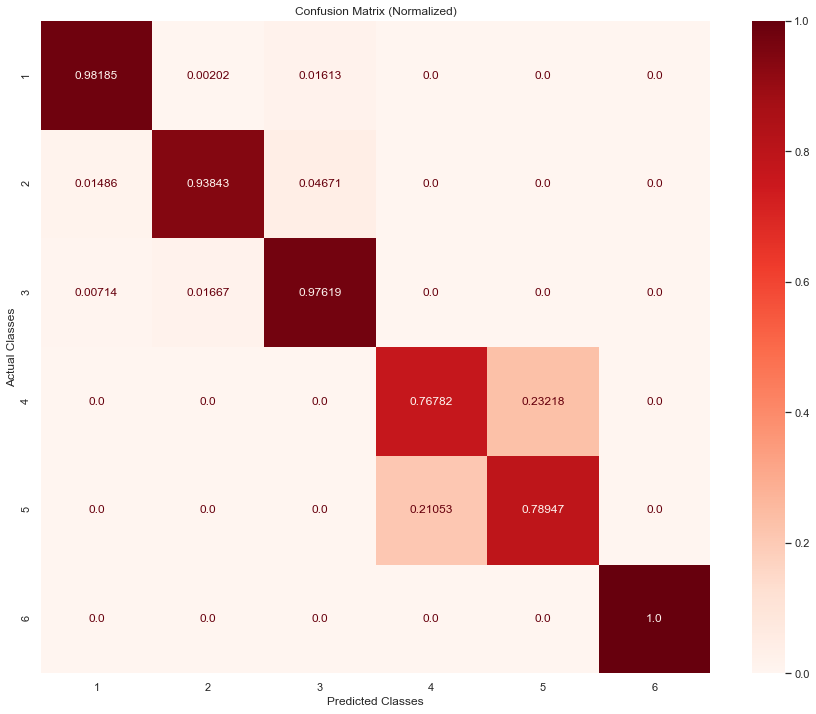

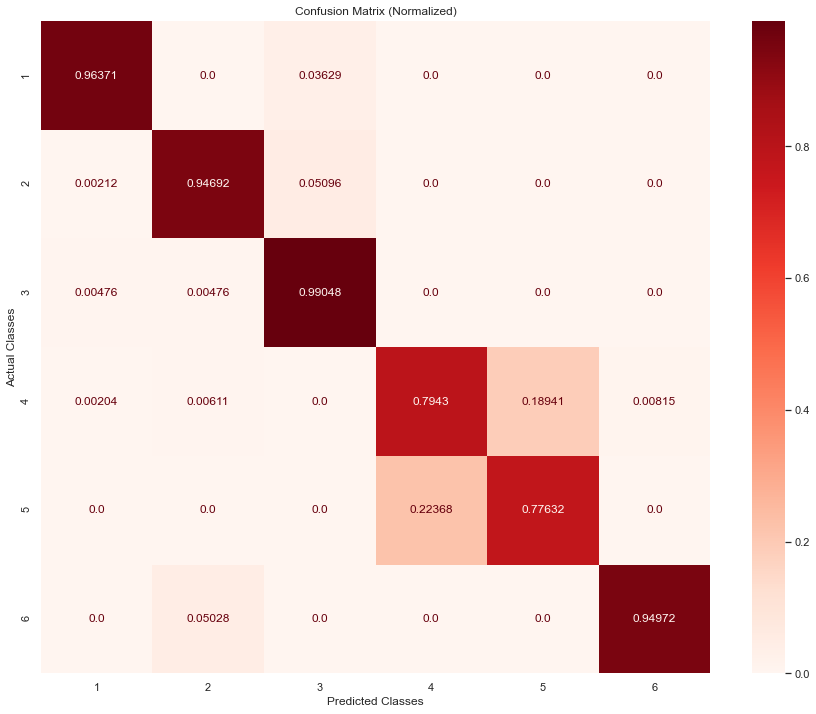

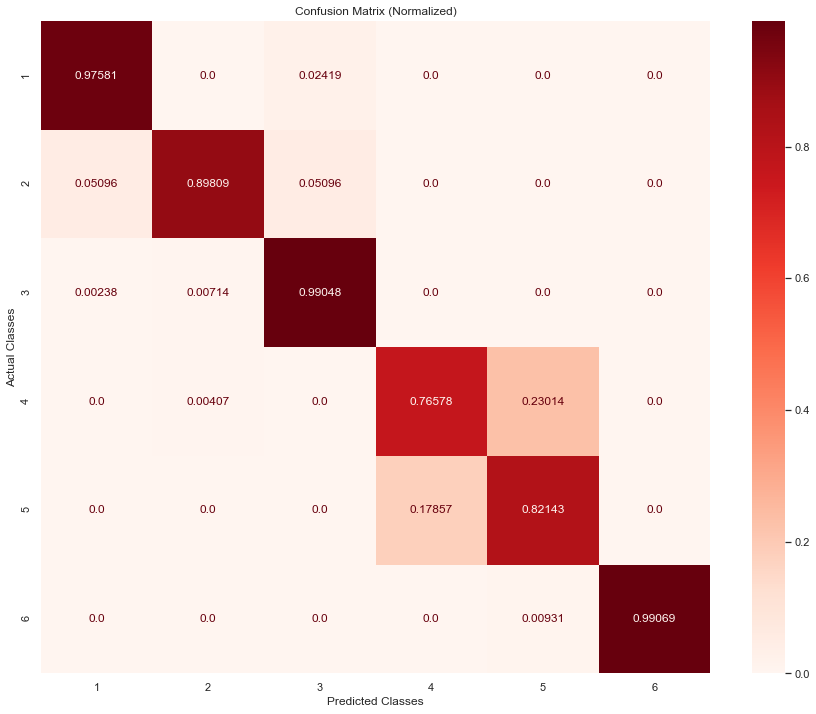

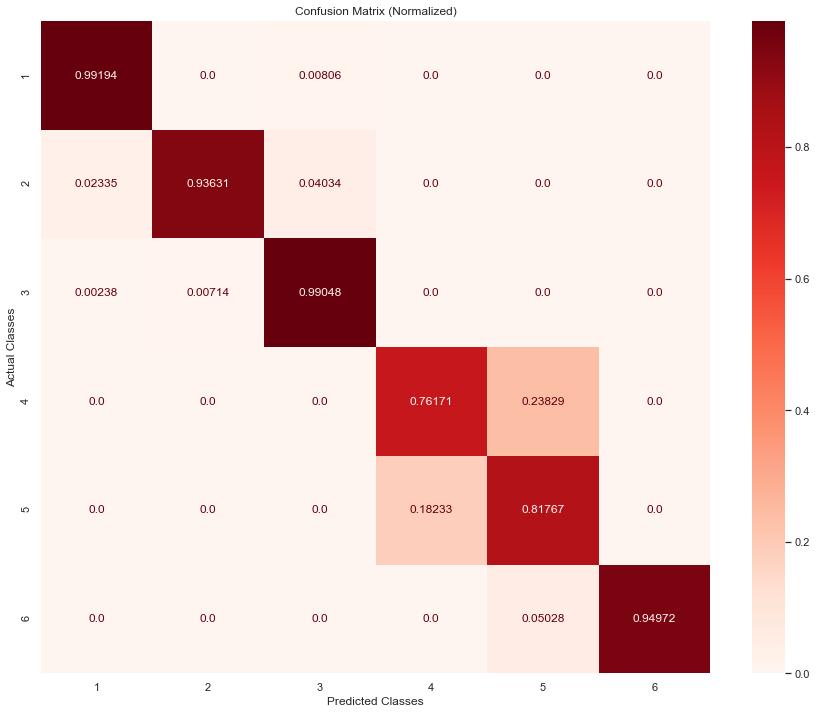

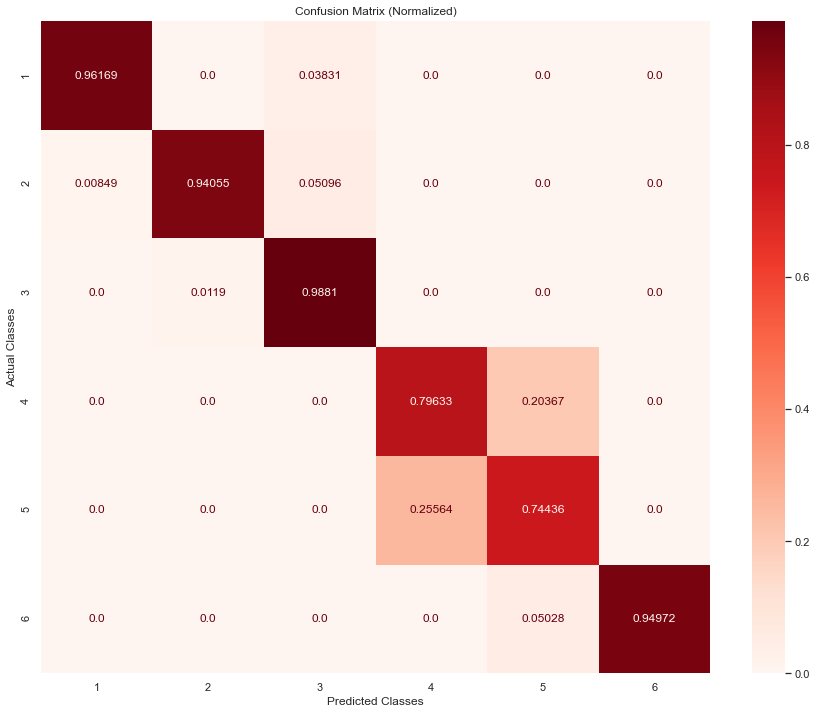

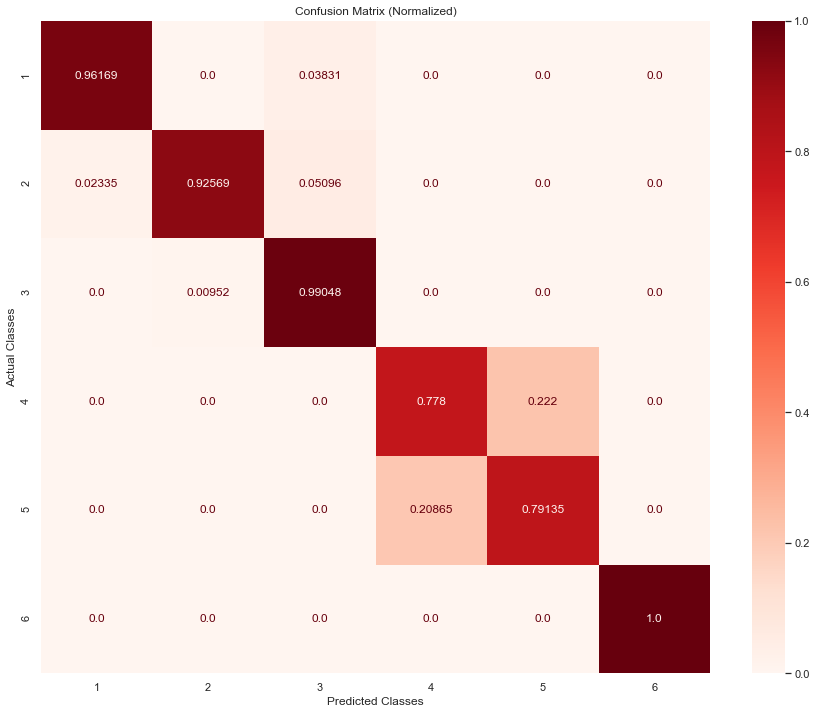

In [83]:
repeat_experiment_dac(model_type="cnnlstm", data = "reduced")

Run:  1
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 10s 19ms/step - loss: 0.0339 - accuracy: 0.9861 - val_loss: 0.0028 - val_accuracy: 0.9997
Epoch 2/10
460/460 [==============================] - 8s 18ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 4.7741e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 8s 18ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 1.3906e-04 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 8s 18ms/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0012 - val_accuracy: 0.9993
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [======================


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  2
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 11s 20ms/step - loss: 0.0346 - accuracy: 0.9868 - val_loss: 0.0018 - val_accuracy: 0.9997
Epoch 2/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 8.6697e-05 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.0073 - val_accuracy: 0.9983
Epoch 4/10
460/460 [==============================] - 9s 19ms/step - loss: 6.6086e-04 - accuracy: 0.9999 - val_loss: 0.0027 - val_accuracy: 0.9990
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [======================


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  3
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 12s 22ms/step - loss: 0.0327 - accuracy: 0.9864 - val_loss: 0.0033 - val_accuracy: 0.9993
Epoch 2/10
460/460 [==============================] - 10s 22ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 10s 22ms/step - loss: 2.8972e-04 - accuracy: 1.0000 - val_loss: 1.0300e-04 - val_accuracy: 1.0000
Timed stopping at epoch 3 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [==============================] - 6s 21ms/step - loss: 0.2983 - accuracy: 0.8807 - val_loss: 0.3545 - val_accuracy: 0.8519
Epoch 2/5000
255/255 [==================


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  4
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 11s 22ms/step - loss: 0.0360 - accuracy: 0.9839 - val_loss: 0.0022 - val_accuracy: 0.9997
Epoch 2/10
460/460 [==============================] - 10s 21ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 6.1329e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 10s 21ms/step - loss: 0.0011 - accuracy: 0.9995 - val_loss: 0.0071 - val_accuracy: 0.9976
Timed stopping at epoch 3 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
254/254 [==============================] - 6s 20ms/step - loss: 0.3013 - accuracy: 0.8816 - val_loss: 0.3543 - val_accuracy: 0.8770
Epoch 2/5000
254/254 [======================


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  5
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 10s 19ms/step - loss: 0.0309 - accuracy: 0.9874 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 2/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 9.5711e-05 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0137 - val_accuracy: 0.9973
Epoch 4/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 0.0060 - val_accuracy: 0.9986
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [==========================


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  6
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 10s 19ms/step - loss: 0.0366 - accuracy: 0.9861 - val_loss: 0.0014 - val_accuracy: 0.9997
Epoch 2/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.0055 - val_accuracy: 0.9986
Epoch 3/10
460/460 [==============================] - 9s 19ms/step - loss: 3.0779e-04 - accuracy: 0.9999 - val_loss: 0.0027 - val_accuracy: 0.9986
Epoch 4/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0380 - val_accuracy: 0.9891
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
254/254 [==========================


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  7
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 10s 20ms/step - loss: 0.0340 - accuracy: 0.9865 - val_loss: 0.0415 - val_accuracy: 0.9878
Epoch 2/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0100 - val_accuracy: 0.9976
Epoch 3/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0041 - val_accuracy: 0.9990
Epoch 4/10
460/460 [==============================] - 9s 19ms/step - loss: 7.3895e-05 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 0.9990
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [==========================


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  8
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 10s 19ms/step - loss: 0.0349 - accuracy: 0.9863 - val_loss: 5.3528e-04 - val_accuracy: 0.9997
Epoch 2/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 3/10
460/460 [==============================] - 9s 19ms/step - loss: 6.4411e-04 - accuracy: 0.9999 - val_loss: 1.4602e-04 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 9s 19ms/step - loss: 3.5562e-05 - accuracy: 1.0000 - val_loss: 1.7790e-05 - val_accuracy: 1.0000
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [==========

206/206 [==============================] - 4s 20ms/step - loss: 1.6147e-04 - accuracy: 1.0000 - val_loss: 0.5980 - val_accuracy: 0.9430
Epoch 25/5000
206/206 [==============================] - 4s 20ms/step - loss: 2.5786e-04 - accuracy: 1.0000 - val_loss: 0.6604 - val_accuracy: 0.9474
Epoch 26/5000
206/206 [==============================] - 4s 20ms/step - loss: 1.1576e-04 - accuracy: 1.0000 - val_loss: 0.6607 - val_accuracy: 0.9430
Epoch 27/5000
206/206 [==============================] - 4s 20ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.5263 - val_accuracy: 0.9430
Epoch 28/5000
206/206 [==============================] - 4s 20ms/step - loss: 5.1668e-04 - accuracy: 1.0000 - val_loss: 0.6300 - val_accuracy: 0.9409
Epoch 29/5000
206/206 [==============================] - 4s 20ms/step - loss: 2.4228e-04 - accuracy: 1.0000 - val_loss: 0.5899 - val_accuracy: 0.9488
Epoch 30/5000
206/206 [==============================] - 4s 20ms/step - loss: 6.0166e-05 - accuracy: 1.0000 - val_loss


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  9
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 10s 19ms/step - loss: 0.0340 - accuracy: 0.9856 - val_loss: 0.0230 - val_accuracy: 0.9932
Epoch 2/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 1.6083e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 9s 19ms/step - loss: 9.1961e-05 - accuracy: 1.0000 - val_loss: 5.5250e-05 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 9s 19ms/step - loss: 6.5626e-05 - accuracy: 1.0000 - val_loss: 1.2262e-04 - val_accuracy: 1.0000
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [==========


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  10
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
ConvLSTM
Epoch 1/10
460/460 [==============================] - 10s 19ms/step - loss: 0.0315 - accuracy: 0.9880 - val_loss: 0.0430 - val_accuracy: 0.9790
Epoch 2/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 7.8555e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 9s 19ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0173 - val_accuracy: 0.9898
Epoch 4/10
460/460 [==============================] - 9s 19ms/step - loss: 6.5270e-05 - accuracy: 1.0000 - val_loss: 9.9234e-05 - val_accuracy: 1.0000
Timed stopping at epoch 4 after training for 0:00:30

STATIONARY
ConvLSTM
Epoch 1/5000
255/255 [=================


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


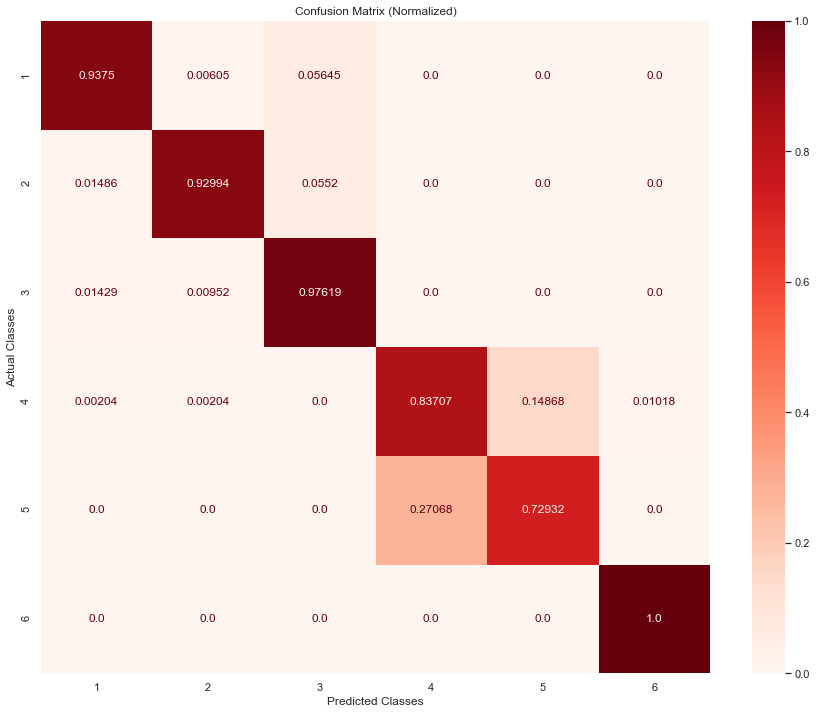

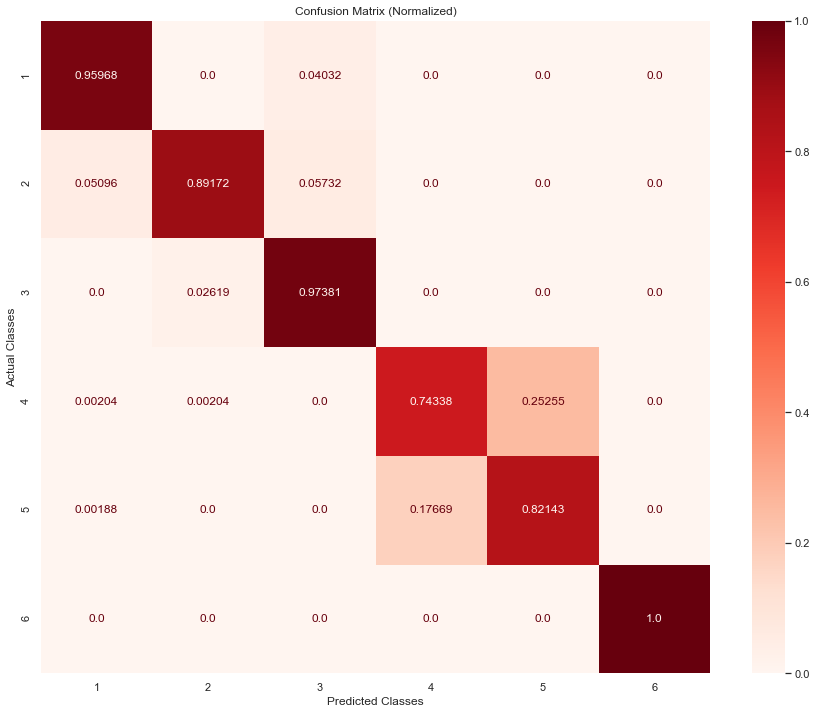

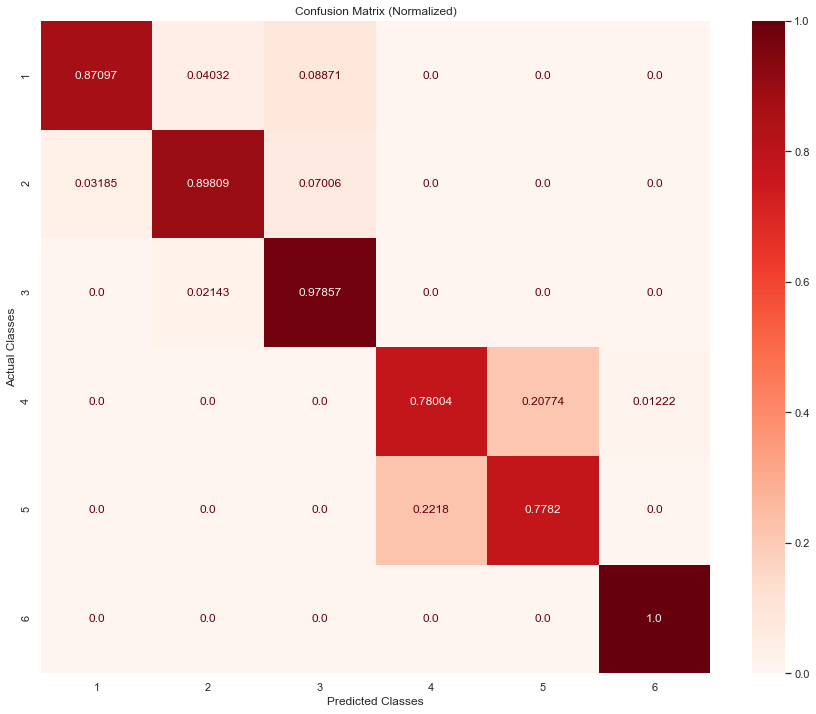

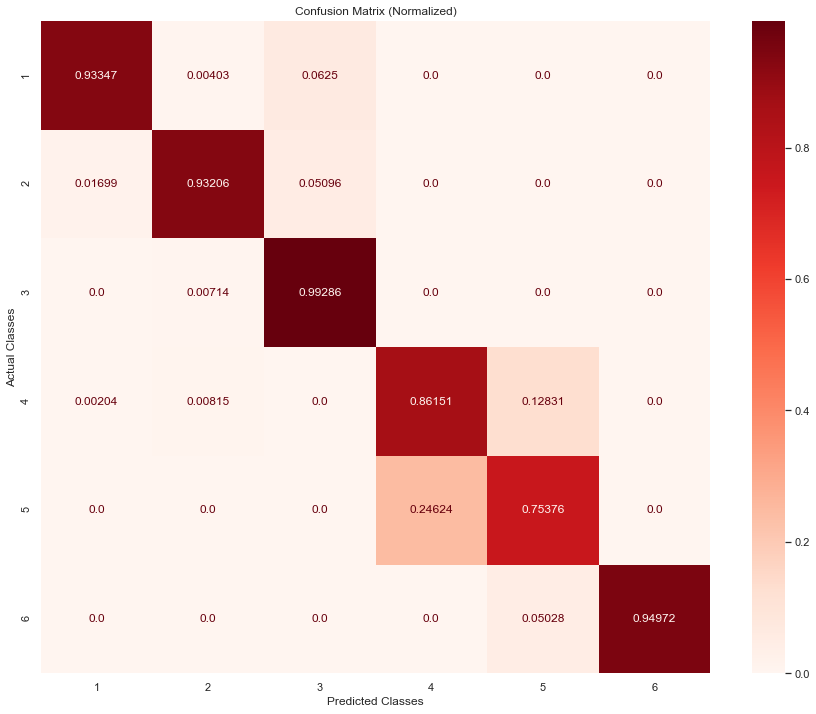

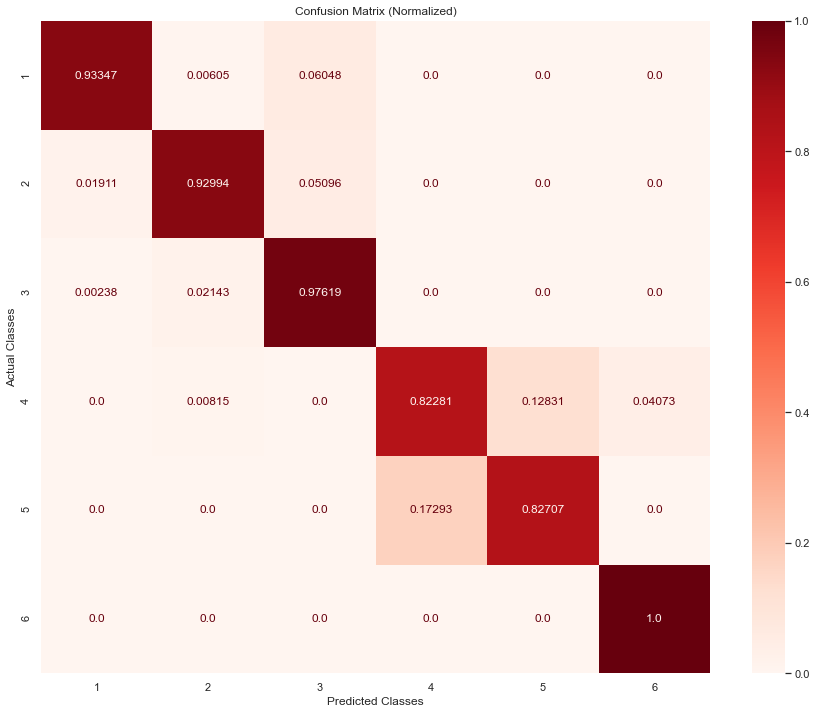

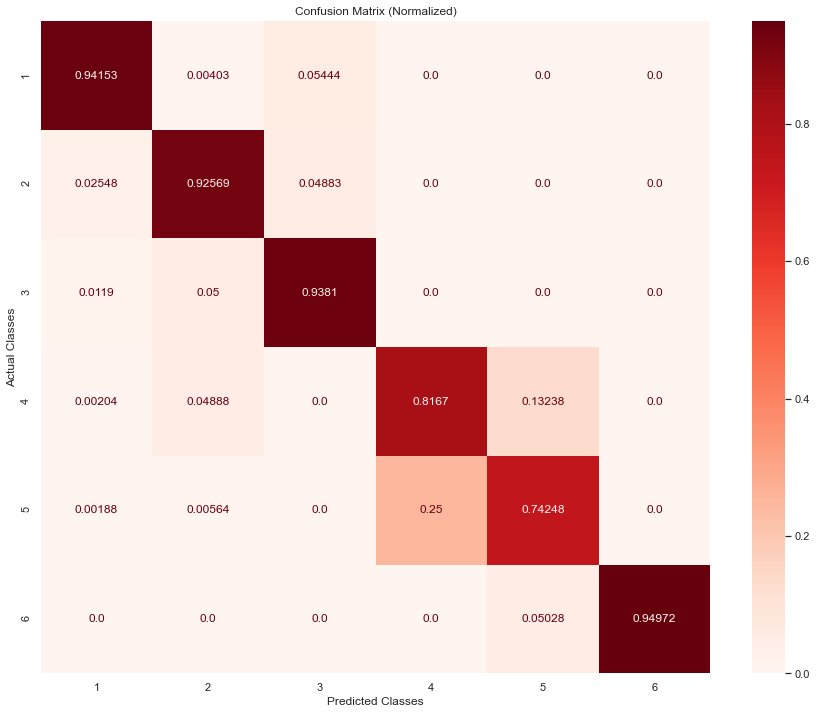

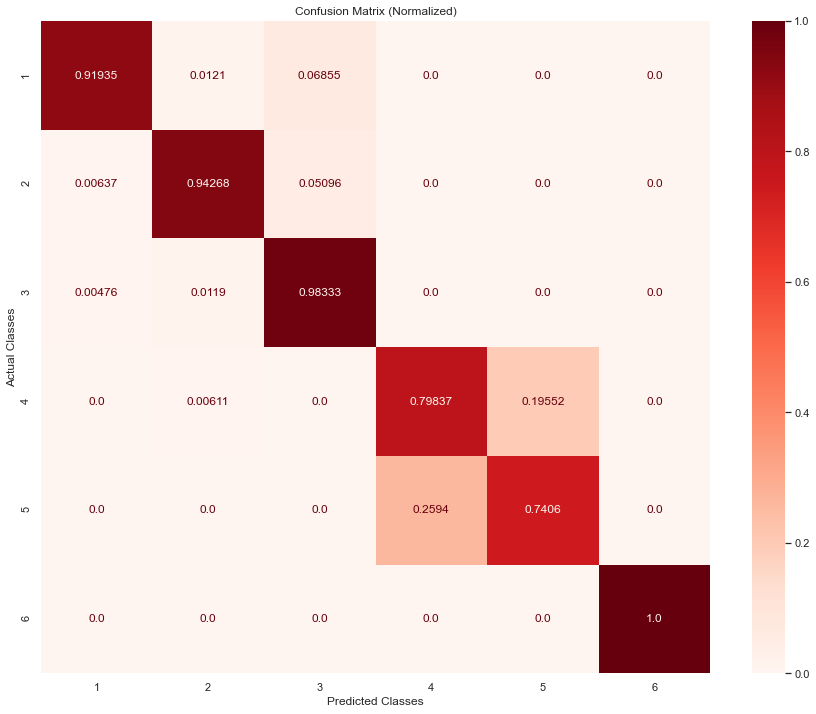

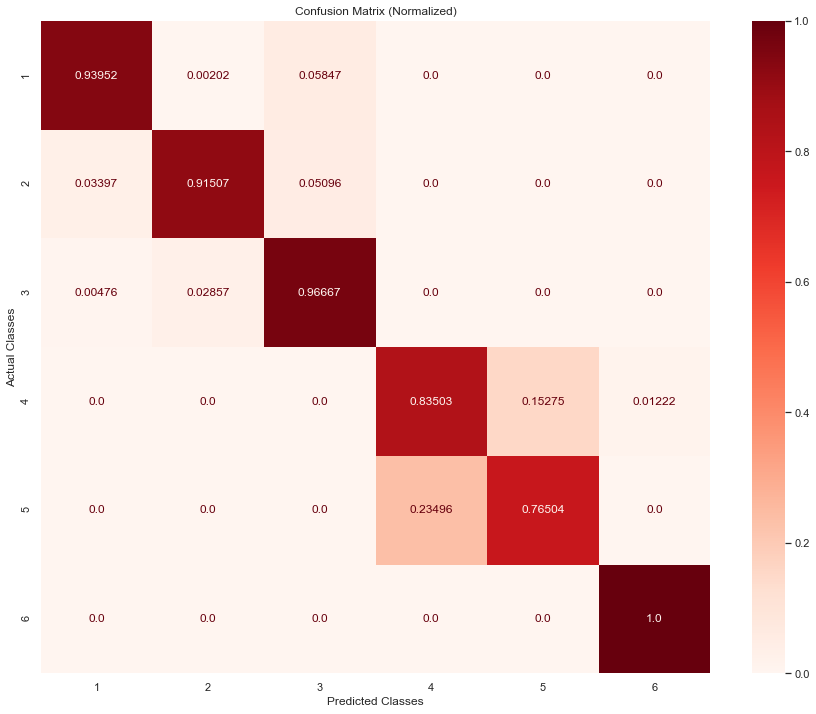

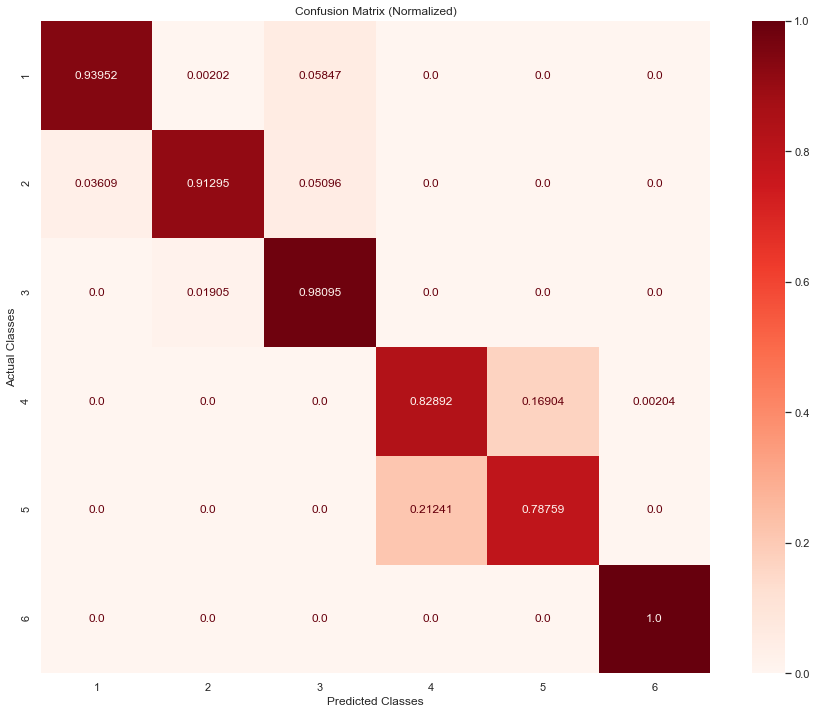

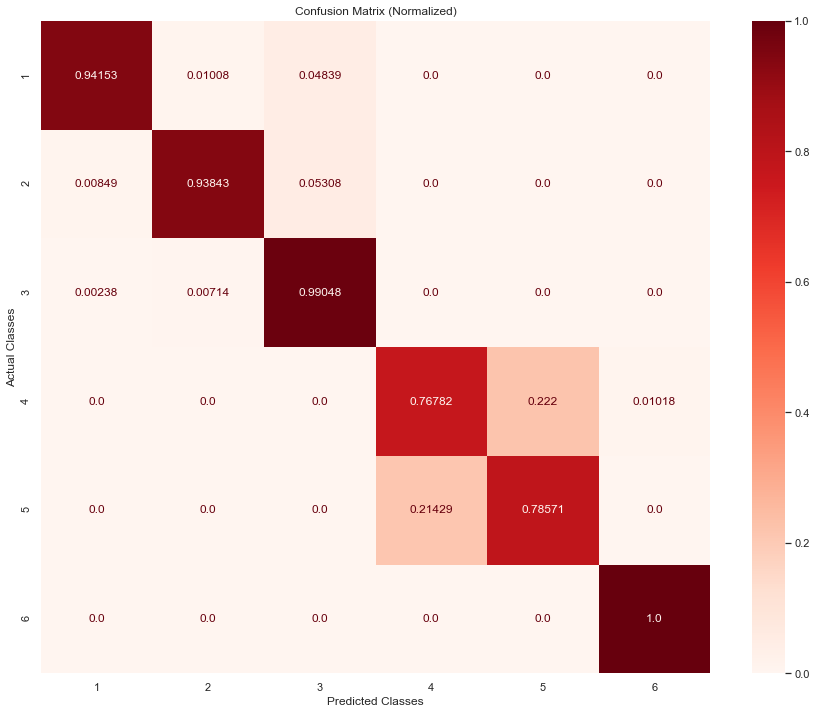

In [84]:
repeat_experiment_dac(model_type="convlstm", data = "reduced")

Run:  1
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 16ms/step - loss: 0.2088 - accuracy: 0.9021 - val_loss: 0.5508 - val_accuracy: 0.6658
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.1633 - accuracy: 0.9445 - val_loss: 0.0133 - val_accuracy: 0.9946
Epoch 3/10
460/460 [==============================] - 7s 14ms/step - loss: 0.1845 - accuracy: 0.9300 - val_loss: 0.0853 - val_accuracy: 0.9688
Epoch 4/10
460/460 [==============================] - 7s 14ms/step - loss: 0.0602 - accuracy: 0.9822 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0825 - accuracy: 0.9672 - val_loss: 0.3727 - val_ac


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  2
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 16ms/step - loss: 0.1497 - accuracy: 0.9290 - val_loss: 1.1622e-04 - val_accuracy: 1.0000
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 7.5657e-05 - accuracy: 1.0000 - val_loss: 2.0677e-05 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 7s 15ms/step - loss: 2.2766e-05 - accuracy: 1.0000 - val_loss: 1.0378e-05 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0520 - accuracy: 0.9865 - val_loss: 0.0050 - val_accuracy: 0.9993
Epoch 5/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0011 - accuracy: 0.9999 - val_l


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  3
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 16ms/step - loss: 0.2798 - accuracy: 0.8755 - val_loss: 0.4361 - val_accuracy: 0.7421
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.4746 - accuracy: 0.7553 - val_loss: 0.3862 - val_accuracy: 0.8252
Epoch 3/10
460/460 [==============================] - 7s 15ms/step - loss: 0.4635 - accuracy: 0.7569 - val_loss: 0.6859 - val_accuracy: 0.5277
Epoch 4/10
460/460 [==============================] - 7s 15ms/step - loss: 0.5307 - accuracy: 0.6763 - val_loss: 0.5297 - val_accuracy: 0.6820
Epoch 5/10
460/460 [==============================] - 7s 15ms/step - loss: 0.4866 - accuracy: 0.7194 - val_loss: 0.3503 - val_ac


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  4
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 16ms/step - loss: 0.1799 - accuracy: 0.9211 - val_loss: 0.0734 - val_accuracy: 0.9796
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0861 - accuracy: 0.9796 - val_loss: 0.0165 - val_accuracy: 0.9969
Epoch 3/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0120 - accuracy: 0.9986 - val_loss: 0.3986 - val_accuracy: 0.9450
Epoch 4/10
460/460 [==============================] - 7s 14ms/step - loss: 0.0275 - accuracy: 0.9954 - val_loss: 0.0149 - val_accuracy: 0.9976
Epoch 5/10
460/460 [==============================] - 7s 14ms/step - loss: 0.1113 - accuracy: 0.9578 - val_loss: 0.2132 - val_ac


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  5
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 16ms/step - loss: 0.2240 - accuracy: 0.9063 - val_loss: 0.0438 - val_accuracy: 0.9857
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0539 - accuracy: 0.9882 - val_loss: 0.0334 - val_accuracy: 0.9963
Epoch 3/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0056 - accuracy: 0.9993 - val_loss: 0.0039 - val_accuracy: 0.9997
Epoch 4/10
460/460 [==============================] - 7s 15ms/step - loss: 3.2192e-04 - accuracy: 1.0000 - val_loss: 1.9222e-04 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 7s 16ms/step - loss: 1.2226e-04 - accuracy: 1.0000 - val_loss: 8.0


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  6
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 15ms/step - loss: 0.1645 - accuracy: 0.9204 - val_loss: 0.1173 - val_accuracy: 0.9908
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.3865 - accuracy: 0.8356 - val_loss: 0.1615 - val_accuracy: 0.9569
Epoch 3/10
460/460 [==============================] - 7s 14ms/step - loss: 0.1265 - accuracy: 0.9472 - val_loss: 0.1887 - val_accuracy: 0.9389
Epoch 4/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0553 - accuracy: 0.9839 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0470 - accuracy: 0.9868 - val_loss: 0.0132 - val_ac


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  7
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 16ms/step - loss: 0.2190 - accuracy: 0.8991 - val_loss: 0.0037 - val_accuracy: 0.9997
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0169 - accuracy: 0.9969 - val_loss: 0.0073 - val_accuracy: 0.9980
Epoch 3/10
460/460 [==============================] - 7s 14ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0062 - val_accuracy: 0.9990
Epoch 4/10
460/460 [==============================] - 7s 15ms/step - loss: 4.0603e-05 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9993
Epoch 5/10
460/460 [==============================] - 7s 14ms/step - loss: 1.5883e-05 - accuracy: 1.0000 - val_loss: 0.0058 


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  8
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 15ms/step - loss: 0.1932 - accuracy: 0.9177 - val_loss: 0.0954 - val_accuracy: 0.9881
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.1158 - accuracy: 0.9612 - val_loss: 0.0419 - val_accuracy: 0.9912
Epoch 3/10
460/460 [==============================] - 7s 14ms/step - loss: 0.0348 - accuracy: 0.9895 - val_loss: 0.0180 - val_accuracy: 0.9966
Epoch 4/10
460/460 [==============================] - 7s 14ms/step - loss: 0.0151 - accuracy: 0.9959 - val_loss: 0.0177 - val_accuracy: 0.9963
Epoch 5/10
460/460 [==============================] - 7s 14ms/step - loss: 0.0075 - accuracy: 0.9984 - val_loss: 0.0085 - val_ac


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  9
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 15ms/step - loss: 0.3892 - accuracy: 0.8172 - val_loss: 0.4741 - val_accuracy: 0.7791
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.2600 - accuracy: 0.8765 - val_loss: 0.3740 - val_accuracy: 0.8473
Epoch 3/10
460/460 [==============================] - 7s 15ms/step - loss: 0.2363 - accuracy: 0.9116 - val_loss: 0.2040 - val_accuracy: 0.9233
Epoch 4/10
460/460 [==============================] - 7s 14ms/step - loss: 0.1423 - accuracy: 0.9514 - val_loss: 0.1787 - val_accuracy: 0.9498
Epoch 5/10
460/460 [==============================] - 7s 14ms/step - loss: 0.0807 - accuracy: 0.9710 - val_loss: 0.1204 - val_ac


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


Run:  10
reduced
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
prefix:   datasets/HARDataset/train/Inertial Signals/
prefix:   datasets/HARDataset/test/Inertial Signals/
SPLITTING DATA:
Classify data as either stationary or moving:
Bi-LSTM
Epoch 1/10
460/460 [==============================] - 9s 16ms/step - loss: 0.2402 - accuracy: 0.8946 - val_loss: 0.0098 - val_accuracy: 0.9983
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0327 - accuracy: 0.9891 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 7s 16ms/step - loss: 0.0053 - accuracy: 0.9985 - val_loss: 0.0037 - val_accuracy: 0.9980
Epoch 4/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 1.1194e-04 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 7s 15ms/step - loss: 0.0117 - accuracy: 0.9970 - val_loss: 0.0058 - v


The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


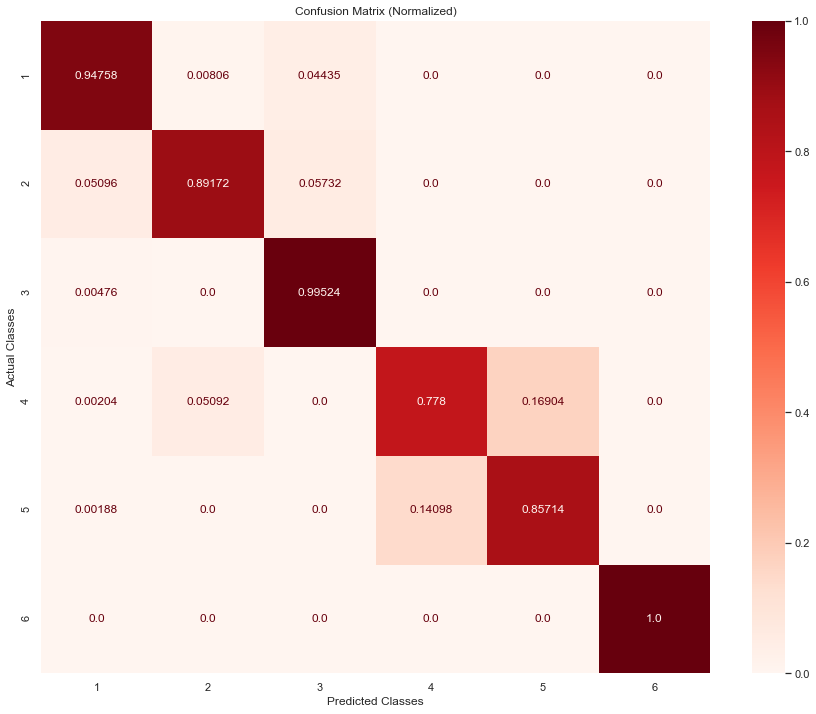

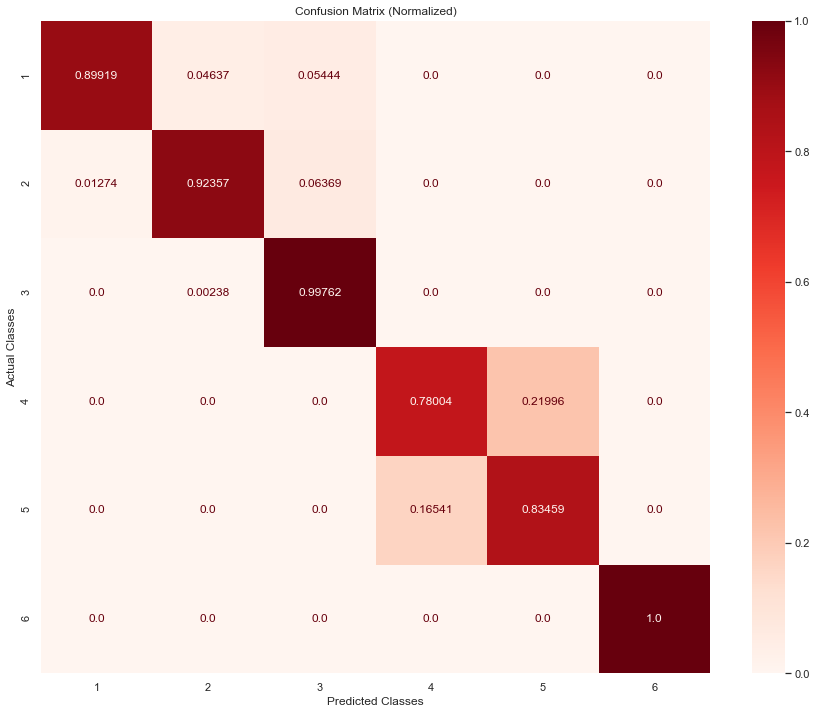

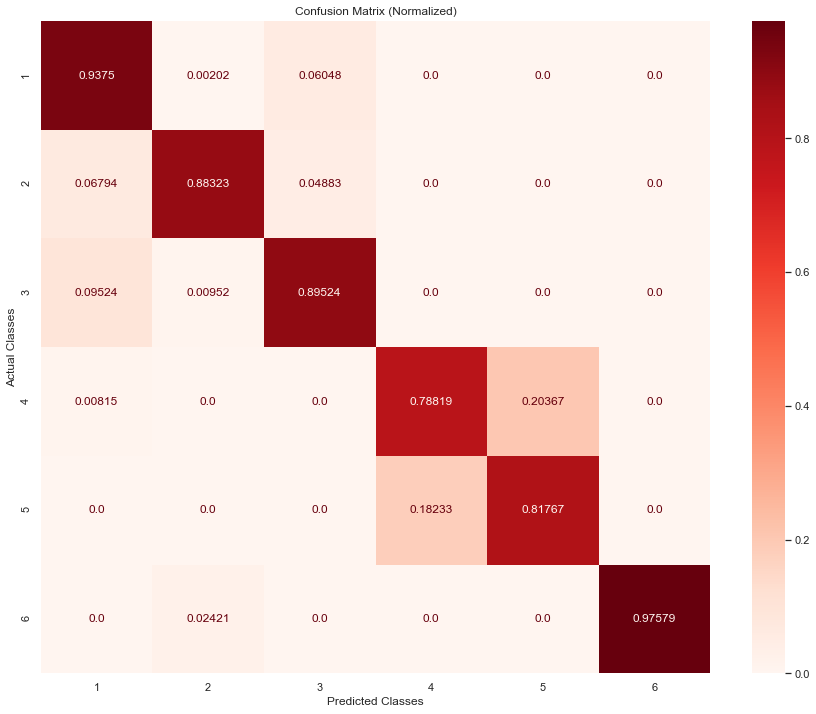

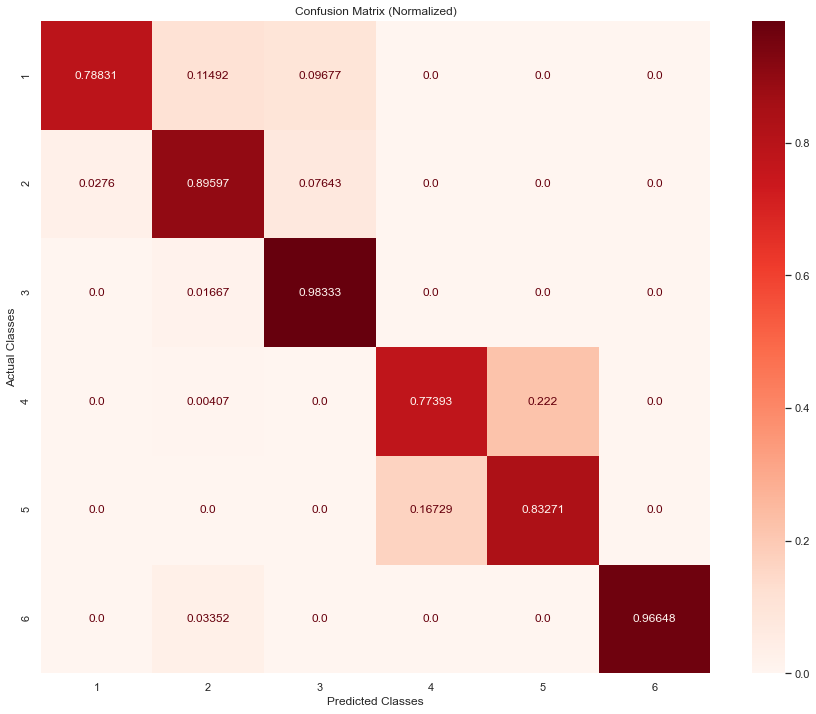

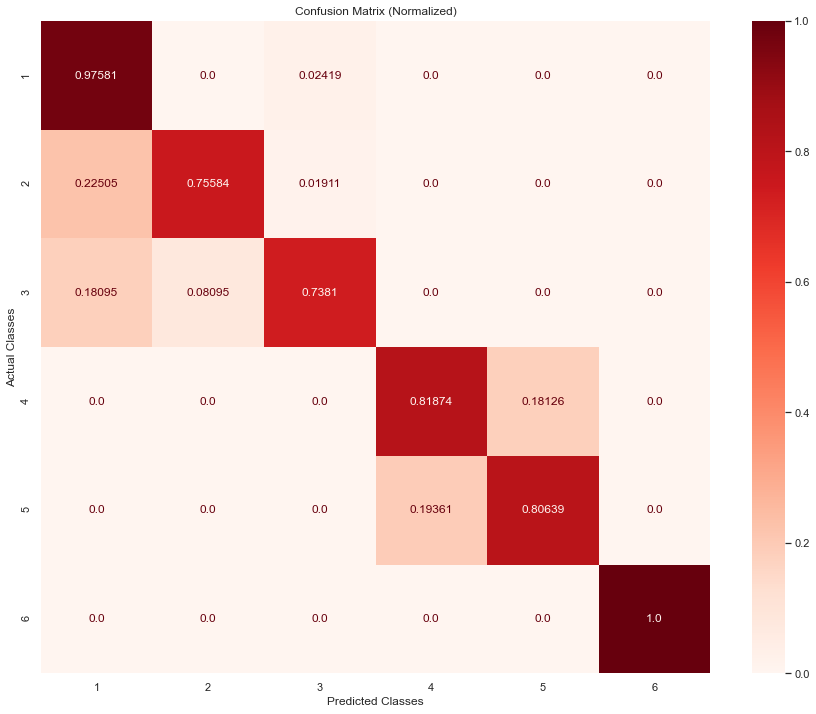

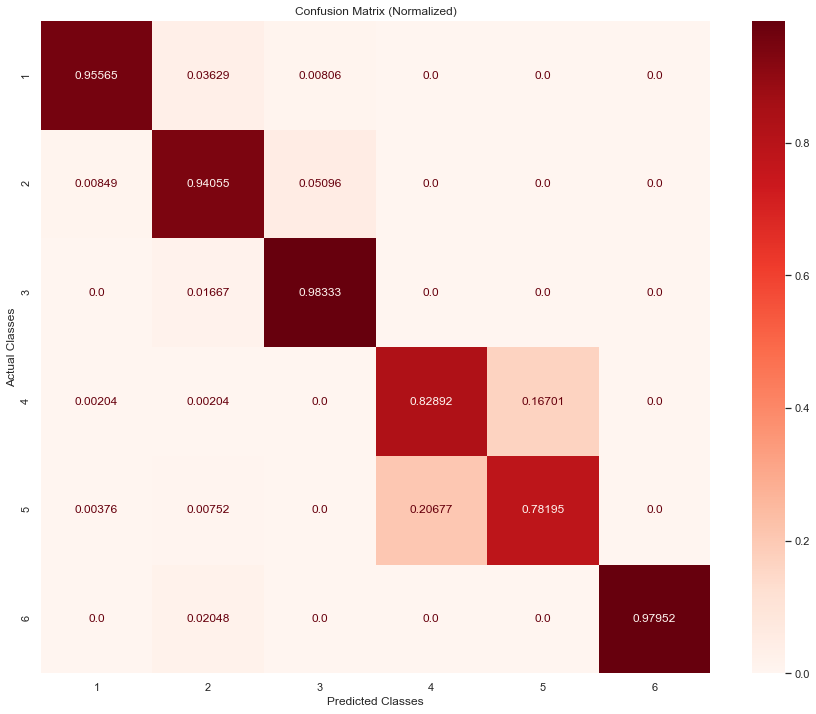

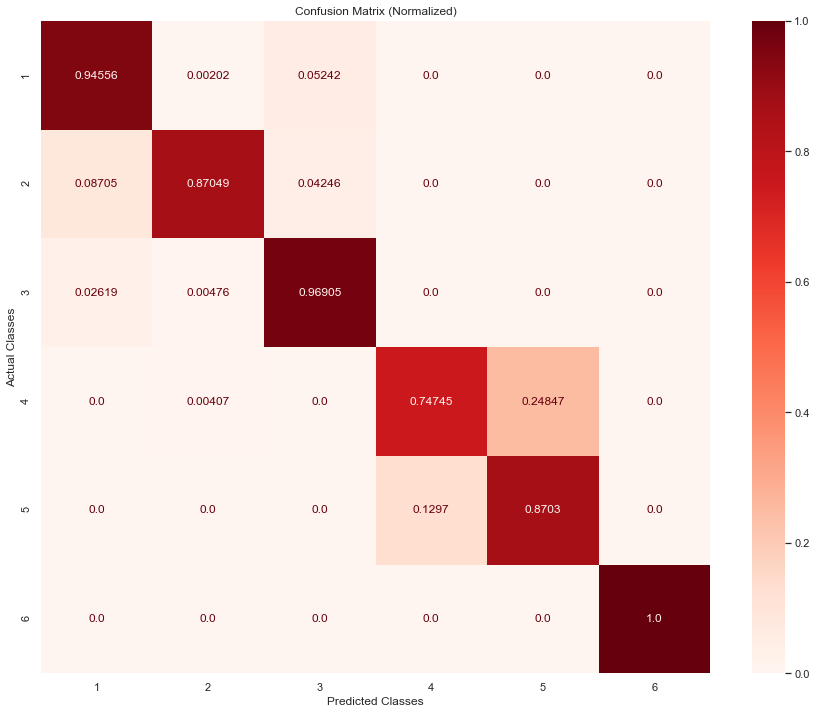

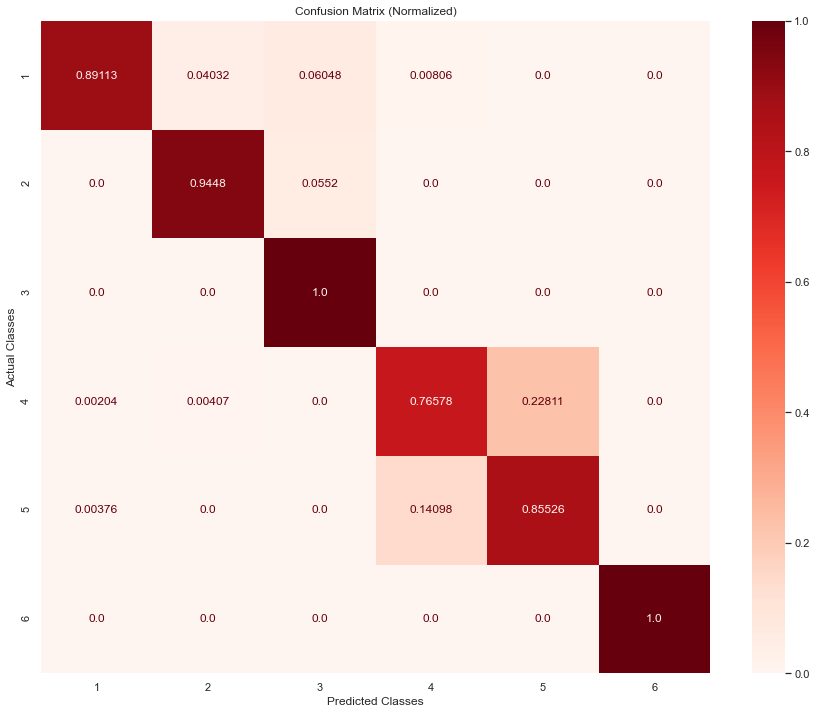

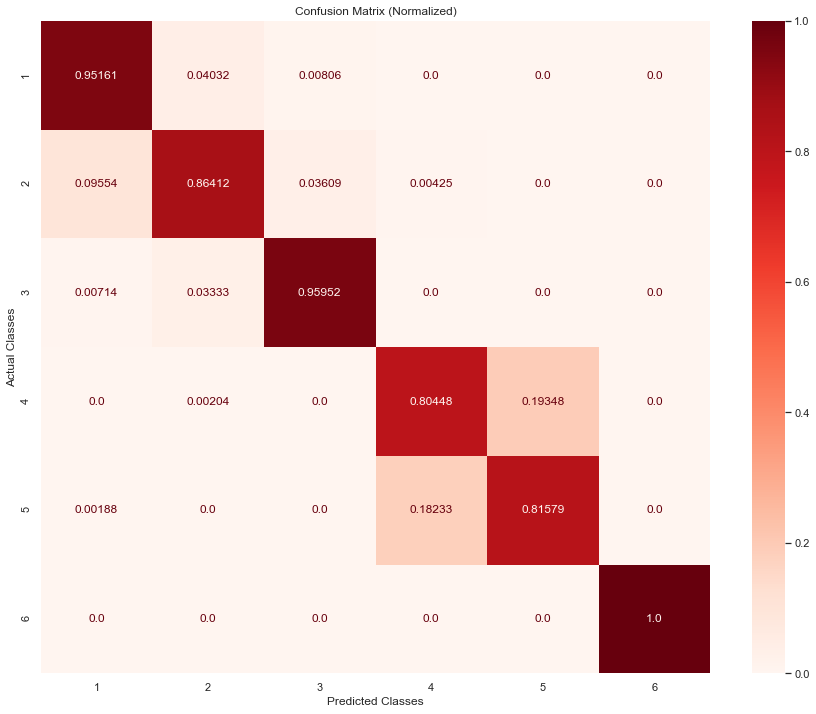

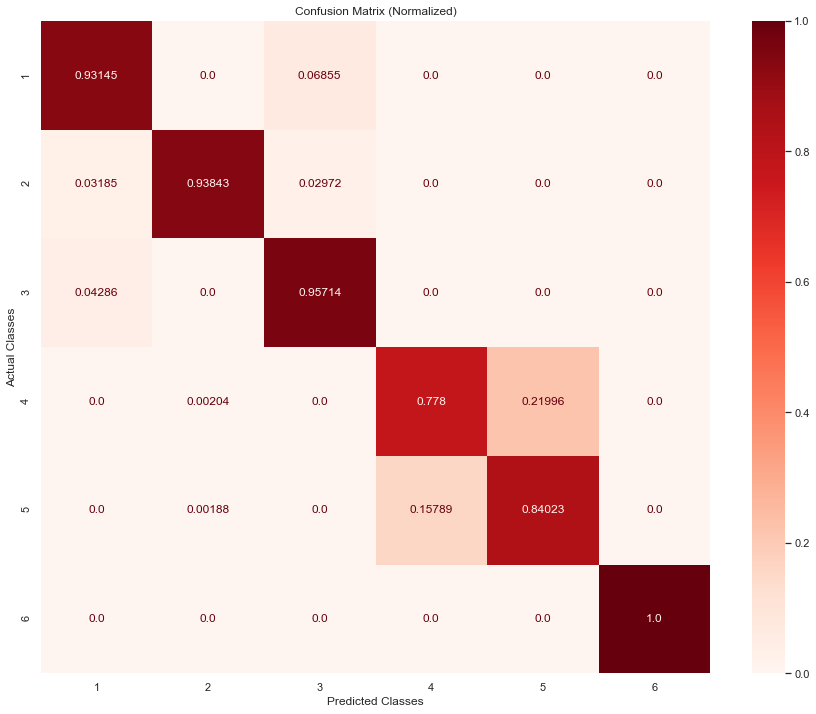

In [85]:
repeat_experiment_dac(model_type="bilstm", data = "reduced")

### Store the data from these repeat runs

#### First, make a dataframe to store all the dictionaries of metrics

In [86]:
# function to make list to store model family
def model_family_fn(df):
    family = list()
    for i in range(len(df)):
        if (df['model'][i][0] == "l"):
            family.append("lstm")
        elif (df['model'][i][0] == "c"):
            if (df['model'][i][1] == "n"):
                family.append("cnnlstm")
            else:
                family.append("convlstm")
        else:
            family.append("bilstm")
    
    return family

In [87]:
# function tomake list to store model type (whether dac or standard model)
def model_type_fn(df, model="model"):

    model_type = list()
    for i in range(len(df)):
        if (df[model][i].find("dac") == -1):
            model_type.append("standard")
        else:
            model_type.append("divide_and_conquer") 
            
    return model_type

In [88]:
# function tomake list to store model type (whether dac or standard model)
def data_used_fn(df, model="model"):

    data_used = list()
    for i in range(len(df)):
        if ("original" in  df[model][i]):
            data_used.append("original")
        elif ("reduced" in df[model][i]):
            data_used.append("reduced")
            
    return data_used

In [89]:
# make a df for the metrics for each repeat, to see how much this varies between runs

# get the names of each model
repeat_keys = list(repeat_final_model_accuracies_train.keys())

# make lists of each metric
repeat_final_model_accuracies_train_values = list(repeat_final_model_accuracies_train.values())
repeat_final_model_accuracies_test_values = list(repeat_final_model_accuracies_test.values())

repeat_precision_values = list(repeat_precision.values())
repeat_recall_values = list(repeat_recall.values())
repeat_f1_score_values = list(repeat_f1_score.values())

# declare dataframe
repeat_metrics_df = pd.DataFrame(repeat_keys, index=repeat_keys)
repeat_metrics_df = repeat_metrics_df.rename(columns={0: "model"})

# make list to store model family      
repeat_family = model_family_fn(repeat_metrics_df)

# make list to store data used by model
repeat_data_used = data_used_fn(repeat_metrics_df)
        
# make list to store model type (whether dac or standard model)
repeat_model_type = model_type_fn(repeat_metrics_df)

# add columns to dataframe
repeat_metrics_df['family'] = repeat_family
repeat_metrics_df['model_type'] = repeat_model_type
repeat_metrics_df['data_used'] = repeat_data_used
repeat_metrics_df['train_accuracy'] = repeat_final_model_accuracies_train_values
repeat_metrics_df['test_accuracy'] = repeat_final_model_accuracies_test_values
repeat_metrics_df['precision'] = repeat_precision_values
repeat_metrics_df['recall'] = repeat_recall_values
repeat_metrics_df['f1_score'] = repeat_f1_score_values
repeat_metrics_df['model_plain'] =  repeat_metrics_df['family'] + '_' + repeat_metrics_df['model_type'] + '_' + repeat_metrics_df['data_used']

repeat_metrics_df

model  family          model_type  \
lstm_original_1                lstm_original_1    lstm            standard   
lstm_original_2                lstm_original_2    lstm            standard   
lstm_original_3                lstm_original_3    lstm            standard   
lstm_original_4                lstm_original_4    lstm            standard   
lstm_original_5                lstm_original_5    lstm            standard   
...                                        ...     ...                 ...   
bilstm_reduced__dac_6    bilstm_reduced__dac_6  bilstm  divide_and_conquer   
bilstm_reduced__dac_7    bilstm_reduced__dac_7  bilstm  divide_and_conquer   
bilstm_reduced__dac_8    bilstm_reduced__dac_8  bilstm  divide_and_conquer   
bilstm_reduced__dac_9    bilstm_reduced__dac_9  bilstm  divide_and_conquer   
bilstm_reduced__dac_10  bilstm_reduced__dac_10  bilstm  divide_and_conquer   

                       data_used  train_accuracy  test_accuracy  precision  \
lstm_original_1         original        0.953890       0.918561   0.918314   
lstm_original_2         original        0.961643       0.927044   0.927365   
lstm_original_3         original        0.954978       0.903631   0.903219   
lstm_original_4         original        0.952938       0.913471   0.913026   
lstm_original_5         original        0.960283       0.911775   0.911468   
...                          ...             ...            ...        ...   
bilstm_reduced__dac_6    reduced        0.957155       0.909060   0.909790   
bilstm_reduced__dac_7    reduced        0.946001       0.900238   0.902789   
bilstm_reduced__dac_8    reduced        0.955930       0.907703   0.909983   
bilstm_reduced__dac_9    reduced        0.941376       0.898541   0.898648   
bilstm_reduced__dac_10   reduced        0.954026       0.906685   0.907696   

                          recall  f1_score                        model_plain  
lstm_original_1         0.918561  0.918147             lstm_standard_original  
lstm_original_2         0.927044  0.926610             lstm_standard_original  
lstm_original_3         0.903631  0.903129             lstm_standard_original  
lstm_original_4         0.913471  0.912658             lstm_standard_original  
lstm_original_5         0.911775  0.911580             lstm_standard_original  
...                          ...       ...                                ...  
bilstm_reduced__dac_6   0.909060  0.909009  bilstm_divide_and_conquer_reduced  
bilstm_reduced__dac_7   0.900238  0.899832  bilstm_divide_and_conquer_reduced  
bilstm_reduced__dac_8   0.907703  0.907506  bilstm_divide_and_conquer_reduced  
bilstm_reduced__dac_9   0.898541  0.898351  bilstm_divide_and_conquer_reduced  
bilstm_reduced__dac_10  0.906685  0.906742  bilstm_divide_and_conquer_reduced  

[160 rows x 10 columns]

In [90]:
# make a df for mean metrics

# get the names of each model
mean_keys = list(mean_final_model_accuracies_train.keys())

# make lists of each metric
mean_final_model_accuracies_train_values = list(mean_final_model_accuracies_train.values())
mean_final_model_accuracies_test_values = list(mean_final_model_accuracies_test.values())

mean_precision_values = list(mean_precision.values())
mean_recall_values = list(mean_recall.values())
mean_f1_score_values = list(mean_f1_score.values())

std_final_model_accuracies_train_values = list(std_final_model_accuracies_train.values())
std_final_model_accuracies_test_values = list(std_final_model_accuracies_test.values())
std_precision_values = list(std_precision.values())
std_recall_values = list(std_recall.values())
std_f1_score_values = list(std_f1_score.values())

# declare dataframe
mean_metrics_df = pd.DataFrame(mean_keys, index=mean_keys)
mean_metrics_df = mean_metrics_df.rename(columns={0: "model"})

# make list to store model family      
mean_family = model_family_fn(mean_metrics_df)

# make list to store data used by model
mean_data_used = data_used_fn(mean_metrics_df)
        
# make list to store model type (whether dac or standard model)
mean_model_type = model_type_fn(mean_metrics_df)

# add columns to dataframe
mean_metrics_df['family'] = mean_family
mean_metrics_df['model_type'] = mean_model_type
mean_metrics_df['data_used'] = mean_data_used
mean_metrics_df['mean_train_accuracy'] = mean_final_model_accuracies_train_values
mean_metrics_df['train_accuracy_sd'] = std_final_model_accuracies_train_values
mean_metrics_df['mean_test_accuracy'] = mean_final_model_accuracies_test_values
mean_metrics_df['test_accuracy_sd'] = std_final_model_accuracies_test_values
mean_metrics_df['mean_precision'] = mean_precision_values
mean_metrics_df['precision_sd'] = std_precision_values
mean_metrics_df['mean_recall'] = mean_recall_values
mean_metrics_df['recall_sd'] = std_recall_values
mean_metrics_df['mean_f1_score'] = mean_f1_score_values
mean_metrics_df['f1_score_sd'] = std_f1_score_values
mean_metrics_df['model_plain'] =  mean_metrics_df['family'] + '_' + mean_metrics_df['model_type'] + '_' + mean_metrics_df['data_used']

mean_metrics_df

model    family          model_type  \
lstm_original                  lstm_original      lstm            standard   
cnnlstm_original            cnnlstm_original   cnnlstm            standard   
convlstm_original          convlstm_original  convlstm            standard   
bilstm_original              bilstm_original    bilstm            standard   
lstm_reduced                    lstm_reduced      lstm            standard   
cnnlstm_reduced              cnnlstm_reduced   cnnlstm            standard   
convlstm_reduced            convlstm_reduced  convlstm            standard   
bilstm_reduced                bilstm_reduced    bilstm            standard   
lstm_original_dac          lstm_original_dac      lstm  divide_and_conquer   
cnnlstm_original_dac    cnnlstm_original_dac   cnnlstm  divide_and_conquer   
convlstm_original_dac  convlstm_original_dac  convlstm  divide_and_conquer   
bilstm_original_dac      bilstm_original_dac    bilstm  divide_and_conquer   
lstm_reduced_dac            lstm_reduced_dac      lstm  divide_and_conquer   
cnnlstm_reduced_dac      cnnlstm_reduced_dac   cnnlstm  divide_and_conquer   
convlstm_reduced_dac    convlstm_reduced_dac  convlstm  divide_and_conquer   
bilstm_reduced_dac        bilstm_reduced_dac    bilstm  divide_and_conquer   

                      data_used  mean_train_accuracy  train_accuracy_sd  \
lstm_original          original             0.957739           0.002956   
cnnlstm_original       original             0.988955           0.001895   
convlstm_original      original             0.974973           0.001783   
bilstm_original        original             0.952067           0.010412   
lstm_reduced            reduced             0.953795           0.004420   
cnnlstm_reduced         reduced             0.987636           0.001770   
convlstm_reduced        reduced             0.970960           0.002357   
bilstm_reduced          reduced             0.938724           0.022276   
lstm_original_dac      original             0.955509           0.006018   
cnnlstm_original_dac   original             0.987051           0.003423   
convlstm_original_dac  original             0.969695           0.001543   
bilstm_original_dac    original             0.949184           0.009728   
lstm_reduced_dac        reduced             0.949306           0.009528   
cnnlstm_reduced_dac     reduced             0.986997           0.002470   
convlstm_reduced_dac    reduced             0.968281           0.001802   
bilstm_reduced_dac      reduced             0.948395           0.007461   

                       mean_test_accuracy  test_accuracy_sd  mean_precision  \
lstm_original                    0.914625          0.007502        0.914642   
cnnlstm_original                 0.896709          0.005510        0.897493   
convlstm_original                0.892671          0.005803        0.893421   
bilstm_original                  0.910316          0.009320        0.911382   
lstm_reduced                     0.881982          0.033572        0.887374   
cnnlstm_reduced                  0.864201          0.008110        0.865573   
convlstm_reduced                 0.854428          0.007347        0.856110   
bilstm_reduced                   0.879640          0.021106        0.884247   
lstm_original_dac                0.904818          0.023083        0.911201   
cnnlstm_original_dac             0.898032          0.006540        0.900234   
convlstm_original_dac            0.897218          0.007498        0.900316   
bilstm_original_dac              0.895419          0.023621        0.899088   
lstm_reduced_dac                 0.899016          0.015849        0.900145   
cnnlstm_reduced_dac              0.901425          0.006598        0.903307   
convlstm_reduced_dac             0.897930          0.009048        0.900030   
bilstm_reduced_dac               0.894571          0.017868        0.897264   

                       precision_sd  mean_recall  recall_sd  mean_f1_score  \
lstm_original 

#### Make a dataframe to store accuracies per epoch

In [91]:
# convert the dictionary values from arrays into series so that they can be made into a dataframe
for model in repeat_training_times:
    repeat_training_times[model] = pd.Series(repeat_training_times[model]) 

# make dataframe for trainig times
repeat_training_times_df = pd.DataFrame(repeat_training_times)

# get training times in a list
repeat_training_times_df['epoch'] = repeat_training_times_df.index
repeat_training_times_df = pd.melt(repeat_training_times_df, id_vars = 'epoch', value_name = "time")
repeat_times_list= list(repeat_training_times_df.time)

In [92]:
# convert the dictionary values from arrays into series so that they can be made into a dataframe
for model in repeat_epoch_accuracies_train:
    repeat_epoch_accuracies_train[model] = pd.Series(repeat_epoch_accuracies_train[model]) 

for model in repeat_epoch_accuracies_test:
    repeat_epoch_accuracies_test[model] = pd.Series(repeat_epoch_accuracies_test[model]) 
    
# make dataframe for accuracies per epoch
repeat_epoch_accuracies_train_df = pd.DataFrame(repeat_epoch_accuracies_train)
repeat_epoch_accuracies_test_df = pd.DataFrame(repeat_epoch_accuracies_test)

In [93]:
# make train df tidy fomat
repeat_epoch_accuracies_train_df['epoch'] = repeat_epoch_accuracies_train_df.index
repeat_epoch_accuracies_train_df = pd.melt(repeat_epoch_accuracies_train_df, id_vars = 'epoch')
repeat_epoch_accuracies_train_df = repeat_epoch_accuracies_train_df.rename(columns={"variable": "model", "value": "accuracy"})
repeat_epoch_accuracies_train_df["time"] = repeat_times_list
repeat_epoch_accuracies_train_df["family"] = model_family_fn(repeat_epoch_accuracies_train_df)
repeat_epoch_accuracies_train_df["model_type"] = model_type_fn(repeat_epoch_accuracies_train_df)
repeat_epoch_accuracies_train_df["data_used"] = data_used_fn(repeat_epoch_accuracies_train_df)
repeat_epoch_accuracies_train_df["data_used_and_model_type"] = repeat_epoch_accuracies_train_df["data_used"] + "_" + repeat_epoch_accuracies_train_df["model_type"]
repeat_epoch_accuracies_train_df["test_or_train"] = 'train'
repeat_epoch_accuracies_train_df['model_plain'] =  repeat_epoch_accuracies_train_df['family'] + '_' + repeat_epoch_accuracies_train_df['model_type'] + '_' + repeat_epoch_accuracies_train_df['data_used']
repeat_epoch_accuracies_train_df

epoch                   model  accuracy       time  family  \
0          0         lstm_original_1  0.519450   6.848221    lstm   
1          1         lstm_original_1  0.754489  10.509077    lstm   
2          2         lstm_original_1  0.835555  14.391985    lstm   
3          3         lstm_original_1  0.904652  18.274889    lstm   
4          4         lstm_original_1  0.920294  22.117772    lstm   
...      ...                     ...       ...        ...     ...   
24475    148  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24476    149  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24477    150  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24478    151  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24479    152  bilstm_reduced__dac_10       NaN        NaN  bilstm   

               model_type data_used    data_used_and_model_type test_or_train  \
0                standard  original           original_standard         train   
1                standard  original           original_standard         train   
2                standard  original           original_standard         train   
3                standard  original           original_standard         train   
4                standard  original           original_standard         train   
...                   ...       ...                         ...           ...   
24475  divide_and_conquer   reduced  reduced_divide_and_conquer         train   
24476  divide_and_conquer   reduced  reduced_divide_and_conquer         train   
24477  divide_and_conquer   reduced  reduced_divide_and_conquer         train   
24478  divide_and_conquer   reduced  reduced_divide_and_conquer         train   
24479  divide_and_conquer   reduced  reduced_divide_and_conquer         train   

                             model_plain  
0                 lstm_standard_original  
1                 lstm_standard_original  
2                 lstm_standard_original  
3                 lstm_standard_original  
4                 lstm_standard_original  
...                                  ...  
24475  bilstm_divide_and_conquer_reduced  
24476  bilstm_divide_and_conquer_reduced  
24477  bilstm_divide_and_conquer_reduced  
24478  bilstm_divide_and_conquer_reduced  
24479  bilstm_divide_and_conquer_reduced  

[24480 rows x 10 columns]

In [94]:
# make test df tidy fomat
repeat_epoch_accuracies_test_df['epoch'] = repeat_epoch_accuracies_test_df.index
repeat_epoch_accuracies_test_df = pd.melt(repeat_epoch_accuracies_test_df, id_vars = 'epoch')
repeat_epoch_accuracies_test_df = repeat_epoch_accuracies_test_df.rename(columns={"variable": "model", "value": "accuracy"})
repeat_epoch_accuracies_test_df["time"] = repeat_times_list
repeat_epoch_accuracies_test_df["family"] = model_family_fn(repeat_epoch_accuracies_test_df)
repeat_epoch_accuracies_test_df["model_type"] = model_type_fn(repeat_epoch_accuracies_test_df)
repeat_epoch_accuracies_test_df["data_used"] = data_used_fn(repeat_epoch_accuracies_test_df)
repeat_epoch_accuracies_test_df["data_used_and_model_type"] = repeat_epoch_accuracies_test_df["data_used"] + "_" + repeat_epoch_accuracies_test_df["model_type"]
repeat_epoch_accuracies_test_df["test_or_train"] = 'test'
repeat_epoch_accuracies_test_df['model_plain'] =  repeat_epoch_accuracies_test_df['family'] + '_' + repeat_epoch_accuracies_test_df['model_type'] + '_' + repeat_epoch_accuracies_test_df['data_used']
repeat_epoch_accuracies_test_df

epoch                   model  accuracy       time  family  \
0          0         lstm_original_1  0.553105   6.848221    lstm   
1          1         lstm_original_1  0.715304  10.509077    lstm   
2          2         lstm_original_1  0.808280  14.391985    lstm   
3          3         lstm_original_1  0.861215  18.274889    lstm   
4          4         lstm_original_1  0.879878  22.117772    lstm   
...      ...                     ...       ...        ...     ...   
24475    148  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24476    149  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24477    150  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24478    151  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24479    152  bilstm_reduced__dac_10       NaN        NaN  bilstm   

               model_type data_used    data_used_and_model_type test_or_train  \
0                standard  original           original_standard          test   
1                standard  original           original_standard          test   
2                standard  original           original_standard          test   
3                standard  original           original_standard          test   
4                standard  original           original_standard          test   
...                   ...       ...                         ...           ...   
24475  divide_and_conquer   reduced  reduced_divide_and_conquer          test   
24476  divide_and_conquer   reduced  reduced_divide_and_conquer          test   
24477  divide_and_conquer   reduced  reduced_divide_and_conquer          test   
24478  divide_and_conquer   reduced  reduced_divide_and_conquer          test   
24479  divide_and_conquer   reduced  reduced_divide_and_conquer          test   

                             model_plain  
0                 lstm_standard_original  
1                 lstm_standard_original  
2                 lstm_standard_original  
3                 lstm_standard_original  
4                 lstm_standard_original  
...                                  ...  
24475  bilstm_divide_and_conquer_reduced  
24476  bilstm_divide_and_conquer_reduced  
24477  bilstm_divide_and_conquer_reduced  
24478  bilstm_divide_and_conquer_reduced  
24479  bilstm_divide_and_conquer_reduced  

[24480 rows x 10 columns]

In [95]:
# put the train and test accuracy data into the same df
repeat_epoch_accuracies_df = pd.concat([repeat_epoch_accuracies_test_df, repeat_epoch_accuracies_train_df], ignore_index=True)
repeat_epoch_accuracies_df

epoch                   model  accuracy       time  family  \
0          0         lstm_original_1  0.553105   6.848221    lstm   
1          1         lstm_original_1  0.715304  10.509077    lstm   
2          2         lstm_original_1  0.808280  14.391985    lstm   
3          3         lstm_original_1  0.861215  18.274889    lstm   
4          4         lstm_original_1  0.879878  22.117772    lstm   
...      ...                     ...       ...        ...     ...   
48955    148  bilstm_reduced__dac_10       NaN        NaN  bilstm   
48956    149  bilstm_reduced__dac_10       NaN        NaN  bilstm   
48957    150  bilstm_reduced__dac_10       NaN        NaN  bilstm   
48958    151  bilstm_reduced__dac_10       NaN        NaN  bilstm   
48959    152  bilstm_reduced__dac_10       NaN        NaN  bilstm   

               model_type data_used    data_used_and_model_type test_or_train  \
0                standard  original           original_standard          test   
1                standard  original           original_standard          test   
2                standard  original           original_standard          test   
3                standard  original           original_standard          test   
4                standard  original           original_standard          test   
...                   ...       ...                         ...           ...   
48955  divide_and_conquer   reduced  reduced_divide_and_conquer         train   
48956  divide_and_conquer   reduced  reduced_divide_and_conquer         train   
48957  divide_and_conquer   reduced  reduced_divide_and_conquer         train   
48958  divide_and_conquer   reduced  reduced_divide_and_conquer         train   
48959  divide_and_conquer   reduced  reduced_divide_and_conquer         train   

                             model_plain  
0                 lstm_standard_original  
1                 lstm_standard_original  
2                 lstm_standard_original  
3                 lstm_standard_original  
4                 lstm_standard_original  
...                                  ...  
48955  bilstm_divide_and_conquer_reduced  
48956  bilstm_divide_and_conquer_reduced  
48957  bilstm_divide_and_conquer_reduced  
48958  bilstm_divide_and_conquer_reduced  
48959  bilstm_divide_and_conquer_reduced  

[48960 rows x 10 columns]

#### Save dataframes for future use in plots: *comment this out unless wanting to save/load*

In [98]:
# save these main dfs
with open(f'{repeat_metrics_df=}'.split('=')[0] + '_uci_' + '5m10r' + '.pkl', 'wb') as file:
        dill.dump(repeat_metrics_df, file)

with open(f'{mean_metrics_df=}'.split('=')[0] + '_uci_' + '5m10r' +  '.pkl', 'wb') as file:
        dill.dump(mean_metrics_df, file)

with open(f'{repeat_epoch_accuracies_train_df=}'.split('=')[0] + '_uci_' + '5m10r' + '.pkl', 'wb') as file:
        dill.dump(repeat_epoch_accuracies_train_df, file)
        
with open(f'{repeat_epoch_accuracies_test_df=}'.split('=')[0] + '_uci_' + '5m10r' +  '.pkl', 'wb') as file:
        dill.dump(repeat_epoch_accuracies_test_df, file)  
        
with open(f'{repeat_epoch_accuracies_df=}'.split('=')[0] + '_uci_' + '5m10r' +  '.pkl', 'wb') as file:
        dill.dump(repeat_epoch_accuracies_df, file)
        

In [99]:
# reload dsfs
with open('repeat_metrics_df' + '_uci_' +  '5m10r' + '.pkl', 'rb') as in_strm:
    repeat_metrics_df = dill.load(in_strm)

with open("mean_metrics_df" + '_uci_' + '5m10r' +  '.pkl', 'rb') as in_strm:
    mean_metrics_df = dill.load(in_strm)

with open('repeat_epoch_accuracies_train_df' + '_uci_' +  '5m10r' + '.pkl', 'rb') as in_strm:
    repeat_epoch_accuracies_train_df = dill.load(in_strm)

with open('repeat_epoch_accuracies_test_df' + '_uci_' + '5m10r' +  '.pkl', 'rb') as in_strm:
    repeat_epoch_accuracies_test_df = dill.load(in_strm)

with open('repeat_epoch_accuracies_df' + '_uci_' + '5m10r' +  '.pkl', 'rb') as in_strm:
    repeat_epoch_accuracies_df = dill.load(in_strm)

#### Seperate test data by std/dac model type

In [100]:
# get data for original 4 models
repeat_epoch_accuracies_df_test_standard = repeat_epoch_accuracies_test_df[repeat_epoch_accuracies_test_df['model_type'] == 'standard']
repeat_epoch_accuracies_df_test_standard

epoch              model  accuracy       time  family model_type  \
0          0    lstm_original_1  0.553105   6.848221    lstm   standard   
1          1    lstm_original_1  0.715304  10.509077    lstm   standard   
2          2    lstm_original_1  0.808280  14.391985    lstm   standard   
3          3    lstm_original_1  0.861215  18.274889    lstm   standard   
4          4    lstm_original_1  0.879878  22.117772    lstm   standard   
...      ...                ...       ...        ...     ...        ...   
12235    148  bilstm_reduced_10       NaN        NaN  bilstm   standard   
12236    149  bilstm_reduced_10       NaN        NaN  bilstm   standard   
12237    150  bilstm_reduced_10       NaN        NaN  bilstm   standard   
12238    151  bilstm_reduced_10       NaN        NaN  bilstm   standard   
12239    152  bilstm_reduced_10       NaN        NaN  bilstm   standard   

      data_used data_used_and_model_type test_or_train  \
0      original        original_standard          test   
1      original        original_standard          test   
2      original        original_standard          test   
3      original        original_standard          test   
4      original        original_standard          test   
...         ...                      ...           ...   
12235   reduced         reduced_standard          test   
12236   reduced         reduced_standard          test   
12237   reduced         reduced_standard          test   
12238   reduced         reduced_standard          test   
12239   reduced         reduced_standard          test   

                   model_plain  
0       lstm_standard_original  
1       lstm_standard_original  
2       lstm_standard_original  
3       lstm_standard_original  
4       lstm_standard_original  
...                        ...  
12235  bilstm_standard_reduced  
12236  bilstm_standard_reduced  
12237  bilstm_standard_reduced  
12238  bilstm_standard_reduced  
12239  bilstm_standard_reduced  

[12240 rows x 10 columns]

In [101]:
# get data for dac models
repeat_epoch_accuracies_df_test_dac = repeat_epoch_accuracies_test_df[repeat_epoch_accuracies_test_df['model_type'] == 'divide_and_conquer']
repeat_epoch_accuracies_df_test_dac

epoch                   model  accuracy       time  family  \
12240      0    lstm_original__dac_1  0.652528  10.927957    lstm   
12241      1    lstm_original__dac_1  0.666101  18.606070    lstm   
12242      2    lstm_original__dac_1  0.779097  26.352823    lstm   
12243      3    lstm_original__dac_1  0.713268  34.106105    lstm   
12244      4    lstm_original__dac_1  0.693926  41.945120    lstm   
...      ...                     ...       ...        ...     ...   
24475    148  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24476    149  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24477    150  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24478    151  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24479    152  bilstm_reduced__dac_10       NaN        NaN  bilstm   

               model_type data_used     data_used_and_model_type  \
12240  divide_and_conquer  original  original_divide_and_conquer   
12241  divide_and_conquer  original  original_divide_and_conquer   
12242  divide_and_conquer  original  original_divide_and_conquer   
12243  divide_and_conquer  original  original_divide_and_conquer   
12244  divide_and_conquer  original  original_divide_and_conquer   
...                   ...       ...                          ...   
24475  divide_and_conquer   reduced   reduced_divide_and_conquer   
24476  divide_and_conquer   reduced   reduced_divide_and_conquer   
24477  divide_and_conquer   reduced   reduced_divide_and_conquer   
24478  divide_and_conquer   reduced   reduced_divide_and_conquer   
24479  divide_and_conquer   reduced   reduced_divide_and_conquer   

      test_or_train                        model_plain  
12240          test   lstm_divide_and_conquer_original  
12241          test   lstm_divide_and_conquer_original  
12242          test   lstm_divide_and_conquer_original  
12243          test   lstm_divide_and_conquer_original  
12244          test   lstm_divide_and_conquer_original  
...             ...                                ...  
24475          test  bilstm_divide_and_conquer_reduced  
24476          test  bilstm_divide_and_conquer_reduced  
24477          test  bilstm_divide_and_conquer_reduced  
24478          test  bilstm_divide_and_conquer_reduced  
24479          test  bilstm_divide_and_conquer_reduced  

[12240 rows x 10 columns]

#### Seperate test data by dataset used

In [102]:
# get data for original 4 models with original dataset
repeat_epoch_accuracies_df_test_original = repeat_epoch_accuracies_test_df[repeat_epoch_accuracies_test_df['data_used'] == 'original']
repeat_epoch_accuracies_df_test_original

epoch                    model  accuracy       time  family  \
0          0          lstm_original_1  0.553105   6.848221    lstm   
1          1          lstm_original_1  0.715304  10.509077    lstm   
2          2          lstm_original_1  0.808280  14.391985    lstm   
3          3          lstm_original_1  0.861215  18.274889    lstm   
4          4          lstm_original_1  0.879878  22.117772    lstm   
...      ...                      ...       ...        ...     ...   
18355    148  bilstm_original__dac_10       NaN        NaN  bilstm   
18356    149  bilstm_original__dac_10       NaN        NaN  bilstm   
18357    150  bilstm_original__dac_10       NaN        NaN  bilstm   
18358    151  bilstm_original__dac_10       NaN        NaN  bilstm   
18359    152  bilstm_original__dac_10       NaN        NaN  bilstm   

               model_type data_used     data_used_and_model_type  \
0                standard  original            original_standard   
1                standard  original            original_standard   
2                standard  original            original_standard   
3                standard  original            original_standard   
4                standard  original            original_standard   
...                   ...       ...                          ...   
18355  divide_and_conquer  original  original_divide_and_conquer   
18356  divide_and_conquer  original  original_divide_and_conquer   
18357  divide_and_conquer  original  original_divide_and_conquer   
18358  divide_and_conquer  original  original_divide_and_conquer   
18359  divide_and_conquer  original  original_divide_and_conquer   

      test_or_train                         model_plain  
0              test              lstm_standard_original  
1              test              lstm_standard_original  
2              test              lstm_standard_original  
3              test              lstm_standard_original  
4              test              lstm_standard_original  
...             ...                                 ...  
18355          test  bilstm_divide_and_conquer_original  
18356          test  bilstm_divide_and_conquer_original  
18357          test  bilstm_divide_and_conquer_original  
18358          test  bilstm_divide_and_conquer_original  
18359          test  bilstm_divide_and_conquer_original  

[12240 rows x 10 columns]

In [103]:
# get data for original 4 models with reduced dataset
repeat_epoch_accuracies_df_test_reduced = repeat_epoch_accuracies_test_df[repeat_epoch_accuracies_test_df['data_used'] == 'reduced']
repeat_epoch_accuracies_df_test_reduced

epoch                   model  accuracy       time  family  \
6120       0          lstm_reduced_1  0.515779   4.910106    lstm   
6121       1          lstm_reduced_1  0.645741   8.592936    lstm   
6122       2          lstm_reduced_1  0.748219  12.342780    lstm   
6123       3          lstm_reduced_1  0.841194  16.084624    lstm   
6124       4          lstm_reduced_1  0.846284  19.821465    lstm   
...      ...                     ...       ...        ...     ...   
24475    148  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24476    149  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24477    150  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24478    151  bilstm_reduced__dac_10       NaN        NaN  bilstm   
24479    152  bilstm_reduced__dac_10       NaN        NaN  bilstm   

               model_type data_used    data_used_and_model_type test_or_train  \
6120             standard   reduced            reduced_standard          test   
6121             standard   reduced            reduced_standard          test   
6122             standard   reduced            reduced_standard          test   
6123             standard   reduced            reduced_standard          test   
6124             standard   reduced            reduced_standard          test   
...                   ...       ...                         ...           ...   
24475  divide_and_conquer   reduced  reduced_divide_and_conquer          test   
24476  divide_and_conquer   reduced  reduced_divide_and_conquer          test   
24477  divide_and_conquer   reduced  reduced_divide_and_conquer          test   
24478  divide_and_conquer   reduced  reduced_divide_and_conquer          test   
24479  divide_and_conquer   reduced  reduced_divide_and_conquer          test   

                             model_plain  
6120               lstm_standard_reduced  
6121               lstm_standard_reduced  
6122               lstm_standard_reduced  
6123               lstm_standard_reduced  
6124               lstm_standard_reduced  
...                                  ...  
24475  bilstm_divide_and_conquer_reduced  
24476  bilstm_divide_and_conquer_reduced  
24477  bilstm_divide_and_conquer_reduced  
24478  bilstm_divide_and_conquer_reduced  
24479  bilstm_divide_and_conquer_reduced  

[12240 rows x 10 columns]

### Save everything for future use

In [106]:
# save important dfs
with open(f'{repeat_metrics_df=}'.split('=')[0] + '_uci_' + '5m10r' + '.pkl', 'wb') as file:
        dill.dump(repeat_metrics_df, file)

with open(f'{mean_metrics_df=}'.split('=')[0] + '_uci_' + '5m10r' + '.pkl', 'wb') as file:
        dill.dump(mean_metrics_df, file)

with open(f'{repeat_epoch_accuracies_train_df=}'.split('=')[0] + '_uci_' + '5m10r' + '.pkl', 'wb') as file:
        dill.dump(repeat_epoch_accuracies_train_df, file)
        
with open(f'{repeat_epoch_accuracies_test_df=}'.split('=')[0] + '_uci_' + '5m10r' + '.pkl', 'wb') as file:
        dill.dump(repeat_epoch_accuracies_test_df, file)  
        
with open(f'{repeat_epoch_accuracies_df=}'.split('=')[0] + '_uci_' + '5m10r' + '.pkl', 'wb') as file:
        dill.dump(repeat_epoch_accuracies_df, file)
        

In [107]:
# reload dsfs
with open('repeat_metrics_df' + '_uci_' + '5m10r' + '.pkl', 'rb') as in_strm:
    repeat_metrics_df = dill.load(in_strm)

with open("mean_metrics_df" + '_uci_' + '5m10r' + '.pkl', 'rb') as in_strm:
    mean_metrics_df = dill.load(in_strm)

with open('repeat_epoch_accuracies_train_df' + '_uci_'  + '5m10r'+ '.pkl', 'rb') as in_strm:
    repeat_epoch_accuracies_train_df = dill.load(in_strm)

with open('repeat_epoch_accuracies_test_df' + '_uci_' + '5m10r' + '.pkl', 'rb') as in_strm:
    repeat_epoch_accuracies_test_df = dill.load(in_strm)

with open('repeat_epoch_accuracies_df' + '_uci_' + '5m10r' + '.pkl', 'rb') as in_strm:
    repeat_epoch_accuracies_df = dill.load(in_strm)

#### as a reminder, here are the relevant dataframes

`repeat_metrics_df`: Metrics such as accuracy, F1 score etc

`repeat_epoch_accuracies_train_df`: Per epoch accuracies for the training set

`repeat_epoch_accuracies_test_df`: Per epoch accuracies for the test set

`repeat_epoch_accuracies_df`: Previous 2 df combined

`repeat_epoch_accuracies_df_test_standard`: `repeat_epoch_accuracies_df` but limited to test data for standard models

`repeat_epoch_accuracies_df_test_dac`: `repeat_epoch_accuracies_df` but limited to test data for divide and conquer models

`repeat_epoch_accuracies_df_test_original`: `repeat_epoch_accuracies_df` but limited to test data for models using the original datasets

`repeat_epoch_accuracies_df_test_reduced`: `repeat_epoch_accuracies_df` but limited to test data for models using the datasets with dimension reduction applied